In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# Case study: K2-24, putting it all together

In this tutorial, we will combine many of the previous tutorials to perform a fit of the K2-24 system using the K2 transit data and the RVs from [Petigura et al. (2016)](https://arxiv.org/abs/1511.04497).
This is the same system that we fit in the :ref:`rv` tutorial and we'll combine that model with the transit model from the :ref:`transit` tutorial and the Gaussian Process noise model from the :ref:`stellar-variability` tutorial.

## Datasets and initializations

To get started, let's download the relevant datasets.
First, the transit light curve from [Everest](https://rodluger.github.io/everest/):

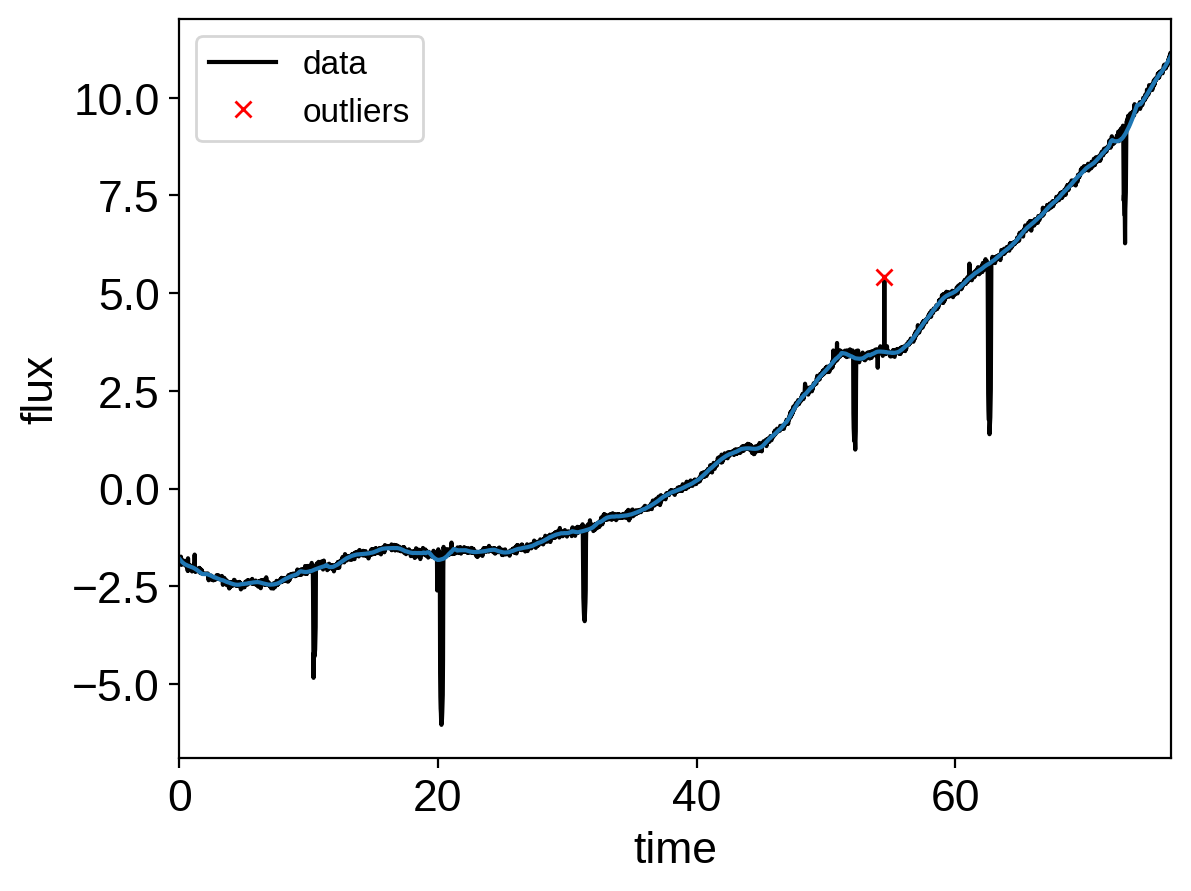

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from scipy.signal import savgol_filter

# Download the data
lc_url = "https://archive.stsci.edu/hlsps/everest/v2/c02/203700000/71098/hlsp_everest_k2_llc_203771098-c02_kepler_v2.0_lc.fits"
with fits.open(lc_url) as hdus:
    lc = hdus[1].data
    lc_hdr = hdus[1].header

# Work out the exposure time
texp = lc_hdr["FRAMETIM"] * lc_hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# Mask bad data
m = (np.arange(len(lc)) > 100) & np.isfinite(lc["FLUX"]) & np.isfinite(lc["TIME"])
bad_bits = [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17]
qual = lc["QUALITY"]
for b in bad_bits:
    m &= qual & 2 ** (b - 1) == 0

# Convert to parts per thousand
x = lc["TIME"][m]
y = lc["FLUX"][m]
mu = np.median(y)
y = (y / mu - 1) * 1e3

# Identify outliers
m = np.ones(len(y), dtype=bool)
for i in range(10):
    y_prime = np.interp(x, x[m], y[m])
    smooth = savgol_filter(y_prime, 101, polyorder=3)
    resid = y - smooth
    sigma = np.sqrt(np.mean(resid ** 2))
    m0 = np.abs(resid) < 3 * sigma
    if m.sum() == m0.sum():
        m = m0
        break
    m = m0

# Only discard positive outliers
m = resid < 3 * sigma

# Shift the data so that the K2 data start at t=0. This tends to make the fit
# better behaved since t0 covaries with period.
x_ref = np.min(x[m])
x -= x_ref

# Plot the data
plt.plot(x, y, "k", label="data")
plt.plot(x, smooth)
plt.plot(x[~m], y[~m], "xr", label="outliers")
plt.legend(fontsize=12)
plt.xlim(x.min(), x.max())
plt.xlabel("time")
plt.ylabel("flux")

# Make sure that the data type is consistent
x = np.ascontiguousarray(x[m], dtype=np.float64)
y = np.ascontiguousarray(y[m], dtype=np.float64)
smooth = np.ascontiguousarray(smooth[m], dtype=np.float64)

Then the RVs from [RadVel](https://radvel.readthedocs.io):

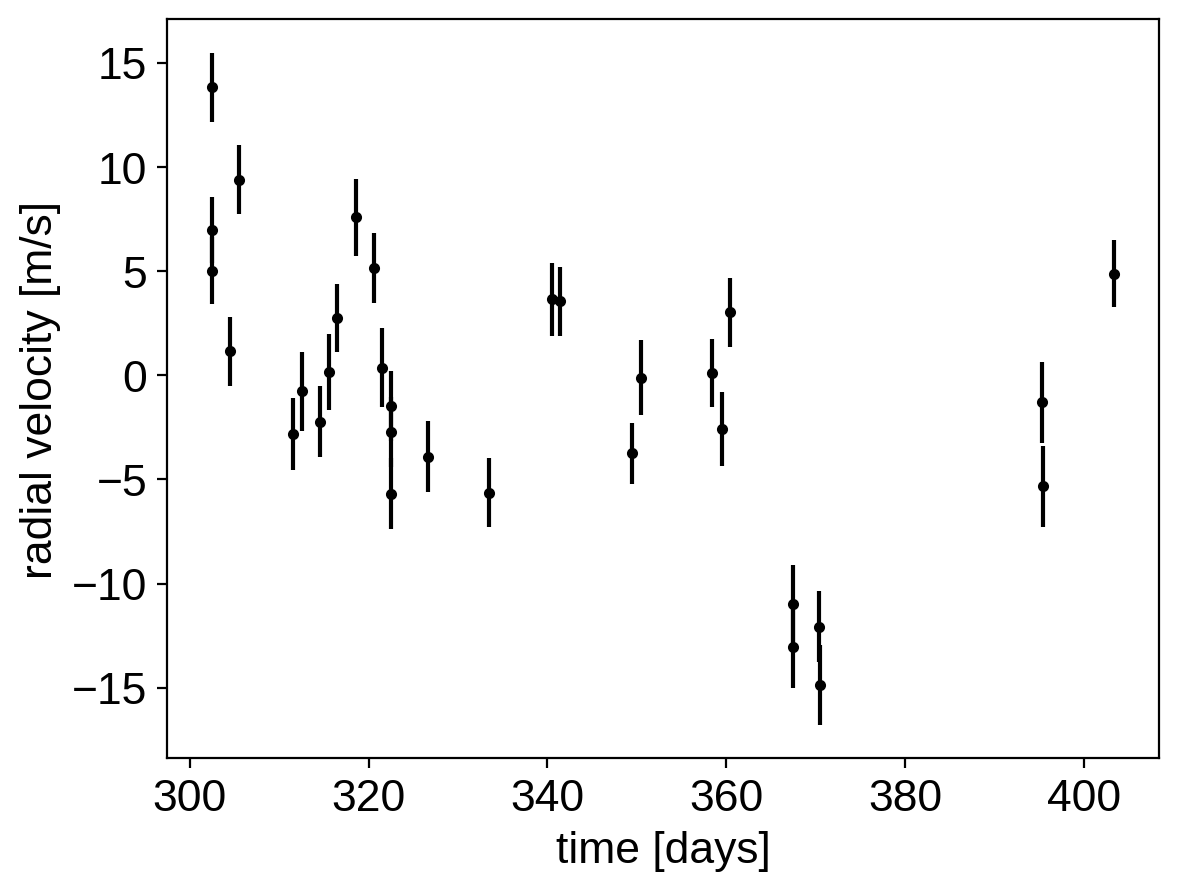

In [4]:
import pandas as pd

url = "https://raw.githubusercontent.com/California-Planet-Search/radvel/master/example_data/epic203771098.csv"
data = pd.read_csv(url, index_col=0)

# Don't forget to remove the time offset from above!
x_rv = np.array(data.t) - x_ref
y_rv = np.array(data.vel)
yerr_rv = np.array(data.errvel)

plt.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k")
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]");

We can initialize the transit parameters using [the box least squares periodogram from AstroPy](http://docs.astropy.org/en/latest/timeseries/bls.html).
(Note: you'll need AstroPy v3.1 or more recent to use this feature.)
A full discussion of transit detection and vetting is beyond the scope of this tutorial so let's assume that we know that there are two periodic transiting planets in this dataset.

In [5]:
from astropy.timeseries import BoxLeastSquares

m = np.zeros(len(x), dtype=bool)
period_grid = np.exp(np.linspace(np.log(5), np.log(50), 50000))
bls_results = []
periods = []
t0s = []
depths = []

# Compute the periodogram for each planet by iteratively masking out
# transits from the higher signal to noise planets. Here we're assuming
# that we know that there are exactly two planets.
for i in range(2):
    bls = BoxLeastSquares(x[~m], y[~m] - smooth[~m])
    bls_power = bls.power(period_grid, 0.1, oversample=20)
    bls_results.append(bls_power)

    # Save the highest peak as the planet candidate
    index = np.argmax(bls_power.power)
    periods.append(bls_power.period[index])
    t0s.append(bls_power.transit_time[index])
    depths.append(bls_power.depth[index])

    # Mask the data points that are in transit for this candidate
    m |= bls.transit_mask(x, periods[-1], 0.5, t0s[-1])

Let's plot the initial transit estimates based on these periodograms:

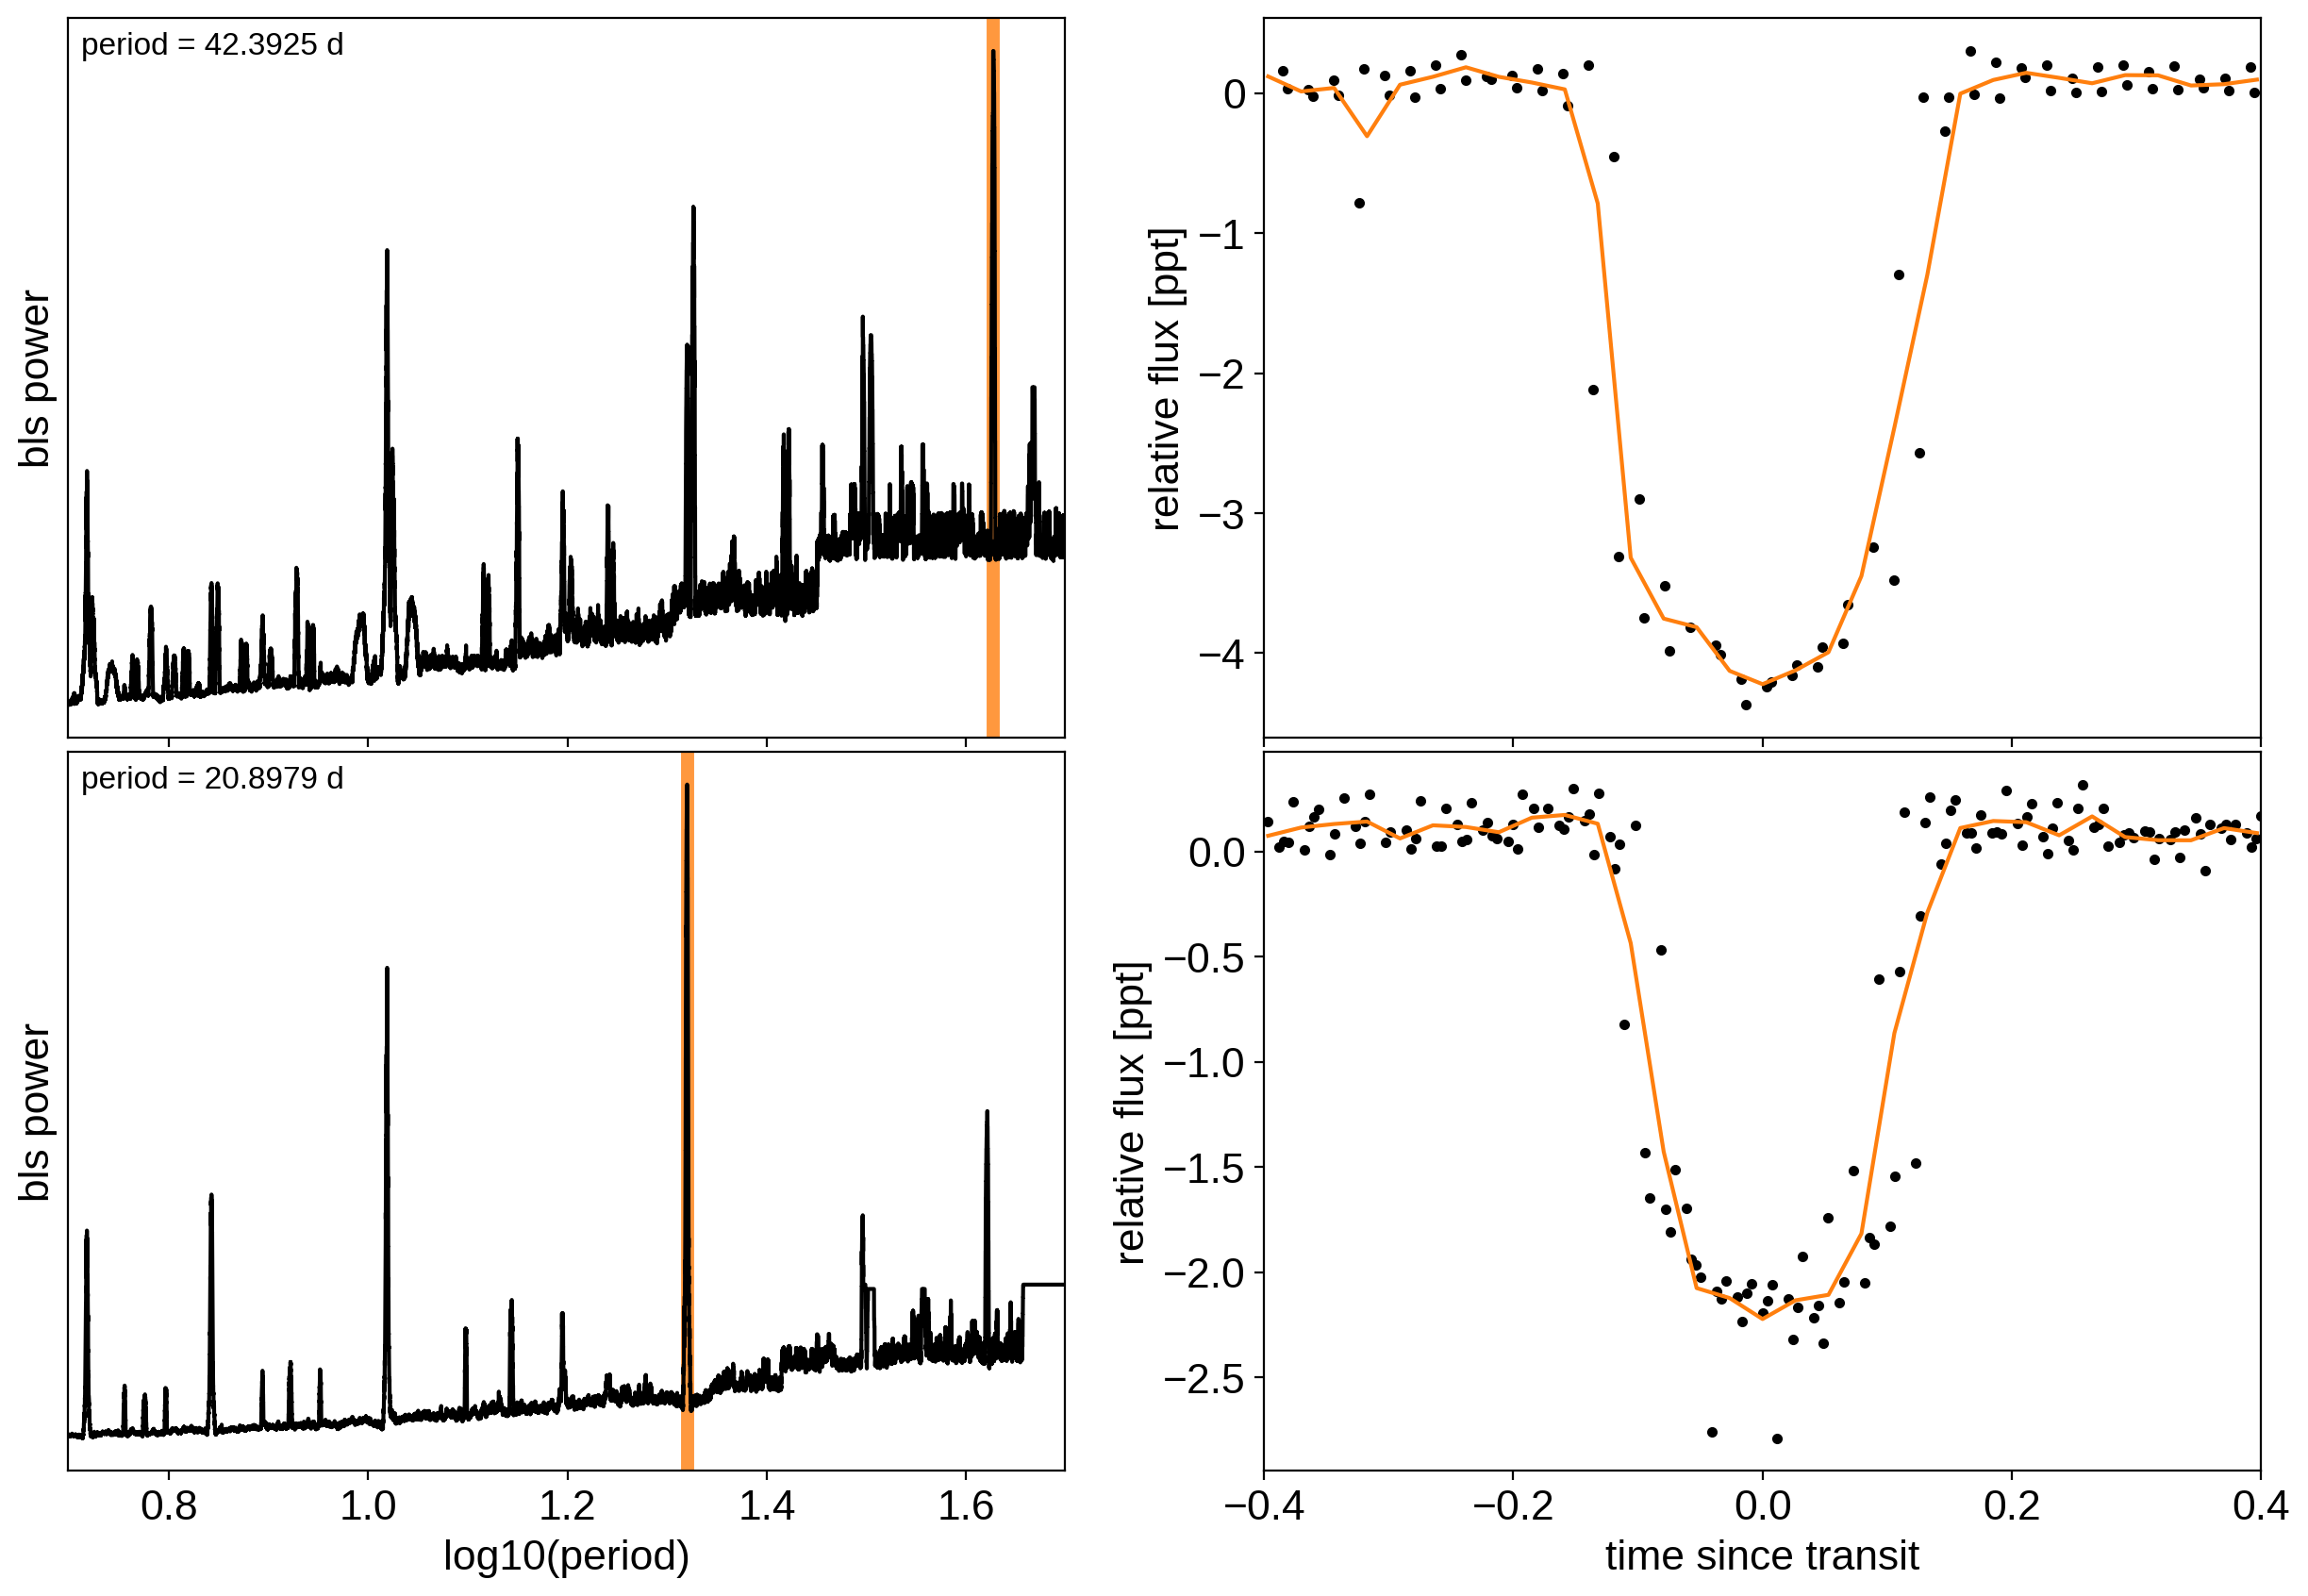

In [6]:
fig, axes = plt.subplots(len(bls_results), 2, figsize=(15, 10))

for i in range(len(bls_results)):
    # Plot the periodogram
    ax = axes[i, 0]
    ax.axvline(np.log10(periods[i]), color="C1", lw=5, alpha=0.8)
    ax.plot(np.log10(bls_results[i].period), bls_results[i].power, "k")
    ax.annotate(
        "period = {0:.4f} d".format(periods[i]),
        (0, 1),
        xycoords="axes fraction",
        xytext=(5, -5),
        textcoords="offset points",
        va="top",
        ha="left",
        fontsize=12,
    )
    ax.set_ylabel("bls power")
    ax.set_yticks([])
    ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
    if i < len(bls_results) - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("log10(period)")

    # Plot the folded transit
    ax = axes[i, 1]
    p = periods[i]
    x_fold = (x - t0s[i] + 0.5 * p) % p - 0.5 * p
    m = np.abs(x_fold) < 0.4
    ax.plot(x_fold[m], y[m] - smooth[m], ".k")

    # Overplot the phase binned light curve
    bins = np.linspace(-0.41, 0.41, 32)
    denom, _ = np.histogram(x_fold, bins)
    num, _ = np.histogram(x_fold, bins, weights=y - smooth)
    denom[num == 0] = 1.0
    ax.plot(0.5 * (bins[1:] + bins[:-1]), num / denom, color="C1")

    ax.set_xlim(-0.4, 0.4)
    ax.set_ylabel("relative flux [ppt]")
    if i < len(bls_results) - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("time since transit")

fig.subplots_adjust(hspace=0.02)

The discovery paper for K2-24 ([Petigura et al. (2016)](https://arxiv.org/abs/1511.04497)) includes the following estimates of the stellar mass and radius in Solar units:

In [7]:
M_star_petigura = 1.12, 0.05
R_star_petigura = 1.21, 0.11

Finally, using this stellar mass, we can also estimate the minimum masses of the planets given these transit parameters.

In [8]:
import exoplanet as xo
import astropy.units as u

msini = xo.estimate_minimum_mass(
    periods, x_rv, y_rv, yerr_rv, t0s=t0s, m_star=M_star_petigura[0]
)
msini = msini.to(u.M_earth)
print(msini)

[32.80060146 23.89885976] earthMass


## A joint transit and radial velocity model in PyMC3

Now, let's define our full model in *PyMC3*.
There's a lot going on here, but I've tried to comment it and most of it should be familiar from the previous tutorials (:ref:`rv`, :ref:`transit`, :ref:`gp`, and :ref:`stellar-variability`).
In this case, I've put the model inside a model "factory" function because we'll do some sigma clipping below.

In [9]:
import pymc3 as pm
import theano.tensor as tt

t_rv = np.linspace(x_rv.min() - 5, x_rv.max() + 5, 1000)


def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.distributions.QuadLimbDark("u_star")
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal("m_star", mu=M_star_petigura[0], sd=M_star_petigura[1])
        r_star = BoundedNormal("r_star", mu=R_star_petigura[0], sd=R_star_petigura[1])

        # Orbital parameters for the planets
        logm = pm.Normal("logm", mu=np.log(msini.value), sd=1, shape=2)
        logP = pm.Normal("logP", mu=np.log(periods), sd=1, shape=2)
        t0 = pm.Normal("t0", mu=np.array(t0s), sd=1, shape=2)
        logr = pm.Normal(
            "logr",
            mu=0.5 * np.log(1e-3 * np.array(depths)) + np.log(R_star_petigura[0]),
            sd=1.0,
            shape=2,
        )
        r_pl = pm.Deterministic("r_pl", tt.exp(logr))
        ror = pm.Deterministic("ror", r_pl / r_star)
        b = xo.distributions.ImpactParameter("b", ror=ror, shape=2)

        ecs = xo.UnitDisk("ecs", shape=(2, 2), testval=0.01 * np.ones((2, 2)))
        ecc = pm.Deterministic("ecc", tt.sum(ecs ** 2, axis=0))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
        xo.eccentricity.kipping13("ecc_prior", shape=2, observed=ecc)

        # RV jitter & a quadratic RV trend
        logs_rv = pm.Normal("logs_rv", mu=np.log(np.median(yerr_rv)), sd=5)
        trend = pm.Normal("trend", mu=0, sd=10.0 ** -np.arange(3)[::-1], shape=3)

        # Transit jitter & GP parameters
        logs2 = pm.Normal("logs2", mu=np.log(np.var(y[mask])), sd=10)
        logw0 = pm.Normal("logw0", mu=0.0, sd=10)
        logSw4 = pm.Normal("logSw4", mu=np.log(np.var(y[mask])), sd=10)

        # Tracking planet parameters
        period = pm.Deterministic("period", tt.exp(logP))
        m_pl = pm.Deterministic("m_pl", tt.exp(logm))

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star,
            m_star=m_star,
            period=period,
            t0=t0,
            b=b,
            m_planet=xo.units.with_unit(m_pl, msini.unit),
            ecc=ecc,
            omega=omega,
        )

        # Compute the model light curve using starry
        def mean_model(t):
            light_curves = pm.Deterministic(
                "light_curves",
                xo.LimbDarkLightCurve(u_star).get_light_curve(
                    orbit=orbit, r=r_pl, t=t, texp=texp
                )
                * 1e3,
            )
            return pm.math.sum(light_curves, axis=-1) + mean

        # GP model for the light curve
        kernel = xo.gp.terms.SHOTerm(log_Sw4=logSw4, log_w0=logw0, Q=1 / np.sqrt(2))
        gp = xo.gp.GP(
            kernel, x[mask], tt.exp(logs2) + tt.zeros(mask.sum()), mean=mean_model
        )
        gp.marginal("transit_obs", observed=y[mask])
        pm.Deterministic("gp_pred", gp.predict())

        # And then include the RVs as in the RV tutorial
        x_rv_ref = 0.5 * (x_rv.min() + x_rv.max())

        def get_rv_model(t, name=""):
            # First the RVs induced by the planets
            vrad = orbit.get_radial_velocity(t)
            pm.Deterministic("vrad" + name, vrad)

            # Define the background model
            A = np.vander(t - x_rv_ref, 3)
            bkg = pm.Deterministic("bkg" + name, tt.dot(A, trend))

            # Sum over planets and add the background to get the full model
            return pm.Deterministic("rv_model" + name, tt.sum(vrad, axis=-1) + bkg)

        # Define the model
        rv_model = get_rv_model(x_rv)
        get_rv_model(t_rv, name="_pred")

        # The likelihood for the RVs
        err = tt.sqrt(yerr_rv ** 2 + tt.exp(2 * logs_rv))
        pm.Normal("obs", mu=rv_model, sd=err, observed=y_rv)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = xo.optimize(start=start, vars=[trend])
        map_soln = xo.optimize(start=map_soln, vars=[logs2])
        map_soln = xo.optimize(start=map_soln, vars=[logr, b])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0])
        map_soln = xo.optimize(start=map_soln, vars=[logs2, logSw4])
        map_soln = xo.optimize(start=map_soln, vars=[logw0])
        map_soln = xo.optimize(start=map_soln)

    return model, map_soln


model0, map_soln0 = build_model()

optimizing logp for variables: [trend]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-8.284139e+03]

1it [00:00, 99.15it/s, logp=-8.284139e+03]

2it [00:00, 120.39it/s, logp=-8.284139e+03]

3it [00:00, 134.72it/s, logp=-5.396768e+06]

4it [00:00, 147.26it/s, logp=-8.283879e+03]

5it [00:00, 158.23it/s, logp=-8.283376e+03]

6it [00:00, 168.51it/s, logp=-8.281799e+03]

7it [00:00, 176.38it/s, logp=-8.278030e+03]

8it [00:00, 187.33it/s, logp=-8.272509e+03]

9it [00:00, 196.86it/s, logp=-8.271107e+03]

10it [00:00, 205.19it/s, logp=-8.271107e+03]

11it [00:00, 214.53it/s, logp=-8.271107e+03]

12it [00:12,  1.04s/it, logp=-8.271107e+03] 


message: Optimization terminated successfully.
logp: -8284.139088641374 -> -8271.10656435005


optimizing logp for variables: [logs2]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-8.271107e+03]

1it [00:00, 129.54it/s, logp=-8.271107e+03]

2it [00:00, 189.16it/s, logp=-8.271107e+03]

3it [00:00, 225.92it/s, logp=-6.547968e+03]

4it [00:00, 251.74it/s, logp=-5.315220e+01]

5it [00:00, 269.16it/s, logp=-3.542413e+05]

6it [00:00, 283.51it/s, logp=1.175912e+02] 

7it [00:00, 293.42it/s, logp=1.769103e+03]

8it [00:00, 298.64it/s, logp=1.851046e+03]

9it [00:00, 303.14it/s, logp=1.994027e+03]

10it [00:00, 307.62it/s, logp=2.107205e+03]

11it [00:00, 311.02it/s, logp=2.115968e+03]

12it [00:00, 314.25it/s, logp=2.116288e+03]

13it [00:00, 315.64it/s, logp=2.116288e+03]

14it [00:00, 317.89it/s, logp=2.116288e+03]

15it [00:01,  8.68it/s, logp=2.116288e+03] 


message: Optimization terminated successfully.
logp: -8271.10656435005 -> 2116.2884071823787


optimizing logp for variables: [b, logr, r_star]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.116288e+03]

1it [00:00, 100.55it/s, logp=2.116288e+03]

2it [00:00, 150.55it/s, logp=2.116288e+03]

3it [00:00, 181.77it/s, logp=-3.329459e+04]

4it [00:00, 198.78it/s, logp=2.603581e+03] 

5it [00:00, 204.79it/s, logp=1.027875e+02]

6it [00:00, 206.48it/s, logp=2.612148e+03]

7it [00:00, 200.15it/s, logp=2.623499e+03]

8it [00:00, 200.92it/s, logp=2.630682e+03]

9it [00:00, 202.11it/s, logp=2.633138e+03]

10it [00:00, 202.67it/s, logp=2.637140e+03]

11it [00:00, 203.42it/s, logp=2.641652e+03]

12it [00:00, 204.14it/s, logp=2.643249e+03]

13it [00:00, 205.04it/s, logp=2.644753e+03]

14it [00:00, 205.69it/s, logp=2.647056e+03]

15it [00:00, 204.40it/s, logp=2.648709e+03]

16it [00:00, 205.23it/s, logp=2.651281e+03]

17it [00:00, 205.59it/s, logp=2.651333e+03]

18it [00:00, 206.27it/s, logp=2.652658e+03]

19it [00:00, 207.04it/s, logp=2.654920e+03]

20it [00:00, 208.12it/s, logp=2.658139e+03]

21it [00:00, 209.96it/s, logp=2.663231e+03]

22it [00:00, 218.84it/s, logp=2.663231e+03]

22it [00:00, 218.84it/s, logp=2.671030e+03]

23it [00:00, 218.84it/s, logp=2.673175e+03]

24it [00:00, 218.84it/s, logp=2.675995e+03]

25it [00:00, 218.84it/s, logp=2.683031e+03]

26it [00:00, 218.84it/s, logp=2.690835e+03]

27it [00:00, 218.84it/s, logp=2.692717e+03]

28it [00:00, 218.84it/s, logp=2.694865e+03]

29it [00:00, 218.84it/s, logp=2.695224e+03]

30it [00:00, 218.84it/s, logp=2.695223e+03]

31it [00:00, 218.84it/s, logp=2.695246e+03]

32it [00:00, 218.84it/s, logp=2.695253e+03]

33it [00:00, 218.84it/s, logp=2.695253e+03]

34it [00:00, 218.84it/s, logp=2.695253e+03]

35it [00:00, 218.84it/s, logp=2.695253e+03]

36it [00:00, 218.84it/s, logp=2.695253e+03]

37it [00:00, 218.84it/s, logp=2.695253e+03]

38it [00:02, 16.10it/s, logp=2.695253e+03] 


message: Optimization terminated successfully.
logp: 2116.2884071823787 -> 2695.253116850775


optimizing logp for variables: [t0, logP]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.695253e+03]

1it [00:00, 114.27it/s, logp=2.695253e+03]

2it [00:00, 160.12it/s, logp=2.695253e+03]

3it [00:00, 179.78it/s, logp=-5.026678e+03]

4it [00:00, 201.89it/s, logp=-1.594661e+02]

5it [00:00, 216.86it/s, logp=-8.021692e+02]

6it [00:00, 229.66it/s, logp=-9.563265e+02]

7it [00:00, 239.94it/s, logp=-6.266967e+02]

8it [00:00, 248.02it/s, logp=9.111333e+02] 

9it [00:00, 253.65it/s, logp=2.891747e+03]

10it [00:00, 245.84it/s, logp=-5.309266e+01]

11it [00:00, 242.84it/s, logp=2.890047e+03] 

12it [00:00, 242.85it/s, logp=2.894091e+03]

13it [00:00, 239.28it/s, logp=2.898810e+03]

14it [00:00, 235.73it/s, logp=2.917313e+03]

15it [00:00, 233.81it/s, logp=2.985030e+03]

16it [00:00, 227.88it/s, logp=3.134004e+03]

17it [00:00, 223.64it/s, logp=3.217417e+03]

18it [00:00, 222.18it/s, logp=3.246066e+03]

19it [00:00, 220.71it/s, logp=3.250263e+03]

20it [00:00, 219.73it/s, logp=3.250352e+03]

21it [00:00, 218.59it/s, logp=3.250353e+03]

22it [00:00, 215.62it/s, logp=3.250353e+03]

23it [00:00, 223.01it/s, logp=3.250353e+03]

23it [00:00, 223.01it/s, logp=3.250353e+03]

24it [00:00, 223.01it/s, logp=3.250353e+03]

25it [00:00, 223.01it/s, logp=3.250353e+03]

26it [00:00, 223.01it/s, logp=3.250353e+03]

27it [00:00, 223.01it/s, logp=3.250353e+03]

28it [00:00, 223.01it/s, logp=3.250353e+03]

29it [00:00, 223.01it/s, logp=3.250353e+03]

30it [00:00, 223.01it/s, logp=3.250353e+03]

31it [00:00, 223.01it/s, logp=3.250353e+03]

32it [00:00, 223.01it/s, logp=3.250353e+03]

33it [00:00, 223.01it/s, logp=3.250353e+03]

34it [00:00, 223.01it/s, logp=3.250353e+03]

35it [00:00, 223.01it/s, logp=3.250353e+03]

36it [00:00, 223.01it/s, logp=3.250353e+03]

37it [00:00, 223.01it/s, logp=3.250353e+03]

38it [00:00, 223.01it/s, logp=3.250353e+03]

39it [00:00, 223.01it/s, logp=3.250353e+03]

40it [00:00, 223.01it/s, logp=3.250353e+03]

41it [00:00, 223.01it/s, logp=3.250353e+03]

42it [00:00, 223.01it/s, logp=3.250353e+03]

43it [00:00, 223.01it/s, logp=3.250353e+03]

44it [00:00, 223.01it/s, logp=3.250353e+03]

45it [00:00, 223.01it/s, logp=3.250353e+03]

46it [00:00, 223.01it/s, logp=3.250353e+03]

47it [00:00, 223.01it/s, logp=3.250353e+03]

48it [00:00, 223.01it/s, logp=3.250353e+03]

49it [00:00, 223.01it/s, logp=3.250353e+03]

50it [00:00, 223.01it/s, logp=3.250353e+03]

51it [00:00, 223.01it/s, logp=3.250353e+03]

52it [00:00, 238.74it/s, logp=3.250353e+03]

52it [00:00, 238.74it/s, logp=3.250353e+03]

53it [00:00, 238.74it/s, logp=3.250353e+03]

54it [00:00, 238.74it/s, logp=3.250353e+03]

55it [00:00, 238.74it/s, logp=3.250353e+03]

56it [00:00, 238.74it/s, logp=3.250353e+03]

57it [00:00, 238.74it/s, logp=3.250353e+03]

58it [00:00, 238.74it/s, logp=3.250353e+03]

59it [00:00, 238.74it/s, logp=3.250353e+03]

60it [00:00, 238.74it/s, logp=3.250353e+03]

61it [00:00, 238.74it/s, logp=3.250353e+03]

62it [00:00, 238.74it/s, logp=3.250353e+03]

63it [00:00, 238.74it/s, logp=3.250353e+03]

64it [00:00, 238.74it/s, logp=3.250353e+03]

65it [00:00, 238.74it/s, logp=3.250353e+03]

66it [00:00, 238.74it/s, logp=3.250353e+03]

67it [00:00, 238.74it/s, logp=3.250353e+03]

68it [00:00, 238.74it/s, logp=3.250353e+03]

69it [00:00, 238.74it/s, logp=3.250353e+03]

70it [00:00, 238.74it/s, logp=3.250353e+03]

71it [00:00, 238.74it/s, logp=3.250353e+03]

72it [00:00, 238.74it/s, logp=3.250353e+03]

73it [00:00, 238.74it/s, logp=3.250353e+03]

74it [00:00, 238.74it/s, logp=3.250353e+03]

75it [00:00, 238.74it/s, logp=3.250353e+03]

76it [00:00, 238.74it/s, logp=3.250353e+03]

77it [00:00, 239.95it/s, logp=3.250353e+03]

77it [00:00, 239.95it/s, logp=3.250353e+03]

78it [00:00, 239.95it/s, logp=3.250353e+03]

79it [00:00, 239.95it/s, logp=3.250353e+03]

80it [00:00, 239.95it/s, logp=3.250353e+03]

81it [00:00, 239.95it/s, logp=3.250353e+03]

82it [00:00, 239.95it/s, logp=3.250353e+03]

83it [00:00, 239.95it/s, logp=3.250353e+03]

84it [00:00, 239.95it/s, logp=3.250353e+03]

85it [00:00, 239.95it/s, logp=3.250353e+03]

86it [00:00, 239.95it/s, logp=3.250353e+03]

87it [00:00, 239.95it/s, logp=3.250353e+03]

88it [00:00, 239.95it/s, logp=3.250353e+03]

89it [00:00, 239.95it/s, logp=3.250353e+03]

90it [00:00, 239.95it/s, logp=3.250353e+03]

91it [00:00, 239.95it/s, logp=3.250353e+03]

92it [00:00, 239.95it/s, logp=3.250353e+03]

93it [00:00, 239.95it/s, logp=3.250353e+03]

94it [00:00, 239.95it/s, logp=3.250353e+03]

95it [00:00, 239.95it/s, logp=3.250353e+03]

96it [00:00, 239.95it/s, logp=3.250353e+03]

97it [00:00, 239.95it/s, logp=3.250353e+03]

98it [00:00, 239.95it/s, logp=3.250353e+03]

99it [00:00, 239.95it/s, logp=3.250353e+03]

100it [00:00, 239.95it/s, logp=3.250353e+03]

101it [00:00, 239.95it/s, logp=3.250353e+03]

102it [00:00, 239.95it/s, logp=3.250353e+03]

103it [00:00, 244.25it/s, logp=3.250353e+03]

103it [00:00, 244.25it/s, logp=3.250353e+03]

104it [00:00, 244.25it/s, logp=3.250353e+03]

105it [00:00, 244.25it/s, logp=3.250353e+03]

106it [00:00, 244.25it/s, logp=3.250353e+03]

107it [00:00, 244.25it/s, logp=3.250353e+03]

108it [00:00, 244.25it/s, logp=3.250353e+03]

109it [00:00, 244.25it/s, logp=3.250353e+03]

110it [00:00, 244.25it/s, logp=3.250353e+03]

111it [00:00, 244.25it/s, logp=3.250353e+03]

112it [00:00, 244.25it/s, logp=3.250353e+03]

113it [00:00, 244.25it/s, logp=3.250353e+03]

114it [00:00, 244.25it/s, logp=3.250353e+03]

115it [00:00, 244.25it/s, logp=3.250353e+03]

116it [00:00, 244.25it/s, logp=3.250353e+03]

117it [00:00, 244.25it/s, logp=3.250353e+03]

118it [00:00, 244.25it/s, logp=3.250353e+03]

119it [00:00, 244.25it/s, logp=3.250353e+03]

120it [00:00, 244.25it/s, logp=3.250353e+03]

121it [00:00, 244.25it/s, logp=3.250353e+03]

122it [00:00, 244.25it/s, logp=3.250353e+03]

123it [00:00, 244.25it/s, logp=3.250353e+03]

124it [00:00, 244.25it/s, logp=3.250353e+03]

125it [00:00, 244.25it/s, logp=3.250353e+03]

126it [00:00, 244.25it/s, logp=3.250353e+03]

127it [00:00, 244.25it/s, logp=3.250353e+03]

128it [00:00, 244.25it/s, logp=3.250353e+03]

129it [00:00, 244.25it/s, logp=3.250353e+03]

130it [00:00, 244.25it/s, logp=3.250353e+03]

131it [00:00, 244.25it/s, logp=3.250353e+03]

132it [00:00, 244.25it/s, logp=3.250353e+03]

133it [00:00, 244.25it/s, logp=3.250353e+03]

134it [00:00, 244.25it/s, logp=3.250353e+03]

135it [00:00, 244.25it/s, logp=3.250353e+03]

136it [00:00, 244.25it/s, logp=3.250353e+03]

137it [00:00, 265.14it/s, logp=3.250353e+03]

137it [00:00, 265.14it/s, logp=3.250353e+03]

138it [00:00, 265.14it/s, logp=3.250353e+03]

139it [00:00, 265.14it/s, logp=3.250353e+03]

140it [00:00, 265.14it/s, logp=3.250353e+03]

141it [00:00, 265.14it/s, logp=3.250353e+03]

142it [00:00, 265.14it/s, logp=3.250353e+03]

143it [00:00, 265.14it/s, logp=3.250353e+03]

144it [00:00, 265.14it/s, logp=3.250353e+03]

145it [00:00, 265.14it/s, logp=3.250353e+03]

146it [00:00, 265.14it/s, logp=3.250353e+03]

147it [00:00, 265.14it/s, logp=3.250353e+03]

148it [00:00, 265.14it/s, logp=3.250353e+03]

149it [00:00, 265.14it/s, logp=3.250353e+03]

150it [00:02, 51.72it/s, logp=3.250353e+03] 


message: Desired error not necessarily achieved due to precision loss.
logp: 2695.2531168507785 -> 3250.3531341336575


optimizing logp for variables: [logSw4, logs2]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=3.250353e+03]

1it [00:00, 142.26it/s, logp=3.250353e+03]

2it [00:00, 191.12it/s, logp=3.250353e+03]

3it [00:00, 199.49it/s, logp=3.748782e+03]

4it [00:00, 209.00it/s, logp=-4.144318e+03]

5it [00:00, 216.43it/s, logp=3.901100e+03] 

6it [00:00, 221.50it/s, logp=3.903484e+03]

7it [00:00, 223.40it/s, logp=3.904522e+03]

8it [00:00, 215.62it/s, logp=3.904523e+03]

9it [00:00, 212.47it/s, logp=3.904524e+03]

10it [00:00, 205.22it/s, logp=3.904524e+03]

11it [00:00, 202.75it/s, logp=3.904524e+03]

12it [00:00, 202.88it/s, logp=3.904524e+03]

13it [00:00, 204.90it/s, logp=3.904524e+03]

14it [00:00, 206.67it/s, logp=3.904524e+03]

15it [00:00, 209.62it/s, logp=3.904524e+03]

16it [00:00, 214.05it/s, logp=3.904524e+03]

17it [00:00, 218.31it/s, logp=3.904524e+03]

18it [00:00, 222.34it/s, logp=3.904524e+03]

19it [00:00, 226.47it/s, logp=3.904524e+03]

20it [00:00, 229.66it/s, logp=3.904524e+03]

21it [00:00, 232.87it/s, logp=3.904524e+03]

22it [00:00, 235.81it/s, logp=3.904524e+03]

23it [00:00, 238.60it/s, logp=3.904524e+03]

24it [00:00, 241.27it/s, logp=3.904524e+03]

25it [00:00, 243.69it/s, logp=3.904524e+03]

26it [00:00, 252.27it/s, logp=3.904524e+03]

26it [00:00, 252.27it/s, logp=3.904524e+03]

27it [00:00, 252.27it/s, logp=3.904524e+03]

28it [00:00, 252.27it/s, logp=3.904524e+03]

29it [00:00, 252.27it/s, logp=3.904524e+03]

30it [00:00, 252.27it/s, logp=3.904524e+03]

31it [00:00, 252.27it/s, logp=3.904524e+03]

32it [00:00, 252.27it/s, logp=3.904524e+03]

33it [00:00, 252.27it/s, logp=3.904524e+03]

34it [00:00, 252.27it/s, logp=3.904524e+03]

35it [00:00, 252.27it/s, logp=3.904524e+03]

36it [00:00, 252.27it/s, logp=3.904524e+03]

37it [00:00, 252.27it/s, logp=3.904524e+03]

38it [00:00, 252.27it/s, logp=3.904524e+03]

39it [00:00, 252.27it/s, logp=3.904524e+03]

40it [00:00, 252.27it/s, logp=3.904524e+03]

41it [00:00, 252.27it/s, logp=3.904524e+03]

42it [00:00, 252.27it/s, logp=3.904524e+03]

43it [00:00, 252.27it/s, logp=3.904524e+03]

44it [00:00, 252.27it/s, logp=3.904524e+03]

45it [00:00, 252.27it/s, logp=3.904524e+03]

46it [00:00, 252.27it/s, logp=3.904524e+03]

47it [00:00, 252.27it/s, logp=3.904524e+03]

48it [00:00, 252.27it/s, logp=3.904524e+03]

49it [00:00, 252.27it/s, logp=3.904524e+03]

50it [00:00, 252.27it/s, logp=3.904524e+03]

51it [00:00, 252.27it/s, logp=3.904524e+03]

52it [00:00, 252.27it/s, logp=3.904524e+03]

53it [00:00, 252.27it/s, logp=3.904524e+03]

54it [00:00, 257.78it/s, logp=3.904524e+03]

54it [00:00, 257.78it/s, logp=3.904524e+03]

55it [00:00, 257.78it/s, logp=3.904524e+03]

56it [00:00, 257.78it/s, logp=3.904524e+03]

57it [00:00, 257.78it/s, logp=3.904524e+03]

58it [00:00, 257.78it/s, logp=3.904524e+03]

59it [00:00, 257.78it/s, logp=3.904524e+03]

60it [00:00, 257.78it/s, logp=3.904524e+03]

61it [00:00, 257.78it/s, logp=3.904524e+03]

62it [00:00, 257.78it/s, logp=3.904524e+03]

63it [00:00, 257.78it/s, logp=3.904524e+03]

64it [00:02, 28.18it/s, logp=3.904524e+03] 


message: Optimization terminated successfully.
logp: 3250.353134133655 -> 3904.523631787628


optimizing logp for variables: [logw0]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=3.904524e+03]

1it [00:00, 127.43it/s, logp=3.904524e+03]

2it [00:00, 179.85it/s, logp=3.904524e+03]

3it [00:00, 208.72it/s, logp=4.007629e+03]

4it [00:00, 226.97it/s, logp=4.007835e+03]

5it [00:00, 237.57it/s, logp=4.008535e+03]

6it [00:00, 246.74it/s, logp=4.008560e+03]

7it [00:00, 255.95it/s, logp=4.008976e+03]

8it [00:00, 259.74it/s, logp=4.009002e+03]

9it [00:00, 262.53it/s, logp=4.009006e+03]

10it [00:00, 263.01it/s, logp=4.009006e+03]

11it [00:00, 265.37it/s, logp=4.009006e+03]

12it [00:02,  5.08it/s, logp=4.009006e+03] 


message: Optimization terminated successfully.
logp: 3904.523631787628 -> 4009.0061248557217


optimizing logp for variables: [logSw4, logw0, logs2, trend, logs_rv, ecc_prior_beta, ecc_prior_alpha, ecs, b, logr, t0, logP, logm, r_star, m_star, u_star, mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=4.009006e+03]

1it [00:00, 89.41it/s, logp=4.009006e+03]

2it [00:00, 129.61it/s, logp=4.009006e+03]

3it [00:00, 116.55it/s, logp=-5.650260e+03]

4it [00:00, 117.23it/s, logp=-8.084778e+03]

5it [00:00, 121.40it/s, logp=-1.102581e+04]

6it [00:00, 126.36it/s, logp=3.997612e+03] 

7it [00:00, 134.22it/s, logp=4.009105e+03]

8it [00:00, 141.08it/s, logp=4.004914e+03]

9it [00:00, 148.70it/s, logp=4.009108e+03]

10it [00:00, 154.63it/s, logp=4.009112e+03]

11it [00:00, 160.49it/s, logp=4.009132e+03]

12it [00:00, 165.56it/s, logp=4.009208e+03]

13it [00:00, 170.08it/s, logp=4.009509e+03]

14it [00:00, 174.24it/s, logp=4.010632e+03]

15it [00:00, 177.30it/s, logp=4.013466e+03]

16it [00:00, 179.89it/s, logp=4.019035e+03]

17it [00:00, 183.40it/s, logp=4.038108e+03]

18it [00:00, 186.30it/s, logp=4.057737e+03]

19it [00:00, 188.91it/s, logp=3.953371e+03]

20it [00:00, 197.68it/s, logp=3.953371e+03]

20it [00:00, 197.68it/s, logp=4.060426e+03]

21it [00:00, 197.68it/s, logp=4.065609e+03]

22it [00:00, 197.68it/s, logp=4.081269e+03]

23it [00:00, 197.68it/s, logp=4.121238e+03]

24it [00:00, 197.68it/s, logp=4.195694e+03]

25it [00:00, 197.68it/s, logp=4.295339e+03]

26it [00:00, 197.68it/s, logp=4.389484e+03]

27it [00:00, 197.68it/s, logp=3.903543e+03]

28it [00:00, 197.68it/s, logp=4.404316e+03]

29it [00:00, 197.68it/s, logp=4.422165e+03]

30it [00:00, 197.68it/s, logp=4.446216e+03]

31it [00:00, 197.68it/s, logp=4.467143e+03]

32it [00:00, 197.68it/s, logp=4.419878e+03]

33it [00:00, 197.68it/s, logp=4.475234e+03]

34it [00:00, 197.68it/s, logp=4.486342e+03]

35it [00:00, 197.68it/s, logp=4.503873e+03]

36it [00:00, 197.68it/s, logp=4.515125e+03]

37it [00:00, 197.68it/s, logp=4.534803e+03]

38it [00:00, 197.68it/s, logp=4.566656e+03]

39it [00:00, 197.68it/s, logp=4.466830e+03]

40it [00:00, 197.68it/s, logp=4.578099e+03]

41it [00:00, 197.68it/s, logp=4.586135e+03]

42it [00:00, 197.68it/s, logp=4.596711e+03]

43it [00:00, 197.68it/s, logp=4.612973e+03]

44it [00:00, 197.68it/s, logp=4.624323e+03]

45it [00:00, 208.17it/s, logp=4.624323e+03]

45it [00:00, 208.17it/s, logp=4.634318e+03]

46it [00:00, 208.17it/s, logp=4.626853e+03]

47it [00:00, 208.17it/s, logp=4.636511e+03]

48it [00:00, 208.17it/s, logp=4.640607e+03]

49it [00:00, 208.17it/s, logp=4.648338e+03]

50it [00:00, 208.17it/s, logp=4.657571e+03]

51it [00:00, 208.17it/s, logp=4.670494e+03]

52it [00:00, 208.17it/s, logp=4.683881e+03]

53it [00:00, 208.17it/s, logp=4.694700e+03]

54it [00:00, 208.17it/s, logp=4.703979e+03]

55it [00:00, 208.17it/s, logp=4.680783e+03]

56it [00:00, 208.17it/s, logp=4.706081e+03]

57it [00:00, 208.17it/s, logp=4.708903e+03]

58it [00:00, 208.17it/s, logp=4.712191e+03]

59it [00:00, 208.17it/s, logp=4.713847e+03]

60it [00:00, 208.17it/s, logp=4.714742e+03]

61it [00:00, 208.17it/s, logp=4.715489e+03]

62it [00:00, 208.17it/s, logp=4.716024e+03]

63it [00:00, 208.17it/s, logp=4.716658e+03]

64it [00:00, 208.17it/s, logp=4.717015e+03]

65it [00:00, 208.17it/s, logp=4.717269e+03]

66it [00:00, 208.17it/s, logp=4.717659e+03]

67it [00:00, 208.17it/s, logp=4.718267e+03]

68it [00:00, 212.04it/s, logp=4.718267e+03]

68it [00:00, 212.04it/s, logp=4.718908e+03]

69it [00:00, 212.04it/s, logp=4.719581e+03]

70it [00:00, 212.04it/s, logp=4.720061e+03]

71it [00:00, 212.04it/s, logp=4.720291e+03]

72it [00:00, 212.04it/s, logp=4.720514e+03]

73it [00:00, 212.04it/s, logp=4.720641e+03]

74it [00:00, 212.04it/s, logp=4.720760e+03]

75it [00:00, 212.04it/s, logp=4.720948e+03]

76it [00:00, 212.04it/s, logp=4.721216e+03]

77it [00:00, 212.04it/s, logp=4.721551e+03]

78it [00:00, 212.04it/s, logp=4.721912e+03]

79it [00:00, 212.04it/s, logp=4.722539e+03]

80it [00:00, 212.04it/s, logp=4.722815e+03]

81it [00:00, 212.04it/s, logp=4.722958e+03]

82it [00:00, 212.04it/s, logp=4.723636e+03]

83it [00:00, 212.04it/s, logp=4.724665e+03]

84it [00:00, 212.04it/s, logp=4.726415e+03]

85it [00:00, 212.04it/s, logp=4.728753e+03]

86it [00:00, 212.04it/s, logp=4.732655e+03]

87it [00:00, 212.04it/s, logp=4.735853e+03]

88it [00:00, 212.04it/s, logp=4.736875e+03]

89it [00:00, 210.88it/s, logp=4.736875e+03]

89it [00:00, 210.88it/s, logp=4.737593e+03]

90it [00:00, 210.88it/s, logp=4.738114e+03]

91it [00:00, 210.88it/s, logp=4.738289e+03]

92it [00:00, 210.88it/s, logp=4.738391e+03]

93it [00:00, 210.88it/s, logp=4.738419e+03]

94it [00:00, 210.88it/s, logp=4.738455e+03]

95it [00:00, 210.88it/s, logp=4.738512e+03]

96it [00:00, 210.88it/s, logp=4.738600e+03]

97it [00:00, 210.88it/s, logp=4.738717e+03]

98it [00:00, 210.88it/s, logp=4.738857e+03]

99it [00:00, 210.88it/s, logp=4.738993e+03]

100it [00:00, 210.88it/s, logp=4.739025e+03]

101it [00:00, 210.88it/s, logp=4.739040e+03]

102it [00:00, 210.88it/s, logp=4.739056e+03]

103it [00:00, 210.88it/s, logp=4.739070e+03]

104it [00:00, 210.88it/s, logp=4.739081e+03]

105it [00:00, 210.88it/s, logp=4.739101e+03]

106it [00:00, 210.88it/s, logp=4.739138e+03]

107it [00:00, 210.88it/s, logp=4.739208e+03]

108it [00:00, 210.88it/s, logp=4.739314e+03]

109it [00:00, 210.88it/s, logp=4.739343e+03]

110it [00:00, 210.88it/s, logp=4.739364e+03]

111it [00:00, 210.88it/s, logp=4.739438e+03]

112it [00:00, 210.88it/s, logp=4.739509e+03]

113it [00:00, 218.40it/s, logp=4.739509e+03]

113it [00:00, 218.40it/s, logp=4.739545e+03]

114it [00:00, 218.40it/s, logp=4.739578e+03]

115it [00:00, 218.40it/s, logp=4.739589e+03]

116it [00:00, 218.40it/s, logp=4.739603e+03]

117it [00:00, 218.40it/s, logp=4.739618e+03]

118it [00:00, 218.40it/s, logp=4.739639e+03]

119it [00:00, 218.40it/s, logp=4.739652e+03]

120it [00:00, 218.40it/s, logp=4.739666e+03]

121it [00:00, 218.40it/s, logp=4.739675e+03]

122it [00:00, 218.40it/s, logp=4.739693e+03]

123it [00:00, 218.40it/s, logp=4.739726e+03]

124it [00:00, 218.40it/s, logp=4.739786e+03]

125it [00:00, 218.40it/s, logp=4.739885e+03]

126it [00:00, 218.40it/s, logp=4.740017e+03]

127it [00:00, 218.40it/s, logp=4.740107e+03]

128it [00:00, 218.40it/s, logp=4.740130e+03]

129it [00:00, 218.40it/s, logp=4.740162e+03]

130it [00:00, 218.40it/s, logp=4.740238e+03]

131it [00:00, 218.40it/s, logp=4.740266e+03]

132it [00:00, 218.40it/s, logp=4.740292e+03]

133it [00:00, 209.74it/s, logp=4.740292e+03]

133it [00:00, 209.74it/s, logp=4.740331e+03]

134it [00:00, 209.74it/s, logp=4.740366e+03]

135it [00:00, 209.74it/s, logp=4.740425e+03]

136it [00:00, 209.74it/s, logp=4.740493e+03]

137it [00:00, 209.74it/s, logp=4.740508e+03]

138it [00:00, 209.74it/s, logp=4.740518e+03]

139it [00:00, 209.74it/s, logp=4.740528e+03]

140it [00:00, 209.74it/s, logp=4.740541e+03]

141it [00:00, 209.74it/s, logp=4.740553e+03]

142it [00:00, 209.74it/s, logp=4.740562e+03]

143it [00:00, 209.74it/s, logp=4.740565e+03]

144it [00:00, 209.74it/s, logp=4.740566e+03]

145it [00:00, 209.74it/s, logp=4.740567e+03]

146it [00:00, 209.74it/s, logp=4.740568e+03]

147it [00:00, 209.74it/s, logp=4.740569e+03]

148it [00:00, 209.74it/s, logp=4.740570e+03]

149it [00:00, 209.74it/s, logp=4.740570e+03]

150it [00:00, 209.74it/s, logp=4.740571e+03]

151it [00:00, 209.74it/s, logp=4.740572e+03]

152it [00:00, 209.74it/s, logp=4.740573e+03]

153it [00:00, 206.06it/s, logp=4.740573e+03]

153it [00:00, 206.06it/s, logp=4.740573e+03]

154it [00:00, 206.06it/s, logp=4.740573e+03]

155it [00:00, 206.06it/s, logp=4.740573e+03]

156it [00:00, 206.06it/s, logp=4.740573e+03]

157it [00:00, 206.06it/s, logp=4.740573e+03]

158it [00:00, 206.06it/s, logp=4.740573e+03]

159it [00:00, 206.06it/s, logp=4.740573e+03]

160it [00:00, 206.06it/s, logp=4.740573e+03]

161it [00:00, 206.06it/s, logp=4.740573e+03]

162it [00:00, 206.06it/s, logp=4.740573e+03]

163it [00:00, 206.06it/s, logp=4.740574e+03]

164it [00:00, 206.06it/s, logp=4.740574e+03]

165it [00:00, 206.06it/s, logp=4.740574e+03]

166it [00:00, 206.06it/s, logp=4.740575e+03]

167it [00:00, 206.06it/s, logp=4.740575e+03]

168it [00:00, 206.06it/s, logp=4.740575e+03]

169it [00:00, 206.06it/s, logp=4.740575e+03]

170it [00:00, 206.06it/s, logp=4.740575e+03]

171it [00:00, 206.06it/s, logp=4.740575e+03]

172it [00:00, 206.06it/s, logp=4.740575e+03]

173it [00:00, 201.29it/s, logp=4.740575e+03]

173it [00:00, 201.29it/s, logp=4.740575e+03]

174it [00:00, 201.29it/s, logp=4.740575e+03]

175it [00:00, 201.29it/s, logp=4.740575e+03]

176it [00:00, 201.29it/s, logp=4.740575e+03]

177it [00:00, 201.29it/s, logp=4.740575e+03]

178it [00:00, 201.29it/s, logp=4.740575e+03]

179it [00:00, 201.29it/s, logp=4.740575e+03]

180it [00:00, 201.29it/s, logp=4.740575e+03]

181it [00:00, 201.29it/s, logp=4.740575e+03]

182it [00:00, 201.29it/s, logp=4.740575e+03]

183it [00:00, 201.29it/s, logp=4.740575e+03]

184it [00:00, 201.29it/s, logp=4.740575e+03]

185it [00:00, 201.29it/s, logp=4.740575e+03]

186it [00:00, 201.29it/s, logp=4.740575e+03]

187it [00:00, 201.29it/s, logp=4.740575e+03]

188it [00:00, 201.29it/s, logp=4.740575e+03]

189it [00:00, 201.29it/s, logp=4.740575e+03]

190it [00:00, 201.29it/s, logp=4.740575e+03]

191it [00:00, 201.29it/s, logp=4.740575e+03]

192it [00:00, 201.29it/s, logp=4.740575e+03]

193it [00:00, 201.29it/s, logp=4.740575e+03]

194it [00:00, 201.29it/s, logp=4.740575e+03]

195it [00:00, 201.29it/s, logp=4.740575e+03]

196it [00:00, 201.29it/s, logp=4.740575e+03]

197it [00:00, 201.29it/s, logp=4.740575e+03]

198it [00:00, 213.34it/s, logp=4.740575e+03]

198it [00:00, 213.34it/s, logp=4.740575e+03]

199it [00:00, 213.34it/s, logp=4.740575e+03]

200it [00:00, 213.34it/s, logp=4.740575e+03]

201it [00:00, 213.34it/s, logp=4.740575e+03]

202it [00:00, 213.34it/s, logp=4.740575e+03]

203it [00:00, 213.34it/s, logp=4.740575e+03]

204it [00:00, 213.34it/s, logp=4.740575e+03]

205it [00:00, 213.34it/s, logp=4.740575e+03]

206it [00:00, 213.34it/s, logp=4.740575e+03]

207it [00:00, 213.34it/s, logp=4.740575e+03]

208it [00:00, 213.34it/s, logp=4.740575e+03]

209it [00:00, 213.34it/s, logp=4.740575e+03]

210it [00:00, 213.34it/s, logp=4.740575e+03]

211it [00:00, 213.34it/s, logp=4.740575e+03]

212it [00:00, 213.34it/s, logp=4.740575e+03]

213it [00:00, 213.34it/s, logp=4.740575e+03]

214it [00:00, 213.34it/s, logp=4.740575e+03]

215it [00:00, 213.34it/s, logp=4.740575e+03]

216it [00:01, 213.34it/s, logp=4.740575e+03]

217it [00:01, 213.34it/s, logp=4.740575e+03]

218it [00:01, 213.34it/s, logp=4.740575e+03]

219it [00:01, 213.34it/s, logp=4.740575e+03]

220it [00:01, 213.34it/s, logp=4.740575e+03]

221it [00:01, 213.34it/s, logp=4.740575e+03]

222it [00:01, 213.34it/s, logp=4.740575e+03]

223it [00:01, 221.27it/s, logp=4.740575e+03]

223it [00:01, 221.27it/s, logp=4.740575e+03]

224it [00:01, 221.27it/s, logp=4.740575e+03]

225it [00:01, 221.27it/s, logp=4.740575e+03]

226it [00:01, 221.27it/s, logp=4.740575e+03]

227it [00:01, 221.27it/s, logp=4.740575e+03]

228it [00:01, 221.27it/s, logp=4.740575e+03]

229it [00:01, 221.27it/s, logp=4.740575e+03]

230it [00:01, 221.27it/s, logp=4.740575e+03]

231it [00:01, 221.27it/s, logp=4.740575e+03]

232it [00:01, 221.27it/s, logp=4.740575e+03]

233it [00:01, 221.27it/s, logp=4.740575e+03]

234it [00:01, 221.27it/s, logp=4.740575e+03]

235it [00:01, 221.27it/s, logp=4.740575e+03]

236it [00:01, 221.27it/s, logp=4.740575e+03]

237it [00:01, 221.27it/s, logp=4.740575e+03]

238it [00:01, 221.27it/s, logp=4.740575e+03]

239it [00:01, 221.27it/s, logp=4.740575e+03]

240it [00:01, 221.27it/s, logp=4.740575e+03]

241it [00:01, 221.27it/s, logp=4.740575e+03]

242it [00:01, 221.27it/s, logp=4.740575e+03]

243it [00:01, 221.27it/s, logp=4.740575e+03]

244it [00:01, 221.27it/s, logp=4.740575e+03]

245it [00:01, 221.27it/s, logp=4.740575e+03]

246it [00:01, 221.27it/s, logp=4.740575e+03]

247it [00:01, 221.27it/s, logp=4.740575e+03]

248it [00:01, 227.02it/s, logp=4.740575e+03]

248it [00:01, 227.02it/s, logp=4.740575e+03]

249it [00:01, 227.02it/s, logp=4.740575e+03]

250it [00:01, 227.02it/s, logp=4.740575e+03]

251it [00:01, 227.02it/s, logp=4.740575e+03]

252it [00:01, 227.02it/s, logp=4.740575e+03]

253it [00:01, 227.02it/s, logp=4.740575e+03]

254it [00:01, 227.02it/s, logp=4.740575e+03]

255it [00:01, 227.02it/s, logp=4.740575e+03]

256it [00:01, 227.02it/s, logp=4.740575e+03]

257it [00:01, 227.02it/s, logp=4.740575e+03]

258it [00:01, 227.02it/s, logp=4.740575e+03]

259it [00:01, 227.02it/s, logp=4.740575e+03]

260it [00:01, 227.02it/s, logp=4.740575e+03]

261it [00:01, 227.02it/s, logp=4.740575e+03]

262it [00:01, 227.02it/s, logp=4.740575e+03]

263it [00:01, 227.02it/s, logp=4.740575e+03]

264it [00:01, 227.02it/s, logp=4.740575e+03]

265it [00:01, 227.02it/s, logp=4.740575e+03]

266it [00:01, 227.02it/s, logp=4.740575e+03]

267it [00:01, 227.02it/s, logp=4.740575e+03]

268it [00:01, 227.02it/s, logp=4.740575e+03]

269it [00:01, 227.02it/s, logp=4.740575e+03]

270it [00:01, 227.02it/s, logp=4.740575e+03]

271it [00:01, 227.02it/s, logp=4.740575e+03]

272it [00:01, 227.02it/s, logp=4.740575e+03]

273it [00:01, 231.25it/s, logp=4.740575e+03]

273it [00:01, 231.25it/s, logp=4.740575e+03]

274it [00:01, 231.25it/s, logp=4.740575e+03]

275it [00:01, 231.25it/s, logp=4.740575e+03]

276it [00:01, 231.25it/s, logp=4.740575e+03]

277it [00:01, 231.25it/s, logp=4.740575e+03]

278it [00:01, 231.25it/s, logp=4.740575e+03]

279it [00:01, 231.25it/s, logp=4.740575e+03]

280it [00:01, 231.25it/s, logp=4.740575e+03]

281it [00:01, 231.25it/s, logp=4.740575e+03]

282it [00:01, 231.25it/s, logp=4.740575e+03]

283it [00:01, 231.25it/s, logp=4.740575e+03]

284it [00:01, 231.25it/s, logp=4.740575e+03]

285it [00:01, 231.25it/s, logp=4.740575e+03]

286it [00:01, 231.25it/s, logp=4.740575e+03]

287it [00:01, 231.25it/s, logp=4.740575e+03]

288it [00:01, 231.25it/s, logp=4.740575e+03]

289it [00:01, 231.25it/s, logp=4.740575e+03]

290it [00:01, 231.25it/s, logp=4.740575e+03]

291it [00:01, 231.25it/s, logp=4.740575e+03]

292it [00:01, 231.25it/s, logp=4.740575e+03]

293it [00:01, 231.25it/s, logp=4.740575e+03]

294it [00:01, 231.25it/s, logp=4.740575e+03]

295it [00:01, 231.25it/s, logp=4.740575e+03]

296it [00:01, 231.25it/s, logp=4.740575e+03]

297it [00:01, 231.25it/s, logp=4.740575e+03]

298it [00:01, 231.25it/s, logp=4.740575e+03]

299it [00:01, 238.10it/s, logp=4.740575e+03]

299it [00:01, 238.10it/s, logp=4.740575e+03]

300it [00:02, 110.05it/s, logp=4.740575e+03]


message: Desired error not necessarily achieved due to precision loss.
logp: 4009.006124855731 -> 4740.574641530459


Now let's plot the map radial velocity model.

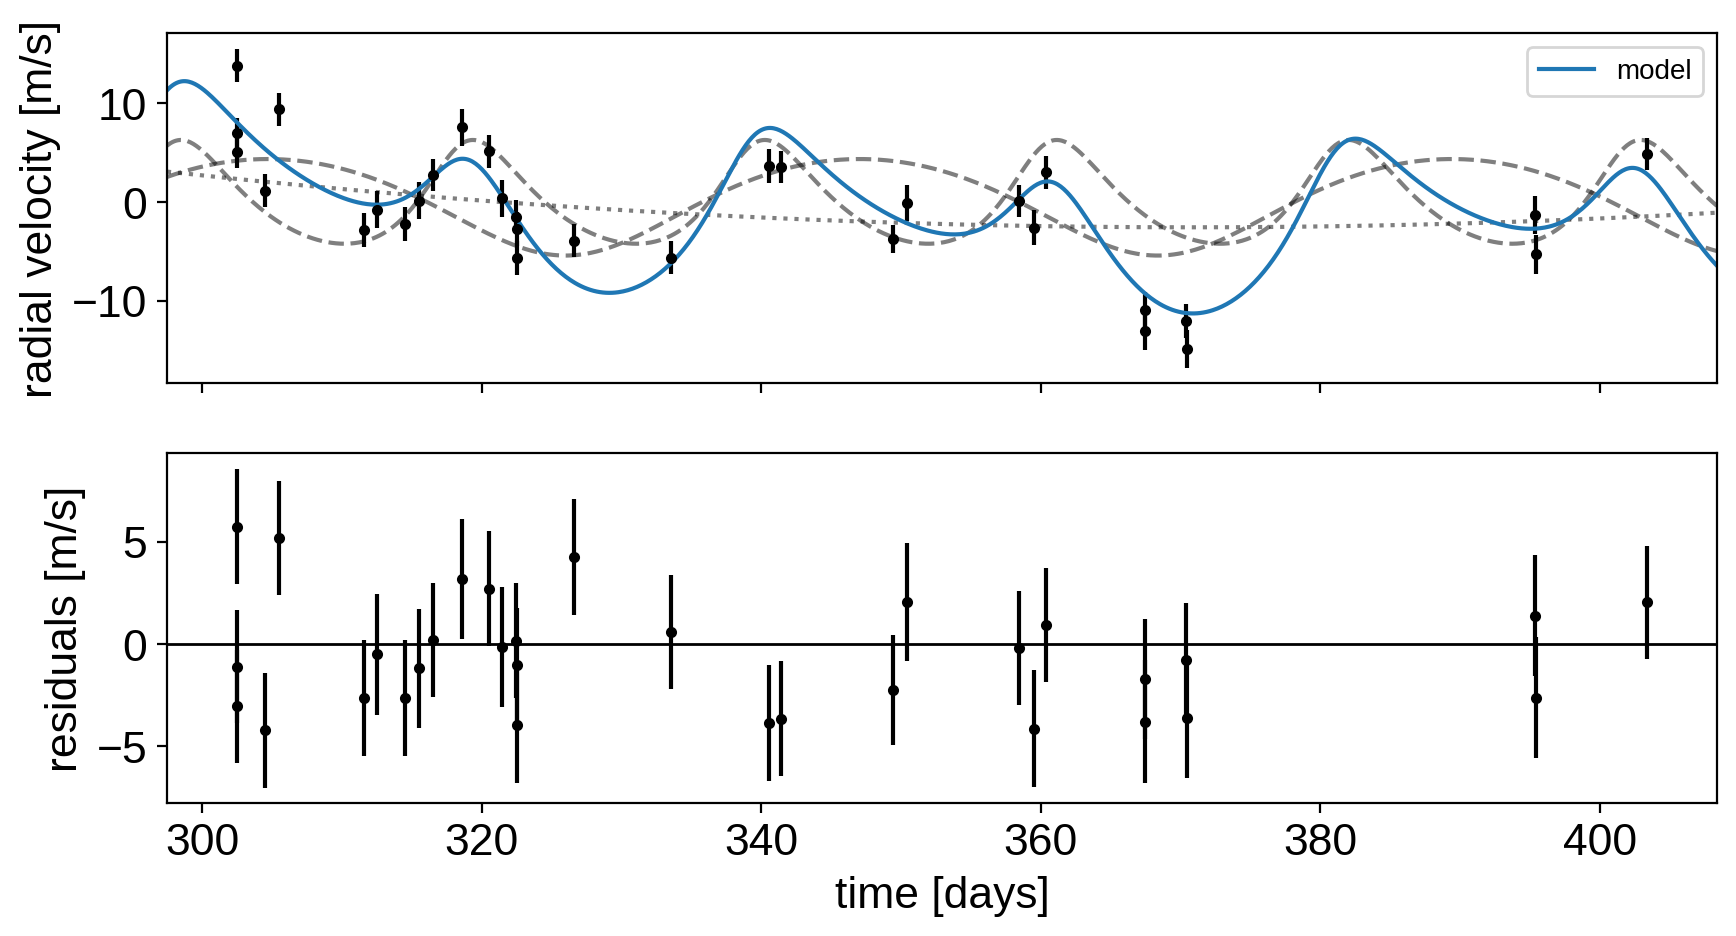

In [10]:
def plot_rv_curve(soln):
    fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

    ax = axes[0]
    ax.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k")
    ax.plot(t_rv, soln["vrad_pred"], "--k", alpha=0.5)
    ax.plot(t_rv, soln["bkg_pred"], ":k", alpha=0.5)
    ax.plot(t_rv, soln["rv_model_pred"], label="model")
    ax.legend(fontsize=10)
    ax.set_ylabel("radial velocity [m/s]")

    ax = axes[1]
    err = np.sqrt(yerr_rv ** 2 + np.exp(2 * soln["logs_rv"]))
    ax.errorbar(x_rv, y_rv - soln["rv_model"], yerr=err, fmt=".k")
    ax.axhline(0, color="k", lw=1)
    ax.set_ylabel("residuals [m/s]")
    ax.set_xlim(t_rv.min(), t_rv.max())
    ax.set_xlabel("time [days]")


plot_rv_curve(map_soln0)

That looks pretty similar to what we got in :ref:`rv`.
Now let's also plot the transit model.

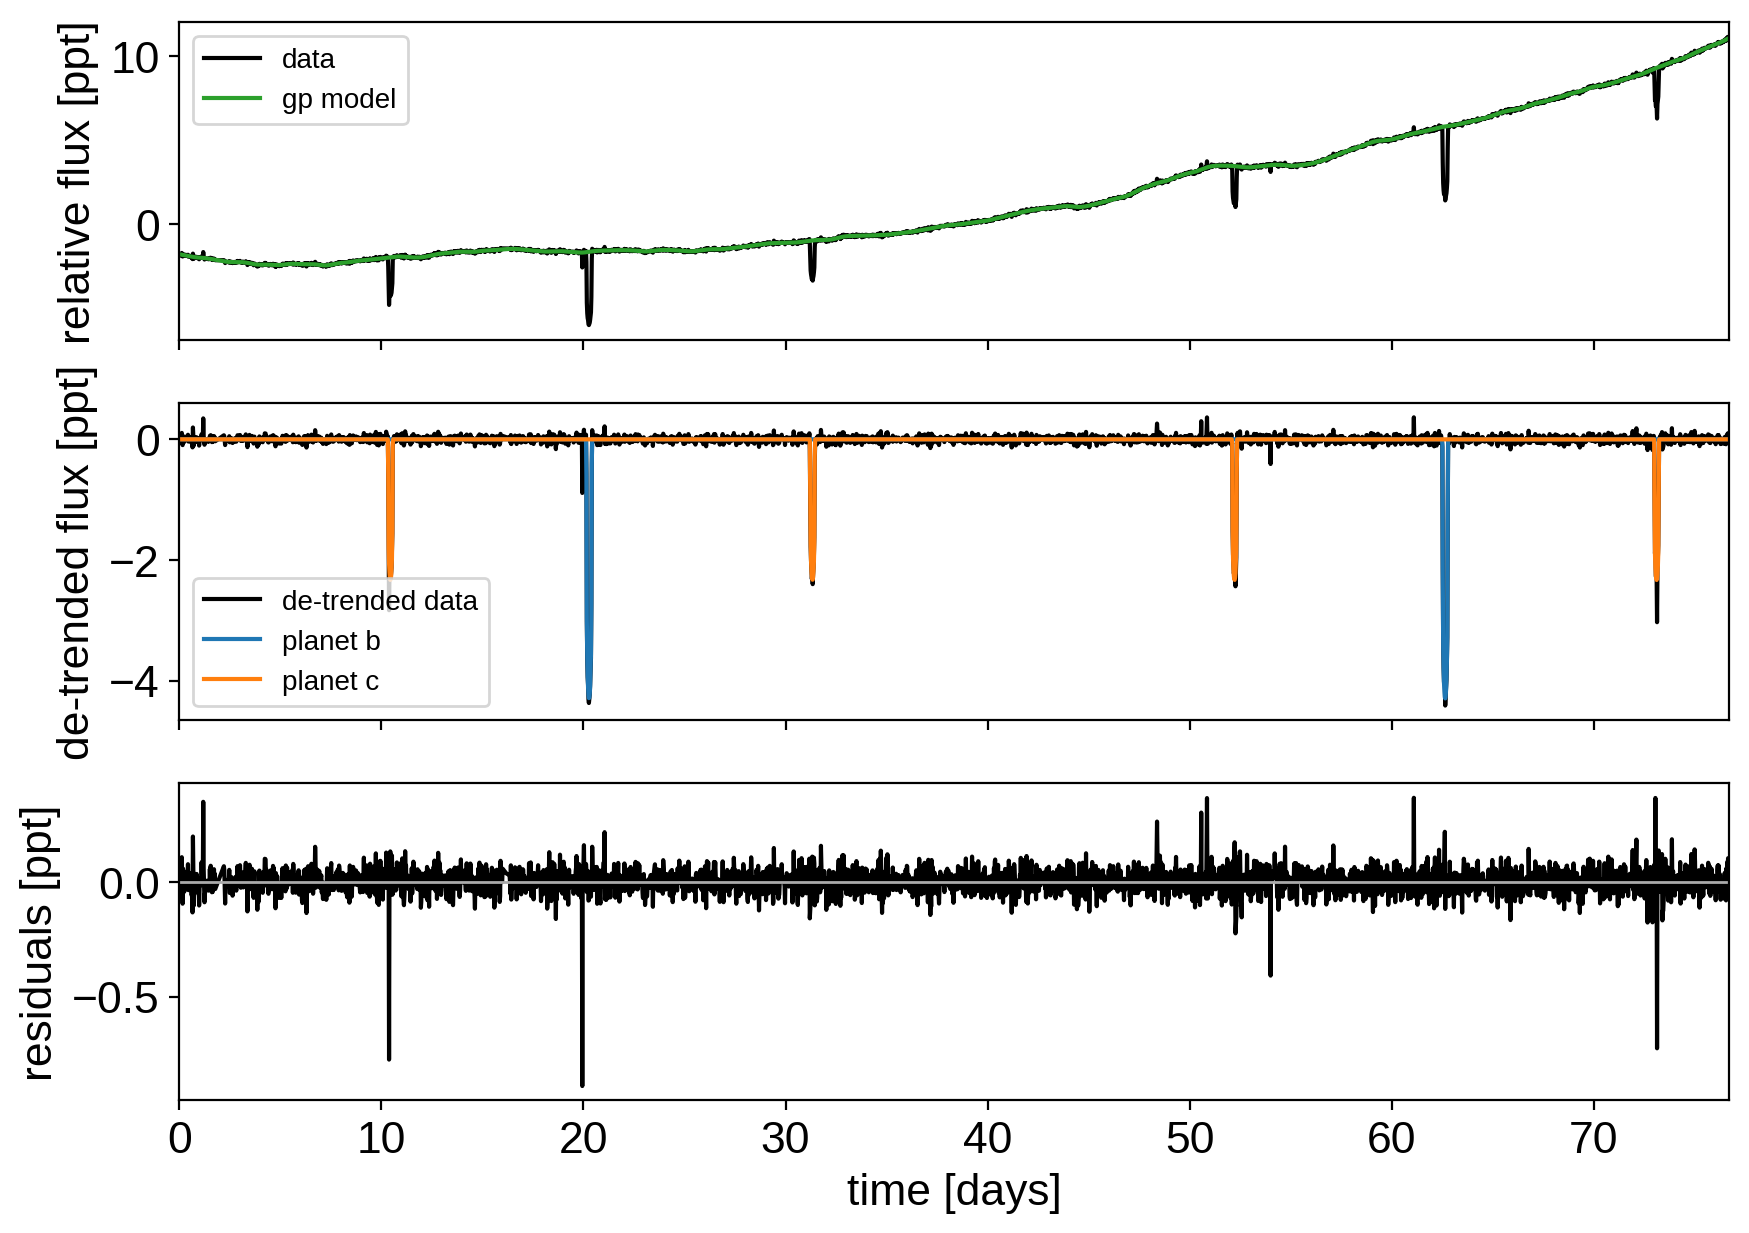

In [11]:
def plot_light_curve(soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = soln["gp_pred"] + soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    for i, l in enumerate("bc"):
        mod = soln["light_curves"][:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(soln["light_curves"], axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")

    return fig


plot_light_curve(map_soln0);

There are still a few outliers in the light curve and it can be useful to remove those before doing the full fit because both the GP and transit parameters can be sensitive to this.

## Sigma clipping

To remove the outliers, we'll look at the empirical RMS of the residuals away from the GP + transit model and remove anything that is more than a 7-sigma outlier.

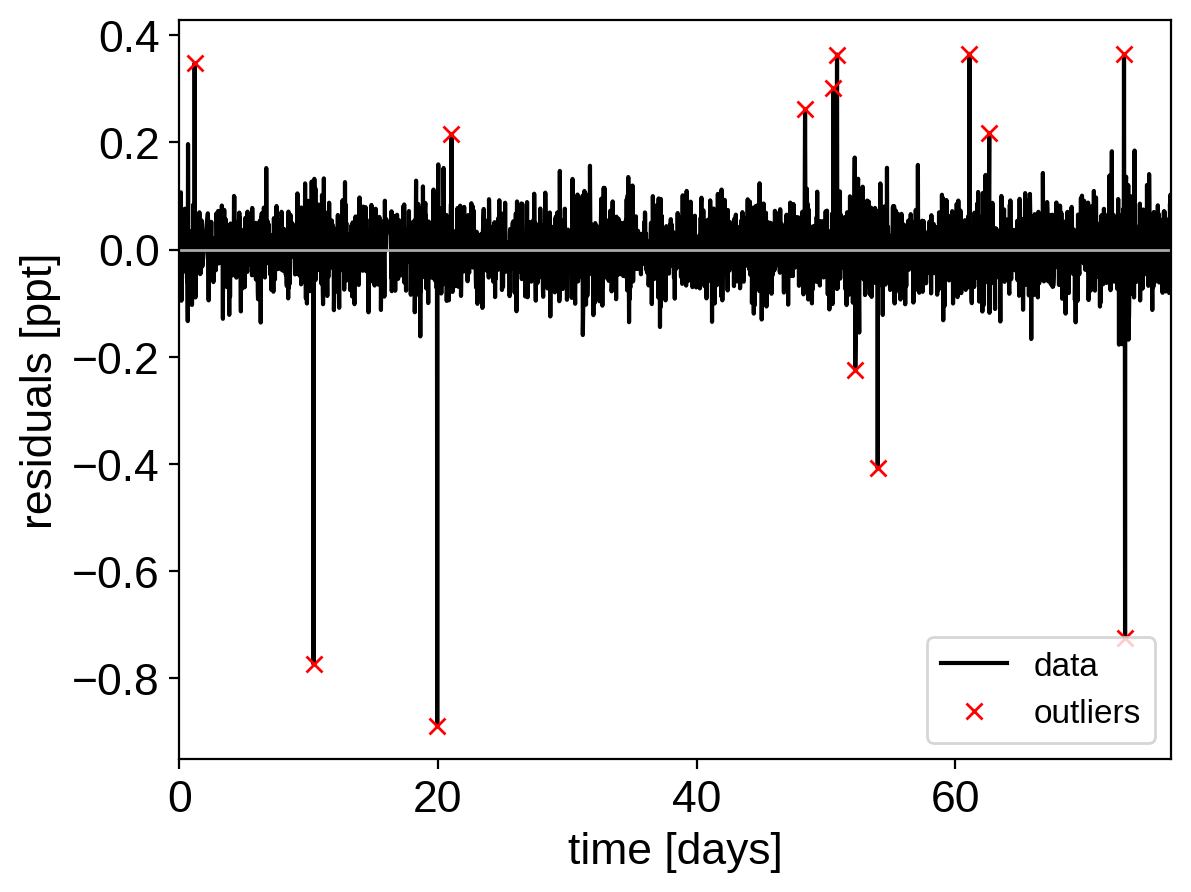

In [12]:
mod = (
    map_soln0["gp_pred"]
    + map_soln0["mean"]
    + np.sum(map_soln0["light_curves"], axis=-1)
)
resid = y - mod
rms = np.sqrt(np.median(resid ** 2))
mask = np.abs(resid) < 7 * rms

plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=4)
plt.xlim(x.min(), x.max());

That looks better. Let's re-build our model with this sigma-clipped dataset.

optimizing logp for variables: [trend]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=5.190546e+03]

1it [00:00, 150.75it/s, logp=5.190546e+03]

2it [00:00, 145.15it/s, logp=5.190546e+03]

3it [00:00, 149.55it/s, logp=5.190017e+03]

4it [00:00, 159.01it/s, logp=5.190546e+03]

5it [00:01,  2.82it/s, logp=5.190546e+03] 


message: Optimization terminated successfully.
logp: 5190.546168423525 -> 5190.546168423525


optimizing logp for variables: [logs2]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=5.190546e+03]

1it [00:00, 109.48it/s, logp=5.190546e+03]

2it [00:00, 126.02it/s, logp=5.190546e+03]

3it [00:00, 138.87it/s, logp=4.802831e+03]

4it [00:00, 147.07it/s, logp=5.272133e+03]

5it [00:00, 159.12it/s, logp=5.272620e+03]

6it [00:00, 168.16it/s, logp=5.272634e+03]

7it [00:00, 178.25it/s, logp=5.272634e+03]

8it [00:00, 187.81it/s, logp=5.272634e+03]

9it [00:01,  6.36it/s, logp=5.272634e+03] 


message: Optimization terminated successfully.
logp: 5190.546168423525 -> 5272.634291509183


optimizing logp for variables: [b, logr, r_star]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=5.272634e+03]

1it [00:00, 181.45it/s, logp=5.272634e+03]

2it [00:00, 243.04it/s, logp=5.272634e+03]

3it [00:00, 263.42it/s, logp=-5.781706e+04]

4it [00:00, 287.16it/s, logp=5.276246e+03] 

5it [00:00, 300.93it/s, logp=5.213164e+03]

6it [00:00, 313.40it/s, logp=5.276443e+03]

7it [00:00, 320.72it/s, logp=5.276637e+03]

8it [00:00, 326.76it/s, logp=5.276927e+03]

9it [00:00, 331.18it/s, logp=5.277528e+03]

10it [00:00, 335.86it/s, logp=5.278995e+03]

11it [00:00, 339.46it/s, logp=5.282047e+03]

12it [00:00, 342.24it/s, logp=5.283161e+03]

13it [00:00, 345.13it/s, logp=5.283545e+03]

14it [00:00, 347.77it/s, logp=5.283586e+03]

15it [00:00, 349.85it/s, logp=5.283602e+03]

16it [00:00, 351.83it/s, logp=5.283607e+03]

17it [00:00, 352.80it/s, logp=5.283608e+03]

18it [00:00, 352.27it/s, logp=5.283608e+03]

19it [00:00, 352.88it/s, logp=5.283608e+03]

20it [00:00, 351.14it/s, logp=5.283608e+03]

21it [00:00, 352.07it/s, logp=5.283608e+03]

22it [00:00, 352.32it/s, logp=5.283608e+03]

23it [00:00, 353.33it/s, logp=5.283608e+03]

24it [00:01, 17.30it/s, logp=5.283608e+03] 


message: Optimization terminated successfully.
logp: 5272.634291509183 -> 5283.607843447559


optimizing logp for variables: [t0, logP]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=5.283608e+03]

1it [00:00, 181.52it/s, logp=5.283608e+03]

2it [00:00, 247.41it/s, logp=5.283608e+03]

3it [00:00, 267.56it/s, logp=-9.246790e+04]

4it [00:00, 282.35it/s, logp=-6.769654e+04]

5it [00:00, 295.32it/s, logp=-7.940048e+04]

6it [00:00, 306.59it/s, logp=-7.198229e+03]

7it [00:00, 315.94it/s, logp=5.283169e+03] 

8it [00:00, 318.72it/s, logp=5.284070e+03]

9it [00:00, 314.56it/s, logp=5.128958e+03]

10it [00:00, 312.16it/s, logp=5.284071e+03]

11it [00:00, 311.49it/s, logp=5.284074e+03]

12it [00:00, 314.23it/s, logp=5.284083e+03]

13it [00:00, 317.18it/s, logp=5.284122e+03]

14it [00:00, 319.40it/s, logp=5.284266e+03]

15it [00:00, 321.95it/s, logp=5.283895e+03]

16it [00:00, 325.02it/s, logp=5.284316e+03]

17it [00:00, 327.78it/s, logp=5.284412e+03]

18it [00:00, 331.00it/s, logp=5.284719e+03]

19it [00:00, 333.47it/s, logp=5.284976e+03]

20it [00:00, 335.27it/s, logp=5.284977e+03]

21it [00:00, 337.00it/s, logp=5.284977e+03]

22it [00:00, 338.63it/s, logp=5.284977e+03]

23it [00:00, 339.57it/s, logp=5.284977e+03]

24it [00:00, 340.54it/s, logp=5.284977e+03]

25it [00:01, 14.44it/s, logp=5.284977e+03] 


message: Optimization terminated successfully.
logp: 5283.607843447555 -> 5284.976985017353


optimizing logp for variables: [logSw4, logs2]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=5.284977e+03]

1it [00:00, 181.21it/s, logp=5.284977e+03]

2it [00:00, 236.75it/s, logp=5.284977e+03]

3it [00:00, 265.94it/s, logp=4.590406e+03]

4it [00:00, 285.45it/s, logp=5.285058e+03]

5it [00:00, 295.97it/s, logp=5.285212e+03]

6it [00:00, 303.32it/s, logp=5.285473e+03]

7it [00:00, 309.92it/s, logp=5.285706e+03]

8it [00:00, 314.20it/s, logp=5.285706e+03]

9it [00:00, 316.45it/s, logp=5.285706e+03]

10it [00:01,  7.31it/s, logp=5.285706e+03]


message: Optimization terminated successfully.
logp: 5284.9769850173525 -> 5285.706049480481


optimizing logp for variables: [logw0]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=5.285706e+03]

1it [00:00, 157.72it/s, logp=5.285706e+03]

2it [00:00, 209.20it/s, logp=5.285706e+03]

3it [00:00, 237.50it/s, logp=5.250796e+03]

4it [00:00, 258.54it/s, logp=5.285593e+03]

5it [00:00, 273.95it/s, logp=5.285740e+03]

6it [00:00, 281.29it/s, logp=5.285740e+03]

7it [00:00, 288.94it/s, logp=5.285740e+03]

8it [00:00, 293.21it/s, logp=5.285740e+03]

9it [00:01,  5.02it/s, logp=5.285740e+03] 


message: Optimization terminated successfully.
logp: 5285.706049480481 -> 5285.740125801302


optimizing logp for variables: [logSw4, logw0, logs2, trend, logs_rv, ecc_prior_beta, ecc_prior_alpha, ecs, b, logr, t0, logP, logm, r_star, m_star, u_star, mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=5.285740e+03]

1it [00:00, 135.71it/s, logp=5.285740e+03]

2it [00:00, 180.17it/s, logp=5.285740e+03]

3it [00:00, 194.79it/s, logp=-1.181504e+05]

4it [00:00, 210.41it/s, logp=-6.207817e+04]

5it [00:00, 220.37it/s, logp=4.751930e+03] 

6it [00:00, 225.89it/s, logp=5.285740e+03]

7it [00:00, 228.75it/s, logp=5.285714e+03]

8it [00:00, 233.69it/s, logp=5.285740e+03]

9it [00:00, 234.23it/s, logp=5.285740e+03]

10it [00:00, 237.53it/s, logp=5.285740e+03]

11it [00:00, 236.25it/s, logp=5.285740e+03]

12it [00:00, 234.07it/s, logp=5.285740e+03]

13it [00:00, 229.19it/s, logp=5.285741e+03]

14it [00:00, 227.69it/s, logp=5.285741e+03]

15it [00:00, 226.57it/s, logp=5.285744e+03]

16it [00:00, 223.72it/s, logp=5.285737e+03]

17it [00:00, 222.25it/s, logp=5.285745e+03]

18it [00:00, 219.55it/s, logp=5.285747e+03]

19it [00:00, 217.43it/s, logp=5.285743e+03]

20it [00:00, 218.40it/s, logp=5.285748e+03]

21it [00:00, 219.01it/s, logp=5.285748e+03]

22it [00:00, 221.44it/s, logp=5.285751e+03]

23it [00:00, 221.97it/s, logp=5.285756e+03]

24it [00:00, 230.13it/s, logp=5.285756e+03]

24it [00:00, 230.13it/s, logp=5.285767e+03]

25it [00:00, 230.13it/s, logp=5.285805e+03]

26it [00:00, 230.13it/s, logp=5.285867e+03]

27it [00:00, 230.13it/s, logp=5.285987e+03]

28it [00:00, 230.13it/s, logp=5.286375e+03]

29it [00:00, 230.13it/s, logp=5.271088e+03]

30it [00:00, 230.13it/s, logp=5.286391e+03]

31it [00:00, 230.13it/s, logp=5.286420e+03]

32it [00:00, 230.13it/s, logp=5.286464e+03]

33it [00:00, 230.13it/s, logp=5.286546e+03]

34it [00:00, 230.13it/s, logp=5.286662e+03]

35it [00:00, 230.13it/s, logp=5.286779e+03]

36it [00:00, 230.13it/s, logp=5.286744e+03]

37it [00:00, 230.13it/s, logp=5.286830e+03]

38it [00:00, 230.13it/s, logp=5.286908e+03]

39it [00:00, 230.13it/s, logp=5.286964e+03]

40it [00:00, 230.13it/s, logp=5.287042e+03]

41it [00:00, 230.13it/s, logp=5.287036e+03]

42it [00:00, 230.13it/s, logp=5.287079e+03]

43it [00:00, 230.13it/s, logp=5.287118e+03]

44it [00:00, 219.23it/s, logp=5.287118e+03]

44it [00:00, 219.23it/s, logp=5.287180e+03]

45it [00:00, 219.23it/s, logp=5.287262e+03]

46it [00:00, 219.23it/s, logp=5.287088e+03]

47it [00:00, 219.23it/s, logp=5.287283e+03]

48it [00:00, 219.23it/s, logp=5.287301e+03]

49it [00:00, 219.23it/s, logp=5.287329e+03]

50it [00:00, 219.23it/s, logp=5.287360e+03]

51it [00:00, 219.23it/s, logp=5.287366e+03]

52it [00:00, 219.23it/s, logp=5.287370e+03]

53it [00:00, 219.23it/s, logp=5.287380e+03]

54it [00:00, 219.23it/s, logp=5.287358e+03]

55it [00:00, 219.23it/s, logp=5.287393e+03]

56it [00:00, 219.23it/s, logp=5.287226e+03]

57it [00:00, 219.23it/s, logp=5.287395e+03]

58it [00:00, 219.23it/s, logp=5.287401e+03]

59it [00:00, 219.23it/s, logp=5.287416e+03]

60it [00:00, 219.23it/s, logp=5.287458e+03]

61it [00:00, 219.23it/s, logp=5.287476e+03]

62it [00:00, 219.23it/s, logp=5.287488e+03]

63it [00:00, 207.86it/s, logp=5.287488e+03]

63it [00:00, 207.86it/s, logp=5.287531e+03]

64it [00:00, 207.86it/s, logp=5.287587e+03]

65it [00:00, 207.86it/s, logp=5.287627e+03]

66it [00:00, 207.86it/s, logp=5.287609e+03]

67it [00:00, 207.86it/s, logp=5.287644e+03]

68it [00:00, 207.86it/s, logp=5.287653e+03]

69it [00:00, 207.86it/s, logp=5.287655e+03]

70it [00:00, 207.86it/s, logp=5.287657e+03]

71it [00:00, 207.86it/s, logp=5.287659e+03]

72it [00:00, 207.86it/s, logp=5.287659e+03]

73it [00:00, 207.86it/s, logp=5.287660e+03]

74it [00:00, 207.86it/s, logp=5.287661e+03]

75it [00:00, 207.86it/s, logp=5.287662e+03]

76it [00:00, 207.86it/s, logp=5.287663e+03]

77it [00:00, 207.86it/s, logp=5.287665e+03]

78it [00:00, 207.86it/s, logp=5.287666e+03]

79it [00:00, 207.86it/s, logp=5.287666e+03]

80it [00:00, 194.20it/s, logp=5.287666e+03]

80it [00:00, 194.20it/s, logp=5.287667e+03]

81it [00:00, 194.20it/s, logp=5.287667e+03]

82it [00:00, 194.20it/s, logp=5.287667e+03]

83it [00:00, 194.20it/s, logp=5.287667e+03]

84it [00:00, 194.20it/s, logp=5.287667e+03]

85it [00:00, 194.20it/s, logp=5.287667e+03]

86it [00:00, 194.20it/s, logp=5.287667e+03]

87it [00:00, 194.20it/s, logp=5.287667e+03]

88it [00:00, 194.20it/s, logp=5.287667e+03]

89it [00:00, 194.20it/s, logp=5.287667e+03]

90it [00:00, 194.20it/s, logp=5.287667e+03]

91it [00:00, 194.20it/s, logp=5.287667e+03]

92it [00:00, 194.20it/s, logp=5.287667e+03]

93it [00:00, 194.20it/s, logp=5.287667e+03]

94it [00:00, 194.20it/s, logp=5.287667e+03]

95it [00:00, 194.20it/s, logp=5.287667e+03]

96it [00:00, 194.20it/s, logp=5.287667e+03]

97it [00:00, 194.20it/s, logp=5.287667e+03]

98it [00:00, 194.20it/s, logp=5.287667e+03]

99it [00:00, 194.20it/s, logp=5.287667e+03]

100it [00:00, 194.20it/s, logp=5.287667e+03]

101it [00:00, 194.20it/s, logp=5.287667e+03]

102it [00:00, 194.20it/s, logp=5.287667e+03]

103it [00:00, 194.20it/s, logp=5.287667e+03]

104it [00:00, 194.20it/s, logp=5.287667e+03]

105it [00:00, 194.20it/s, logp=5.287667e+03]

106it [00:00, 208.29it/s, logp=5.287667e+03]

106it [00:00, 208.29it/s, logp=5.287667e+03]

107it [00:00, 208.29it/s, logp=5.287667e+03]

108it [00:00, 208.29it/s, logp=5.287667e+03]

109it [00:00, 208.29it/s, logp=5.287667e+03]

110it [00:00, 208.29it/s, logp=5.287667e+03]

111it [00:00, 208.29it/s, logp=5.287667e+03]

112it [00:00, 208.29it/s, logp=5.287667e+03]

113it [00:00, 208.29it/s, logp=5.287667e+03]

114it [00:00, 208.29it/s, logp=5.287667e+03]

115it [00:00, 208.29it/s, logp=5.287667e+03]

116it [00:00, 208.29it/s, logp=5.287667e+03]

117it [00:00, 208.29it/s, logp=5.287667e+03]

118it [00:00, 208.29it/s, logp=5.287667e+03]

119it [00:00, 208.29it/s, logp=5.287667e+03]

120it [00:00, 208.29it/s, logp=5.287667e+03]

121it [00:00, 208.29it/s, logp=5.287667e+03]

122it [00:00, 208.29it/s, logp=5.287667e+03]

123it [00:00, 208.29it/s, logp=5.287667e+03]

124it [00:00, 208.29it/s, logp=5.287667e+03]

125it [00:00, 208.29it/s, logp=5.287667e+03]

126it [00:00, 208.29it/s, logp=5.287667e+03]

127it [00:00, 208.29it/s, logp=5.287667e+03]

128it [00:00, 208.29it/s, logp=5.287667e+03]

129it [00:00, 212.12it/s, logp=5.287667e+03]

129it [00:00, 212.12it/s, logp=5.287667e+03]

130it [00:00, 212.12it/s, logp=5.287667e+03]

131it [00:00, 212.12it/s, logp=5.287667e+03]

132it [00:00, 212.12it/s, logp=5.287667e+03]

133it [00:00, 212.12it/s, logp=5.287667e+03]

134it [00:00, 212.12it/s, logp=5.287667e+03]

135it [00:00, 212.12it/s, logp=5.287667e+03]

136it [00:00, 212.12it/s, logp=5.287667e+03]

137it [00:00, 212.12it/s, logp=5.287667e+03]

138it [00:00, 212.12it/s, logp=5.287667e+03]

139it [00:00, 212.12it/s, logp=5.287667e+03]

140it [00:00, 212.12it/s, logp=5.287667e+03]

141it [00:00, 212.12it/s, logp=5.287667e+03]

142it [00:00, 212.12it/s, logp=5.287667e+03]

143it [00:00, 212.12it/s, logp=5.287667e+03]

144it [00:00, 212.12it/s, logp=5.287667e+03]

145it [00:00, 212.12it/s, logp=5.287667e+03]

146it [00:00, 212.12it/s, logp=5.287667e+03]

147it [00:00, 212.12it/s, logp=5.287667e+03]

148it [00:00, 212.12it/s, logp=5.287667e+03]

149it [00:00, 212.12it/s, logp=5.287667e+03]

150it [00:00, 212.12it/s, logp=5.287667e+03]

151it [00:00, 212.12it/s, logp=5.287667e+03]

152it [00:00, 212.12it/s, logp=5.287667e+03]

153it [00:00, 212.12it/s, logp=5.287667e+03]

154it [00:00, 212.12it/s, logp=5.287667e+03]

155it [00:00, 212.12it/s, logp=5.287667e+03]

156it [00:00, 225.86it/s, logp=5.287667e+03]

156it [00:00, 225.86it/s, logp=5.287667e+03]

157it [00:00, 225.86it/s, logp=5.287667e+03]

158it [00:00, 225.86it/s, logp=5.287667e+03]

159it [00:00, 225.86it/s, logp=5.287667e+03]

160it [00:00, 225.86it/s, logp=5.287667e+03]

161it [00:00, 225.86it/s, logp=5.287667e+03]

162it [00:00, 225.86it/s, logp=5.287667e+03]

163it [00:00, 225.86it/s, logp=5.287667e+03]

164it [00:00, 225.86it/s, logp=5.287667e+03]

165it [00:00, 225.86it/s, logp=5.287667e+03]

166it [00:00, 225.86it/s, logp=5.287667e+03]

167it [00:00, 225.86it/s, logp=5.287667e+03]

168it [00:00, 225.86it/s, logp=5.287667e+03]

169it [00:00, 225.86it/s, logp=5.287667e+03]

170it [00:00, 225.86it/s, logp=5.287667e+03]

171it [00:00, 225.86it/s, logp=5.287667e+03]

172it [00:00, 225.86it/s, logp=5.287667e+03]

173it [00:00, 225.86it/s, logp=5.287667e+03]

174it [00:00, 225.86it/s, logp=5.287667e+03]

175it [00:00, 225.86it/s, logp=5.287667e+03]

176it [00:00, 225.86it/s, logp=5.287667e+03]

177it [00:00, 225.86it/s, logp=5.287667e+03]

178it [00:00, 225.86it/s, logp=5.287667e+03]

179it [00:00, 225.86it/s, logp=5.287667e+03]

180it [00:00, 225.86it/s, logp=5.287667e+03]

181it [00:00, 225.86it/s, logp=5.287667e+03]

182it [00:00, 235.01it/s, logp=5.287667e+03]

182it [00:00, 235.01it/s, logp=5.287667e+03]

183it [00:00, 235.01it/s, logp=5.287667e+03]

184it [00:00, 235.01it/s, logp=5.287667e+03]

185it [00:00, 235.01it/s, logp=5.287667e+03]

186it [00:00, 235.01it/s, logp=5.287667e+03]

187it [00:00, 235.01it/s, logp=5.287667e+03]

188it [00:00, 235.01it/s, logp=5.287667e+03]

189it [00:00, 235.01it/s, logp=5.287667e+03]

190it [00:00, 235.01it/s, logp=5.287667e+03]

191it [00:00, 235.01it/s, logp=5.287667e+03]

192it [00:00, 235.01it/s, logp=5.287667e+03]

193it [00:00, 235.01it/s, logp=5.287667e+03]

194it [00:00, 235.01it/s, logp=5.287667e+03]

195it [00:00, 235.01it/s, logp=5.287667e+03]

196it [00:00, 235.01it/s, logp=5.287667e+03]

197it [00:00, 235.01it/s, logp=5.287667e+03]

198it [00:00, 235.01it/s, logp=5.287667e+03]

199it [00:00, 235.01it/s, logp=5.287667e+03]

200it [00:00, 235.01it/s, logp=5.287667e+03]

201it [00:00, 235.01it/s, logp=5.287667e+03]

202it [00:00, 235.01it/s, logp=5.287667e+03]

203it [00:00, 235.01it/s, logp=5.287667e+03]

204it [00:00, 235.01it/s, logp=5.287667e+03]

205it [00:00, 235.01it/s, logp=5.287667e+03]

206it [00:00, 235.01it/s, logp=5.287667e+03]

207it [00:00, 235.01it/s, logp=5.287667e+03]

208it [00:00, 235.01it/s, logp=5.287667e+03]

209it [00:00, 235.01it/s, logp=5.287667e+03]

210it [00:00, 245.46it/s, logp=5.287667e+03]

210it [00:00, 245.46it/s, logp=5.287667e+03]

211it [00:00, 245.46it/s, logp=5.287667e+03]

212it [00:00, 245.46it/s, logp=5.287667e+03]

213it [00:00, 245.46it/s, logp=5.287667e+03]

214it [00:00, 245.46it/s, logp=5.287667e+03]

215it [00:00, 245.46it/s, logp=5.287667e+03]

216it [00:00, 245.46it/s, logp=5.287667e+03]

217it [00:00, 245.46it/s, logp=5.287667e+03]

218it [00:00, 245.46it/s, logp=5.287667e+03]

219it [00:00, 245.46it/s, logp=5.287667e+03]

220it [00:00, 245.46it/s, logp=5.287667e+03]

221it [00:00, 245.46it/s, logp=5.287667e+03]

222it [00:00, 245.46it/s, logp=5.287667e+03]

223it [00:00, 245.46it/s, logp=5.287667e+03]

224it [00:02, 83.87it/s, logp=5.287667e+03] 


message: Desired error not necessarily achieved due to precision loss.
logp: 5285.740125801294 -> 5287.666819263983


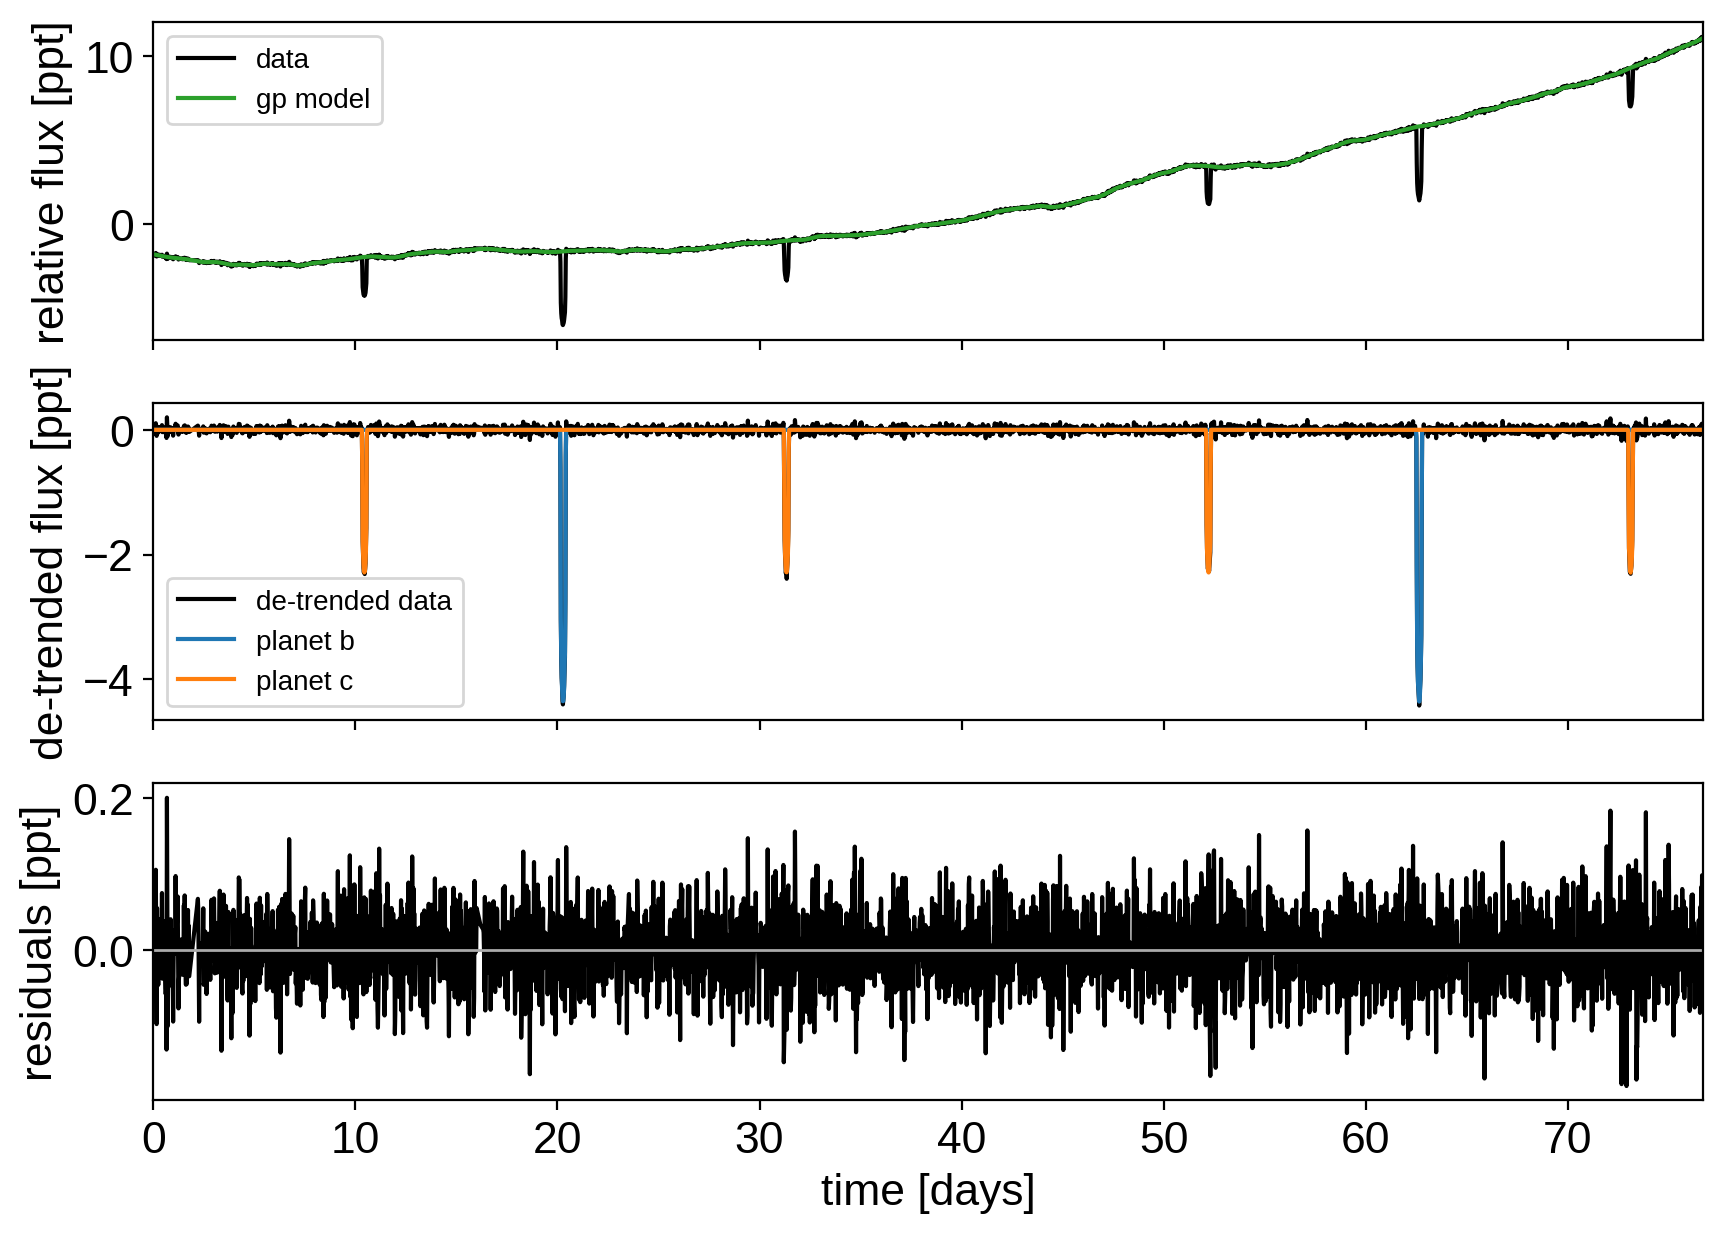

In [13]:
model, map_soln = build_model(mask, map_soln0)
plot_light_curve(map_soln, mask);

Great! Now we're ready to sample.

## Sampling

The sampling for this model is the same as for all the previous tutorials, but it takes a bit longer (about 2 hours on my laptop).
This is partly because the model is more expensive to compute than the previous ones and partly because there are some non-affine degeneracies in the problem (for example between impact parameter and eccentricity).
It might be worth thinking about reparameterizations (in terms of duration instead of eccentricity), but that's beyond the scope of this tutorial.
Besides, using more traditional MCMC methods, this would have taken a lot more than 2 hours to get >1000 effective samples!

In [14]:
np.random.seed(203771098)
with model:
    trace = pm.sample(
        tune=3500,
        draws=3000,
        start=map_soln,
        chains=4,
        step=xo.get_dense_nuts_step(target_accept=0.95),
    )

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [logSw4, logw0, logs2, trend, logs_rv, ecc_prior_beta, ecc_prior_alpha, ecs, b, logr, t0, logP, logm, r_star, m_star, u_star, mean]


Sampling 4 chains, 0 divergences:   0%|          | 0/26000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 20/26000 [00:00<02:13, 194.69draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 26/26000 [00:01<29:54, 14.47draws/s] 

Sampling 4 chains, 0 divergences:   0%|          | 31/26000 [00:02<40:12, 10.76draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 35/26000 [00:02<50:19,  8.60draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 38/26000 [00:03<1:01:28,  7.04draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 40/26000 [00:03<50:52,  8.50draws/s]  

Sampling 4 chains, 0 divergences:   0%|          | 42/26000 [00:04<1:12:14,  5.99draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 44/26000 [00:04<58:01,  7.46draws/s]  

Sampling 4 chains, 0 divergences:   0%|          | 46/26000 [00:04<1:16:10,  5.68draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 48/26000 [00:04<1:01:38,  7.02draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 50/26000 [00:05<1:18:12,  5.53draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 52/26000 [00:05<1:02:43,  6.90draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 54/26000 [00:06<1:19:19,  5.45draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 56/26000 [00:06<1:04:21,  6.72draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 58/26000 [00:06<1:19:04,  5.47draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 60/26000 [00:06<1:06:17,  6.52draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 61/26000 [00:07<1:36:09,  4.50draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 62/26000 [00:07<1:25:41,  5.05draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 64/26000 [00:07<1:09:13,  6.24draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 65/26000 [00:08<1:36:44,  4.47draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 66/26000 [00:08<1:29:45,  4.82draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 68/26000 [00:08<1:13:02,  5.92draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 69/26000 [00:08<1:32:54,  4.65draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 70/26000 [00:08<1:34:19,  4.58draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 72/26000 [00:09<1:16:18,  5.66draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 73/26000 [00:09<1:28:07,  4.90draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 74/26000 [00:09<1:31:12,  4.74draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 76/26000 [00:09<1:18:28,  5.51draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 77/26000 [00:09<1:19:24,  5.44draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 78/26000 [00:10<1:26:00,  5.02draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 80/26000 [00:10<1:19:44,  5.42draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 81/26000 [00:10<1:11:34,  6.04draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 82/26000 [00:10<1:21:01,  5.33draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 84/26000 [00:11<1:17:31,  5.57draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 86/26000 [00:11<1:16:19,  5.66draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 88/26000 [00:11<1:15:49,  5.70draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 90/26000 [00:12<1:13:27,  5.88draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 92/26000 [00:12<1:14:33,  5.79draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 94/26000 [00:12<1:11:12,  6.06draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 96/26000 [00:13<1:15:43,  5.70draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 98/26000 [00:13<1:09:37,  6.20draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 100/26000 [00:13<1:15:03,  5.75draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 102/26000 [00:14<1:08:15,  6.32draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 104/26000 [00:14<1:13:49,  5.85draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 105/26000 [00:14<1:09:10,  6.24draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 106/26000 [00:14<1:03:03,  6.84draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 108/26000 [00:15<1:09:52,  6.18draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 109/26000 [00:15<1:17:13,  5.59draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 111/26000 [00:15<1:01:17,  7.04draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 112/26000 [00:15<1:24:44,  5.09draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 113/26000 [00:16<1:30:36,  4.76draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 116/26000 [00:16<1:20:54,  5.33draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 117/26000 [00:16<1:32:37,  4.66draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 120/26000 [00:17<1:21:04,  5.32draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 121/26000 [00:17<1:38:30,  4.38draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 124/26000 [00:17<1:22:16,  5.24draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 125/26000 [00:18<1:45:19,  4.09draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 128/26000 [00:18<1:25:25,  5.05draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 129/26000 [00:18<1:49:19,  3.94draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 131/26000 [00:18<1:23:47,  5.15draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 132/26000 [00:19<1:18:58,  5.46draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 133/26000 [00:19<1:46:30,  4.05draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 135/26000 [00:19<1:23:00,  5.19draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 136/26000 [00:19<1:14:24,  5.79draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 137/26000 [00:20<1:44:53,  4.11draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 138/26000 [00:20<1:28:05,  4.89draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 140/26000 [00:20<1:09:44,  6.18draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 142/26000 [00:20<1:25:14,  5.06draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 145/26000 [00:21<1:21:32,  5.29draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 146/26000 [00:21<1:16:10,  5.66draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 148/26000 [00:21<1:00:38,  7.11draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 150/26000 [00:22<1:21:15,  5.30draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 152/26000 [00:22<1:03:56,  6.74draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 154/26000 [00:22<1:19:40,  5.41draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 156/26000 [00:23<1:07:41,  6.36draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 157/26000 [00:23<1:21:19,  5.30draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 158/26000 [00:23<1:23:04,  5.18draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 160/26000 [00:23<1:14:31,  5.78draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 161/26000 [00:24<1:18:12,  5.51draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 162/26000 [00:24<1:21:04,  5.31draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 164/26000 [00:24<1:14:57,  5.74draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 165/26000 [00:24<1:15:26,  5.71draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 166/26000 [00:24<1:16:55,  5.60draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 168/26000 [00:25<1:16:05,  5.66draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 169/26000 [00:25<1:09:42,  6.18draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 170/26000 [00:25<1:12:40,  5.92draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 172/26000 [00:25<1:14:30,  5.78draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 173/26000 [00:26<1:06:52,  6.44draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 174/26000 [00:26<1:08:32,  6.28draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 176/26000 [00:26<1:15:16,  5.72draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 178/26000 [00:26<1:07:13,  6.40draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 180/26000 [00:27<1:16:39,  5.61draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 182/26000 [00:27<1:05:51,  6.53draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 184/26000 [00:27<1:18:04,  5.51draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 186/26000 [00:28<1:04:32,  6.67draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 188/26000 [00:28<1:17:30,  5.55draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 190/26000 [00:28<1:03:43,  6.75draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 192/26000 [00:29<1:17:21,  5.56draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 193/26000 [00:29<1:10:27,  6.11draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 196/26000 [00:29<1:12:03,  5.97draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 197/26000 [00:30<1:06:43,  6.44draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 200/26000 [00:30<1:09:24,  6.20draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 201/26000 [00:30<1:03:51,  6.73draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 203/26000 [00:30<53:01,  8.11draws/s]  

Sampling 4 chains, 0 divergences:   1%|          | 204/26000 [00:31<1:29:18,  4.81draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 205/26000 [00:31<1:16:44,  5.60draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 207/26000 [00:31<1:06:44,  6.44draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 208/26000 [00:31<1:30:10,  4.77draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 209/26000 [00:32<1:16:34,  5.61draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 211/26000 [00:32<1:12:02,  5.97draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 212/26000 [00:32<1:23:48,  5.13draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 214/26000 [00:32<1:09:14,  6.21draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 215/26000 [00:33<1:25:06,  5.05draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 216/26000 [00:33<1:26:14,  4.98draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 218/26000 [00:33<1:10:59,  6.05draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 219/26000 [00:33<1:31:38,  4.69draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 220/26000 [00:33<1:25:24,  5.03draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 221/26000 [00:33<1:12:49,  5.90draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 223/26000 [00:34<1:22:56,  5.18draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 225/26000 [00:34<1:07:36,  6.35draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 227/26000 [00:35<1:24:06,  5.11draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 230/26000 [00:35<1:05:02,  6.60draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 232/26000 [00:35<1:20:23,  5.34draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 234/26000 [00:35<1:03:13,  6.79draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 236/26000 [00:36<1:21:08,  5.29draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 239/26000 [00:37<1:22:44,  5.19draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 241/26000 [00:37<1:04:48,  6.62draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 243/26000 [00:37<1:20:33,  5.33draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 245/26000 [00:37<1:04:32,  6.65draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 247/26000 [00:38<1:19:02,  5.43draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 249/26000 [00:38<1:03:26,  6.76draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 251/26000 [00:39<1:18:23,  5.47draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 253/26000 [00:39<1:02:40,  6.85draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 255/26000 [00:39<1:18:39,  5.46draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 257/26000 [00:39<1:02:01,  6.92draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 259/26000 [00:40<1:18:09,  5.49draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 261/26000 [00:40<1:01:51,  6.93draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 263/26000 [00:41<1:17:37,  5.53draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 265/26000 [00:41<1:01:54,  6.93draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 267/26000 [00:41<1:17:21,  5.54draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 269/26000 [00:41<1:01:55,  6.92draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 271/26000 [00:42<1:17:19,  5.55draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 273/26000 [00:42<1:01:46,  6.94draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 275/26000 [00:43<1:20:39,  5.32draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 278/26000 [00:43<1:22:00,  5.23draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 280/26000 [00:43<1:04:48,  6.61draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 282/26000 [00:44<1:20:45,  5.31draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 284/26000 [00:44<1:03:05,  6.79draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 286/26000 [00:44<1:19:10,  5.41draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 288/26000 [00:45<1:02:07,  6.90draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 290/26000 [00:45<1:17:56,  5.50draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 291/26000 [00:45<1:08:25,  6.26draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 293/26000 [00:45<1:00:21,  7.10draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 294/26000 [00:46<1:26:43,  4.94draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 295/26000 [00:46<1:15:35,  5.67draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 297/26000 [00:46<1:08:21,  6.27draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 298/26000 [00:46<1:25:47,  4.99draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 299/26000 [00:47<1:15:54,  5.64draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 301/26000 [00:47<1:10:47,  6.05draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 302/26000 [00:47<1:22:01,  5.22draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 303/26000 [00:47<1:13:31,  5.83draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 305/26000 [00:48<1:12:39,  5.89draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 306/26000 [00:48<1:15:31,  5.67draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 307/26000 [00:48<1:09:38,  6.15draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 309/26000 [00:48<1:14:15,  5.77draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 310/26000 [00:48<1:07:30,  6.34draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 311/26000 [00:48<1:04:27,  6.64draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 313/26000 [00:49<1:13:16,  5.84draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 315/26000 [00:49<1:04:57,  6.59draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 317/26000 [00:50<1:18:05,  5.48draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 319/26000 [00:50<1:03:20,  6.76draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 321/26000 [00:50<1:17:11,  5.54draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 323/26000 [00:50<1:03:09,  6.78draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 325/26000 [00:51<1:16:44,  5.58draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 327/26000 [00:51<1:03:01,  6.79draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 329/26000 [00:52<1:16:35,  5.59draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 331/26000 [00:52<1:02:53,  6.80draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 333/26000 [00:52<1:15:55,  5.63draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 334/26000 [00:52<1:13:06,  5.85draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 337/26000 [00:53<1:12:11,  5.92draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 338/26000 [00:53<1:11:23,  5.99draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 340/26000 [00:53<57:21,  7.46draws/s]  

Sampling 4 chains, 0 divergences:   1%|▏         | 341/26000 [00:54<1:27:33,  4.88draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 342/26000 [00:54<1:22:41,  5.17draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 344/26000 [00:54<1:11:40,  5.97draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 345/26000 [00:54<1:23:43,  5.11draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 346/26000 [00:54<1:20:28,  5.31draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 348/26000 [00:55<1:17:13,  5.54draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 349/26000 [00:55<1:17:53,  5.49draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 350/26000 [00:55<1:11:55,  5.94draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 352/26000 [00:55<1:18:37,  5.44draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 354/26000 [00:56<1:10:53,  6.03draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 356/26000 [00:56<1:21:29,  5.25draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 358/26000 [00:56<1:08:00,  6.28draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 360/26000 [00:57<1:20:27,  5.31draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 362/26000 [00:57<1:06:22,  6.44draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 364/26000 [00:58<1:19:59,  5.34draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 365/26000 [00:58<1:11:30,  5.97draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 368/26000 [00:58<1:13:14,  5.83draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 369/26000 [00:58<1:14:00,  5.77draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 372/26000 [00:59<1:12:35,  5.88draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 373/26000 [00:59<1:14:18,  5.75draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 376/26000 [01:00<1:12:30,  5.89draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 377/26000 [01:00<1:15:33,  5.65draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 379/26000 [01:00<1:03:59,  6.67draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 380/26000 [01:00<1:23:11,  5.13draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 381/26000 [01:00<1:23:10,  5.13draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 383/26000 [01:01<1:14:06,  5.76draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 384/26000 [01:01<1:20:12,  5.32draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 385/26000 [01:01<1:21:28,  5.24draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 387/26000 [01:01<1:17:41,  5.49draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 388/26000 [01:02<1:12:49,  5.86draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 389/26000 [01:02<1:15:41,  5.64draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 391/26000 [01:02<1:19:01,  5.40draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 393/26000 [01:02<1:11:39,  5.96draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 395/26000 [01:03<1:20:26,  5.31draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 397/26000 [01:03<1:08:21,  6.24draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 399/26000 [01:04<1:18:25,  5.44draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 401/26000 [01:04<1:06:49,  6.38draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 403/26000 [01:04<1:17:13,  5.52draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 404/26000 [01:04<1:16:03,  5.61draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 407/26000 [01:05<1:14:06,  5.76draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 408/26000 [01:05<1:15:51,  5.62draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 411/26000 [01:06<1:13:17,  5.82draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 412/26000 [01:06<1:15:19,  5.66draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 414/26000 [01:06<1:02:36,  6.81draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 415/26000 [01:06<1:25:54,  4.96draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 416/26000 [01:06<1:22:48,  5.15draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 418/26000 [01:07<1:13:19,  5.81draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 419/26000 [01:07<1:23:02,  5.13draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 420/26000 [01:07<1:20:02,  5.33draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 422/26000 [01:07<1:16:51,  5.55draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 423/26000 [01:08<1:15:10,  5.67draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 424/26000 [01:08<1:14:08,  5.75draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 426/26000 [01:08<1:18:12,  5.45draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 428/26000 [01:08<1:10:32,  6.04draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 430/26000 [01:09<1:21:23,  5.24draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 432/26000 [01:09<1:07:13,  6.34draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 434/26000 [01:10<1:19:09,  5.38draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 436/26000 [01:10<1:05:40,  6.49draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 438/26000 [01:10<1:17:52,  5.47draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 439/26000 [01:10<1:14:54,  5.69draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 441/26000 [01:10<59:26,  7.17draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 443/26000 [01:11<1:16:49,  5.54draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 444/26000 [01:11<1:09:19,  6.14draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 446/26000 [01:11<1:13:03,  5.83draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 447/26000 [01:12<1:10:53,  6.01draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 448/26000 [01:12<1:06:02,  6.45draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 450/26000 [01:12<1:10:35,  6.03draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 451/26000 [01:12<1:08:28,  6.22draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 452/26000 [01:12<1:05:18,  6.52draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 453/26000 [01:13<1:06:37,  6.39draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 454/26000 [01:13<1:14:29,  5.72draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 455/26000 [01:13<1:10:34,  6.03draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 456/26000 [01:13<1:07:33,  6.30draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 457/26000 [01:13<1:18:12,  5.44draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 458/26000 [01:13<1:12:40,  5.86draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 459/26000 [01:14<1:08:12,  6.24draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 460/26000 [01:14<1:06:44,  6.38draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 461/26000 [01:14<1:28:16,  4.82draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 463/26000 [01:14<1:13:36,  5.78draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 464/26000 [01:14<1:11:15,  5.97draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 465/26000 [01:15<1:38:37,  4.32draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 467/26000 [01:15<1:17:15,  5.51draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 468/26000 [01:15<1:13:53,  5.76draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 469/26000 [01:15<1:39:56,  4.26draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 470/26000 [01:16<1:24:12,  5.05draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 472/26000 [01:16<1:10:12,  6.06draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 473/26000 [01:16<1:36:48,  4.39draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 474/26000 [01:16<1:24:44,  5.02draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 476/26000 [01:16<1:09:28,  6.12draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 477/26000 [01:17<1:36:07,  4.43draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 478/26000 [01:17<1:23:42,  5.08draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 479/26000 [01:17<1:17:54,  5.46draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 481/26000 [01:17<1:18:52,  5.39draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 482/26000 [01:18<1:11:18,  5.96draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 483/26000 [01:18<1:12:33,  5.86draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 485/26000 [01:18<1:13:44,  5.77draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 486/26000 [01:18<1:07:20,  6.31draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 487/26000 [01:18<1:10:51,  6.00draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 488/26000 [01:19<1:07:28,  6.30draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 489/26000 [01:19<1:15:11,  5.65draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 490/26000 [01:19<1:07:10,  6.33draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 491/26000 [01:19<1:11:43,  5.93draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 492/26000 [01:19<1:18:06,  5.44draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 493/26000 [01:19<1:12:57,  5.83draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 494/26000 [01:20<1:04:32,  6.59draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 495/26000 [01:20<1:10:36,  6.02draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 496/26000 [01:20<1:27:40,  4.85draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 498/26000 [01:20<1:11:43,  5.93draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 499/26000 [01:20<1:16:16,  5.57draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 500/26000 [01:21<1:39:24,  4.28draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 503/26000 [01:21<1:22:33,  5.15draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 504/26000 [01:21<1:43:20,  4.11draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 506/26000 [01:22<1:19:58,  5.31draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 507/26000 [01:22<1:21:05,  5.24draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 508/26000 [01:22<1:40:17,  4.24draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 510/26000 [01:22<1:23:31,  5.09draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 511/26000 [01:22<1:13:25,  5.79draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 512/26000 [01:23<1:34:04,  4.52draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 514/26000 [01:23<1:24:41,  5.02draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 516/26000 [01:23<1:22:34,  5.14draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 518/26000 [01:24<1:19:33,  5.34draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 520/26000 [01:24<1:16:03,  5.58draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 522/26000 [01:24<1:15:21,  5.63draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 523/26000 [01:25<1:08:25,  6.21draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 524/26000 [01:25<1:12:40,  5.84draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 526/26000 [01:25<1:13:08,  5.80draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 527/26000 [01:25<1:17:07,  5.50draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 528/26000 [01:25<1:08:05,  6.23draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 530/26000 [01:26<1:10:07,  6.05draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 531/26000 [01:26<1:25:07,  4.99draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 533/26000 [01:26<1:07:10,  6.32draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 534/26000 [01:26<1:20:36,  5.26draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 535/26000 [01:27<1:35:13,  4.46draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 538/26000 [01:27<1:22:02,  5.17draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 539/26000 [01:27<1:35:26,  4.45draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 541/26000 [01:28<1:17:00,  5.51draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 542/26000 [01:28<1:21:04,  5.23draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 543/26000 [01:28<1:34:06,  4.51draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 545/26000 [01:28<1:21:23,  5.21draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 546/26000 [01:28<1:14:13,  5.71draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 547/26000 [01:29<1:28:26,  4.80draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 549/26000 [01:29<1:22:37,  5.13draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 551/26000 [01:29<1:19:13,  5.35draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 553/26000 [01:30<1:20:33,  5.26draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 555/26000 [01:30<1:13:12,  5.79draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 557/26000 [01:30<1:16:56,  5.51draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 559/26000 [01:31<1:10:24,  6.02draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 561/26000 [01:31<1:15:12,  5.64draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 562/26000 [01:31<1:15:56,  5.58draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 564/26000 [01:31<1:02:45,  6.76draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 565/26000 [01:32<1:26:31,  4.90draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 566/26000 [01:32<1:32:43,  4.57draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 569/26000 [01:32<1:22:27,  5.14draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 570/26000 [01:33<1:29:13,  4.75draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 573/26000 [01:33<1:20:37,  5.26draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 574/26000 [01:33<1:25:46,  4.94draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 576/26000 [01:34<1:17:14,  5.49draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 577/26000 [01:34<1:15:27,  5.61draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 578/26000 [01:34<1:20:59,  5.23draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 580/26000 [01:34<1:21:09,  5.22draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 582/26000 [01:35<1:14:21,  5.70draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 584/26000 [01:35<1:20:57,  5.23draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 586/26000 [01:35<1:09:44,  6.07draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 588/26000 [01:36<1:18:01,  5.43draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 589/26000 [01:36<1:14:51,  5.66draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 591/26000 [01:36<59:20,  7.14draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 592/26000 [01:37<1:33:30,  4.53draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 593/26000 [01:37<1:29:09,  4.75draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 596/26000 [01:37<1:22:53,  5.11draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 597/26000 [01:37<1:20:24,  5.27draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 599/26000 [01:38<1:06:32,  6.36draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 600/26000 [01:38<1:29:43,  4.72draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 601/26000 [01:38<1:23:08,  5.09draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 603/26000 [01:38<1:13:59,  5.72draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 604/26000 [01:39<1:24:45,  4.99draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 605/26000 [01:39<1:18:24,  5.40draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 607/26000 [01:39<1:18:40,  5.38draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 608/26000 [01:39<1:14:47,  5.66draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 609/26000 [01:39<1:09:08,  6.12draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 611/26000 [01:40<1:19:02,  5.35draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 613/26000 [01:40<1:06:35,  6.35draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 615/26000 [01:41<1:22:01,  5.16draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 617/26000 [01:41<1:04:08,  6.60draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 619/26000 [01:41<1:20:00,  5.29draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 620/26000 [01:41<1:10:01,  6.04draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 623/26000 [01:42<1:12:02,  5.87draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 624/26000 [01:42<1:05:13,  6.48draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 627/26000 [01:43<1:08:31,  6.17draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 628/26000 [01:43<1:03:25,  6.67draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 630/26000 [01:43<55:41,  7.59draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 631/26000 [01:43<1:24:57,  4.98draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 632/26000 [01:43<1:14:49,  5.65draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 634/26000 [01:44<1:09:33,  6.08draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 635/26000 [01:44<1:22:48,  5.11draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 636/26000 [01:44<1:13:23,  5.76draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 638/26000 [01:44<1:14:08,  5.70draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 639/26000 [01:45<1:14:17,  5.69draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 640/26000 [01:45<1:08:28,  6.17draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 642/26000 [01:45<1:20:46,  5.23draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 644/26000 [01:45<1:05:21,  6.47draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 646/26000 [01:46<1:18:33,  5.38draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 647/26000 [01:46<1:08:31,  6.17draws/s]

Sampling 4 chains, 0 divergences:   2%|▎         | 650/26000 [01:46<1:11:09,  5.94draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 651/26000 [01:47<1:09:28,  6.08draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 654/26000 [01:47<1:09:48,  6.05draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 655/26000 [01:47<1:09:10,  6.11draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 657/26000 [01:47<58:35,  7.21draws/s]  

Sampling 4 chains, 0 divergences:   3%|▎         | 658/26000 [01:48<1:23:53,  5.03draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 659/26000 [01:48<1:19:11,  5.33draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 661/26000 [01:48<1:11:39,  5.89draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 662/26000 [01:48<1:20:52,  5.22draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 663/26000 [01:49<1:17:19,  5.46draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 665/26000 [01:49<1:16:18,  5.53draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 666/26000 [01:49<1:11:55,  5.87draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 667/26000 [01:49<1:11:31,  5.90draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 669/26000 [01:50<1:18:46,  5.36draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 671/26000 [01:50<1:08:25,  6.17draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 673/26000 [01:50<1:18:36,  5.37draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 675/26000 [01:51<1:06:21,  6.36draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 677/26000 [01:51<1:16:45,  5.50draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 678/26000 [01:51<1:15:19,  5.60draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 681/26000 [01:52<1:13:15,  5.76draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 682/26000 [01:52<1:15:13,  5.61draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 685/26000 [01:52<1:12:19,  5.83draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 686/26000 [01:53<1:15:31,  5.59draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 688/26000 [01:53<1:05:02,  6.49draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 689/26000 [01:53<1:19:45,  5.29draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 690/26000 [01:53<1:20:52,  5.22draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 692/26000 [01:54<1:14:39,  5.65draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 693/26000 [01:54<1:14:26,  5.67draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 694/26000 [01:54<1:17:10,  5.47draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 696/26000 [01:54<1:18:56,  5.34draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 698/26000 [01:55<1:12:04,  5.85draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 700/26000 [01:55<1:19:36,  5.30draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 702/26000 [01:55<1:08:19,  6.17draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 704/26000 [01:56<1:16:47,  5.49draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 705/26000 [01:56<1:13:33,  5.73draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 708/26000 [01:56<1:12:35,  5.81draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 709/26000 [01:57<1:18:03,  5.40draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 712/26000 [01:57<1:13:11,  5.76draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 713/26000 [01:57<1:19:00,  5.33draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 715/26000 [01:57<1:08:00,  6.20draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 716/26000 [01:58<1:17:06,  5.47draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 717/26000 [01:58<1:22:51,  5.09draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 719/26000 [01:58<1:19:41,  5.29draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 721/26000 [01:59<1:15:31,  5.58draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 723/26000 [01:59<1:20:03,  5.26draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 725/26000 [01:59<1:10:40,  5.96draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 727/26000 [02:00<1:16:22,  5.52draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 728/26000 [02:00<1:12:17,  5.83draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 730/26000 [02:00<57:16,  7.35draws/s]  

Sampling 4 chains, 0 divergences:   3%|▎         | 731/26000 [02:00<1:31:13,  4.62draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 732/26000 [02:01<1:34:03,  4.48draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 735/26000 [02:01<1:23:35,  5.04draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 736/26000 [02:01<1:28:54,  4.74draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 739/26000 [02:02<1:19:46,  5.28draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 740/26000 [02:02<1:26:36,  4.86draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 742/26000 [02:02<1:11:24,  5.89draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 743/26000 [02:02<1:21:03,  5.19draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 744/26000 [02:03<1:27:16,  4.82draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 746/26000 [02:03<1:17:19,  5.44draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 747/26000 [02:03<1:13:50,  5.70draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 748/26000 [02:03<1:23:07,  5.06draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 750/26000 [02:04<1:20:53,  5.20draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 752/26000 [02:04<1:15:33,  5.57draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 754/26000 [02:04<1:18:47,  5.34draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 756/26000 [02:04<1:11:01,  5.92draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 758/26000 [02:05<1:15:04,  5.60draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 759/26000 [02:05<1:16:03,  5.53draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 761/26000 [02:05<1:00:00,  7.01draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 762/26000 [02:06<1:27:22,  4.81draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 763/26000 [02:06<1:34:12,  4.47draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 766/26000 [02:06<1:22:27,  5.10draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 767/26000 [02:06<1:31:28,  4.60draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 769/26000 [02:07<1:12:16,  5.82draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 770/26000 [02:07<1:23:31,  5.03draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 771/26000 [02:07<1:33:52,  4.48draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 773/26000 [02:07<1:19:37,  5.28draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 774/26000 [02:08<1:18:04,  5.38draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 775/26000 [02:08<1:29:36,  4.69draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 777/26000 [02:08<1:22:33,  5.09draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 779/26000 [02:08<1:20:11,  5.24draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 780/26000 [02:09<1:45:20,  3.99draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 782/26000 [02:10<2:04:19,  3.38draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 783/26000 [02:10<3:02:56,  2.30draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 785/26000 [02:11<2:52:12,  2.44draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 787/26000 [02:12<2:23:47,  2.92draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 788/26000 [02:12<2:42:57,  2.58draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 789/26000 [02:13<3:29:34,  2.00draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 790/26000 [02:13<3:18:13,  2.12draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 791/26000 [02:14<3:01:48,  2.31draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 792/26000 [02:14<2:43:55,  2.56draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 793/26000 [02:14<2:38:31,  2.65draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 794/26000 [02:14<2:07:35,  3.29draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 795/26000 [02:15<3:04:51,  2.27draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 796/26000 [02:16<3:43:54,  1.88draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 798/26000 [02:16<3:18:50,  2.11draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 799/26000 [02:17<2:31:52,  2.77draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 800/26000 [02:17<2:13:43,  3.14draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 801/26000 [02:17<2:41:47,  2.60draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 802/26000 [02:18<3:27:27,  2.02draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 803/26000 [02:19<3:21:36,  2.08draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 804/26000 [02:19<3:00:57,  2.32draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 805/26000 [02:19<2:46:58,  2.51draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 806/26000 [02:19<2:29:29,  2.81draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 807/26000 [02:20<2:10:21,  3.22draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 808/26000 [02:20<3:08:37,  2.23draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 809/26000 [02:21<3:53:28,  1.80draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 811/26000 [02:22<3:24:56,  2.05draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 813/26000 [02:22<2:35:44,  2.70draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 815/26000 [02:23<2:39:38,  2.63draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 816/26000 [02:24<3:39:38,  1.91draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 817/26000 [02:24<4:10:10,  1.68draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 819/26000 [02:25<3:07:47,  2.23draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 820/26000 [02:27<6:43:55,  1.04draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 821/26000 [02:27<5:15:36,  1.33draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 822/26000 [02:27<3:56:26,  1.77draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 824/26000 [02:27<2:58:34,  2.35draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 825/26000 [02:29<4:49:26,  1.45draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 826/26000 [02:30<5:49:32,  1.20draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 828/26000 [02:30<4:13:35,  1.65draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 829/26000 [02:31<5:43:45,  1.22draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 830/26000 [02:32<4:21:29,  1.60draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 831/26000 [02:33<5:07:16,  1.37draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 834/26000 [02:33<4:06:25,  1.70draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 835/26000 [02:35<6:48:39,  1.03draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 838/26000 [02:35<4:59:57,  1.40draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 839/26000 [02:37<5:42:16,  1.23draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 840/26000 [02:38<6:34:32,  1.06draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 842/26000 [02:38<4:56:57,  1.41draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 843/26000 [02:40<6:54:28,  1.01draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 844/26000 [02:40<6:12:11,  1.13draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 845/26000 [02:40<4:33:42,  1.53draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 846/26000 [02:41<3:40:14,  1.90draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 847/26000 [02:41<3:15:44,  2.14draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 848/26000 [02:43<6:11:34,  1.13draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 849/26000 [02:43<4:33:39,  1.53draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 850/26000 [02:43<3:26:13,  2.03draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 851/26000 [02:43<2:50:54,  2.45draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 852/26000 [02:44<2:41:05,  2.60draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 853/26000 [02:44<2:29:26,  2.80draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 854/26000 [02:45<3:07:16,  2.24draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 855/26000 [02:46<4:37:08,  1.51draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 856/26000 [02:46<3:34:54,  1.95draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 857/26000 [02:46<2:49:57,  2.47draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 858/26000 [02:46<2:24:00,  2.91draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 859/26000 [02:47<3:01:28,  2.31draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 860/26000 [02:47<2:45:06,  2.54draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 861/26000 [02:47<2:16:17,  3.07draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 862/26000 [02:48<2:37:06,  2.67draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 863/26000 [02:49<3:12:51,  2.17draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 864/26000 [02:49<2:46:00,  2.52draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 865/26000 [02:49<2:12:07,  3.17draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 866/26000 [02:49<2:17:12,  3.05draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 867/26000 [02:50<2:13:43,  3.13draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 868/26000 [02:50<3:18:10,  2.11draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 869/26000 [02:51<4:26:22,  1.57draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 870/26000 [02:52<3:27:04,  2.02draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 871/26000 [02:53<4:15:49,  1.64draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 872/26000 [02:53<3:24:30,  2.05draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 874/26000 [02:53<2:46:29,  2.52draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 875/26000 [02:53<2:40:26,  2.61draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 876/26000 [02:54<3:07:15,  2.24draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 877/26000 [02:54<2:41:07,  2.60draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 878/26000 [02:54<2:12:04,  3.17draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 879/26000 [02:55<2:13:48,  3.13draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 880/26000 [02:55<2:38:22,  2.64draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 881/26000 [02:56<2:33:00,  2.74draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 882/26000 [02:56<2:00:55,  3.46draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 883/26000 [02:57<3:31:43,  1.98draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 884/26000 [02:57<2:45:28,  2.53draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 886/26000 [02:58<2:49:17,  2.47draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 887/26000 [02:58<2:23:38,  2.91draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 888/26000 [02:58<1:56:51,  3.58draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 889/26000 [02:59<2:21:03,  2.97draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 891/26000 [02:59<2:11:07,  3.19draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 892/26000 [02:59<2:29:01,  2.81draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 893/26000 [03:00<3:32:59,  1.96draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 894/26000 [03:01<3:10:42,  2.19draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 895/26000 [03:01<2:54:52,  2.39draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 896/26000 [03:01<2:31:11,  2.77draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 897/26000 [03:02<2:39:40,  2.62draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 899/26000 [03:02<2:07:10,  3.29draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 900/26000 [03:02<1:53:07,  3.70draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 901/26000 [03:03<2:27:09,  2.84draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 902/26000 [03:04<4:19:14,  1.61draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 904/26000 [03:04<3:25:43,  2.03draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 905/26000 [03:05<3:05:14,  2.26draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 906/26000 [03:05<2:25:46,  2.87draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 907/26000 [03:05<2:28:32,  2.82draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 908/26000 [03:05<2:24:57,  2.88draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 909/26000 [03:07<4:00:44,  1.74draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 910/26000 [03:07<3:14:30,  2.15draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 911/26000 [03:07<2:57:27,  2.36draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 912/26000 [03:07<2:39:20,  2.62draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 913/26000 [03:08<2:53:05,  2.42draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 915/26000 [03:08<2:33:02,  2.73draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 917/26000 [03:09<2:40:56,  2.60draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 918/26000 [03:10<2:52:29,  2.42draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 919/26000 [03:10<2:17:02,  3.05draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 920/26000 [03:10<2:23:48,  2.91draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 921/26000 [03:10<2:15:34,  3.08draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 923/26000 [03:11<1:55:30,  3.62draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 925/26000 [03:11<1:31:06,  4.59draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 926/26000 [03:12<2:13:23,  3.13draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 928/26000 [03:12<1:43:46,  4.03draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 929/26000 [03:12<2:32:51,  2.73draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 932/26000 [03:13<1:58:41,  3.52draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 934/26000 [03:13<1:48:21,  3.86draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 936/26000 [03:14<2:44:19,  2.54draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 937/26000 [03:15<2:21:23,  2.95draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 938/26000 [03:15<2:52:36,  2.42draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 940/26000 [03:16<2:24:02,  2.90draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 941/26000 [03:16<2:01:41,  3.43draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 942/26000 [03:16<2:48:27,  2.48draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 944/26000 [03:17<2:09:33,  3.22draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 945/26000 [03:17<2:01:45,  3.43draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 946/26000 [03:17<1:56:51,  3.57draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 947/26000 [03:17<1:41:31,  4.11draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 948/26000 [03:18<2:33:14,  2.72draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 949/26000 [03:18<2:17:03,  3.05draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 950/26000 [03:19<2:28:55,  2.80draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 952/26000 [03:19<1:59:25,  3.50draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 953/26000 [03:19<1:42:45,  4.06draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 954/26000 [03:19<1:28:22,  4.72draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 955/26000 [03:19<1:17:19,  5.40draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 956/26000 [03:20<1:45:18,  3.96draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 957/26000 [03:20<1:33:16,  4.47draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 959/26000 [03:20<1:25:50,  4.86draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 961/26000 [03:20<1:20:33,  5.18draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 962/26000 [03:21<1:37:25,  4.28draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 964/26000 [03:21<1:39:48,  4.18draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 966/26000 [03:21<1:19:14,  5.27draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 967/26000 [03:22<1:29:16,  4.67draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 970/26000 [03:22<1:16:21,  5.46draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 971/26000 [03:22<1:20:00,  5.21draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 972/26000 [03:22<1:11:00,  5.87draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 973/26000 [03:23<1:08:20,  6.10draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 975/26000 [03:23<59:11,  7.05draws/s]  

Sampling 4 chains, 0 divergences:   4%|▍         | 976/26000 [03:23<1:07:06,  6.21draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 977/26000 [03:23<1:03:12,  6.60draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 979/26000 [03:24<1:13:11,  5.70draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 980/26000 [03:24<1:15:59,  5.49draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 981/26000 [03:24<1:34:24,  4.42draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 982/26000 [03:24<1:43:00,  4.05draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 984/26000 [03:24<1:22:27,  5.06draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 985/26000 [03:25<2:04:51,  3.34draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 986/26000 [03:25<1:41:29,  4.11draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 987/26000 [03:25<1:38:15,  4.24draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 988/26000 [03:26<1:29:26,  4.66draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 989/26000 [03:26<1:28:17,  4.72draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 991/26000 [03:26<1:30:01,  4.63draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 992/26000 [03:26<1:21:46,  5.10draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 993/26000 [03:26<1:10:59,  5.87draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 995/26000 [03:27<1:14:33,  5.59draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 996/26000 [03:27<1:24:20,  4.94draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 997/26000 [03:27<1:19:40,  5.23draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 999/26000 [03:27<1:06:11,  6.30draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1000/26000 [03:28<1:15:46,  5.50draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1003/26000 [03:28<1:06:42,  6.25draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1005/26000 [03:28<1:07:20,  6.19draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1008/26000 [03:29<1:04:03,  6.50draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1011/26000 [03:29<59:31,  7.00draws/s]  

Sampling 4 chains, 0 divergences:   4%|▍         | 1013/26000 [03:29<52:07,  7.99draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1014/26000 [03:29<1:03:58,  6.51draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1015/26000 [03:30<58:37,  7.10draws/s]  

Sampling 4 chains, 0 divergences:   4%|▍         | 1016/26000 [03:30<1:22:09,  5.07draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1017/26000 [03:30<1:24:31,  4.93draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1018/26000 [03:31<1:53:21,  3.67draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1019/26000 [03:31<1:47:42,  3.87draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1020/26000 [03:31<2:09:18,  3.22draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1021/26000 [03:31<1:53:24,  3.67draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1023/26000 [03:32<1:28:44,  4.69draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1024/26000 [03:32<1:43:03,  4.04draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1026/26000 [03:32<1:23:54,  4.96draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1027/26000 [03:32<1:16:21,  5.45draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1028/26000 [03:32<1:19:38,  5.23draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1029/26000 [03:33<1:34:41,  4.39draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1031/26000 [03:33<1:14:59,  5.55draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1032/26000 [03:33<1:13:05,  5.69draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1035/26000 [03:33<1:04:43,  6.43draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1038/26000 [03:34<52:44,  7.89draws/s]  

Sampling 4 chains, 0 divergences:   4%|▍         | 1040/26000 [03:34<47:40,  8.72draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1042/26000 [03:34<47:35,  8.74draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1044/26000 [03:34<39:37, 10.50draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1046/26000 [03:34<46:35,  8.93draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1048/26000 [03:35<53:39,  7.75draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1051/26000 [03:35<51:15,  8.11draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1053/26000 [03:35<56:21,  7.38draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1056/26000 [03:36<49:56,  8.32draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1059/26000 [03:36<45:09,  9.21draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1061/26000 [03:36<44:57,  9.24draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1063/26000 [03:36<48:26,  8.58draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1065/26000 [03:37<44:34,  9.32draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1066/26000 [03:37<50:45,  8.19draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1068/26000 [03:37<44:25,  9.35draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1070/26000 [03:37<53:39,  7.74draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1071/26000 [03:37<1:16:25,  5.44draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1072/26000 [03:38<1:09:00,  6.02draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1073/26000 [03:38<1:16:06,  5.46draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1074/26000 [03:38<1:22:24,  5.04draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1076/26000 [03:38<1:18:54,  5.26draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1078/26000 [03:39<1:09:09,  6.01draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1079/26000 [03:39<1:11:00,  5.85draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1081/26000 [03:39<1:19:01,  5.26draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1082/26000 [03:39<1:08:58,  6.02draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1084/26000 [03:40<1:01:58,  6.70draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1086/26000 [03:40<50:11,  8.27draws/s]  

Sampling 4 chains, 0 divergences:   4%|▍         | 1088/26000 [03:40<53:24,  7.77draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1089/26000 [03:40<1:14:38,  5.56draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1091/26000 [03:40<1:02:36,  6.63draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1092/26000 [03:41<57:33,  7.21draws/s]  

Sampling 4 chains, 0 divergences:   4%|▍         | 1093/26000 [03:41<1:07:38,  6.14draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1096/26000 [03:41<54:10,  7.66draws/s]  

Sampling 4 chains, 0 divergences:   4%|▍         | 1098/26000 [03:41<58:18,  7.12draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1099/26000 [03:42<1:12:11,  5.75draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1101/26000 [03:42<1:11:52,  5.77draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1103/26000 [03:42<58:30,  7.09draws/s]  

Sampling 4 chains, 0 divergences:   4%|▍         | 1104/26000 [03:42<53:30,  7.75draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1106/26000 [03:42<47:50,  8.67draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1108/26000 [03:43<49:09,  8.44draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1111/26000 [03:43<48:13,  8.60draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1113/26000 [03:43<44:12,  9.38draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1115/26000 [03:43<40:25, 10.26draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1117/26000 [03:44<48:44,  8.51draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1119/26000 [03:44<1:06:18,  6.25draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1120/26000 [03:44<1:03:01,  6.58draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1122/26000 [03:44<56:30,  7.34draws/s]  

Sampling 4 chains, 0 divergences:   4%|▍         | 1124/26000 [03:44<47:20,  8.76draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1126/26000 [03:45<49:09,  8.43draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1128/26000 [03:45<54:48,  7.56draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1131/26000 [03:45<51:57,  7.98draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1133/26000 [03:46<46:40,  8.88draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1135/26000 [03:46<42:58,  9.64draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1137/26000 [03:46<48:17,  8.58draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1139/26000 [03:46<48:31,  8.54draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1140/26000 [03:47<1:14:42,  5.55draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1141/26000 [03:47<1:05:04,  6.37draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1143/26000 [03:47<57:43,  7.18draws/s]  

Sampling 4 chains, 0 divergences:   4%|▍         | 1145/26000 [03:47<1:02:35,  6.62draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1146/26000 [03:48<1:20:49,  5.13draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1148/26000 [03:48<1:06:51,  6.19draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1150/26000 [03:48<57:07,  7.25draws/s]  

Sampling 4 chains, 0 divergences:   4%|▍         | 1152/26000 [03:48<50:22,  8.22draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1154/26000 [03:48<45:28,  9.11draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1156/26000 [03:48<42:10,  9.82draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1158/26000 [03:49<39:52, 10.38draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1161/26000 [03:49<34:45, 11.91draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1163/26000 [03:49<38:52, 10.65draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1166/26000 [03:49<38:24, 10.78draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1168/26000 [03:49<36:29, 11.34draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1170/26000 [03:50<45:58,  9.00draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1172/26000 [03:50<51:23,  8.05draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1175/26000 [03:50<43:44,  9.46draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1177/26000 [03:50<40:38, 10.18draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1179/26000 [03:51<38:38, 10.71draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1181/26000 [03:51<39:08, 10.57draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1183/26000 [03:51<35:54, 11.52draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1185/26000 [03:51<34:54, 11.85draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1187/26000 [03:51<34:22, 12.03draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1189/26000 [03:51<34:20, 12.04draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1192/26000 [03:52<30:57, 13.36draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1194/26000 [03:52<31:55, 12.95draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1196/26000 [03:52<34:45, 11.89draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1198/26000 [03:52<32:13, 12.83draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1202/26000 [03:52<27:34, 14.98draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1204/26000 [03:52<35:11, 11.74draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1206/26000 [03:53<39:57, 10.34draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1208/26000 [03:53<37:48, 10.93draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1210/26000 [03:53<39:43, 10.40draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1212/26000 [03:53<34:55, 11.83draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1214/26000 [03:53<35:19, 11.70draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1216/26000 [03:53<34:00, 12.14draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1218/26000 [03:54<38:27, 10.74draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1220/26000 [03:54<38:27, 10.74draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1222/26000 [03:54<47:16,  8.74draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1223/26000 [03:54<1:02:42,  6.58draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1226/26000 [03:55<52:38,  7.84draws/s]  

Sampling 4 chains, 0 divergences:   5%|▍         | 1227/26000 [03:55<51:14,  8.06draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1229/26000 [03:55<1:01:25,  6.72draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1231/26000 [03:55<59:23,  6.95draws/s]  

Sampling 4 chains, 0 divergences:   5%|▍         | 1234/26000 [03:56<55:05,  7.49draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1236/26000 [03:56<55:25,  7.45draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1238/26000 [03:56<45:39,  9.04draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1240/26000 [03:56<48:46,  8.46draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1242/26000 [03:57<57:54,  7.13draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1243/26000 [03:57<55:14,  7.47draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1244/26000 [03:57<58:24,  7.06draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1246/26000 [03:57<47:52,  8.62draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1248/26000 [03:58<56:49,  7.26draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1249/26000 [03:58<59:19,  6.95draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1250/26000 [03:58<1:21:49,  5.04draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1252/26000 [03:58<1:03:39,  6.48draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1254/26000 [03:58<1:03:11,  6.53draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1256/26000 [03:59<59:39,  6.91draws/s]  

Sampling 4 chains, 0 divergences:   5%|▍         | 1257/26000 [03:59<1:08:44,  6.00draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1258/26000 [03:59<1:11:37,  5.76draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1260/26000 [03:59<1:02:06,  6.64draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1262/26000 [03:59<51:58,  7.93draws/s]  

Sampling 4 chains, 0 divergences:   5%|▍         | 1264/26000 [04:00<51:36,  7.99draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1267/26000 [04:00<43:31,  9.47draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1269/26000 [04:00<39:33, 10.42draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1272/26000 [04:00<38:50, 10.61draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1274/26000 [04:00<35:23, 11.65draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1276/26000 [04:01<40:38, 10.14draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1279/26000 [04:01<32:42, 12.60draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1281/26000 [04:01<34:50, 11.82draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1283/26000 [04:01<30:47, 13.38draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1285/26000 [04:01<28:48, 14.30draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1287/26000 [04:01<33:06, 12.44draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1289/26000 [04:02<31:00, 13.28draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1291/26000 [04:02<30:00, 13.73draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1293/26000 [04:02<33:11, 12.41draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1295/26000 [04:02<29:34, 13.92draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1297/26000 [04:02<36:44, 11.20draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1299/26000 [04:03<40:12, 10.24draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1301/26000 [04:03<39:15, 10.49draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1303/26000 [04:03<40:56, 10.05draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1305/26000 [04:03<35:09, 11.71draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1307/26000 [04:03<38:54, 10.58draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1310/26000 [04:03<34:13, 12.02draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1313/26000 [04:04<30:34, 13.46draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1315/26000 [04:04<37:13, 11.05draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1317/26000 [04:04<39:53, 10.31draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1319/26000 [04:04<34:15, 12.01draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1322/26000 [04:04<35:52, 11.47draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1324/26000 [04:05<31:32, 13.04draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1327/26000 [04:05<33:34, 12.25draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1330/26000 [04:05<36:01, 11.41draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1333/26000 [04:05<30:26, 13.50draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1335/26000 [04:05<33:31, 12.26draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1338/26000 [04:06<30:20, 13.55draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1340/26000 [04:06<32:40, 12.58draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1343/26000 [04:06<28:40, 14.33draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1345/26000 [04:06<34:11, 12.02draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1348/26000 [04:06<34:39, 11.85draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1351/26000 [04:07<31:06, 13.21draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1354/26000 [04:07<28:33, 14.39draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1357/26000 [04:07<26:45, 15.35draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1359/26000 [04:07<31:13, 13.15draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1361/26000 [04:07<29:46, 13.79draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1363/26000 [04:07<33:22, 12.30draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1365/26000 [04:08<31:45, 12.93draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1367/26000 [04:08<31:50, 12.90draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1370/26000 [04:08<29:01, 14.14draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1372/26000 [04:08<32:54, 12.48draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1374/26000 [04:08<43:29,  9.44draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1376/26000 [04:09<38:09, 10.75draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1378/26000 [04:09<38:26, 10.68draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1381/26000 [04:09<32:19, 12.69draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1383/26000 [04:09<37:00, 11.09draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1386/26000 [04:09<32:38, 12.57draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1388/26000 [04:10<38:44, 10.59draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1391/26000 [04:10<36:35, 11.21draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1393/26000 [04:10<35:21, 11.60draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1395/26000 [04:10<34:53, 11.75draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1397/26000 [04:10<30:40, 13.37draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1399/26000 [04:10<30:00, 13.66draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1401/26000 [04:11<36:49, 11.13draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1403/26000 [04:11<35:57, 11.40draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1406/26000 [04:11<31:54, 12.85draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1408/26000 [04:11<32:32, 12.60draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1411/26000 [04:11<29:33, 13.86draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1413/26000 [04:11<32:59, 12.42draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1415/26000 [04:12<31:01, 13.20draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1417/26000 [04:12<32:05, 12.77draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1420/26000 [04:12<28:56, 14.15draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1422/26000 [04:12<30:49, 13.29draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1424/26000 [04:12<31:20, 13.07draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1426/26000 [04:13<42:15,  9.69draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1429/26000 [04:13<36:41, 11.16draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1431/26000 [04:13<35:06, 11.67draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1433/26000 [04:13<39:29, 10.37draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1436/26000 [04:14<41:05,  9.96draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1438/26000 [04:14<38:32, 10.62draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1440/26000 [04:14<42:45,  9.57draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1442/26000 [04:14<42:44,  9.58draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1444/26000 [04:14<37:01, 11.05draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1446/26000 [04:14<39:11, 10.44draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1448/26000 [04:15<34:04, 12.01draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1450/26000 [04:15<38:44, 10.56draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1453/26000 [04:15<40:12, 10.17draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1457/26000 [04:15<33:16, 12.29draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1459/26000 [04:16<38:46, 10.55draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1462/26000 [04:16<36:42, 11.14draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1465/26000 [04:16<32:27, 12.60draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1467/26000 [04:16<32:48, 12.47draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1470/26000 [04:16<27:04, 15.10draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1472/26000 [04:16<33:22, 12.25draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1474/26000 [04:17<29:35, 13.81draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1476/26000 [04:17<34:15, 11.93draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1478/26000 [04:17<34:07, 11.98draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1480/26000 [04:17<34:24, 11.88draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1482/26000 [04:17<37:02, 11.03draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1484/26000 [04:18<42:37,  9.59draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1486/26000 [04:18<40:35, 10.07draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1488/26000 [04:18<37:44, 10.82draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1490/26000 [04:18<57:19,  7.13draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1493/26000 [04:19<46:14,  8.83draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1495/26000 [04:19<47:44,  8.55draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1498/26000 [04:19<46:47,  8.73draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1500/26000 [04:19<41:54,  9.74draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1502/26000 [04:20<44:55,  9.09draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1504/26000 [04:20<46:46,  8.73draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1506/26000 [04:20<48:16,  8.46draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1509/26000 [04:20<39:51, 10.24draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1511/26000 [04:20<37:58, 10.75draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1513/26000 [04:21<38:03, 10.72draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1515/26000 [04:21<35:55, 11.36draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1517/26000 [04:21<43:05,  9.47draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1519/26000 [04:21<36:27, 11.19draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1521/26000 [04:21<41:32,  9.82draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1524/26000 [04:22<41:45,  9.77draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1526/26000 [04:22<38:56, 10.47draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1528/26000 [04:22<38:44, 10.53draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1530/26000 [04:22<45:56,  8.88draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1532/26000 [04:22<40:18, 10.12draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1534/26000 [04:23<41:21,  9.86draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1536/26000 [04:23<47:54,  8.51draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1539/26000 [04:23<46:30,  8.77draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1543/26000 [04:24<42:59,  9.48draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1546/26000 [04:24<41:53,  9.73draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1549/26000 [04:24<33:26, 12.19draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1551/26000 [04:24<42:57,  9.48draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1553/26000 [04:25<46:26,  8.77draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1556/26000 [04:25<38:34, 10.56draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1558/26000 [04:25<40:15, 10.12draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1560/26000 [04:25<38:52, 10.48draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1562/26000 [04:25<36:46, 11.07draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1565/26000 [04:26<37:38, 10.82draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1568/26000 [04:26<32:03, 12.70draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1570/26000 [04:26<36:14, 11.23draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1572/26000 [04:26<35:19, 11.52draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1574/26000 [04:26<34:51, 11.68draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1576/26000 [04:27<38:41, 10.52draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1579/26000 [04:27<31:44, 12.82draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1581/26000 [04:27<39:08, 10.40draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1584/26000 [04:27<40:34, 10.03draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1588/26000 [04:27<33:26, 12.17draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1590/26000 [04:28<33:21, 12.20draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1593/26000 [04:28<36:41, 11.09draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1596/26000 [04:28<34:00, 11.96draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1598/26000 [04:28<34:45, 11.70draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1600/26000 [04:29<37:07, 10.95draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1603/26000 [04:29<30:54, 13.15draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1605/26000 [04:29<38:32, 10.55draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1608/26000 [04:29<33:42, 12.06draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1610/26000 [04:29<33:42, 12.06draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1613/26000 [04:29<30:19, 13.40draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1616/26000 [04:30<27:57, 14.54draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1618/26000 [04:30<29:35, 13.73draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1620/26000 [04:30<29:58, 13.55draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1624/26000 [04:30<26:15, 15.47draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1626/26000 [04:30<28:22, 14.32draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1628/26000 [04:30<30:00, 13.53draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1630/26000 [04:31<31:03, 13.07draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1632/26000 [04:31<31:46, 12.78draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1636/26000 [04:31<27:13, 14.92draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1638/26000 [04:31<31:06, 13.05draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1641/26000 [04:31<27:06, 14.97draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1643/26000 [04:32<38:54, 10.44draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1645/26000 [04:32<37:08, 10.93draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1649/26000 [04:32<34:34, 11.74draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1653/26000 [04:32<30:40, 13.23draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1655/26000 [04:32<33:57, 11.95draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1657/26000 [04:33<43:00,  9.43draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1660/26000 [04:33<35:30, 11.42draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1662/26000 [04:33<37:41, 10.76draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1664/26000 [04:33<36:24, 11.14draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1666/26000 [04:33<34:48, 11.65draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1668/26000 [04:34<35:09, 11.53draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1670/26000 [04:34<34:00, 11.92draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1672/26000 [04:34<34:29, 11.76draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1674/26000 [04:34<33:33, 12.08draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1676/26000 [04:34<34:06, 11.88draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1678/26000 [04:35<43:45,  9.27draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1680/26000 [04:35<47:01,  8.62draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1683/26000 [04:35<39:33, 10.25draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1686/26000 [04:35<34:26, 11.77draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1688/26000 [04:35<37:07, 10.91draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1690/26000 [04:35<32:53, 12.32draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1692/26000 [04:36<36:25, 11.12draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1695/26000 [04:36<29:53, 13.55draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1697/26000 [04:36<34:25, 11.76draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1699/26000 [04:36<30:36, 13.23draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1701/26000 [04:36<31:12, 12.98draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1704/26000 [04:37<32:19, 12.52draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1706/26000 [04:37<30:37, 13.22draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1709/26000 [04:37<32:02, 12.64draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1712/26000 [04:37<29:03, 13.93draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1714/26000 [04:37<34:22, 11.77draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1717/26000 [04:37<28:08, 14.38draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1719/26000 [04:38<33:42, 12.01draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1721/26000 [04:38<32:35, 12.41draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1723/26000 [04:38<33:33, 12.06draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1726/26000 [04:38<27:48, 14.55draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1728/26000 [04:38<29:34, 13.68draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1730/26000 [04:38<31:34, 12.81draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1732/26000 [04:39<31:14, 12.95draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1734/26000 [04:39<31:51, 12.69draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1736/26000 [04:39<28:25, 14.22draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1738/26000 [04:39<26:28, 15.27draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1740/26000 [04:39<29:38, 13.64draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1742/26000 [04:39<29:33, 13.67draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1744/26000 [04:39<31:54, 12.67draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1746/26000 [04:40<31:00, 13.04draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1748/26000 [04:40<29:12, 13.84draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1750/26000 [04:40<30:26, 13.28draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1752/26000 [04:40<32:57, 12.26draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1755/26000 [04:40<28:27, 14.20draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1757/26000 [04:40<34:07, 11.84draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1759/26000 [04:41<31:52, 12.67draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1761/26000 [04:41<29:26, 13.72draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1763/26000 [04:41<35:23, 11.41draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1766/26000 [04:41<30:15, 13.35draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1768/26000 [04:41<33:12, 12.16draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1771/26000 [04:42<35:12, 11.47draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1773/26000 [04:42<31:34, 12.79draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1775/26000 [04:42<35:11, 11.47draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1777/26000 [04:42<31:24, 12.86draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1779/26000 [04:42<31:20, 12.88draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1781/26000 [04:42<32:27, 12.44draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1783/26000 [04:43<32:38, 12.36draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1786/26000 [04:43<33:12, 12.15draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1788/26000 [04:43<31:18, 12.89draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1790/26000 [04:43<33:48, 11.93draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1792/26000 [04:43<31:35, 12.77draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1794/26000 [04:43<34:38, 11.65draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1796/26000 [04:44<41:46,  9.66draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1798/26000 [04:44<35:20, 11.42draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1800/26000 [04:44<31:26, 12.83draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1802/26000 [04:44<35:04, 11.50draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1804/26000 [04:45<44:17,  9.11draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1807/26000 [04:45<35:51, 11.24draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1809/26000 [04:45<37:37, 10.72draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1812/26000 [04:45<31:20, 12.86draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1814/26000 [04:45<34:08, 11.81draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1816/26000 [04:45<37:41, 10.69draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1818/26000 [04:46<40:21,  9.99draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1821/26000 [04:46<36:20, 11.09draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1823/26000 [04:46<38:53, 10.36draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1825/26000 [04:46<41:04,  9.81draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1827/26000 [04:46<38:40, 10.42draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1829/26000 [04:47<37:05, 10.86draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1831/26000 [04:47<35:54, 11.22draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1833/26000 [04:47<40:53,  9.85draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1835/26000 [04:47<35:31, 11.34draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1837/26000 [04:47<37:52, 10.63draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1839/26000 [04:47<33:28, 12.03draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1841/26000 [04:48<36:28, 11.04draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1843/26000 [04:48<32:21, 12.44draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1845/26000 [04:48<38:00, 10.59draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1848/26000 [04:48<38:41, 10.40draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1851/26000 [04:49<40:19,  9.98draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1854/26000 [04:49<34:27, 11.68draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1856/26000 [04:49<42:07,  9.55draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1858/26000 [04:49<41:45,  9.64draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1860/26000 [04:49<37:06, 10.84draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1862/26000 [04:50<43:20,  9.28draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1864/26000 [04:50<45:06,  8.92draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1867/26000 [04:50<36:59, 10.87draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1869/26000 [04:50<42:28,  9.47draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1872/26000 [04:51<39:55, 10.07draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1874/26000 [04:51<36:17, 11.08draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1876/26000 [04:51<36:51, 10.91draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1878/26000 [04:51<34:31, 11.65draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1880/26000 [04:51<35:20, 11.38draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1882/26000 [04:51<33:34, 11.97draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1884/26000 [04:52<34:35, 11.62draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1886/26000 [04:52<33:06, 12.14draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1888/26000 [04:52<34:21, 11.70draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1890/26000 [04:52<32:53, 12.22draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1892/26000 [04:52<38:50, 10.35draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1895/26000 [04:53<37:51, 10.61draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1897/26000 [04:53<35:00, 11.48draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1899/26000 [04:53<36:32, 10.99draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1901/26000 [04:53<39:55, 10.06draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1903/26000 [04:53<36:19, 11.06draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1905/26000 [04:54<42:23,  9.47draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1907/26000 [04:54<38:04, 10.55draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1909/26000 [04:54<40:51,  9.83draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1912/26000 [04:54<40:38,  9.88draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1914/26000 [04:55<38:28, 10.43draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1916/26000 [04:55<44:02,  9.11draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1918/26000 [04:55<38:45, 10.36draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1920/26000 [04:55<38:55, 10.31draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1922/26000 [04:55<40:37,  9.88draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1924/26000 [04:55<34:46, 11.54draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1926/26000 [04:56<38:11, 10.51draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1928/26000 [04:56<36:40, 10.94draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1930/26000 [04:56<36:00, 11.14draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1932/26000 [04:56<34:40, 11.57draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1934/26000 [04:56<34:43, 11.55draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1936/26000 [04:57<39:11, 10.23draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1938/26000 [04:57<41:22,  9.69draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1940/26000 [04:57<38:56, 10.30draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1942/26000 [04:57<37:01, 10.83draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1944/26000 [04:57<37:22, 10.73draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1947/26000 [04:57<31:42, 12.65draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1949/26000 [04:58<37:28, 10.69draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1952/26000 [04:58<37:48, 10.60draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1954/26000 [04:58<33:14, 12.05draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1956/26000 [04:58<36:43, 10.91draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1958/26000 [04:58<32:00, 12.52draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1960/26000 [04:59<36:14, 11.06draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1963/26000 [04:59<36:39, 10.93draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1966/26000 [04:59<31:21, 12.77draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1969/26000 [04:59<31:50, 12.58draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1972/26000 [05:00<30:53, 12.97draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1974/26000 [05:00<29:11, 13.72draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1976/26000 [05:00<30:12, 13.25draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1978/26000 [05:00<30:57, 12.93draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1980/26000 [05:00<31:28, 12.72draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1982/26000 [05:00<32:24, 12.35draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1984/26000 [05:01<31:52, 12.56draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1986/26000 [05:01<34:43, 11.53draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1989/26000 [05:01<35:48, 11.18draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1992/26000 [05:01<30:46, 13.00draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1994/26000 [05:01<34:57, 11.45draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1996/26000 [05:02<32:24, 12.34draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1999/26000 [05:02<29:20, 13.63draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2001/26000 [05:02<30:33, 13.09draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2003/26000 [05:02<27:45, 14.41draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2006/26000 [05:02<30:10, 13.25draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2008/26000 [05:02<28:39, 13.95draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2010/26000 [05:03<32:39, 12.24draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2012/26000 [05:03<29:55, 13.36draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2014/26000 [05:03<33:55, 11.78draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2016/26000 [05:03<30:24, 13.15draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2018/26000 [05:03<34:52, 11.46draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2020/26000 [05:04<40:13,  9.94draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2023/26000 [05:04<34:36, 11.55draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2025/26000 [05:04<38:49, 10.29draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2029/26000 [05:04<32:10, 12.42draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2031/26000 [05:04<37:12, 10.74draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2034/26000 [05:04<32:37, 12.25draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2036/26000 [05:05<32:37, 12.24draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2039/26000 [05:05<29:24, 13.58draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2041/26000 [05:05<30:36, 13.04draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2043/26000 [05:05<28:57, 13.79draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2046/26000 [05:05<25:23, 15.73draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2050/26000 [05:05<24:51, 16.05draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2053/26000 [05:06<24:05, 16.57draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2057/26000 [05:06<21:49, 18.28draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2060/26000 [05:06<21:48, 18.29draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2063/26000 [05:06<20:12, 19.73draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2066/26000 [05:06<22:10, 17.98draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2069/26000 [05:06<19:44, 20.21draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2072/26000 [05:07<22:34, 17.66draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2075/26000 [05:07<20:08, 19.80draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2078/26000 [05:07<22:55, 17.39draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2080/26000 [05:07<22:43, 17.54draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2084/26000 [05:07<22:28, 17.74draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2087/26000 [05:07<20:06, 19.82draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2090/26000 [05:08<22:45, 17.51draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2093/26000 [05:08<20:35, 19.34draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2096/26000 [05:08<22:49, 17.45draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2098/26000 [05:08<23:26, 17.00draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2101/26000 [05:08<23:07, 17.23draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2104/26000 [05:08<22:45, 17.49draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2107/26000 [05:09<23:40, 16.82draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2109/26000 [05:09<27:00, 14.74draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2111/26000 [05:09<28:07, 14.16draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2113/26000 [05:09<30:11, 13.19draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2115/26000 [05:09<30:46, 12.93draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2117/26000 [05:09<31:28, 12.65draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2119/26000 [05:10<31:49, 12.51draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2121/26000 [05:10<31:41, 12.56draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2123/26000 [05:10<31:45, 12.53draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2125/26000 [05:10<32:31, 12.23draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2127/26000 [05:10<31:40, 12.56draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2129/26000 [05:10<33:17, 11.95draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2131/26000 [05:11<31:30, 12.62draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2133/26000 [05:11<33:38, 11.83draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2135/26000 [05:11<31:36, 12.58draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2137/26000 [05:11<33:47, 11.77draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2139/26000 [05:11<43:24,  9.16draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2141/26000 [05:12<38:30, 10.33draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2143/26000 [05:12<38:36, 10.30draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2145/26000 [05:12<35:01, 11.35draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2147/26000 [05:12<35:58, 11.05draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2149/26000 [05:12<34:13, 11.61draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2151/26000 [05:13<42:25,  9.37draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2154/26000 [05:13<37:35, 10.57draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2156/26000 [05:13<35:26, 11.21draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2158/26000 [05:13<42:46,  9.29draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2160/26000 [05:13<43:24,  9.15draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2162/26000 [05:14<38:12, 10.40draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2164/26000 [05:14<37:51, 10.50draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2166/26000 [05:14<33:41, 11.79draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2168/26000 [05:14<36:01, 11.02draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2170/26000 [05:14<33:32, 11.84draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2173/26000 [05:14<31:05, 12.77draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2175/26000 [05:15<29:50, 13.31draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2177/26000 [05:15<39:27, 10.06draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2179/26000 [05:15<40:25,  9.82draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2181/26000 [05:15<36:00, 11.02draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2183/26000 [05:15<37:09, 10.68draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2185/26000 [05:16<50:04,  7.93draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2188/26000 [05:16<43:51,  9.05draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2190/26000 [05:16<40:58,  9.69draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2192/26000 [05:16<38:16, 10.37draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2194/26000 [05:17<46:37,  8.51draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2195/26000 [05:17<52:22,  7.57draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2197/26000 [05:17<46:57,  8.45draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2200/26000 [05:17<39:12, 10.11draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2202/26000 [05:17<39:53,  9.94draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2204/26000 [05:18<35:40, 11.11draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2207/26000 [05:18<32:54, 12.05draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2209/26000 [05:18<35:20, 11.22draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2211/26000 [05:18<39:02, 10.16draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2213/26000 [05:18<36:45, 10.78draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2215/26000 [05:18<35:46, 11.08draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2218/26000 [05:19<32:09, 12.32draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2220/26000 [05:19<35:23, 11.20draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2222/26000 [05:19<35:10, 11.27draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2224/26000 [05:19<31:11, 12.70draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2226/26000 [05:19<34:54, 11.35draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2228/26000 [05:20<31:15, 12.67draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2230/26000 [05:20<34:47, 11.39draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2232/26000 [05:20<31:23, 12.62draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2235/26000 [05:20<34:20, 11.53draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2238/26000 [05:20<29:07, 13.60draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2240/26000 [05:20<32:27, 12.20draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2243/26000 [05:21<30:19, 13.05draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2245/26000 [05:21<30:32, 12.96draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2247/26000 [05:21<30:08, 13.13draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2250/26000 [05:21<28:16, 14.00draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2252/26000 [05:21<29:04, 13.61draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2254/26000 [05:21<30:50, 12.83draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2256/26000 [05:22<41:51,  9.45draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2259/26000 [05:22<35:47, 11.05draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2261/26000 [05:22<35:03, 11.28draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2263/26000 [05:22<32:50, 12.04draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2265/26000 [05:22<34:13, 11.56draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2267/26000 [05:23<33:03, 11.97draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2270/26000 [05:23<30:12, 13.09draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2272/26000 [05:23<29:35, 13.37draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2274/26000 [05:23<29:50, 13.25draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2277/26000 [05:23<27:38, 14.30draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2279/26000 [05:24<33:30, 11.80draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2282/26000 [05:24<33:15, 11.89draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2285/26000 [05:24<29:44, 13.29draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2287/26000 [05:24<32:26, 12.18draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2289/26000 [05:24<30:28, 12.97draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2292/26000 [05:25<31:15, 12.64draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2294/26000 [05:25<28:10, 14.02draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2296/26000 [05:25<27:42, 14.26draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2299/26000 [05:25<32:14, 12.25draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2302/26000 [05:25<26:38, 14.82draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2305/26000 [05:25<28:43, 13.75draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2307/26000 [05:26<27:44, 14.24draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2310/26000 [05:26<26:17, 15.02draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2312/26000 [05:26<24:45, 15.94draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2315/26000 [05:26<22:30, 17.53draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2317/26000 [05:26<31:02, 12.72draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2319/26000 [05:26<30:55, 12.76draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2321/26000 [05:27<29:33, 13.35draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2324/26000 [05:27<28:59, 13.61draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2326/26000 [05:27<27:16, 14.47draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2328/26000 [05:27<28:42, 13.74draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2331/26000 [05:27<24:38, 16.01draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2333/26000 [05:27<25:09, 15.68draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2335/26000 [05:27<29:18, 13.46draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2337/26000 [05:28<32:49, 12.01draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2339/26000 [05:28<30:17, 13.02draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2341/26000 [05:28<33:04, 11.92draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2343/26000 [05:28<30:41, 12.85draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2345/26000 [05:28<33:21, 11.82draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2347/26000 [05:28<30:52, 12.77draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2349/26000 [05:29<33:30, 11.76draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2351/26000 [05:29<30:56, 12.74draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2353/26000 [05:29<33:46, 11.67draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2355/26000 [05:29<33:32, 11.75draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2357/26000 [05:29<32:29, 12.13draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2360/26000 [05:30<30:42, 12.83draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2362/26000 [05:30<29:02, 13.57draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2365/26000 [05:30<27:46, 14.18draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2367/26000 [05:30<26:50, 14.67draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2370/26000 [05:30<26:03, 15.11draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2373/26000 [05:30<25:30, 15.43draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2376/26000 [05:30<23:44, 16.59draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2378/26000 [05:31<34:48, 11.31draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2381/26000 [05:31<31:46, 12.39draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2383/26000 [05:31<31:45, 12.39draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2385/26000 [05:31<31:56, 12.32draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2387/26000 [05:31<31:55, 12.33draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2389/26000 [05:32<32:05, 12.26draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2391/26000 [05:32<31:52, 12.35draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2393/26000 [05:32<32:00, 12.29draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2396/26000 [05:32<28:44, 13.69draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2398/26000 [05:32<29:42, 13.24draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2400/26000 [05:32<30:20, 12.96draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2403/26000 [05:33<27:40, 14.21draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2405/26000 [05:33<29:07, 13.50draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2407/26000 [05:33<29:40, 13.25draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2409/26000 [05:33<30:52, 12.74draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2411/26000 [05:33<30:52, 12.73draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2413/26000 [05:33<31:46, 12.37draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2415/26000 [05:34<31:17, 12.56draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2417/26000 [05:34<32:22, 12.14draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2419/26000 [05:34<31:19, 12.55draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2421/26000 [05:34<33:23, 11.77draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2423/26000 [05:34<30:58, 12.69draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2425/26000 [05:34<32:58, 11.92draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2427/26000 [05:35<40:22,  9.73draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2431/26000 [05:35<37:47, 10.40draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2434/26000 [05:35<31:08, 12.61draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2436/26000 [05:35<33:55, 11.58draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2438/26000 [05:35<29:57, 13.11draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2440/26000 [05:36<30:47, 12.75draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2443/26000 [05:36<34:42, 11.31draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2446/26000 [05:36<30:50, 12.73draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2448/26000 [05:36<33:07, 11.85draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2451/26000 [05:36<28:31, 13.76draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2453/26000 [05:37<34:50, 11.27draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2455/26000 [05:37<38:37, 10.16draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2458/26000 [05:37<33:38, 11.66draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2460/26000 [05:37<30:07, 13.02draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2463/26000 [05:37<29:55, 13.11draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2465/26000 [05:38<30:49, 12.73draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2468/26000 [05:38<28:06, 13.95draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2470/26000 [05:38<29:26, 13.32draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2473/26000 [05:38<27:06, 14.47draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2475/26000 [05:38<28:42, 13.66draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2477/26000 [05:38<30:03, 13.04draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2480/26000 [05:39<27:37, 14.19draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2482/26000 [05:39<29:03, 13.49draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2485/26000 [05:39<26:50, 14.60draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2487/26000 [05:39<28:43, 13.64draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2489/26000 [05:39<30:00, 13.06draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2491/26000 [05:39<30:52, 12.69draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2493/26000 [05:40<31:24, 12.47draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2496/26000 [05:40<28:31, 13.73draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2498/26000 [05:40<29:43, 13.18draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2500/26000 [05:40<30:01, 13.05draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2503/26000 [05:40<27:47, 14.09draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2505/26000 [05:40<29:11, 13.42draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2507/26000 [05:41<28:56, 13.53draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2510/26000 [05:41<27:38, 14.16draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2512/26000 [05:41<29:10, 13.42draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2515/26000 [05:41<28:05, 13.93draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2517/26000 [05:41<27:56, 14.01draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2519/26000 [05:42<30:40, 12.76draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2521/26000 [05:42<29:40, 13.19draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2523/26000 [05:42<32:08, 12.17draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2525/26000 [05:42<30:24, 12.87draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2527/26000 [05:42<32:38, 11.99draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2529/26000 [05:42<31:10, 12.55draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2531/26000 [05:42<32:51, 11.91draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2533/26000 [05:43<31:46, 12.31draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2535/26000 [05:43<30:28, 12.83draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2537/26000 [05:43<32:28, 12.04draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2539/26000 [05:43<30:42, 12.73draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2542/26000 [05:43<29:28, 13.27draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2544/26000 [05:43<29:44, 13.14draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2546/26000 [05:44<30:28, 12.83draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2548/26000 [05:44<29:07, 13.42draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2550/26000 [05:44<32:03, 12.19draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2552/26000 [05:44<29:52, 13.08draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2554/26000 [05:44<32:13, 12.12draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2556/26000 [05:44<32:07, 12.17draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2558/26000 [05:45<32:02, 12.19draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2560/26000 [05:45<41:35,  9.39draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2563/26000 [05:45<34:06, 11.45draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2565/26000 [05:45<33:35, 11.63draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2567/26000 [05:45<35:11, 11.10draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2569/26000 [05:46<36:19, 10.75draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2571/26000 [05:46<33:05, 11.80draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2573/26000 [05:46<32:57, 11.84draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2575/26000 [05:46<32:44, 11.92draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2577/26000 [05:46<40:22,  9.67draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2579/26000 [05:47<34:55, 11.18draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2581/26000 [05:47<36:47, 10.61draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2583/26000 [05:47<35:13, 11.08draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2586/26000 [05:47<30:58, 12.60draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2588/26000 [05:47<34:09, 11.42draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2590/26000 [05:47<30:33, 12.77draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2594/26000 [05:48<30:59, 12.59draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2597/26000 [05:48<28:05, 13.89draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2599/26000 [05:48<29:16, 13.32draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2601/26000 [05:48<31:39, 12.32draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2603/26000 [05:48<30:08, 12.94draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2605/26000 [05:49<36:27, 10.69draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2608/26000 [05:49<31:57, 12.20draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2610/26000 [05:49<39:16,  9.93draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2612/26000 [05:49<39:47,  9.79draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2614/26000 [05:49<37:29, 10.39draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2617/26000 [05:50<32:40, 11.92draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2619/26000 [05:50<32:43, 11.91draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2621/26000 [05:50<31:22, 12.42draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2623/26000 [05:50<35:45, 10.89draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2625/26000 [05:50<34:39, 11.24draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2627/26000 [05:50<31:08, 12.51draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2629/26000 [05:51<31:23, 12.41draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2631/26000 [05:51<32:05, 12.14draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2633/26000 [05:51<31:43, 12.27draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2635/26000 [05:51<34:08, 11.41draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2637/26000 [05:51<31:15, 12.45draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2639/26000 [05:51<33:29, 11.62draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2641/26000 [05:52<33:07, 11.75draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2643/26000 [05:52<32:27, 11.99draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2645/26000 [05:52<38:26, 10.12draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2648/26000 [05:52<34:54, 11.15draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2650/26000 [05:52<34:34, 11.26draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2652/26000 [05:53<33:17, 11.69draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2654/26000 [05:53<33:15, 11.70draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2656/26000 [05:53<32:01, 12.15draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2658/26000 [05:53<33:04, 11.76draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2660/26000 [05:53<42:02,  9.25draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2663/26000 [05:54<42:02,  9.25draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2667/26000 [05:54<39:19,  9.89draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2671/26000 [05:54<32:58, 11.79draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2673/26000 [05:55<42:10,  9.22draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2675/26000 [05:55<38:05, 10.21draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2678/26000 [05:55<37:58, 10.23draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2682/26000 [05:55<37:19, 10.41draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2685/26000 [05:56<32:38, 11.90draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2687/26000 [05:56<32:21, 12.01draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2689/26000 [05:56<41:06,  9.45draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2692/26000 [05:56<38:50, 10.00draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2696/26000 [05:57<38:43, 10.03draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2700/26000 [05:57<36:36, 10.61draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2703/26000 [05:57<30:19, 12.81draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2705/26000 [05:57<34:03, 11.40draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2707/26000 [05:58<42:08,  9.21draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2709/26000 [05:58<48:05,  8.07draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2713/26000 [05:58<43:39,  8.89draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2716/26000 [05:58<34:27, 11.26draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2718/26000 [05:59<37:37, 10.31draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2720/26000 [05:59<39:06,  9.92draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2722/26000 [05:59<33:44, 11.50draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2724/26000 [05:59<41:45,  9.29draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2728/26000 [05:59<34:09, 11.35draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2731/26000 [06:00<30:14, 12.82draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2734/26000 [06:00<27:33, 14.07draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2736/26000 [06:00<25:48, 15.02draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2739/26000 [06:00<33:04, 11.72draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2741/26000 [06:01<41:53,  9.25draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2743/26000 [06:01<38:41, 10.02draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2745/26000 [06:01<45:12,  8.57draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2747/26000 [06:01<42:07,  9.20draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2749/26000 [06:01<37:55, 10.22draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2751/26000 [06:02<33:04, 11.71draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2754/26000 [06:02<32:22, 11.97draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2756/26000 [06:02<32:14, 12.01draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2758/26000 [06:02<30:29, 12.71draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2760/26000 [06:02<33:57, 11.40draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2762/26000 [06:02<30:09, 12.84draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2764/26000 [06:03<32:20, 11.97draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2766/26000 [06:03<30:30, 12.70draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2768/26000 [06:03<34:10, 11.33draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2770/26000 [06:03<31:54, 12.13draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2772/26000 [06:03<33:19, 11.62draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2774/26000 [06:03<31:25, 12.32draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2776/26000 [06:04<33:06, 11.69draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2778/26000 [06:04<31:02, 12.47draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2780/26000 [06:04<32:57, 11.74draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2782/26000 [06:04<40:11,  9.63draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2785/26000 [06:04<32:53, 11.76draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2787/26000 [06:05<37:05, 10.43draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2789/26000 [06:05<32:05, 12.05draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2791/26000 [06:05<35:34, 10.87draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2793/26000 [06:05<35:08, 11.01draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2795/26000 [06:05<33:40, 11.48draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2798/26000 [06:05<28:07, 13.75draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2800/26000 [06:06<32:04, 12.06draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2802/26000 [06:06<29:04, 13.29draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2804/26000 [06:06<32:56, 11.74draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2806/26000 [06:06<29:37, 13.05draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2808/26000 [06:06<33:20, 11.60draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2810/26000 [06:07<37:11, 10.39draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2812/26000 [06:07<34:27, 11.22draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2814/26000 [06:07<36:19, 10.64draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2817/26000 [06:07<29:48, 12.96draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2819/26000 [06:07<37:51, 10.20draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2822/26000 [06:08<36:08, 10.69draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2824/26000 [06:08<34:34, 11.17draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2826/26000 [06:08<38:53,  9.93draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2829/26000 [06:08<33:43, 11.45draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2831/26000 [06:08<33:18, 11.59draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2833/26000 [06:09<36:52, 10.47draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2835/26000 [06:09<32:21, 11.93draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2837/26000 [06:09<38:31, 10.02draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2840/26000 [06:09<37:08, 10.39draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2842/26000 [06:09<32:57, 11.71draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2844/26000 [06:09<35:08, 10.98draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2846/26000 [06:10<34:09, 11.30draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2848/26000 [06:10<40:09,  9.61draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2851/26000 [06:10<33:26, 11.54draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2853/26000 [06:10<34:23, 11.22draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2856/26000 [06:10<32:09, 11.99draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2858/26000 [06:11<30:13, 12.76draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2860/26000 [06:11<36:34, 10.54draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2863/26000 [06:11<35:40, 10.81draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2865/26000 [06:11<32:16, 11.95draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2867/26000 [06:11<34:04, 11.31draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2869/26000 [06:12<31:14, 12.34draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2871/26000 [06:12<40:02,  9.63draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2874/26000 [06:12<34:19, 11.23draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2876/26000 [06:12<34:26, 11.19draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2878/26000 [06:12<36:46, 10.48draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2880/26000 [06:13<33:57, 11.34draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2882/26000 [06:13<39:51,  9.67draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2885/26000 [06:13<40:36,  9.49draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2888/26000 [06:14<41:22,  9.31draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2891/26000 [06:14<33:11, 11.60draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2893/26000 [06:14<35:59, 10.70draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2896/26000 [06:14<37:57, 10.14draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2900/26000 [06:15<36:08, 10.65draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2903/26000 [06:15<29:43, 12.95draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2905/26000 [06:15<43:45,  8.80draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2907/26000 [06:15<39:56,  9.63draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2909/26000 [06:15<41:25,  9.29draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2911/26000 [06:16<51:52,  7.42draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2915/26000 [06:16<46:12,  8.33draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2919/26000 [06:17<41:54,  9.18draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2922/26000 [06:17<33:53, 11.35draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2924/26000 [06:17<36:27, 10.55draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2926/26000 [06:17<36:01, 10.68draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2928/26000 [06:17<34:40, 11.09draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2930/26000 [06:18<41:59,  9.16draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2933/26000 [06:18<42:00,  9.15draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2937/26000 [06:18<38:47,  9.91draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2941/26000 [06:19<36:30, 10.53draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2944/26000 [06:19<31:18, 12.27draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2946/26000 [06:19<32:42, 11.75draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2948/26000 [06:19<35:04, 10.96draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2950/26000 [06:19<31:14, 12.29draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2952/26000 [06:19<38:01, 10.10draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2955/26000 [06:20<40:01,  9.60draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2959/26000 [06:20<37:17, 10.30draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2962/26000 [06:20<30:44, 12.49draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2964/26000 [06:20<35:45, 10.74draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2966/26000 [06:21<33:38, 11.41draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2968/26000 [06:21<34:03, 11.27draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2970/26000 [06:21<36:01, 10.65draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2972/26000 [06:21<32:53, 11.67draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2974/26000 [06:21<38:08, 10.06draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2977/26000 [06:22<38:53,  9.87draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2981/26000 [06:22<36:29, 10.51draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2984/26000 [06:22<31:14, 12.28draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2986/26000 [06:22<32:00, 11.98draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2989/26000 [06:23<31:53, 12.02draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2991/26000 [06:23<32:05, 11.95draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2993/26000 [06:23<31:26, 12.20draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2996/26000 [06:23<28:38, 13.39draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2998/26000 [06:23<29:12, 13.12draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3000/26000 [06:23<30:12, 12.69draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3002/26000 [06:24<30:18, 12.64draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3004/26000 [06:24<30:49, 12.43draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3006/26000 [06:24<33:43, 11.36draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3008/26000 [06:24<30:29, 12.57draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3010/26000 [06:24<30:52, 12.41draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3012/26000 [06:24<28:07, 13.62draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3014/26000 [06:25<32:05, 11.94draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3016/26000 [06:25<32:04, 11.94draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3019/26000 [06:25<29:56, 12.79draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3021/26000 [06:25<29:11, 13.12draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3023/26000 [06:25<31:00, 12.35draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3025/26000 [06:25<29:38, 12.92draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3027/26000 [06:26<31:28, 12.16draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3029/26000 [06:26<30:37, 12.50draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3031/26000 [06:26<30:39, 12.49draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3033/26000 [06:26<31:09, 12.29draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3035/26000 [06:26<31:18, 12.23draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3037/26000 [06:26<31:14, 12.25draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3039/26000 [06:27<31:27, 12.17draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3041/26000 [06:27<31:14, 12.25draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3043/26000 [06:27<31:36, 12.11draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3045/26000 [06:27<31:12, 12.26draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3047/26000 [06:27<31:44, 12.05draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3049/26000 [06:27<31:23, 12.18draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3051/26000 [06:28<31:51, 12.01draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3053/26000 [06:28<33:14, 11.51draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3055/26000 [06:28<31:24, 12.17draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3057/26000 [06:28<30:38, 12.48draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3059/26000 [06:28<31:48, 12.02draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3061/26000 [06:28<30:20, 12.60draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3063/26000 [06:29<32:02, 11.93draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3065/26000 [06:29<30:35, 12.49draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3067/26000 [06:29<32:09, 11.89draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3069/26000 [06:29<30:36, 12.49draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3071/26000 [06:29<30:52, 12.38draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3073/26000 [06:29<30:43, 12.44draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3075/26000 [06:30<31:53, 11.98draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3077/26000 [06:30<31:19, 12.20draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3079/26000 [06:30<32:41, 11.69draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3081/26000 [06:30<30:46, 12.41draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3083/26000 [06:30<32:34, 11.73draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3085/26000 [06:30<30:33, 12.50draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3087/26000 [06:31<32:21, 11.80draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3089/26000 [06:31<32:57, 11.59draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3091/26000 [06:31<31:34, 12.09draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3093/26000 [06:31<36:30, 10.46draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3096/26000 [06:31<33:40, 11.33draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3098/26000 [06:32<34:18, 11.13draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3100/26000 [06:32<31:57, 11.94draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3102/26000 [06:32<33:47, 11.30draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3104/26000 [06:32<30:51, 12.37draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3106/26000 [06:32<31:01, 12.30draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3109/26000 [06:32<28:11, 13.53draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3111/26000 [06:33<28:42, 13.29draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3113/26000 [06:33<28:15, 13.50draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3115/26000 [06:33<25:32, 14.94draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3117/26000 [06:33<25:07, 15.18draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3119/26000 [06:33<24:37, 15.49draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3121/26000 [06:33<25:36, 14.89draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3123/26000 [06:33<27:27, 13.89draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3126/26000 [06:33<25:34, 14.90draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3129/26000 [06:34<24:28, 15.57draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3131/26000 [06:34<29:07, 13.09draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3133/26000 [06:34<26:27, 14.40draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3136/26000 [06:34<24:52, 15.32draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3138/26000 [06:34<29:28, 12.93draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3140/26000 [06:34<27:27, 13.87draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3142/26000 [06:35<28:50, 13.21draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3144/26000 [06:35<29:29, 12.92draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3146/26000 [06:35<30:05, 12.66draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3148/26000 [06:35<30:42, 12.40draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3150/26000 [06:35<30:34, 12.46draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3153/26000 [06:35<28:01, 13.59draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3155/26000 [06:36<28:16, 13.47draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3157/26000 [06:36<29:45, 12.79draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3159/26000 [06:36<29:25, 12.94draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3162/26000 [06:36<29:43, 12.81draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3164/26000 [06:36<26:33, 14.33draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3167/26000 [06:36<24:28, 15.55draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3170/26000 [06:37<23:47, 15.99draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3172/26000 [06:37<25:17, 15.05draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3175/26000 [06:37<24:32, 15.50draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3177/26000 [06:37<27:04, 14.05draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3179/26000 [06:37<27:39, 13.75draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3181/26000 [06:37<28:44, 13.24draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3183/26000 [06:38<29:32, 12.88draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3185/26000 [06:38<29:03, 13.09draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3188/26000 [06:38<26:34, 14.31draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3190/26000 [06:38<27:54, 13.62draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3193/26000 [06:38<26:28, 14.36draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3196/26000 [06:38<23:59, 15.84draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3198/26000 [06:39<32:16, 11.77draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3202/26000 [06:39<27:18, 13.92draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3204/26000 [06:39<28:31, 13.32draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3206/26000 [06:39<26:02, 14.59draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3208/26000 [06:39<25:42, 14.78draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3210/26000 [06:39<27:21, 13.88draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3212/26000 [06:40<27:39, 13.73draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3214/26000 [06:40<28:44, 13.21draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3216/26000 [06:40<26:16, 14.45draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3219/26000 [06:40<24:38, 15.40draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3221/26000 [06:40<26:47, 14.17draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3223/26000 [06:40<27:30, 13.80draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3227/26000 [06:41<25:43, 14.76draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3229/26000 [06:41<27:15, 13.92draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3232/26000 [06:41<25:18, 15.00draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3234/26000 [06:41<27:00, 14.05draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3237/26000 [06:41<23:25, 16.20draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3239/26000 [06:41<28:09, 13.47draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3241/26000 [06:41<26:48, 14.15draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3243/26000 [06:42<28:14, 13.43draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3246/26000 [06:42<26:09, 14.50draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3249/26000 [06:42<24:35, 15.42draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3251/26000 [06:42<26:44, 14.18draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3253/26000 [06:42<27:36, 13.73draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3256/26000 [06:42<26:08, 14.50draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3258/26000 [06:43<27:48, 13.63draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3261/26000 [06:43<25:48, 14.68draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3263/26000 [06:43<27:29, 13.79draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3265/26000 [06:43<25:50, 14.66draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3268/26000 [06:43<26:20, 14.38draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3270/26000 [06:43<27:33, 13.75draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3273/26000 [06:44<25:52, 14.64draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3275/26000 [06:44<26:54, 14.08draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3278/26000 [06:44<25:22, 14.92draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3280/26000 [06:44<26:22, 14.36draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3282/26000 [06:44<28:08, 13.46draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3284/26000 [06:44<28:35, 13.24draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3287/26000 [06:45<26:54, 14.07draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3290/26000 [06:45<24:18, 15.57draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3292/26000 [06:45<29:09, 12.98draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3294/26000 [06:45<26:53, 14.07draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3296/26000 [06:45<29:47, 12.70draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3298/26000 [06:45<28:26, 13.30draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3301/26000 [06:46<27:09, 13.93draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3304/26000 [06:46<23:57, 15.79draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3306/26000 [06:46<28:08, 13.44draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3308/26000 [06:46<26:49, 14.10draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3311/26000 [06:46<27:26, 13.78draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3313/26000 [06:46<27:28, 13.77draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3315/26000 [06:47<29:29, 12.82draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3318/26000 [06:47<26:24, 14.32draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3320/26000 [06:47<27:54, 13.54draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3322/26000 [06:47<25:27, 14.85draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3324/26000 [06:47<30:49, 12.26draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3327/26000 [06:48<29:56, 12.62draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3329/26000 [06:48<27:24, 13.78draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3332/26000 [06:48<25:26, 14.85draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3334/26000 [06:48<32:08, 11.75draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3337/26000 [06:48<31:25, 12.02draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3340/26000 [06:49<30:51, 12.24draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3343/26000 [06:49<25:41, 14.69draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3345/26000 [06:49<34:38, 10.90draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3348/26000 [06:49<28:25, 13.28draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3350/26000 [06:49<33:31, 11.26draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3354/26000 [06:50<30:36, 12.33draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3357/26000 [06:50<27:27, 13.74draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3359/26000 [06:50<33:11, 11.37draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3362/26000 [06:50<30:38, 12.31draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3364/26000 [06:50<30:03, 12.55draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3366/26000 [06:51<35:03, 10.76draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3369/26000 [06:51<39:31,  9.54draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3373/26000 [06:51<37:02, 10.18draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3376/26000 [06:52<38:21,  9.83draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3379/26000 [06:52<32:14, 11.69draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3381/26000 [06:52<33:37, 11.21draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3383/26000 [06:52<34:59, 10.77draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3385/26000 [06:52<34:18, 10.98draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3387/26000 [06:53<36:41, 10.27draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3389/26000 [06:53<31:27, 11.98draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3391/26000 [06:53<38:23,  9.82draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3394/26000 [06:53<32:29, 11.59draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3396/26000 [06:53<33:02, 11.40draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3398/26000 [06:53<31:37, 11.91draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3400/26000 [06:54<32:08, 11.72draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3402/26000 [06:54<31:29, 11.96draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3404/26000 [06:54<30:50, 12.21draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3406/26000 [06:54<33:41, 11.18draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3408/26000 [06:54<30:00, 12.55draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3410/26000 [06:54<32:58, 11.42draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3412/26000 [06:55<29:50, 12.62draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3414/26000 [06:55<32:27, 11.60draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3416/26000 [06:55<29:56, 12.57draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3418/26000 [06:55<30:22, 12.39draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3420/26000 [06:55<30:11, 12.47draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3422/26000 [06:55<27:51, 13.50draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3425/26000 [06:56<27:23, 13.73draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3427/26000 [06:56<30:21, 12.39draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3429/26000 [06:56<29:22, 12.80draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3431/26000 [06:56<38:41,  9.72draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3434/26000 [06:56<34:12, 11.00draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3436/26000 [06:57<32:11, 11.68draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3438/26000 [06:57<40:58,  9.18draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3440/26000 [06:57<36:46, 10.22draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3442/26000 [06:57<36:11, 10.39draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3444/26000 [06:57<35:39, 10.54draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3446/26000 [06:58<33:24, 11.25draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3448/26000 [06:58<39:18,  9.56draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3451/26000 [06:58<35:24, 10.61draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3453/26000 [06:58<34:37, 10.85draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3455/26000 [06:58<33:08, 11.34draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3457/26000 [06:59<32:58, 11.39draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3459/26000 [06:59<32:07, 11.69draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3461/26000 [06:59<32:04, 11.71draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3463/26000 [06:59<31:40, 11.86draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3466/26000 [06:59<28:27, 13.20draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3468/26000 [06:59<29:22, 12.78draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3471/26000 [07:00<32:44, 11.47draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3474/26000 [07:00<29:12, 12.85draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3477/26000 [07:00<26:50, 13.98draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3479/26000 [07:00<28:01, 13.40draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3483/26000 [07:00<24:17, 15.45draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3485/26000 [07:01<27:57, 13.42draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3487/26000 [07:01<27:05, 13.85draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3489/26000 [07:01<30:06, 12.46draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3491/26000 [07:01<29:58, 12.51draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3493/26000 [07:01<28:53, 12.98draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3495/26000 [07:01<28:36, 13.11draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3497/26000 [07:01<29:05, 12.89draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3500/26000 [07:02<26:25, 14.19draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3502/26000 [07:02<29:11, 12.85draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3504/26000 [07:02<27:58, 13.40draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3507/26000 [07:02<26:32, 14.13draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3509/26000 [07:02<31:04, 12.06draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3511/26000 [07:03<35:27, 10.57draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3515/26000 [07:03<30:12, 12.40draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3517/26000 [07:03<30:28, 12.30draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3520/26000 [07:03<26:23, 14.20draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3523/26000 [07:03<25:54, 14.46draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3525/26000 [07:04<30:24, 12.32draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3527/26000 [07:04<30:36, 12.24draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3529/26000 [07:04<29:19, 12.77draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3531/26000 [07:04<28:04, 13.34draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3533/26000 [07:04<28:54, 12.96draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3535/26000 [07:04<29:33, 12.67draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3537/26000 [07:04<28:13, 13.27draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3540/26000 [07:05<27:16, 13.73draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3542/26000 [07:05<26:15, 14.26draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3544/26000 [07:05<29:12, 12.81draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3546/26000 [07:05<28:04, 13.33draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3548/26000 [07:05<34:47, 10.76draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3551/26000 [07:06<33:33, 11.15draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3553/26000 [07:06<31:07, 12.02draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3555/26000 [07:06<28:07, 13.30draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3557/26000 [07:06<33:27, 11.18draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3559/26000 [07:06<31:39, 11.81draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3561/26000 [07:06<30:29, 12.26draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3563/26000 [07:07<28:29, 13.13draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3565/26000 [07:07<31:18, 11.95draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3567/26000 [07:07<38:38,  9.68draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3571/26000 [07:07<36:18, 10.30draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3574/26000 [07:08<37:49,  9.88draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3577/26000 [07:08<32:32, 11.48draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3579/26000 [07:08<33:29, 11.16draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3581/26000 [07:08<40:54,  9.13draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3584/26000 [07:09<34:56, 10.69draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3586/26000 [07:09<32:02, 11.66draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3589/26000 [07:09<29:48, 12.53draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3591/26000 [07:09<32:17, 11.57draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3593/26000 [07:09<39:30,  9.45draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3596/26000 [07:10<33:40, 11.09draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3598/26000 [07:10<35:18, 10.57draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3600/26000 [07:10<31:48, 11.74draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3602/26000 [07:10<33:40, 11.09draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3604/26000 [07:10<34:26, 10.84draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3606/26000 [07:10<31:31, 11.84draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3608/26000 [07:11<29:39, 12.58draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3610/26000 [07:11<29:10, 12.79draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3612/26000 [07:11<30:25, 12.26draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3614/26000 [07:11<30:31, 12.22draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3617/26000 [07:11<33:18, 11.20draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3620/26000 [07:11<27:59, 13.32draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3622/26000 [07:12<31:04, 12.00draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3624/26000 [07:12<31:18, 11.91draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3626/26000 [07:12<31:15, 11.93draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3628/26000 [07:12<30:32, 12.21draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3630/26000 [07:12<27:15, 13.68draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3632/26000 [07:13<31:44, 11.75draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3634/26000 [07:13<31:52, 11.69draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3636/26000 [07:13<31:07, 11.97draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3638/26000 [07:13<33:28, 11.14draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3640/26000 [07:13<30:15, 12.32draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3642/26000 [07:13<32:48, 11.36draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3644/26000 [07:13<30:01, 12.41draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3646/26000 [07:14<32:27, 11.48draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3648/26000 [07:14<30:08, 12.36draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3650/26000 [07:14<32:04, 11.62draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3652/26000 [07:14<30:00, 12.41draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3654/26000 [07:14<29:51, 12.47draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3656/26000 [07:14<30:13, 12.32draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3658/26000 [07:15<31:39, 11.76draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3660/26000 [07:15<30:11, 12.33draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3662/26000 [07:15<32:26, 11.48draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3664/26000 [07:15<29:40, 12.55draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3666/26000 [07:15<39:08,  9.51draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3669/26000 [07:16<35:00, 10.63draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3671/26000 [07:16<31:55, 11.66draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3673/26000 [07:16<31:17, 11.89draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3675/26000 [07:16<31:23, 11.85draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3677/26000 [07:16<31:04, 11.98draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3679/26000 [07:16<31:05, 11.97draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3681/26000 [07:17<32:50, 11.33draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3683/26000 [07:17<30:24, 12.23draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3685/26000 [07:17<32:07, 11.58draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3687/26000 [07:17<39:09,  9.50draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3689/26000 [07:17<37:02, 10.04draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3691/26000 [07:18<36:11, 10.27draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3693/26000 [07:18<39:16,  9.47draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3696/26000 [07:18<35:56, 10.34draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3698/26000 [07:18<34:56, 10.64draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3700/26000 [07:19<43:06,  8.62draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3702/26000 [07:19<38:53,  9.56draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3704/26000 [07:19<36:59, 10.04draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3706/26000 [07:19<41:57,  8.86draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3708/26000 [07:19<40:45,  9.11draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3711/26000 [07:20<33:12, 11.19draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3713/26000 [07:20<34:48, 10.67draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3715/26000 [07:20<32:08, 11.56draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3717/26000 [07:20<39:58,  9.29draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3719/26000 [07:20<38:52,  9.55draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3721/26000 [07:21<34:37, 10.72draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3723/26000 [07:21<33:16, 11.16draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3725/26000 [07:21<32:34, 11.40draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3728/26000 [07:21<30:50, 12.04draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3730/26000 [07:21<29:48, 12.45draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3732/26000 [07:21<31:14, 11.88draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3734/26000 [07:22<29:53, 12.41draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3736/26000 [07:22<31:44, 11.69draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3738/26000 [07:22<29:45, 12.47draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3740/26000 [07:22<34:40, 10.70draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3742/26000 [07:22<35:39, 10.40draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3745/26000 [07:23<30:58, 11.97draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3748/26000 [07:23<30:20, 12.22draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3750/26000 [07:23<29:16, 12.67draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3752/26000 [07:23<29:39, 12.50draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3754/26000 [07:23<27:06, 13.68draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3756/26000 [07:23<30:53, 12.00draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3758/26000 [07:24<27:51, 13.30draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3760/26000 [07:24<31:51, 11.63draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3763/26000 [07:24<26:18, 14.09draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3766/26000 [07:24<30:48, 12.03draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3770/26000 [07:24<27:34, 13.43draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3772/26000 [07:25<30:17, 12.23draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3774/26000 [07:25<28:37, 12.94draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3776/26000 [07:25<31:16, 11.84draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3778/26000 [07:25<29:13, 12.67draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3780/26000 [07:25<31:40, 11.69draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3782/26000 [07:25<30:26, 12.16draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3784/26000 [07:26<31:34, 11.72draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3786/26000 [07:26<34:20, 10.78draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3788/26000 [07:26<30:08, 12.28draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3790/26000 [07:26<33:03, 11.20draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3792/26000 [07:26<29:42, 12.46draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3794/26000 [07:26<32:08, 11.51draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3796/26000 [07:27<31:29, 11.75draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3798/26000 [07:27<31:00, 11.93draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3800/26000 [07:27<29:12, 12.67draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3802/26000 [07:27<29:43, 12.45draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3804/26000 [07:27<28:49, 12.83draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3806/26000 [07:27<30:36, 12.08draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3808/26000 [07:28<33:27, 11.05draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3810/26000 [07:28<29:42, 12.45draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3812/26000 [07:28<35:08, 10.52draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3816/26000 [07:28<33:46, 10.95draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3819/26000 [07:28<27:31, 13.43draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3821/26000 [07:29<35:46, 10.33draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3823/26000 [07:29<30:53, 11.97draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3825/26000 [07:29<30:06, 12.27draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3828/26000 [07:29<30:06, 12.28draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3832/26000 [07:30<30:11, 12.23draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3836/26000 [07:30<30:15, 12.21draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3838/26000 [07:30<29:11, 12.65draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3840/26000 [07:30<31:18, 11.80draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3842/26000 [07:30<31:03, 11.89draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3844/26000 [07:31<35:32, 10.39draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3846/26000 [07:31<35:44, 10.33draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3848/26000 [07:31<32:24, 11.39draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3850/26000 [07:31<36:04, 10.23draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3853/26000 [07:31<31:46, 11.62draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3855/26000 [07:32<35:50, 10.30draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3858/26000 [07:32<37:16,  9.90draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3861/26000 [07:32<34:43, 10.62draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3863/26000 [07:32<34:56, 10.56draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3865/26000 [07:33<31:59, 11.53draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3867/26000 [07:33<33:27, 11.02draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3869/26000 [07:33<30:42, 12.01draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3871/26000 [07:33<32:34, 11.32draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3873/26000 [07:33<33:39, 10.96draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3875/26000 [07:33<31:07, 11.85draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3877/26000 [07:34<36:28, 10.11draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3879/26000 [07:34<36:20, 10.14draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3881/26000 [07:34<36:53,  9.99draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3883/26000 [07:34<32:40, 11.28draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3885/26000 [07:34<34:30, 10.68draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3887/26000 [07:35<35:28, 10.39draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3889/26000 [07:35<38:36,  9.55draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3892/26000 [07:35<34:44, 10.60draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3894/26000 [07:35<35:54, 10.26draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3896/26000 [07:35<31:53, 11.55draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3898/26000 [07:36<34:02, 10.82draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3900/26000 [07:36<30:21, 12.13draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3902/26000 [07:36<32:55, 11.19draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3904/26000 [07:36<31:03, 11.86draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3906/26000 [07:36<31:56, 11.53draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3908/26000 [07:37<34:35, 10.65draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3910/26000 [07:37<30:12, 12.19draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3912/26000 [07:37<34:48, 10.57draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3915/26000 [07:37<32:06, 11.47draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3917/26000 [07:37<33:49, 10.88draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3919/26000 [07:37<30:23, 12.11draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3921/26000 [07:38<28:15, 13.02draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3923/26000 [07:38<30:32, 12.05draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3925/26000 [07:38<28:57, 12.71draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3927/26000 [07:38<31:21, 11.73draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3929/26000 [07:38<28:59, 12.69draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3931/26000 [07:38<31:28, 11.69draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3933/26000 [07:39<29:00, 12.68draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3935/26000 [07:39<31:52, 11.53draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3937/26000 [07:39<29:02, 12.67draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3939/26000 [07:39<32:17, 11.39draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3941/26000 [07:39<29:02, 12.66draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3943/26000 [07:39<32:47, 11.21draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3945/26000 [07:40<28:50, 12.74draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3947/26000 [07:40<33:17, 11.04draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3949/26000 [07:40<40:24,  9.09draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3951/26000 [07:40<34:25, 10.68draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3954/26000 [07:40<32:18, 11.37draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3956/26000 [07:41<32:13, 11.40draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3958/26000 [07:41<36:46,  9.99draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3961/26000 [07:41<34:40, 10.59draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3963/26000 [07:41<32:42, 11.23draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3965/26000 [07:42<36:48,  9.98draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3969/26000 [07:42<34:49, 10.55draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3973/26000 [07:42<31:11, 11.77draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3975/26000 [07:42<30:35, 12.00draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3977/26000 [07:42<27:31, 13.33draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3979/26000 [07:42<26:53, 13.65draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3981/26000 [07:43<32:59, 11.12draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3984/26000 [07:43<28:32, 12.86draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3986/26000 [07:43<33:56, 10.81draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3989/26000 [07:43<33:18, 11.01draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3991/26000 [07:44<31:20, 11.71draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3993/26000 [07:44<31:57, 11.48draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3995/26000 [07:44<30:26, 12.05draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3997/26000 [07:44<31:57, 11.47draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3999/26000 [07:44<29:49, 12.29draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4001/26000 [07:44<34:56, 10.50draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4004/26000 [07:45<36:29, 10.05draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4006/26000 [07:45<31:11, 11.75draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4008/26000 [07:45<34:14, 10.70draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4010/26000 [07:45<35:03, 10.45draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4012/26000 [07:46<35:56, 10.20draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4014/26000 [07:46<37:07,  9.87draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4016/26000 [07:46<32:07, 11.41draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4018/26000 [07:46<36:35, 10.01draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4021/26000 [07:46<36:16, 10.10draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4023/26000 [07:47<31:42, 11.55draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4025/26000 [07:47<34:16, 10.69draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4027/26000 [07:47<29:59, 12.21draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4029/26000 [07:47<33:21, 10.98draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4031/26000 [07:47<29:04, 12.59draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4033/26000 [07:47<34:04, 10.75draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4036/26000 [07:48<29:51, 12.26draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4038/26000 [07:48<34:39, 10.56draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4041/26000 [07:48<32:31, 11.25draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4043/26000 [07:48<32:57, 11.10draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4045/26000 [07:48<31:08, 11.75draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4047/26000 [07:49<31:48, 11.50draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4049/26000 [07:49<30:37, 11.95draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4051/26000 [07:49<30:39, 11.93draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4054/26000 [07:49<29:45, 12.29draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4056/26000 [07:49<27:05, 13.50draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4058/26000 [07:50<35:48, 10.21draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4062/26000 [07:50<34:42, 10.53draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4066/26000 [07:50<29:03, 12.58draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4068/26000 [07:50<29:26, 12.41draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4070/26000 [07:50<28:58, 12.62draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4073/26000 [07:51<26:52, 13.60draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4075/26000 [07:51<31:39, 11.54draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4078/26000 [07:51<31:12, 11.71draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4080/26000 [07:51<31:46, 11.50draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4083/26000 [07:51<27:39, 13.20draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4085/26000 [07:52<32:56, 11.09draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4088/26000 [07:52<26:49, 13.62draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4090/26000 [07:52<31:07, 11.73draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4092/26000 [07:52<27:33, 13.25draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4094/26000 [07:52<31:36, 11.55draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4096/26000 [07:52<27:56, 13.06draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4098/26000 [07:53<32:01, 11.40draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4100/26000 [07:53<28:05, 12.99draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4102/26000 [07:53<32:10, 11.35draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4104/26000 [07:53<28:08, 12.97draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4106/26000 [07:53<32:20, 11.28draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4109/26000 [07:54<32:29, 11.23draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4112/26000 [07:54<27:47, 13.13draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4114/26000 [07:54<33:18, 10.95draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4117/26000 [07:54<27:08, 13.44draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4119/26000 [07:54<35:24, 10.30draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4122/26000 [07:55<31:51, 11.45draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4124/26000 [07:55<29:48, 12.23draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4126/26000 [07:55<29:38, 12.30draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4128/26000 [07:55<29:55, 12.18draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4130/26000 [07:55<29:56, 12.18draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4133/26000 [07:55<28:26, 12.81draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4135/26000 [07:56<26:38, 13.68draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4137/26000 [07:56<30:01, 12.14draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4139/26000 [07:56<31:39, 11.51draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4141/26000 [07:56<29:32, 12.33draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4143/26000 [07:56<29:39, 12.29draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4145/26000 [07:56<27:50, 13.08draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4147/26000 [07:57<28:17, 12.87draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4151/26000 [07:57<28:49, 12.63draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4154/26000 [07:57<25:35, 14.23draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4156/26000 [07:57<30:00, 12.13draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4158/26000 [07:57<32:08, 11.32draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4160/26000 [07:58<29:28, 12.35draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4162/26000 [07:58<36:43,  9.91draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4166/26000 [07:58<34:48, 10.46draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4170/26000 [07:59<33:23, 10.89draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4173/26000 [07:59<30:15, 12.02draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4175/26000 [07:59<30:53, 11.77draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4177/26000 [07:59<35:12, 10.33draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4180/26000 [07:59<29:00, 12.53draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4182/26000 [08:00<36:05, 10.08draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4185/26000 [08:00<36:25,  9.98draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4188/26000 [08:00<30:39, 11.85draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4190/26000 [08:00<33:00, 11.01draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4192/26000 [08:00<30:46, 11.81draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4194/26000 [08:01<31:48, 11.43draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4196/26000 [08:01<29:36, 12.27draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4198/26000 [08:01<31:33, 11.51draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4200/26000 [08:01<28:43, 12.65draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4202/26000 [08:01<31:56, 11.37draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4204/26000 [08:01<28:20, 12.81draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4206/26000 [08:02<31:48, 11.42draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4208/26000 [08:02<31:10, 11.65draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4210/26000 [08:02<30:52, 11.76draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4212/26000 [08:02<30:35, 11.87draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4214/26000 [08:02<30:26, 11.93draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4216/26000 [08:02<29:15, 12.41draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4218/26000 [08:02<27:28, 13.21draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4221/26000 [08:03<27:31, 13.19draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4223/26000 [08:03<24:44, 14.67draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4226/26000 [08:03<24:05, 15.06draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4228/26000 [08:03<24:46, 14.65draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4232/26000 [08:03<23:48, 15.24draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4235/26000 [08:04<22:07, 16.40draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4237/26000 [08:04<25:29, 14.23draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4239/26000 [08:04<25:49, 14.05draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4241/26000 [08:04<29:28, 12.30draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4243/26000 [08:04<27:15, 13.30draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4245/26000 [08:04<33:50, 10.71draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4249/26000 [08:05<30:12, 12.00draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4251/26000 [08:05<29:33, 12.26draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4253/26000 [08:05<30:01, 12.07draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4255/26000 [08:05<38:21,  9.45draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4258/26000 [08:06<32:58, 10.99draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4260/26000 [08:06<36:33,  9.91draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4263/26000 [08:06<34:57, 10.36draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4265/26000 [08:06<32:56, 11.00draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4267/26000 [08:06<32:29, 11.15draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4270/26000 [08:06<28:25, 12.74draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4273/26000 [08:07<23:40, 15.30draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4275/26000 [08:07<29:25, 12.31draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4277/26000 [08:07<29:34, 12.24draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4279/26000 [08:07<29:10, 12.41draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4281/26000 [08:07<29:47, 12.15draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4283/26000 [08:07<29:30, 12.27draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4285/26000 [08:08<29:48, 12.14draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4287/26000 [08:08<29:44, 12.17draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4289/26000 [08:08<30:02, 12.04draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4291/26000 [08:08<29:51, 12.12draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4294/26000 [08:08<32:58, 10.97draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4298/26000 [08:09<32:03, 11.29draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4301/26000 [08:09<26:30, 13.64draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4303/26000 [08:09<30:31, 11.84draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4305/26000 [08:09<32:35, 11.10draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4307/26000 [08:09<29:23, 12.30draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4309/26000 [08:10<36:58,  9.78draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4312/26000 [08:10<29:52, 12.10draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4314/26000 [08:10<33:59, 10.63draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4317/26000 [08:10<35:14, 10.26draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4319/26000 [08:11<30:12, 11.96draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4321/26000 [08:11<33:26, 10.81draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4323/26000 [08:11<28:53, 12.51draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4325/26000 [08:11<32:41, 11.05draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4327/26000 [08:11<40:40,  8.88draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4330/26000 [08:12<32:08, 11.24draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4332/26000 [08:12<40:31,  8.91draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4334/26000 [08:12<40:37,  8.89draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4336/26000 [08:12<34:03, 10.60draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4338/26000 [08:12<32:49, 11.00draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4341/26000 [08:13<35:00, 10.31draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4345/26000 [08:13<33:28, 10.78draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4348/26000 [08:13<28:39, 12.59draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4350/26000 [08:13<30:10, 11.96draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4353/26000 [08:14<29:49, 12.10draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4355/26000 [08:14<29:12, 12.35draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4358/26000 [08:14<29:53, 12.07draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4362/26000 [08:14<25:24, 14.19draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4364/26000 [08:14<30:36, 11.78draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4368/26000 [08:15<25:58, 13.88draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4370/26000 [08:15<32:09, 11.21draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4373/26000 [08:15<28:30, 12.65draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4377/26000 [08:15<28:49, 12.50draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4380/26000 [08:16<27:20, 13.18draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4382/26000 [08:16<26:20, 13.68draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4384/26000 [08:16<27:22, 13.16draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4386/26000 [08:16<26:02, 13.83draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4388/26000 [08:16<24:32, 14.67draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4392/26000 [08:16<22:27, 16.03draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4394/26000 [08:16<22:58, 15.67draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4396/26000 [08:17<26:51, 13.40draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4398/26000 [08:17<25:50, 13.93draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4401/26000 [08:17<27:05, 13.29draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4404/26000 [08:17<23:32, 15.29draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4406/26000 [08:17<27:20, 13.17draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4408/26000 [08:17<26:15, 13.70draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4410/26000 [08:18<29:14, 12.30draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4412/26000 [08:18<27:37, 13.02draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4414/26000 [08:18<28:20, 12.70draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4416/26000 [08:18<25:47, 13.95draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4420/26000 [08:18<24:10, 14.88draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4422/26000 [08:18<25:34, 14.06draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4424/26000 [08:19<27:52, 12.90draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4427/26000 [08:19<24:44, 14.53draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4429/26000 [08:19<27:32, 13.05draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4431/26000 [08:19<27:24, 13.11draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4433/26000 [08:19<33:15, 10.81draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4436/26000 [08:20<32:25, 11.09draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4438/26000 [08:20<30:10, 11.91draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4440/26000 [08:20<31:35, 11.37draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4442/26000 [08:20<28:55, 12.43draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4444/26000 [08:20<31:30, 11.40draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4446/26000 [08:20<28:12, 12.74draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4448/26000 [08:21<32:30, 11.05draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4451/26000 [08:21<30:32, 11.76draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4453/26000 [08:21<29:42, 12.09draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4456/26000 [08:21<30:41, 11.70draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4460/26000 [08:21<26:03, 13.78draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4462/26000 [08:22<29:40, 12.10draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4465/26000 [08:22<25:01, 14.34draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4467/26000 [08:22<29:01, 12.36draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4469/26000 [08:22<26:26, 13.57draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4471/26000 [08:22<30:11, 11.89draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4474/26000 [08:22<25:03, 14.32draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4476/26000 [08:23<31:35, 11.35draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4479/26000 [08:23<32:23, 11.07draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4481/26000 [08:23<28:19, 12.66draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4483/26000 [08:23<34:42, 10.33draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4485/26000 [08:24<38:20,  9.35draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4487/26000 [08:24<33:32, 10.69draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4489/26000 [08:24<38:15,  9.37draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4492/26000 [08:24<36:14,  9.89draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4494/26000 [08:24<32:06, 11.16draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4496/26000 [08:25<37:28,  9.56draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4498/26000 [08:25<36:40,  9.77draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4501/26000 [08:25<30:50, 11.62draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4503/26000 [08:25<36:35,  9.79draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4505/26000 [08:26<36:55,  9.70draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4508/26000 [08:26<31:53, 11.23draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4510/26000 [08:26<33:28, 10.70draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4512/26000 [08:26<29:52, 11.99draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4514/26000 [08:26<32:15, 11.10draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4516/26000 [08:26<28:54, 12.38draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4518/26000 [08:27<31:38, 11.32draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4520/26000 [08:27<28:27, 12.58draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4522/26000 [08:27<26:21, 13.58draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4524/26000 [08:27<29:41, 12.05draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4526/26000 [08:27<32:23, 11.05draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4529/26000 [08:27<26:41, 13.41draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4531/26000 [08:28<30:32, 11.72draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4534/26000 [08:28<25:15, 14.16draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4536/26000 [08:28<29:13, 12.24draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4538/26000 [08:28<30:48, 11.61draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4540/26000 [08:28<28:25, 12.58draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4542/26000 [08:28<29:48, 12.00draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4544/26000 [08:29<27:10, 13.16draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4546/26000 [08:29<30:27, 11.74draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4548/26000 [08:29<29:07, 12.28draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4550/26000 [08:29<30:45, 11.62draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4552/26000 [08:29<28:44, 12.44draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4554/26000 [08:29<29:04, 12.29draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4556/26000 [08:30<29:02, 12.31draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4559/26000 [08:30<26:06, 13.69draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4561/26000 [08:30<28:20, 12.61draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4563/26000 [08:30<27:10, 13.15draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4565/26000 [08:30<29:29, 12.11draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4567/26000 [08:30<30:10, 11.84draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4569/26000 [08:31<29:23, 12.15draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4571/26000 [08:31<29:57, 11.92draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4573/26000 [08:31<29:40, 12.03draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4575/26000 [08:31<29:43, 12.02draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4577/26000 [08:31<31:41, 11.27draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4579/26000 [08:31<28:55, 12.34draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4581/26000 [08:32<34:54, 10.22draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4585/26000 [08:32<30:40, 11.63draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4587/26000 [08:32<29:56, 11.92draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4589/26000 [08:32<30:35, 11.66draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4591/26000 [08:32<30:27, 11.72draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4593/26000 [08:33<30:21, 11.75draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4595/26000 [08:33<29:51, 11.95draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4597/26000 [08:33<32:53, 10.85draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4599/26000 [08:33<28:36, 12.47draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4601/26000 [08:33<34:51, 10.23draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4604/26000 [08:34<32:43, 10.89draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4606/26000 [08:34<30:48, 11.57draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4608/26000 [08:34<31:31, 11.31draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4610/26000 [08:34<29:41, 12.01draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4612/26000 [08:34<31:13, 11.42draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4614/26000 [08:34<29:02, 12.27draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4616/26000 [08:35<30:46, 11.58draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4619/26000 [08:35<32:09, 11.08draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4622/26000 [08:35<30:11, 11.80draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4624/26000 [08:35<29:16, 12.17draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4626/26000 [08:36<34:54, 10.21draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4628/26000 [08:36<30:00, 11.87draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4630/26000 [08:36<34:28, 10.33draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4633/26000 [08:36<34:15, 10.39draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4635/26000 [08:36<29:50, 11.93draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4637/26000 [08:37<37:34,  9.48draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4640/26000 [08:37<30:43, 11.59draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4642/26000 [08:37<37:22,  9.53draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4644/26000 [08:37<37:27,  9.50draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4647/26000 [08:37<31:31, 11.29draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4649/26000 [08:38<33:21, 10.67draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4651/26000 [08:38<38:13,  9.31draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4654/26000 [08:38<34:14, 10.39draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4656/26000 [08:38<32:31, 10.94draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4659/26000 [08:39<32:21, 10.99draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4662/26000 [08:39<30:31, 11.65draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4664/26000 [08:39<29:41, 11.98draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4667/26000 [08:39<26:04, 13.63draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4669/26000 [08:39<27:42, 12.83draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4671/26000 [08:39<27:35, 12.88draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4673/26000 [08:40<30:44, 11.56draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4675/26000 [08:40<27:41, 12.83draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4677/26000 [08:40<28:35, 12.43draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4679/26000 [08:40<28:26, 12.50draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4681/26000 [08:40<30:18, 11.72draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4683/26000 [08:40<28:36, 12.42draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4685/26000 [08:41<35:31, 10.00draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4688/26000 [08:41<37:30,  9.47draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4691/26000 [08:41<34:46, 10.21draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4695/26000 [08:41<31:12, 11.38draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4697/26000 [08:42<30:24, 11.68draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4699/26000 [08:42<34:51, 10.18draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4702/26000 [08:42<35:44,  9.93draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4706/26000 [08:43<33:47, 10.50draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4709/26000 [08:43<30:19, 11.70draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4711/26000 [08:43<32:37, 10.88draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4713/26000 [08:43<36:58,  9.59draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4716/26000 [08:43<31:20, 11.32draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4718/26000 [08:44<33:51, 10.47draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4720/26000 [08:44<39:22,  9.01draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4723/26000 [08:44<31:33, 11.23draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4725/26000 [08:44<33:45, 10.50draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4728/26000 [08:44<31:06, 11.40draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4730/26000 [08:45<28:38, 12.38draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4732/26000 [08:45<35:52,  9.88draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4736/26000 [08:45<30:00, 11.81draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4738/26000 [08:45<32:33, 10.88draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4740/26000 [08:45<28:18, 12.52draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4742/26000 [08:46<28:35, 12.39draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4745/26000 [08:46<26:31, 13.36draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4747/26000 [08:46<27:45, 12.76draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4750/26000 [08:46<29:54, 11.84draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4753/26000 [08:46<26:51, 13.18draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4755/26000 [08:47<27:22, 12.94draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4757/26000 [08:47<30:29, 11.61draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4759/26000 [08:47<27:09, 13.04draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4761/26000 [08:47<27:30, 12.87draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4763/26000 [08:47<27:47, 12.73draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4766/26000 [08:47<27:39, 12.80draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4768/26000 [08:48<28:32, 12.40draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4770/26000 [08:48<28:26, 12.44draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4772/26000 [08:48<28:53, 12.24draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4774/26000 [08:48<28:35, 12.37draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4776/26000 [08:48<29:08, 12.14draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4779/26000 [08:48<26:33, 13.32draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4781/26000 [08:49<26:50, 13.18draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4783/26000 [08:49<26:09, 13.52draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4787/26000 [08:49<25:09, 14.05draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4789/26000 [08:49<23:36, 14.97draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4791/26000 [08:49<27:24, 12.89draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4793/26000 [08:49<25:58, 13.61draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4795/26000 [08:50<28:38, 12.34draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4797/26000 [08:50<27:02, 13.07draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4799/26000 [08:50<27:39, 12.78draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4802/26000 [08:50<24:26, 14.46draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4804/26000 [08:50<25:43, 13.73draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4807/26000 [08:50<25:03, 14.09draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4809/26000 [08:51<24:31, 14.40draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4813/26000 [08:51<23:40, 14.91draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4815/26000 [08:51<23:25, 15.07draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4817/26000 [08:51<29:58, 11.78draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4821/26000 [08:51<25:22, 13.91draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4823/26000 [08:52<31:05, 11.35draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4826/26000 [08:52<30:18, 11.65draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4829/26000 [08:52<27:08, 13.00draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4831/26000 [08:52<31:44, 11.11draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4833/26000 [08:52<27:32, 12.81draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4835/26000 [08:53<31:41, 11.13draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4837/26000 [08:53<28:05, 12.56draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4839/26000 [08:53<32:01, 11.01draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4842/26000 [08:53<28:12, 12.50draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4844/26000 [08:53<33:38, 10.48draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4847/26000 [08:54<31:04, 11.34draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4849/26000 [08:54<31:37, 11.15draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4851/26000 [08:54<29:33, 11.93draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4853/26000 [08:54<30:44, 11.47draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4855/26000 [08:54<29:01, 12.14draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4857/26000 [08:54<26:53, 13.11draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4859/26000 [08:55<29:46, 11.83draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4861/26000 [08:55<27:16, 12.92draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4863/26000 [08:55<30:00, 11.74draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4865/26000 [08:55<27:26, 12.84draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4867/26000 [08:55<31:47, 11.08draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4870/26000 [08:56<32:48, 10.73draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4872/26000 [08:56<29:24, 11.98draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4874/26000 [08:56<31:32, 11.17draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4876/26000 [08:56<28:19, 12.43draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4878/26000 [08:56<31:05, 11.32draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4881/26000 [08:56<25:40, 13.71draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4883/26000 [08:57<29:34, 11.90draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4885/26000 [08:57<26:35, 13.23draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4887/26000 [08:57<30:07, 11.68draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4889/26000 [08:57<26:53, 13.08draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4891/26000 [08:57<30:29, 11.54draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4893/26000 [08:57<27:02, 13.01draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4896/26000 [08:58<26:48, 13.12draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4898/26000 [08:58<29:38, 11.86draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4900/26000 [08:58<27:10, 12.94draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4902/26000 [08:58<24:38, 14.27draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4904/26000 [08:58<29:49, 11.79draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4907/26000 [08:59<32:00, 10.98draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4909/26000 [08:59<28:05, 12.51draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4911/26000 [08:59<28:24, 12.37draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4913/26000 [08:59<26:02, 13.50draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4915/26000 [08:59<25:39, 13.69draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4917/26000 [08:59<24:26, 14.38draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4919/26000 [08:59<32:06, 10.94draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4922/26000 [09:00<26:28, 13.27draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4924/26000 [09:00<32:13, 10.90draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4927/26000 [09:00<34:08, 10.29draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4929/26000 [09:00<32:10, 10.91draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4931/26000 [09:00<31:35, 11.11draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4933/26000 [09:01<29:11, 12.03draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4935/26000 [09:01<30:45, 11.42draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4937/26000 [09:01<38:49,  9.04draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4940/26000 [09:01<31:49, 11.03draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4942/26000 [09:02<37:08,  9.45draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4945/26000 [09:02<34:28, 10.18draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4948/26000 [09:02<28:59, 12.10draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4950/26000 [09:02<35:23,  9.91draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4953/26000 [09:02<32:07, 10.92draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4955/26000 [09:03<29:04, 12.07draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4957/26000 [09:03<32:28, 10.80draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4959/26000 [09:03<28:06, 12.48draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4961/26000 [09:03<31:28, 11.14draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4963/26000 [09:03<29:11, 12.01draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4965/26000 [09:03<30:29, 11.50draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4967/26000 [09:04<28:42, 12.21draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4969/26000 [09:04<28:43, 12.20draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4971/26000 [09:04<27:42, 12.65draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4973/26000 [09:04<30:24, 11.52draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4975/26000 [09:04<27:38, 12.68draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4977/26000 [09:04<29:06, 12.04draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4979/26000 [09:05<28:00, 12.51draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4982/26000 [09:05<26:52, 13.04draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4984/26000 [09:05<25:59, 13.47draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4987/26000 [09:05<28:13, 12.41draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4991/26000 [09:06<29:20, 11.94draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4995/26000 [09:06<29:19, 11.94draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4998/26000 [09:06<25:31, 13.72draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5000/26000 [09:06<28:04, 12.46draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5002/26000 [09:06<31:30, 11.11draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5004/26000 [09:07<27:41, 12.63draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5006/26000 [09:07<35:28,  9.86draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5010/26000 [09:07<34:08, 10.25draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5014/26000 [09:08<32:39, 10.71draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5016/26000 [09:08<30:54, 11.31draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5018/26000 [09:08<30:57, 11.30draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5020/26000 [09:08<30:32, 11.45draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5022/26000 [09:08<29:55, 11.68draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5025/26000 [09:09<32:40, 10.70draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5029/26000 [09:09<27:16, 12.82draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5031/26000 [09:09<27:48, 12.57draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5034/26000 [09:09<30:49, 11.34draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5037/26000 [09:09<28:27, 12.28draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5039/26000 [09:10<27:09, 12.87draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5041/26000 [09:10<27:37, 12.65draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5043/26000 [09:10<27:47, 12.57draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5045/26000 [09:10<28:12, 12.38draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5048/26000 [09:10<25:37, 13.63draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5050/26000 [09:10<26:13, 13.32draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5052/26000 [09:11<27:26, 12.72draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5054/26000 [09:11<26:20, 13.25draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5057/26000 [09:11<25:21, 13.76draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5059/26000 [09:11<26:11, 13.33draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5061/26000 [09:11<27:13, 12.82draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5063/26000 [09:11<27:20, 12.76draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5065/26000 [09:12<27:46, 12.56draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5067/26000 [09:12<27:38, 12.62draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5069/26000 [09:12<29:12, 11.94draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5071/26000 [09:12<27:49, 12.53draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5073/26000 [09:12<29:26, 11.85draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5075/26000 [09:12<28:00, 12.45draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5077/26000 [09:13<29:24, 11.86draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5079/26000 [09:13<28:53, 12.07draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5081/26000 [09:13<28:49, 12.09draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5083/26000 [09:13<37:13,  9.37draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5086/26000 [09:13<31:07, 11.20draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5088/26000 [09:14<32:06, 10.85draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5090/26000 [09:14<29:12, 11.93draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5092/26000 [09:14<30:31, 11.42draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5094/26000 [09:14<30:21, 11.48draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5096/26000 [09:14<29:24, 11.85draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5099/26000 [09:14<25:32, 13.64draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5101/26000 [09:15<27:55, 12.47draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5103/26000 [09:15<27:57, 12.46draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5105/26000 [09:15<28:17, 12.31draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5107/26000 [09:15<28:40, 12.15draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5109/26000 [09:15<28:20, 12.28draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5111/26000 [09:15<27:13, 12.79draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5113/26000 [09:16<29:04, 11.97draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5116/26000 [09:16<25:04, 13.88draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5118/26000 [09:16<27:55, 12.47draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5120/26000 [09:16<26:33, 13.11draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5122/26000 [09:16<28:51, 12.06draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5124/26000 [09:16<29:23, 11.84draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5126/26000 [09:16<28:26, 12.23draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5129/26000 [09:17<24:50, 14.00draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5131/26000 [09:17<28:16, 12.30draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5133/26000 [09:17<28:21, 12.26draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5135/26000 [09:17<28:25, 12.23draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5137/26000 [09:17<28:34, 12.17draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5139/26000 [09:17<27:42, 12.55draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5141/26000 [09:18<26:15, 13.24draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5143/26000 [09:18<29:36, 11.74draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5145/26000 [09:18<26:33, 13.08draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5147/26000 [09:18<29:57, 11.60draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5149/26000 [09:18<26:59, 12.87draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5151/26000 [09:18<29:10, 11.91draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5153/26000 [09:19<30:16, 11.47draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5155/26000 [09:19<26:36, 13.05draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5157/26000 [09:19<30:32, 11.37draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5159/26000 [09:19<27:47, 12.50draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5162/26000 [09:19<29:57, 11.59draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5165/26000 [09:20<25:06, 13.83draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5167/26000 [09:20<28:27, 12.20draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5170/26000 [09:20<27:12, 12.76draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5172/26000 [09:20<25:10, 13.78draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5175/26000 [09:20<28:13, 12.29draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5178/26000 [09:21<23:58, 14.47draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5180/26000 [09:21<31:13, 11.11draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5183/26000 [09:21<31:32, 11.00draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5185/26000 [09:21<27:57, 12.41draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5187/26000 [09:21<30:30, 11.37draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5189/26000 [09:22<27:47, 12.48draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5191/26000 [09:22<30:16, 11.45draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5193/26000 [09:22<27:40, 12.53draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5195/26000 [09:22<31:50, 10.89draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5198/26000 [09:22<26:45, 12.96draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5200/26000 [09:23<33:45, 10.27draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5203/26000 [09:23<32:41, 10.60draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5205/26000 [09:23<28:05, 12.34draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5207/26000 [09:23<31:29, 11.00draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5210/26000 [09:23<27:52, 12.43draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5212/26000 [09:23<28:05, 12.33draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5215/26000 [09:24<25:28, 13.59draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5217/26000 [09:24<27:10, 12.74draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5220/26000 [09:24<24:18, 14.24draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5222/26000 [09:24<29:53, 11.59draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5225/26000 [09:24<29:28, 11.75draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5228/26000 [09:25<26:26, 13.09draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5230/26000 [09:25<31:00, 11.16draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5233/26000 [09:25<29:07, 11.88draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5235/26000 [09:25<26:28, 13.07draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5237/26000 [09:25<32:02, 10.80draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5241/26000 [09:26<30:59, 11.16draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5244/26000 [09:26<26:36, 13.00draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5246/26000 [09:26<31:47, 10.88draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5248/26000 [09:26<30:41, 11.27draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5251/26000 [09:27<28:21, 12.19draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5253/26000 [09:27<31:44, 10.90draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5255/26000 [09:27<27:40, 12.49draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5257/26000 [09:27<30:58, 11.16draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5259/26000 [09:27<27:27, 12.59draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5261/26000 [09:27<30:31, 11.33draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5263/26000 [09:28<32:10, 10.74draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5265/26000 [09:28<28:47, 12.00draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5267/26000 [09:28<31:35, 10.94draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5269/26000 [09:28<27:40, 12.48draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5271/26000 [09:28<28:01, 12.33draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5274/26000 [09:29<29:24, 11.75draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5276/26000 [09:29<26:01, 13.27draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5278/26000 [09:29<30:05, 11.48draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5281/26000 [09:29<29:53, 11.55draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5283/26000 [09:29<26:50, 12.86draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5285/26000 [09:30<34:11, 10.10draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5289/26000 [09:30<32:29, 10.62draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5292/26000 [09:30<26:35, 12.98draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5294/26000 [09:30<30:02, 11.49draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5297/26000 [09:31<32:31, 10.61draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5301/26000 [09:31<31:22, 10.99draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5304/26000 [09:31<27:56, 12.34draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5306/26000 [09:31<28:54, 11.93draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5308/26000 [09:31<32:25, 10.63draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5311/26000 [09:32<27:35, 12.50draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5313/26000 [09:32<33:35, 10.26draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5316/26000 [09:32<34:38,  9.95draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5320/26000 [09:32<28:49, 11.96draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5322/26000 [09:33<30:20, 11.36draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5324/26000 [09:33<28:28, 12.10draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5326/26000 [09:33<29:44, 11.59draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5328/26000 [09:33<32:23, 10.64draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5331/26000 [09:33<26:16, 13.11draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5333/26000 [09:34<34:36,  9.95draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5336/26000 [09:34<28:41, 12.00draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5338/26000 [09:34<31:18, 11.00draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5340/26000 [09:34<27:40, 12.44draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5342/26000 [09:34<30:34, 11.26draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5344/26000 [09:34<29:20, 11.73draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5346/26000 [09:35<29:33, 11.65draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5348/26000 [09:35<28:42, 11.99draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5350/26000 [09:35<29:01, 11.86draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5352/26000 [09:35<28:18, 12.16draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5354/26000 [09:35<28:46, 11.96draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5356/26000 [09:35<25:55, 13.27draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5358/26000 [09:36<35:10,  9.78draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5360/26000 [09:36<35:25,  9.71draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5362/26000 [09:36<30:55, 11.12draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5364/26000 [09:36<32:37, 10.54draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5366/26000 [09:36<28:46, 11.95draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5368/26000 [09:36<31:24, 10.95draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5370/26000 [09:37<27:35, 12.46draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5372/26000 [09:37<30:54, 11.12draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5374/26000 [09:37<26:53, 12.78draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5376/26000 [09:37<30:44, 11.18draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5378/26000 [09:37<38:21,  8.96draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5381/26000 [09:38<32:44, 10.49draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5383/26000 [09:38<31:05, 11.05draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5385/26000 [09:38<30:38, 11.21draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5387/26000 [09:38<31:33, 10.89draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5389/26000 [09:38<34:36,  9.93draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5391/26000 [09:39<36:00,  9.54draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5393/26000 [09:39<34:54,  9.84draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5395/26000 [09:39<31:34, 10.88draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5397/26000 [09:39<35:03,  9.80draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5399/26000 [09:39<35:19,  9.72draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5402/26000 [09:40<29:00, 11.83draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5404/26000 [09:40<32:45, 10.48draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5406/26000 [09:40<28:29, 12.04draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5408/26000 [09:40<30:55, 11.10draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5411/26000 [09:40<29:01, 11.82draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5413/26000 [09:41<31:17, 10.97draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5415/26000 [09:41<31:46, 10.80draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5418/26000 [09:41<27:03, 12.68draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5420/26000 [09:41<31:53, 10.75draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5423/26000 [09:41<31:29, 10.89draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5426/26000 [09:42<27:06, 12.65draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5428/26000 [09:42<31:50, 10.77draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5431/26000 [09:42<30:37, 11.20draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5434/26000 [09:42<27:19, 12.54draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5436/26000 [09:42<32:08, 10.66draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5438/26000 [09:43<35:24,  9.68draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5440/26000 [09:43<32:58, 10.39draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5442/26000 [09:43<35:04,  9.77draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5445/26000 [09:43<33:38, 10.18draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5447/26000 [09:44<31:57, 10.72draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5449/26000 [09:44<35:29,  9.65draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5451/26000 [09:44<33:36, 10.19draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5453/26000 [09:44<31:45, 10.78draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5455/26000 [09:44<35:53,  9.54draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5457/26000 [09:45<32:10, 10.64draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5459/26000 [09:45<30:37, 11.18draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5461/26000 [09:45<28:31, 12.00draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5463/26000 [09:45<35:32,  9.63draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5465/26000 [09:45<31:09, 10.98draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5467/26000 [09:45<32:34, 10.51draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5470/26000 [09:46<34:11, 10.01draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5472/26000 [09:46<29:12, 11.71draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5474/26000 [09:46<32:26, 10.55draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5476/26000 [09:46<39:34,  8.64draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5478/26000 [09:47<38:19,  8.93draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5480/26000 [09:47<33:16, 10.28draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5482/26000 [09:47<42:38,  8.02draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5483/26000 [09:47<45:19,  7.54draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5484/26000 [09:47<45:45,  7.47draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5486/26000 [09:48<39:10,  8.73draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5488/26000 [09:48<37:14,  9.18draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5491/26000 [09:48<34:15,  9.98draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5493/26000 [09:48<30:39, 11.15draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5495/26000 [09:48<29:10, 11.71draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5497/26000 [09:48<27:56, 12.23draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5499/26000 [09:49<30:19, 11.27draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5501/26000 [09:49<28:52, 11.83draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5503/26000 [09:49<27:54, 12.24draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5505/26000 [09:49<27:15, 12.53draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5507/26000 [09:49<37:00,  9.23draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5509/26000 [09:50<33:49, 10.10draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5511/26000 [09:50<32:38, 10.46draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5513/26000 [09:50<30:45, 11.10draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5515/26000 [09:50<30:25, 11.22draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5517/26000 [09:50<29:28, 11.58draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5519/26000 [09:50<28:44, 11.88draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5521/26000 [09:51<28:55, 11.80draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5523/26000 [09:51<28:57, 11.78draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5525/26000 [09:51<31:14, 10.93draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5527/26000 [09:51<27:47, 12.28draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5529/26000 [09:51<35:28,  9.62draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5531/26000 [09:52<33:49, 10.09draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5533/26000 [09:52<32:42, 10.43draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5535/26000 [09:52<39:29,  8.64draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5537/26000 [09:52<35:43,  9.55draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5539/26000 [09:52<33:45, 10.10draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5541/26000 [09:53<31:42, 10.76draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5543/26000 [09:53<31:14, 10.91draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5545/26000 [09:53<29:44, 11.46draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5547/26000 [09:53<30:04, 11.33draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5549/26000 [09:53<37:50,  9.01draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5551/26000 [09:54<32:25, 10.51draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5554/26000 [09:54<29:59, 11.36draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5556/26000 [09:54<28:37, 11.90draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5558/26000 [09:54<29:19, 11.62draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5560/26000 [09:54<27:51, 12.23draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5562/26000 [09:54<29:10, 11.68draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5564/26000 [09:55<27:31, 12.37draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5566/26000 [09:55<29:19, 11.61draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5568/26000 [09:55<27:14, 12.50draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5570/26000 [09:55<26:04, 13.06draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5573/26000 [09:55<24:45, 13.75draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5575/26000 [09:55<27:36, 12.33draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5577/26000 [09:56<25:47, 13.20draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5580/26000 [09:56<25:06, 13.55draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5582/26000 [09:56<24:07, 14.10draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5585/26000 [09:56<23:50, 14.27draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5587/26000 [09:56<25:02, 13.59draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5590/26000 [09:57<26:40, 12.75draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5594/26000 [09:57<24:08, 14.09draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5596/26000 [09:57<25:36, 13.28draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5599/26000 [09:57<26:37, 12.77draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5603/26000 [09:57<24:00, 14.16draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5605/26000 [09:58<26:26, 12.85draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5607/26000 [09:58<30:20, 11.20draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5610/26000 [09:58<25:14, 13.47draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5612/26000 [09:58<31:41, 10.72draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5616/26000 [09:58<28:36, 11.88draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5618/26000 [09:59<25:57, 13.09draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5621/26000 [09:59<28:16, 12.01draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5624/26000 [09:59<26:28, 12.83draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5626/26000 [09:59<29:32, 11.50draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5628/26000 [09:59<28:44, 11.82draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5630/26000 [10:00<29:18, 11.58draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5632/26000 [10:00<28:09, 12.06draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5634/26000 [10:00<28:48, 11.78draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5636/26000 [10:00<27:51, 12.18draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5638/26000 [10:00<28:29, 11.91draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5640/26000 [10:00<27:29, 12.34draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5642/26000 [10:01<28:17, 11.99draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5644/26000 [10:01<27:16, 12.44draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5646/26000 [10:01<28:26, 11.93draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5648/26000 [10:01<27:08, 12.50draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5650/26000 [10:01<27:32, 12.31draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5652/26000 [10:01<27:09, 12.48draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5655/26000 [10:02<22:45, 14.90draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5657/26000 [10:02<26:48, 12.64draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5659/26000 [10:02<24:35, 13.79draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5661/26000 [10:02<29:57, 11.32draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5664/26000 [10:02<30:47, 11.01draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5666/26000 [10:02<27:36, 12.28draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5668/26000 [10:03<29:57, 11.31draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5671/26000 [10:03<25:05, 13.50draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5673/26000 [10:03<28:13, 12.01draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5675/26000 [10:03<25:46, 13.14draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5678/26000 [10:03<25:12, 13.44draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5680/26000 [10:03<23:27, 14.44draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5682/26000 [10:04<22:08, 15.29draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5685/26000 [10:04<22:57, 14.75draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5687/26000 [10:04<26:30, 12.77draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5689/26000 [10:04<24:58, 13.55draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5692/26000 [10:04<23:07, 14.64draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5695/26000 [10:04<21:00, 16.11draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5697/26000 [10:05<25:37, 13.21draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5700/26000 [10:05<28:18, 11.95draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5703/26000 [10:05<23:45, 14.24draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5705/26000 [10:05<27:30, 12.30draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5708/26000 [10:06<26:33, 12.73draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5710/26000 [10:06<24:25, 13.85draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5713/26000 [10:06<22:42, 14.89draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5715/26000 [10:06<23:18, 14.50draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5717/26000 [10:06<25:42, 13.15draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5720/26000 [10:06<23:44, 14.24draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5722/26000 [10:06<24:35, 13.74draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5724/26000 [10:07<23:39, 14.28draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5726/26000 [10:07<26:49, 12.60draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5729/26000 [10:07<24:28, 13.80draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5732/26000 [10:07<22:30, 15.00draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5734/26000 [10:07<24:07, 14.00draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5736/26000 [10:07<25:08, 13.43draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5739/26000 [10:08<23:13, 14.54draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5741/26000 [10:08<24:31, 13.77draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5743/26000 [10:08<25:20, 13.32draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5745/26000 [10:08<26:28, 12.75draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5747/26000 [10:08<26:14, 12.86draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5750/26000 [10:09<27:06, 12.45draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5754/26000 [10:09<27:52, 12.10draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5758/26000 [10:09<26:59, 12.50draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5762/26000 [10:09<24:20, 13.85draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5764/26000 [10:10<26:24, 12.77draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5767/26000 [10:10<23:01, 14.64draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5769/26000 [10:10<21:40, 15.56draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5771/26000 [10:10<26:08, 12.90draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5774/26000 [10:10<24:50, 13.57draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5776/26000 [10:10<24:45, 13.62draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5779/26000 [10:11<23:28, 14.36draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5781/26000 [10:11<23:58, 14.06draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5783/26000 [10:11<25:11, 13.37draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5786/26000 [10:11<24:29, 13.75draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5788/26000 [10:11<24:05, 13.99draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5790/26000 [10:11<26:44, 12.59draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5792/26000 [10:12<24:58, 13.48draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5794/26000 [10:12<27:58, 12.04draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5796/26000 [10:12<26:06, 12.90draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5798/26000 [10:12<26:11, 12.85draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5800/26000 [10:12<26:50, 12.54draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5802/26000 [10:12<28:16, 11.91draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5804/26000 [10:13<26:58, 12.48draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5807/26000 [10:13<25:49, 13.03draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5809/26000 [10:13<24:24, 13.79draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5811/26000 [10:13<26:03, 12.91draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5813/26000 [10:13<25:31, 13.18draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5816/26000 [10:13<25:14, 13.33draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5818/26000 [10:14<23:39, 14.22draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5820/26000 [10:14<27:15, 12.34draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5822/26000 [10:14<24:56, 13.48draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5824/26000 [10:14<30:43, 10.94draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5827/26000 [10:14<29:16, 11.48draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5829/26000 [10:14<27:37, 12.17draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5831/26000 [10:15<28:49, 11.66draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5833/26000 [10:15<27:17, 12.32draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5835/26000 [10:15<28:41, 11.71draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5837/26000 [10:15<26:58, 12.46draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5839/26000 [10:15<30:59, 10.84draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5842/26000 [10:16<30:06, 11.16draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5845/26000 [10:16<26:42, 12.58draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5847/26000 [10:16<27:02, 12.42draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5851/26000 [10:16<27:13, 12.33draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5854/26000 [10:16<24:21, 13.78draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5856/26000 [10:17<27:31, 12.20draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5859/26000 [10:17<26:42, 12.57draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5861/26000 [10:17<24:08, 13.90draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5863/26000 [10:17<31:34, 10.63draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5867/26000 [10:17<26:15, 12.78draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5869/26000 [10:18<28:53, 11.61draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5872/26000 [10:18<29:49, 11.25draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5875/26000 [10:18<28:20, 11.83draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5877/26000 [10:18<27:32, 12.17draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5879/26000 [10:19<33:10, 10.11draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5883/26000 [10:19<31:54, 10.51draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5887/26000 [10:19<30:33, 10.97draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5890/26000 [10:19<27:28, 12.20draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5892/26000 [10:20<28:02, 11.95draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5894/26000 [10:20<32:14, 10.39draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5897/26000 [10:20<26:07, 12.82draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5899/26000 [10:20<33:10, 10.10draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5902/26000 [10:20<28:41, 11.67draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5904/26000 [10:21<30:10, 11.10draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5906/26000 [10:21<27:29, 12.18draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5908/26000 [10:21<29:19, 11.42draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5910/26000 [10:21<29:52, 11.21draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5912/26000 [10:21<34:53,  9.60draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5914/26000 [10:22<31:54, 10.49draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5916/26000 [10:22<31:33, 10.61draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5918/26000 [10:22<31:55, 10.48draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5920/26000 [10:22<35:28,  9.44draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5924/26000 [10:22<30:22, 11.01draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5926/26000 [10:23<29:02, 11.52draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5929/26000 [10:23<29:43, 11.26draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5932/26000 [10:23<27:37, 12.11draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5934/26000 [10:23<28:03, 11.92draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5936/26000 [10:24<32:25, 10.31draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5940/26000 [10:24<31:32, 10.60draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5944/26000 [10:24<28:06, 11.89draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5946/26000 [10:24<27:23, 12.20draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5948/26000 [10:24<28:16, 11.82draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5950/26000 [10:25<26:59, 12.38draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5952/26000 [10:25<28:52, 11.57draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5954/26000 [10:25<26:36, 12.56draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5957/26000 [10:25<25:15, 13.23draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5959/26000 [10:25<24:01, 13.90draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5961/26000 [10:25<27:04, 12.34draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5963/26000 [10:26<24:56, 13.39draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5965/26000 [10:26<25:39, 13.02draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5967/26000 [10:26<24:28, 13.64draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5969/26000 [10:26<26:52, 12.42draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5971/26000 [10:26<30:07, 11.08draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5973/26000 [10:26<26:07, 12.78draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5975/26000 [10:27<26:34, 12.56draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5977/26000 [10:27<26:34, 12.55draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5979/26000 [10:27<23:55, 13.95draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5981/26000 [10:27<31:50, 10.48draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5985/26000 [10:27<30:38, 10.89draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5988/26000 [10:28<24:55, 13.38draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5990/26000 [10:28<28:59, 11.51draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5993/26000 [10:28<25:56, 12.86draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5995/26000 [10:28<26:31, 12.57draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5998/26000 [10:28<28:05, 11.87draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6001/26000 [10:29<23:13, 14.35draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6003/26000 [10:29<30:04, 11.08draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6007/26000 [10:29<27:34, 12.08draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6010/26000 [10:29<23:08, 14.39draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6012/26000 [10:29<30:14, 11.02draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6015/26000 [10:30<26:40, 12.49draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6017/26000 [10:30<29:21, 11.35draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6019/26000 [10:30<26:14, 12.69draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6021/26000 [10:30<28:59, 11.48draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6023/26000 [10:30<27:05, 12.29draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6025/26000 [10:30<28:29, 11.68draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6027/26000 [10:31<26:56, 12.35draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6029/26000 [10:31<28:24, 11.71draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6031/26000 [10:31<26:49, 12.41draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6033/26000 [10:31<30:01, 11.08draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6035/26000 [10:31<26:19, 12.64draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6037/26000 [10:32<33:32,  9.92draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6041/26000 [10:32<29:16, 11.36draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6043/26000 [10:32<27:06, 12.27draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6045/26000 [10:32<33:43,  9.86draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6049/26000 [10:32<27:47, 11.97draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6051/26000 [10:33<29:55, 11.11draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6053/26000 [10:33<26:46, 12.42draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6055/26000 [10:33<29:14, 11.37draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6057/26000 [10:33<28:12, 11.79draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6059/26000 [10:33<28:36, 11.62draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6061/26000 [10:34<32:46, 10.14draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6064/26000 [10:34<29:05, 11.42draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6066/26000 [10:34<31:41, 10.48draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6068/26000 [10:34<27:11, 12.22draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6070/26000 [10:34<30:36, 10.85draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6072/26000 [10:34<26:55, 12.33draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6074/26000 [10:35<29:54, 11.10draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6076/26000 [10:35<31:17, 10.61draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6078/26000 [10:35<28:02, 11.84draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6080/26000 [10:35<34:23,  9.65draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6083/26000 [10:35<28:24, 11.69draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6085/26000 [10:36<30:07, 11.02draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6087/26000 [10:36<27:07, 12.23draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6089/26000 [10:36<29:18, 11.32draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6091/26000 [10:36<29:29, 11.25draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6093/26000 [10:36<27:55, 11.88draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6095/26000 [10:36<30:11, 10.99draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6097/26000 [10:37<26:46, 12.39draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6099/26000 [10:37<29:34, 11.21draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6101/26000 [10:37<28:47, 11.52draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6103/26000 [10:37<28:33, 11.61draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6105/26000 [10:37<31:41, 10.46draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6108/26000 [10:38<28:42, 11.55draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6110/26000 [10:38<31:40, 10.46draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6113/26000 [10:38<29:42, 11.16draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6115/26000 [10:38<30:34, 10.84draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6117/26000 [10:38<27:44, 11.95draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6119/26000 [10:39<29:31, 11.22draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6121/26000 [10:39<27:01, 12.26draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6123/26000 [10:39<28:49, 11.49draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6125/26000 [10:39<31:08, 10.63draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6127/26000 [10:39<27:10, 12.19draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6129/26000 [10:39<31:37, 10.47draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6132/26000 [10:40<28:33, 11.59draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6134/26000 [10:40<26:42, 12.40draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6136/26000 [10:40<26:52, 12.32draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6138/26000 [10:40<29:54, 11.07draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6140/26000 [10:40<26:15, 12.61draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6142/26000 [10:40<27:58, 11.83draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6144/26000 [10:41<25:59, 12.73draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6147/26000 [10:41<26:09, 12.65draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6149/26000 [10:41<24:21, 13.58draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6151/26000 [10:41<27:04, 12.21draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6153/26000 [10:41<24:20, 13.59draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6155/26000 [10:41<25:20, 13.05draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6158/26000 [10:42<23:14, 14.23draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6160/26000 [10:42<24:32, 13.47draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6162/26000 [10:42<22:51, 14.46draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6166/26000 [10:42<25:21, 13.03draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6170/26000 [10:43<24:25, 13.53draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6174/26000 [10:43<26:48, 12.33draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6178/26000 [10:43<23:44, 13.92draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6180/26000 [10:43<23:21, 14.14draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6182/26000 [10:43<25:43, 12.84draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6184/26000 [10:44<25:02, 13.19draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6186/26000 [10:44<26:33, 12.44draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6188/26000 [10:44<25:35, 12.90draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6191/26000 [10:44<28:49, 11.45draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6195/26000 [10:45<28:27, 11.60draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6198/26000 [10:45<23:21, 14.13draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6200/26000 [10:45<27:40, 11.92draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6202/26000 [10:45<29:15, 11.28draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6204/26000 [10:45<26:52, 12.28draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6206/26000 [10:46<33:45,  9.77draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6210/26000 [10:46<32:12, 10.24draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6214/26000 [10:46<26:37, 12.39draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6216/26000 [10:46<27:00, 12.21draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6218/26000 [10:46<27:18, 12.07draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6220/26000 [10:47<28:15, 11.67draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6222/26000 [10:47<34:22,  9.59draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6225/26000 [10:47<34:56,  9.43draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6228/26000 [10:48<35:15,  9.35draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6231/26000 [10:48<35:29,  9.28draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6234/26000 [10:48<32:46, 10.05draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6237/26000 [10:48<27:34, 11.94draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6239/26000 [10:49<33:09,  9.93draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6242/26000 [10:49<30:25, 10.82draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6244/26000 [10:49<26:41, 12.34draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6246/26000 [10:49<29:54, 11.01draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6249/26000 [10:49<31:03, 10.60draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6251/26000 [10:49<27:26, 12.00draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6253/26000 [10:50<31:25, 10.47draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6256/26000 [10:50<32:56,  9.99draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6259/26000 [10:50<28:18, 11.62draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6261/26000 [10:50<31:46, 10.35draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6263/26000 [10:51<31:31, 10.43draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6265/26000 [10:51<28:48, 11.42draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6267/26000 [10:51<33:31,  9.81draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6271/26000 [10:51<31:33, 10.42draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6274/26000 [10:52<27:28, 11.97draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6276/26000 [10:52<30:17, 10.85draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6278/26000 [10:52<29:20, 11.20draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6280/26000 [10:52<28:19, 11.61draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6282/26000 [10:52<28:15, 11.63draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6284/26000 [10:53<33:09,  9.91draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6286/26000 [10:53<31:28, 10.44draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6289/26000 [10:53<29:09, 11.27draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6291/26000 [10:53<27:49, 11.80draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6293/26000 [10:53<28:24, 11.56draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6295/26000 [10:53<27:03, 12.14draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6297/26000 [10:54<34:09,  9.61draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6299/26000 [10:54<34:10,  9.61draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6301/26000 [10:54<30:35, 10.73draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6304/26000 [10:54<26:32, 12.37draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6306/26000 [10:54<26:57, 12.18draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6308/26000 [10:55<34:53,  9.40draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6311/26000 [10:55<31:05, 10.55draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6313/26000 [10:55<27:50, 11.79draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6315/26000 [10:55<29:24, 11.16draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6317/26000 [10:55<26:58, 12.16draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6319/26000 [10:56<28:43, 11.42draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6321/26000 [10:56<27:01, 12.13draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6323/26000 [10:56<26:42, 12.28draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6325/26000 [10:56<27:16, 12.02draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6327/26000 [10:56<27:17, 12.02draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6330/26000 [10:57<29:27, 11.13draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6333/26000 [10:57<24:56, 13.14draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6335/26000 [10:57<27:05, 12.10draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6337/26000 [10:57<28:21, 11.55draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6339/26000 [10:57<26:26, 12.39draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6341/26000 [10:57<28:26, 11.52draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6343/26000 [10:58<26:34, 12.33draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6345/26000 [10:58<28:30, 11.49draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6347/26000 [10:58<25:55, 12.64draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6349/26000 [10:58<28:25, 11.52draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6351/26000 [10:58<25:24, 12.89draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6353/26000 [10:58<28:15, 11.59draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6356/26000 [10:58<23:27, 13.96draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6358/26000 [10:59<28:00, 11.69draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6360/26000 [10:59<35:20,  9.26draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6363/26000 [10:59<30:06, 10.87draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6365/26000 [10:59<29:53, 10.95draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6367/26000 [11:00<28:13, 11.59draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6369/26000 [11:00<28:58, 11.29draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6371/26000 [11:00<27:12, 12.02draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6373/26000 [11:00<30:09, 10.85draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6375/26000 [11:00<26:01, 12.57draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6377/26000 [11:00<29:49, 10.96draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6380/26000 [11:01<25:18, 12.92draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6382/26000 [11:01<31:35, 10.35draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6385/26000 [11:01<29:51, 10.95draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6387/26000 [11:01<27:59, 11.68draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6389/26000 [11:01<27:44, 11.78draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6391/26000 [11:02<24:41, 13.23draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6394/26000 [11:02<27:23, 11.93draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6398/26000 [11:02<27:49, 11.74draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6402/26000 [11:03<27:30, 11.87draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6405/26000 [11:03<24:43, 13.21draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6407/26000 [11:03<25:13, 12.94draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6409/26000 [11:03<30:42, 10.64draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6411/26000 [11:03<27:52, 11.71draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6414/26000 [11:04<29:18, 11.14draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6417/26000 [11:04<24:24, 13.37draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6419/26000 [11:04<29:55, 10.91draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6422/26000 [11:04<30:44, 10.61draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6425/26000 [11:04<27:28, 11.87draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6427/26000 [11:05<28:15, 11.54draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6429/26000 [11:05<31:36, 10.32draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6432/26000 [11:05<26:44, 12.20draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6434/26000 [11:05<32:29, 10.04draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6437/26000 [11:06<31:56, 10.21draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6440/26000 [11:06<27:09, 12.00draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6442/26000 [11:06<30:12, 10.79draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6444/26000 [11:06<30:50, 10.57draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6446/26000 [11:06<27:55, 11.67draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6448/26000 [11:07<33:04,  9.85draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6452/26000 [11:07<31:03, 10.49draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6455/26000 [11:07<25:53, 12.58draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6457/26000 [11:07<31:10, 10.45draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6459/26000 [11:07<30:08, 10.80draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6461/26000 [11:08<29:04, 11.20draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6463/26000 [11:08<32:50,  9.91draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6467/26000 [11:08<29:06, 11.18draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6469/26000 [11:08<28:24, 11.46draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6471/26000 [11:08<27:52, 11.68draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6473/26000 [11:09<27:53, 11.67draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6475/26000 [11:09<27:18, 11.92draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6477/26000 [11:09<27:33, 11.81draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6479/26000 [11:09<27:03, 12.03draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6481/26000 [11:09<27:29, 11.84draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6483/26000 [11:09<26:39, 12.20draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6485/26000 [11:10<27:15, 11.93draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6487/26000 [11:10<28:24, 11.45draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6489/26000 [11:10<26:37, 12.21draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6491/26000 [11:10<30:17, 10.74draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6493/26000 [11:10<32:58,  9.86draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6495/26000 [11:11<32:08, 10.11draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6497/26000 [11:11<29:36, 10.98draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6499/26000 [11:11<29:53, 10.87draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6501/26000 [11:11<27:57, 11.62draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6504/26000 [11:11<30:16, 10.73draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6507/26000 [11:12<27:23, 11.86draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6509/26000 [11:12<25:47, 12.59draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6511/26000 [11:12<27:40, 11.74draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6513/26000 [11:12<25:52, 12.55draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6515/26000 [11:12<27:50, 11.67draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6517/26000 [11:12<25:46, 12.60draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6519/26000 [11:13<27:56, 11.62draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6521/26000 [11:13<29:06, 11.15draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6523/26000 [11:13<27:03, 11.99draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6525/26000 [11:13<28:38, 11.33draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6527/26000 [11:13<26:32, 12.23draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6529/26000 [11:13<28:08, 11.53draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6531/26000 [11:14<28:57, 11.20draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6533/26000 [11:14<27:00, 12.01draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6535/26000 [11:14<25:59, 12.48draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6537/26000 [11:14<23:22, 13.87draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6539/26000 [11:14<27:59, 11.59draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6542/26000 [11:14<26:59, 12.02draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6544/26000 [11:15<23:48, 13.62draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6546/26000 [11:15<32:33,  9.96draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6550/26000 [11:15<30:44, 10.54draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6553/26000 [11:15<24:48, 13.07draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6555/26000 [11:16<28:58, 11.19draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6557/26000 [11:16<29:28, 10.99draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6559/26000 [11:16<27:35, 11.74draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6562/26000 [11:16<29:27, 11.00draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6565/26000 [11:16<26:39, 12.15draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6567/26000 [11:17<26:35, 12.18draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6569/26000 [11:17<31:32, 10.27draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6572/26000 [11:17<25:59, 12.46draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6574/26000 [11:17<31:25, 10.30draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6577/26000 [11:17<26:33, 12.19draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6579/26000 [11:18<27:54, 11.60draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6581/26000 [11:18<25:50, 12.53draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6583/26000 [11:18<27:52, 11.61draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6586/26000 [11:18<29:00, 11.15draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6589/26000 [11:18<25:08, 12.87draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6591/26000 [11:19<28:30, 11.35draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6593/26000 [11:19<29:56, 10.80draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6595/26000 [11:19<27:02, 11.96draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6598/26000 [11:19<28:07, 11.50draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6601/26000 [11:19<27:11, 11.89draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6603/26000 [11:20<26:12, 12.33draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6605/26000 [11:20<26:29, 12.20draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6607/26000 [11:20<24:14, 13.34draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6609/26000 [11:20<27:15, 11.86draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6611/26000 [11:20<24:50, 13.01draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6613/26000 [11:20<25:21, 12.74draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6616/26000 [11:20<21:58, 14.70draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6618/26000 [11:21<27:29, 11.75draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6620/26000 [11:21<24:34, 13.14draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6622/26000 [11:21<27:57, 11.55draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6624/26000 [11:21<24:33, 13.15draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6626/26000 [11:21<28:24, 11.36draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6629/26000 [11:22<30:39, 10.53draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6633/26000 [11:22<29:30, 10.94draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6636/26000 [11:22<24:51, 12.98draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6638/26000 [11:22<27:43, 11.64draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6640/26000 [11:23<30:17, 10.65draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6643/26000 [11:23<24:39, 13.08draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6645/26000 [11:23<32:32,  9.92draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6649/26000 [11:23<30:42, 10.50draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6652/26000 [11:23<24:57, 12.92draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6654/26000 [11:24<29:23, 10.97draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6656/26000 [11:24<29:13, 11.03draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6658/26000 [11:24<26:27, 12.18draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6660/26000 [11:24<30:34, 10.54draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6663/26000 [11:24<24:59, 12.90draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6665/26000 [11:25<31:52, 10.11draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6668/26000 [11:25<30:11, 10.67draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6670/26000 [11:25<26:58, 11.94draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6672/26000 [11:25<29:00, 11.10draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6674/26000 [11:25<26:07, 12.33draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6676/26000 [11:26<29:18, 10.99draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6678/26000 [11:26<25:26, 12.66draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6680/26000 [11:26<31:42, 10.15draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6683/26000 [11:26<30:02, 10.71draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6685/26000 [11:26<27:26, 11.73draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6687/26000 [11:27<28:44, 11.20draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6689/26000 [11:27<26:38, 12.08draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6691/26000 [11:27<28:08, 11.44draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6693/26000 [11:27<26:14, 12.27draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6695/26000 [11:27<30:43, 10.47draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6698/26000 [11:27<24:54, 12.92draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6700/26000 [11:28<31:55, 10.07draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6703/26000 [11:28<30:06, 10.68draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6705/26000 [11:28<26:28, 12.15draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6707/26000 [11:28<29:04, 11.06draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6709/26000 [11:28<25:34, 12.58draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6711/26000 [11:29<28:51, 11.14draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6713/26000 [11:29<25:26, 12.63draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6715/26000 [11:29<28:08, 11.42draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6717/26000 [11:29<25:13, 12.74draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6719/26000 [11:29<28:02, 11.46draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6721/26000 [11:29<25:04, 12.81draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6723/26000 [11:30<31:51, 10.09draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6726/26000 [11:30<30:28, 10.54draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6728/26000 [11:30<26:59, 11.90draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6730/26000 [11:30<26:56, 11.92draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6732/26000 [11:30<26:24, 12.16draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6734/26000 [11:31<26:54, 11.93draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6736/26000 [11:31<26:11, 12.26draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6738/26000 [11:31<28:07, 11.41draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6740/26000 [11:31<25:36, 12.54draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6742/26000 [11:31<27:39, 11.60draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6744/26000 [11:31<26:05, 12.30draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6746/26000 [11:32<27:15, 11.78draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6748/26000 [11:32<26:07, 12.28draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6750/26000 [11:32<26:13, 12.24draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6752/26000 [11:32<24:50, 12.91draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6754/26000 [11:32<27:51, 11.51draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6756/26000 [11:32<24:48, 12.93draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6758/26000 [11:33<27:42, 11.57draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6760/26000 [11:33<24:48, 12.93draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6762/26000 [11:33<27:49, 11.52draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6764/26000 [11:33<27:19, 11.73draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6766/26000 [11:33<26:46, 11.98draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6768/26000 [11:33<27:01, 11.86draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6770/26000 [11:33<25:00, 12.81draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6773/26000 [11:34<27:37, 11.60draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6776/26000 [11:34<22:57, 13.96draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6778/26000 [11:34<28:30, 11.24draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6780/26000 [11:34<28:03, 11.42draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6782/26000 [11:34<27:15, 11.75draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6784/26000 [11:35<32:09,  9.96draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6788/26000 [11:35<30:44, 10.41draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6792/26000 [11:35<29:26, 10.87draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6795/26000 [11:36<25:47, 12.41draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6797/26000 [11:36<27:36, 11.59draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6800/26000 [11:36<28:53, 11.07draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6802/26000 [11:36<26:12, 12.21draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6804/26000 [11:36<28:20, 11.29draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6807/26000 [11:37<25:00, 12.79draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6809/26000 [11:37<27:55, 11.46draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6811/26000 [11:37<24:43, 12.93draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6813/26000 [11:37<26:49, 11.92draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6815/26000 [11:37<26:03, 12.27draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6817/26000 [11:37<26:46, 11.94draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6819/26000 [11:38<30:29, 10.48draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6822/26000 [11:38<24:58, 12.80draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6824/26000 [11:38<29:48, 10.72draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6827/26000 [11:38<29:28, 10.84draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6829/26000 [11:38<25:47, 12.39draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6831/26000 [11:39<31:17, 10.21draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6835/26000 [11:39<28:11, 11.33draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6837/26000 [11:39<25:17, 12.63draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6839/26000 [11:39<23:13, 13.75draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6841/26000 [11:39<26:22, 12.11draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6843/26000 [11:40<24:06, 13.25draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6845/26000 [11:40<29:26, 10.85draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6848/26000 [11:40<29:29, 10.82draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6850/26000 [11:40<26:17, 12.14draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6852/26000 [11:40<28:24, 11.23draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6854/26000 [11:41<25:40, 12.43draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6856/26000 [11:41<27:44, 11.50draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6858/26000 [11:41<25:20, 12.59draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6860/26000 [11:41<27:31, 11.59draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6862/26000 [11:41<25:11, 12.66draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6864/26000 [11:41<27:25, 11.63draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6866/26000 [11:42<25:09, 12.68draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6868/26000 [11:42<30:25, 10.48draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6871/26000 [11:42<29:31, 10.80draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6873/26000 [11:42<26:36, 11.98draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6875/26000 [11:42<28:24, 11.22draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6877/26000 [11:42<25:33, 12.47draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6879/26000 [11:43<28:02, 11.36draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6881/26000 [11:43<24:53, 12.80draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6883/26000 [11:43<28:08, 11.32draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6886/26000 [11:43<22:58, 13.87draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6888/26000 [11:43<27:02, 11.78draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6891/26000 [11:44<29:33, 10.77draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6895/26000 [11:44<26:00, 12.25draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6897/26000 [11:44<27:11, 11.71draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6899/26000 [11:44<30:26, 10.46draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6903/26000 [11:45<29:24, 10.83draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6907/26000 [11:45<28:28, 11.17draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6909/26000 [11:45<28:47, 11.05draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6911/26000 [11:45<26:56, 11.81draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6914/26000 [11:46<28:02, 11.34draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6916/26000 [11:46<25:32, 12.46draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6919/26000 [11:46<27:30, 11.56draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6922/26000 [11:46<22:35, 14.07draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6924/26000 [11:46<27:40, 11.49draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6927/26000 [11:47<27:04, 11.74draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6929/26000 [11:47<24:01, 13.23draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6931/26000 [11:47<27:27, 11.58draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6933/26000 [11:47<24:29, 12.98draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6935/26000 [11:47<28:32, 11.13draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6938/26000 [11:48<29:53, 10.63draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6940/26000 [11:48<26:21, 12.05draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6942/26000 [11:48<28:43, 11.06draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6944/26000 [11:48<25:45, 12.33draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6946/26000 [11:48<28:02, 11.33draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6948/26000 [11:48<25:35, 12.41draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6950/26000 [11:49<26:26, 12.01draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6952/26000 [11:49<31:09, 10.19draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6954/26000 [11:49<29:25, 10.79draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6956/26000 [11:49<28:25, 11.17draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6958/26000 [11:49<30:56, 10.26draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6961/26000 [11:50<27:54, 11.37draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6963/26000 [11:50<30:16, 10.48draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6965/26000 [11:50<26:02, 12.18draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6967/26000 [11:50<25:02, 12.67draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6969/26000 [11:50<27:34, 11.50draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6971/26000 [11:50<25:03, 12.66draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6973/26000 [11:51<29:21, 10.80draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6976/26000 [11:51<28:46, 11.02draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6978/26000 [11:51<27:38, 11.47draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6980/26000 [11:51<27:21, 11.59draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6982/26000 [11:51<26:49, 11.81draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6984/26000 [11:52<26:50, 11.81draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6986/26000 [11:52<26:24, 12.00draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6988/26000 [11:52<29:45, 10.65draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6991/26000 [11:52<29:13, 10.84draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6993/26000 [11:52<28:00, 11.31draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6996/26000 [11:53<25:07, 12.61draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6998/26000 [11:53<24:57, 12.69draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7000/26000 [11:53<25:52, 12.24draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7002/26000 [11:53<25:22, 12.48draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7004/26000 [11:53<26:13, 12.07draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7006/26000 [11:53<25:31, 12.40draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7008/26000 [11:54<26:15, 12.05draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7010/26000 [11:54<25:43, 12.30draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7012/26000 [11:54<26:10, 12.09draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7014/26000 [11:54<28:41, 11.03draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7016/26000 [11:54<25:11, 12.56draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7018/26000 [11:54<28:02, 11.29draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7020/26000 [11:55<24:58, 12.67draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7022/26000 [11:55<25:50, 12.24draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7024/26000 [11:55<27:50, 11.36draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7026/26000 [11:55<25:33, 12.38draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7028/26000 [11:55<27:20, 11.57draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7030/26000 [11:55<26:05, 12.12draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7032/26000 [11:56<26:52, 11.76draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7034/26000 [11:56<30:28, 10.37draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7037/26000 [11:56<28:19, 11.16draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7039/26000 [11:56<26:14, 12.04draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7043/26000 [11:57<26:15, 12.03draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7046/26000 [11:57<23:10, 13.63draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7049/26000 [11:57<21:54, 14.42draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7051/26000 [11:57<24:49, 12.73draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7054/26000 [11:57<21:28, 14.71draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7056/26000 [11:57<24:34, 12.85draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7058/26000 [11:58<23:54, 13.20draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7060/26000 [11:58<25:13, 12.51draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7062/26000 [11:58<24:19, 12.97draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7064/26000 [11:58<25:59, 12.14draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7066/26000 [11:58<24:49, 12.71draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7068/26000 [11:58<26:53, 11.74draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7070/26000 [11:59<24:47, 12.72draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7072/26000 [11:59<27:01, 11.68draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7074/26000 [11:59<24:44, 12.75draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7076/26000 [11:59<26:09, 12.06draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7078/26000 [11:59<29:04, 10.85draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7080/26000 [11:59<25:08, 12.54draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7082/26000 [12:00<32:39,  9.66draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7086/26000 [12:00<30:34, 10.31draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7089/26000 [12:00<24:52, 12.67draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7091/26000 [12:00<28:13, 11.16draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7093/26000 [12:01<29:14, 10.78draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7095/26000 [12:01<26:02, 12.10draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7097/26000 [12:01<28:58, 10.88draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7099/26000 [12:01<25:05, 12.55draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7101/26000 [12:01<28:31, 11.05draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7103/26000 [12:01<24:56, 12.63draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7105/26000 [12:02<28:08, 11.19draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7107/26000 [12:02<24:32, 12.83draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7109/26000 [12:02<28:09, 11.18draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7112/26000 [12:02<30:21, 10.37draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7116/26000 [12:03<29:01, 10.84draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7119/26000 [12:03<24:19, 12.94draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7121/26000 [12:03<30:33, 10.30draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7123/26000 [12:03<28:04, 11.21draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7125/26000 [12:03<28:19, 11.11draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7128/26000 [12:04<28:06, 11.19draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7131/26000 [12:04<25:49, 12.18draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7133/26000 [12:04<27:03, 11.62draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7135/26000 [12:04<30:02, 10.47draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7138/26000 [12:04<24:20, 12.91draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7140/26000 [12:05<30:12, 10.40draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7143/26000 [12:05<29:07, 10.79draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7145/26000 [12:05<25:33, 12.29draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7147/26000 [12:05<25:37, 12.26draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7149/26000 [12:05<25:04, 12.53draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7152/26000 [12:05<23:10, 13.55draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7154/26000 [12:06<24:22, 12.88draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7156/26000 [12:06<24:19, 12.91draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7158/26000 [12:06<24:05, 13.04draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7160/26000 [12:06<25:38, 12.25draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7162/26000 [12:06<24:38, 12.74draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7164/26000 [12:06<25:53, 12.12draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7166/26000 [12:07<25:04, 12.52draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7168/26000 [12:07<25:59, 12.08draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7170/26000 [12:07<25:27, 12.33draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7172/26000 [12:07<25:59, 12.07draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7174/26000 [12:07<25:24, 12.35draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7176/26000 [12:07<25:47, 12.16draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7178/26000 [12:08<25:27, 12.32draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7180/26000 [12:08<25:57, 12.09draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7182/26000 [12:08<33:04,  9.48draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7185/26000 [12:08<28:33, 10.98draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7187/26000 [12:08<27:14, 11.51draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7189/26000 [12:09<27:31, 11.39draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7191/26000 [12:09<26:20, 11.90draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7193/26000 [12:09<27:56, 11.22draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7195/26000 [12:09<25:52, 12.11draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7197/26000 [12:09<31:44,  9.87draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7200/26000 [12:10<33:31,  9.34draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7203/26000 [12:10<29:15, 10.71draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7205/26000 [12:10<27:32, 11.37draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7207/26000 [12:10<34:11,  9.16draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7209/26000 [12:11<33:22,  9.38draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7211/26000 [12:11<29:19, 10.68draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7213/26000 [12:11<30:10, 10.38draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7215/26000 [12:11<27:11, 11.52draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7217/26000 [12:11<28:29, 10.99draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7219/26000 [12:11<25:33, 12.25draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7221/26000 [12:12<27:50, 11.24draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7223/26000 [12:12<24:59, 12.52draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7225/26000 [12:12<24:58, 12.53draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7228/26000 [12:12<22:43, 13.77draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7230/26000 [12:12<26:19, 11.88draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7232/26000 [12:12<23:36, 13.25draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7234/26000 [12:13<26:56, 11.61draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7236/26000 [12:13<28:14, 11.07draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7238/26000 [12:13<25:54, 12.07draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7241/26000 [12:13<26:19, 11.88draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7244/26000 [12:13<23:33, 13.27draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7246/26000 [12:14<27:39, 11.30draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7249/26000 [12:14<27:07, 11.52draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7251/26000 [12:14<27:05, 11.54draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7253/26000 [12:14<26:11, 11.93draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7255/26000 [12:14<26:24, 11.83draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7257/26000 [12:14<26:05, 11.97draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7259/26000 [12:15<25:52, 12.07draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7261/26000 [12:15<29:57, 10.43draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7264/26000 [12:15<28:30, 10.95draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7266/26000 [12:15<27:55, 11.18draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7268/26000 [12:15<27:01, 11.55draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7270/26000 [12:16<26:43, 11.68draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7272/26000 [12:16<26:27, 11.80draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7274/26000 [12:16<26:02, 11.99draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7276/26000 [12:16<28:53, 10.80draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7279/26000 [12:16<26:39, 11.70draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7281/26000 [12:17<28:43, 10.86draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7283/26000 [12:17<25:44, 12.12draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7285/26000 [12:17<27:40, 11.27draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7287/26000 [12:17<25:20, 12.31draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7289/26000 [12:17<33:17,  9.37draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7292/26000 [12:18<29:25, 10.60draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7294/26000 [12:18<29:27, 10.58draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7296/26000 [12:18<27:14, 11.44draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7298/26000 [12:18<27:41, 11.26draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7300/26000 [12:18<29:42, 10.49draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7303/26000 [12:18<24:07, 12.92draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7305/26000 [12:19<31:17,  9.96draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7308/26000 [12:19<27:00, 11.53draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7310/26000 [12:19<27:40, 11.26draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7312/26000 [12:19<25:54, 12.02draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7314/26000 [12:19<25:56, 12.00draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7316/26000 [12:20<25:57, 12.00draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7318/26000 [12:20<25:22, 12.27draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7320/26000 [12:20<25:57, 12.00draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7322/26000 [12:20<25:34, 12.17draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7325/26000 [12:20<28:17, 11.00draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7329/26000 [12:21<23:39, 13.15draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7331/26000 [12:21<24:19, 12.79draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7334/26000 [12:21<22:26, 13.86draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7336/26000 [12:21<23:05, 13.47draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7338/26000 [12:21<28:44, 10.82draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7341/26000 [12:22<32:01,  9.71draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7345/26000 [12:22<30:02, 10.35draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7348/26000 [12:22<26:12, 11.86draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7350/26000 [12:22<26:07, 11.90draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7352/26000 [12:23<25:48, 12.04draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7354/26000 [12:23<25:42, 12.09draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7356/26000 [12:23<25:28, 12.20draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7358/26000 [12:23<26:23, 11.77draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7360/26000 [12:23<25:12, 12.32draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7362/26000 [12:23<26:22, 11.78draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7364/26000 [12:24<27:15, 11.39draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7366/26000 [12:24<25:49, 12.03draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7368/26000 [12:24<24:34, 12.64draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7370/26000 [12:24<26:04, 11.91draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7372/26000 [12:24<27:41, 11.21draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7374/26000 [12:24<25:20, 12.25draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7376/26000 [12:25<32:07,  9.66draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7379/26000 [12:25<27:26, 11.31draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7381/26000 [12:25<28:28, 10.90draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7383/26000 [12:25<25:59, 11.94draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7385/26000 [12:25<27:37, 11.23draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7387/26000 [12:26<29:46, 10.42draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7389/26000 [12:26<25:49, 12.01draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7391/26000 [12:26<24:06, 12.86draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7393/26000 [12:26<26:07, 11.87draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7395/26000 [12:26<23:54, 12.97draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7397/26000 [12:26<24:45, 12.52draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7399/26000 [12:26<24:53, 12.45draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7401/26000 [12:27<24:58, 12.41draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7403/26000 [12:27<24:55, 12.44draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7405/26000 [12:27<25:08, 12.33draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7407/26000 [12:27<26:34, 11.66draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7409/26000 [12:27<24:53, 12.45draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7411/26000 [12:27<27:30, 11.26draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7413/26000 [12:28<24:26, 12.67draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7415/26000 [12:28<24:51, 12.46draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7418/26000 [12:28<22:30, 13.76draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7420/26000 [12:28<22:38, 13.68draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7422/26000 [12:28<24:09, 12.82draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7424/26000 [12:28<27:28, 11.27draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7427/26000 [12:29<26:49, 11.54draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7429/26000 [12:29<27:22, 11.31draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7431/26000 [12:29<25:47, 12.00draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7433/26000 [12:29<26:44, 11.57draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7435/26000 [12:29<25:37, 12.07draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7437/26000 [12:30<26:11, 11.81draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7439/26000 [12:30<25:11, 12.28draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7441/26000 [12:30<25:58, 11.91draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7443/26000 [12:30<25:05, 12.33draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7445/26000 [12:30<25:10, 12.28draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7448/26000 [12:30<25:27, 12.14draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7451/26000 [12:31<26:23, 11.72draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7453/26000 [12:31<24:18, 12.72draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7455/26000 [12:31<21:40, 14.26draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7457/26000 [12:31<22:22, 13.81draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7459/26000 [12:31<26:49, 11.52draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7462/26000 [12:32<23:54, 12.92draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7464/26000 [12:32<25:07, 12.30draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7466/26000 [12:32<24:26, 12.64draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7468/26000 [12:32<25:27, 12.13draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7470/26000 [12:32<24:43, 12.49draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7472/26000 [12:32<25:52, 11.93draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7474/26000 [12:33<24:44, 12.48draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7476/26000 [12:33<28:51, 10.70draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7479/26000 [12:33<28:29, 10.83draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7481/26000 [12:33<26:16, 11.75draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7483/26000 [12:33<27:15, 11.32draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7486/26000 [12:34<23:15, 13.26draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7488/26000 [12:34<25:14, 12.22draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7490/26000 [12:34<24:02, 12.83draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7492/26000 [12:34<29:48, 10.35draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7496/26000 [12:34<28:57, 10.65draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7499/26000 [12:35<23:23, 13.19draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7501/26000 [12:35<27:12, 11.33draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7504/26000 [12:35<29:21, 10.50draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7507/26000 [12:35<23:47, 12.96draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7509/26000 [12:35<27:18, 11.29draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7512/26000 [12:36<25:05, 12.28draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7514/26000 [12:36<23:43, 12.99draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7516/26000 [12:36<25:28, 12.10draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7518/26000 [12:36<24:33, 12.55draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7521/26000 [12:36<27:13, 11.31draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7524/26000 [12:37<24:11, 12.73draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7527/26000 [12:37<22:11, 13.88draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7529/26000 [12:37<23:38, 13.03draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7531/26000 [12:37<23:27, 13.12draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7533/26000 [12:37<24:37, 12.50draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7535/26000 [12:37<24:56, 12.34draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7537/26000 [12:38<24:46, 12.42draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7539/26000 [12:38<24:57, 12.33draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7541/26000 [12:38<25:33, 12.03draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7543/26000 [12:38<24:35, 12.51draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7545/26000 [12:38<25:48, 11.92draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7547/26000 [12:38<24:46, 12.41draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7549/26000 [12:39<25:53, 11.87draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7551/26000 [12:39<24:41, 12.46draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7553/26000 [12:39<26:10, 11.75draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7555/26000 [12:39<24:36, 12.50draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7557/26000 [12:39<29:44, 10.34draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7560/26000 [12:40<28:45, 10.69draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7562/26000 [12:40<25:45, 11.93draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7564/26000 [12:40<27:36, 11.13draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7566/26000 [12:40<24:47, 12.39draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7568/26000 [12:40<27:19, 11.24draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7570/26000 [12:40<24:17, 12.65draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7572/26000 [12:41<31:40,  9.70draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7575/26000 [12:41<29:23, 10.45draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7577/26000 [12:41<25:21, 12.11draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7579/26000 [12:41<28:25, 10.80draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7582/26000 [12:42<30:04, 10.21draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7586/26000 [12:42<28:45, 10.67draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7589/26000 [12:42<23:38, 12.98draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7591/26000 [12:42<30:22, 10.10draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7593/26000 [12:43<28:06, 10.92draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7595/26000 [12:43<27:56, 10.98draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7597/26000 [12:43<31:38,  9.69draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7601/26000 [12:43<29:51, 10.27draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7604/26000 [12:43<24:27, 12.54draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7606/26000 [12:44<29:30, 10.39draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7608/26000 [12:44<26:07, 11.73draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7610/26000 [12:44<26:00, 11.78draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7613/26000 [12:44<28:31, 10.75draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7617/26000 [12:45<27:37, 11.09draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7620/26000 [12:45<23:15, 13.17draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7622/26000 [12:45<26:25, 11.59draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7624/26000 [12:45<25:24, 12.05draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7626/26000 [12:45<25:52, 11.84draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7628/26000 [12:45<25:07, 12.19draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7630/26000 [12:46<26:46, 11.43draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7632/26000 [12:46<25:38, 11.94draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7634/26000 [12:46<25:12, 12.14draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7636/26000 [12:46<24:33, 12.46draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7638/26000 [12:46<24:51, 12.31draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7640/26000 [12:46<25:27, 12.02draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7642/26000 [12:47<25:01, 12.23draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7644/26000 [12:47<25:20, 12.07draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7646/26000 [12:47<25:20, 12.07draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7648/26000 [12:47<25:05, 12.19draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7650/26000 [12:47<25:23, 12.04draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7652/26000 [12:48<32:38,  9.37draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7654/26000 [12:48<30:02, 10.18draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7656/26000 [12:48<28:40, 10.66draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7658/26000 [12:48<27:04, 11.29draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7660/26000 [12:48<27:34, 11.09draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7662/26000 [12:48<25:27, 12.00draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7664/26000 [12:49<26:53, 11.36draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7666/26000 [12:49<26:38, 11.47draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7668/26000 [12:49<25:58, 11.77draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7670/26000 [12:49<24:22, 12.54draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7672/26000 [12:49<26:20, 11.60draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7674/26000 [12:49<24:09, 12.65draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7676/26000 [12:50<26:05, 11.71draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7678/26000 [12:50<24:33, 12.43draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7681/26000 [12:50<27:00, 11.30draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7684/26000 [12:50<22:49, 13.37draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7686/26000 [12:50<26:48, 11.39draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7688/26000 [12:51<28:37, 10.66draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7690/26000 [12:51<25:12, 12.10draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7692/26000 [12:51<25:12, 12.11draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7694/26000 [12:51<23:41, 12.87draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7696/26000 [12:51<25:36, 11.91draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7698/26000 [12:51<23:42, 12.86draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7700/26000 [12:52<26:04, 11.69draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7702/26000 [12:52<23:40, 12.89draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7705/26000 [12:52<23:04, 13.22draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7707/26000 [12:52<24:37, 12.38draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7709/26000 [12:52<23:50, 12.79draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7711/26000 [12:52<21:46, 14.00draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7713/26000 [12:53<26:20, 11.57draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7716/26000 [12:53<27:54, 10.92draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7718/26000 [12:53<24:22, 12.50draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7720/26000 [12:53<27:16, 11.17draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7723/26000 [12:53<22:16, 13.68draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7725/26000 [12:54<26:45, 11.38draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7727/26000 [12:54<25:28, 11.96draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7729/26000 [12:54<26:11, 11.63draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7731/26000 [12:54<25:01, 12.16draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7733/26000 [12:54<25:58, 11.72draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7735/26000 [12:54<24:43, 12.31draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7737/26000 [12:55<28:44, 10.59draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7740/26000 [12:55<26:58, 11.28draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7742/26000 [12:55<23:34, 12.91draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7744/26000 [12:55<22:11, 13.71draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7746/26000 [12:55<24:44, 12.30draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7749/26000 [12:55<20:47, 14.63draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7751/26000 [12:56<24:09, 12.59draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7753/26000 [12:56<22:17, 13.65draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7755/26000 [12:56<25:15, 12.04draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7758/26000 [12:56<26:22, 11.53draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7760/26000 [12:56<24:21, 12.48draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7763/26000 [12:57<23:15, 13.07draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7765/26000 [12:57<21:36, 14.06draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7767/26000 [12:57<25:05, 12.11draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7769/26000 [12:57<22:13, 13.67draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7771/26000 [12:57<26:42, 11.38draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7773/26000 [12:57<25:45, 11.79draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7775/26000 [12:58<25:46, 11.79draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7777/26000 [12:58<27:49, 10.92draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7779/26000 [12:58<24:35, 12.35draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7781/26000 [12:58<28:41, 10.58draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7784/26000 [12:58<27:57, 10.86draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7786/26000 [12:59<26:11, 11.59draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7788/26000 [12:59<29:57, 10.13draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7790/26000 [12:59<33:19,  9.11draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7793/26000 [12:59<27:08, 11.18draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7795/26000 [13:00<30:58,  9.79draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7797/26000 [13:00<27:32, 11.02draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7799/26000 [13:00<31:33,  9.61draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7801/26000 [13:00<30:15, 10.03draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7804/26000 [13:00<27:04, 11.20draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7806/26000 [13:01<29:29, 10.28draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7808/26000 [13:01<26:48, 11.31draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7810/26000 [13:01<28:55, 10.48draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7812/26000 [13:01<26:27, 11.45draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7814/26000 [13:01<28:12, 10.74draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7816/26000 [13:01<31:01,  9.77draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7819/26000 [13:02<29:17, 10.34draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7821/26000 [13:02<28:53, 10.49draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7823/26000 [13:02<28:16, 10.71draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7825/26000 [13:02<26:47, 11.30draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7827/26000 [13:02<26:58, 11.23draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7829/26000 [13:03<25:42, 11.78draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7831/26000 [13:03<27:56, 10.84draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7833/26000 [13:03<24:40, 12.27draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7835/26000 [13:03<26:10, 11.57draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7837/26000 [13:03<26:30, 11.42draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7839/26000 [13:03<25:54, 11.68draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7841/26000 [13:04<25:30, 11.86draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7843/26000 [13:04<28:52, 10.48draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7846/26000 [13:04<29:56, 10.10draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7849/26000 [13:04<26:08, 11.57draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7851/26000 [13:04<25:44, 11.75draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7853/26000 [13:05<29:39, 10.20draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7856/26000 [13:05<25:57, 11.65draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7858/26000 [13:05<25:12, 11.99draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7860/26000 [13:05<25:46, 11.73draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7862/26000 [13:05<28:42, 10.53draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7864/26000 [13:06<25:16, 11.96draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7866/26000 [13:06<27:49, 10.86draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7869/26000 [13:06<22:56, 13.18draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7871/26000 [13:06<23:43, 12.74draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7873/26000 [13:06<25:34, 11.81draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7875/26000 [13:06<24:06, 12.53draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7879/26000 [13:07<23:39, 12.76draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7882/26000 [13:07<20:05, 15.03draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7884/26000 [13:07<25:43, 11.73draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7886/26000 [13:07<24:04, 12.54draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7888/26000 [13:07<26:43, 11.29draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7890/26000 [13:08<23:37, 12.78draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7893/26000 [13:08<23:23, 12.90draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7895/26000 [13:08<25:14, 11.95draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7897/26000 [13:08<25:27, 11.85draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7899/26000 [13:08<27:11, 11.10draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7901/26000 [13:09<24:55, 12.10draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7903/26000 [13:09<27:03, 11.15draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7905/26000 [13:09<24:26, 12.34draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7907/26000 [13:09<24:46, 12.17draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7909/26000 [13:09<26:38, 11.31draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7911/26000 [13:09<23:56, 12.59draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7913/26000 [13:09<21:55, 13.74draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7916/26000 [13:10<21:45, 13.85draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7919/26000 [13:10<21:35, 13.95draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7921/26000 [13:10<21:25, 14.07draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7923/26000 [13:10<23:50, 12.64draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7925/26000 [13:10<21:22, 14.09draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7927/26000 [13:11<25:15, 11.93draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7929/26000 [13:11<23:43, 12.69draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7932/26000 [13:11<22:22, 13.46draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7934/26000 [13:11<21:54, 13.74draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7936/26000 [13:11<20:29, 14.70draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7938/26000 [13:11<22:24, 13.43draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7940/26000 [13:12<24:55, 12.08draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7943/26000 [13:12<21:05, 14.27draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7946/26000 [13:12<21:44, 13.84draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7949/26000 [13:12<19:52, 15.13draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7951/26000 [13:12<21:28, 14.01draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7954/26000 [13:12<20:15, 14.85draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7956/26000 [13:13<21:19, 14.10draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7959/26000 [13:13<20:04, 14.98draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7962/26000 [13:13<18:57, 15.86draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7964/26000 [13:13<24:12, 12.42draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7967/26000 [13:13<20:17, 14.81draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7969/26000 [13:13<23:54, 12.57draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7971/26000 [13:14<25:47, 11.65draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7973/26000 [13:14<23:41, 12.68draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7975/26000 [13:14<28:24, 10.57draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7978/26000 [13:14<24:47, 12.12draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7980/26000 [13:14<27:31, 10.91draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7982/26000 [13:14<23:52, 12.58draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7984/26000 [13:15<24:15, 12.38draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7986/26000 [13:15<24:29, 12.26draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7988/26000 [13:15<24:18, 12.35draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7991/26000 [13:15<22:13, 13.51draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7993/26000 [13:15<24:42, 12.15draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7995/26000 [13:16<23:20, 12.86draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7997/26000 [13:16<25:07, 11.94draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7999/26000 [13:16<27:49, 10.78draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8002/26000 [13:16<25:47, 11.63draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8004/26000 [13:16<26:03, 11.51draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8006/26000 [13:16<25:47, 11.63draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8009/26000 [13:17<23:51, 12.56draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8011/26000 [13:17<23:29, 12.76draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8013/26000 [13:17<24:27, 12.26draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8015/26000 [13:17<24:02, 12.47draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8017/26000 [13:17<24:58, 12.00draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8019/26000 [13:17<24:00, 12.48draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8021/26000 [13:18<24:59, 11.99draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8023/26000 [13:18<24:00, 12.48draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8025/26000 [13:18<25:04, 11.95draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8027/26000 [13:18<23:51, 12.56draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8029/26000 [13:18<21:19, 14.04draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8031/26000 [13:18<24:55, 12.01draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8034/26000 [13:19<23:24, 12.79draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8036/26000 [13:19<22:25, 13.35draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8038/26000 [13:19<28:29, 10.51draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8042/26000 [13:19<28:15, 10.59draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8046/26000 [13:20<25:34, 11.70draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8050/26000 [13:20<23:13, 12.88draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8052/26000 [13:20<23:45, 12.59draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8054/26000 [13:20<23:44, 12.60draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8056/26000 [13:20<23:57, 12.48draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8059/26000 [13:21<20:10, 14.82draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8061/26000 [13:21<23:43, 12.60draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8064/26000 [13:21<22:52, 13.07draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8066/26000 [13:21<21:19, 14.01draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8069/26000 [13:21<24:37, 12.14draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8072/26000 [13:22<22:53, 13.05draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8074/26000 [13:22<22:22, 13.36draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8076/26000 [13:22<22:55, 13.03draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8078/26000 [13:22<23:20, 12.79draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8081/26000 [13:22<26:03, 11.46draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8085/26000 [13:23<22:01, 13.55draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8087/26000 [13:23<24:21, 12.25draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8089/26000 [13:23<22:48, 13.08draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8091/26000 [13:23<24:25, 12.22draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8093/26000 [13:23<23:30, 12.70draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8095/26000 [13:23<22:58, 12.99draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8097/26000 [13:24<21:59, 13.57draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8100/26000 [13:24<21:38, 13.78draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8102/26000 [13:24<22:03, 13.52draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8105/26000 [13:24<21:55, 13.60draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8107/26000 [13:24<20:59, 14.21draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8109/26000 [13:24<23:59, 12.43draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8111/26000 [13:25<22:14, 13.41draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8113/26000 [13:25<21:57, 13.58draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8116/26000 [13:25<20:17, 14.69draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8118/26000 [13:25<20:16, 14.69draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8120/26000 [13:25<22:55, 13.00draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8123/26000 [13:25<20:53, 14.26draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8125/26000 [13:26<21:58, 13.56draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8128/26000 [13:26<18:25, 16.16draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8130/26000 [13:26<22:51, 13.03draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8132/26000 [13:26<24:07, 12.35draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8134/26000 [13:26<23:18, 12.78draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8137/26000 [13:26<24:34, 12.11draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8140/26000 [13:27<20:54, 14.23draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8142/26000 [13:27<19:28, 15.28draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8144/26000 [13:27<20:57, 14.20draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8146/26000 [13:27<24:34, 12.11draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8149/26000 [13:27<20:22, 14.60draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8151/26000 [13:27<24:12, 12.29draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8154/26000 [13:27<19:57, 14.90draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8156/26000 [13:28<27:02, 10.99draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8158/26000 [13:28<23:37, 12.59draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8160/26000 [13:28<26:03, 11.41draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8163/26000 [13:28<21:46, 13.65draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8165/26000 [13:28<24:54, 11.93draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8167/26000 [13:29<22:34, 13.17draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8169/26000 [13:29<25:18, 11.74draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8171/26000 [13:29<25:17, 11.75draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8173/26000 [13:29<24:44, 12.01draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8175/26000 [13:29<22:54, 12.96draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8177/26000 [13:29<25:01, 11.87draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8179/26000 [13:30<23:44, 12.51draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8181/26000 [13:30<24:54, 11.93draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8183/26000 [13:30<26:54, 11.04draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8185/26000 [13:30<23:53, 12.43draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8187/26000 [13:30<26:25, 11.23draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8189/26000 [13:30<23:24, 12.68draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8191/26000 [13:31<26:08, 11.35draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8193/26000 [13:31<26:37, 11.15draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8195/26000 [13:31<24:54, 11.92draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8197/26000 [13:31<29:04, 10.20draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8200/26000 [13:31<25:18, 11.72draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8202/26000 [13:32<28:08, 10.54draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8204/26000 [13:32<27:11, 10.91draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8207/26000 [13:32<26:19, 11.26draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8209/26000 [13:32<26:41, 11.11draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8211/26000 [13:32<24:54, 11.90draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8213/26000 [13:33<26:00, 11.40draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8215/26000 [13:33<24:18, 12.20draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8217/26000 [13:33<25:40, 11.55draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8219/26000 [13:33<28:14, 10.49draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8221/26000 [13:33<29:48,  9.94draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8223/26000 [13:34<28:24, 10.43draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8225/26000 [13:34<26:47, 11.06draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8227/26000 [13:34<28:20, 10.45draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8229/26000 [13:34<24:42, 11.99draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8231/26000 [13:34<27:14, 10.87draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8233/26000 [13:34<24:31, 12.07draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8235/26000 [13:34<23:22, 12.67draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8237/26000 [13:35<28:31, 10.38draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8240/26000 [13:35<23:45, 12.46draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8242/26000 [13:35<27:40, 10.69draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8245/26000 [13:35<23:22, 12.66draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8247/26000 [13:36<28:53, 10.24draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8251/26000 [13:36<27:34, 10.73draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8254/26000 [13:36<22:59, 12.87draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8256/26000 [13:36<27:24, 10.79draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8258/26000 [13:36<26:30, 11.15draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8260/26000 [13:37<25:49, 11.45draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8262/26000 [13:37<29:20, 10.08draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8266/26000 [13:37<28:41, 10.30draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8270/26000 [13:37<24:18, 12.16draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8272/26000 [13:38<23:30, 12.57draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8274/26000 [13:38<24:26, 12.09draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8276/26000 [13:38<23:30, 12.56draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8278/26000 [13:38<25:38, 11.52draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8280/26000 [13:38<23:20, 12.66draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8282/26000 [13:38<29:25, 10.04draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8285/26000 [13:39<26:09, 11.28draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8287/26000 [13:39<26:24, 11.18draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8289/26000 [13:39<25:06, 11.75draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8291/26000 [13:39<25:38, 11.51draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8293/26000 [13:39<24:30, 12.04draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8295/26000 [13:40<24:39, 11.96draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8297/26000 [13:40<24:25, 12.08draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8299/26000 [13:40<24:16, 12.16draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8301/26000 [13:40<24:16, 12.15draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8303/26000 [13:40<24:22, 12.10draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8305/26000 [13:40<24:06, 12.23draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8307/26000 [13:40<24:04, 12.25draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8309/26000 [13:41<24:02, 12.26draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8311/26000 [13:41<22:56, 12.85draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8314/26000 [13:41<22:48, 12.92draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8316/26000 [13:41<21:32, 13.68draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8318/26000 [13:41<24:09, 12.20draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8320/26000 [13:41<22:18, 13.21draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8322/26000 [13:42<24:50, 11.86draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8324/26000 [13:42<22:35, 13.04draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8326/26000 [13:42<26:42, 11.03draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8329/26000 [13:42<22:41, 12.98draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8331/26000 [13:42<27:47, 10.59draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8334/26000 [13:43<28:54, 10.18draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8337/26000 [13:43<23:15, 12.66draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8339/26000 [13:43<26:47, 10.99draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8341/26000 [13:43<26:35, 11.07draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8343/26000 [13:43<24:43, 11.90draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8345/26000 [13:44<24:33, 11.98draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8347/26000 [13:44<22:26, 13.11draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8349/26000 [13:44<24:54, 11.81draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8351/26000 [13:44<25:33, 11.51draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8353/26000 [13:44<24:12, 12.15draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8355/26000 [13:44<25:10, 11.68draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8357/26000 [13:45<23:04, 12.74draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8359/26000 [13:45<24:20, 12.08draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8362/26000 [13:45<23:45, 12.37draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8364/26000 [13:45<21:52, 13.43draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8366/26000 [13:45<21:49, 13.47draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8368/26000 [13:45<21:53, 13.42draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8370/26000 [13:46<23:06, 12.72draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8372/26000 [13:46<24:17, 12.09draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8375/26000 [13:46<21:08, 13.90draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8377/26000 [13:46<27:27, 10.70draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8380/26000 [13:46<25:55, 11.33draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8382/26000 [13:47<24:05, 12.19draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8384/26000 [13:47<25:24, 11.56draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8386/26000 [13:47<23:30, 12.49draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8388/26000 [13:47<25:08, 11.68draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8390/26000 [13:47<23:15, 12.62draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8392/26000 [13:47<25:06, 11.69draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8394/26000 [13:48<23:12, 12.65draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8396/26000 [13:48<25:04, 11.70draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8398/26000 [13:48<24:34, 11.94draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8400/26000 [13:48<30:08,  9.73draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8402/26000 [13:48<28:07, 10.43draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8404/26000 [13:49<27:01, 10.85draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8406/26000 [13:49<27:51, 10.53draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8408/26000 [13:49<24:47, 11.83draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8410/26000 [13:49<26:31, 11.05draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8412/26000 [13:49<23:41, 12.38draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8414/26000 [13:49<25:55, 11.30draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8416/26000 [13:49<24:04, 12.17draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8419/26000 [13:50<25:50, 11.34draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8422/26000 [13:50<22:57, 12.76draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8424/26000 [13:50<23:18, 12.57draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8427/26000 [13:50<21:08, 13.85draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8429/26000 [13:50<23:21, 12.54draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8431/26000 [13:51<22:04, 13.26draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8433/26000 [13:51<24:29, 11.96draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8435/26000 [13:51<22:24, 13.07draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8437/26000 [13:51<25:21, 11.54draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8439/26000 [13:51<22:24, 13.06draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8441/26000 [13:52<25:32, 11.46draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8443/26000 [13:52<24:07, 12.13draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8445/26000 [13:52<25:06, 11.65draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8447/26000 [13:52<27:29, 10.64draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8449/26000 [13:52<23:49, 12.27draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8451/26000 [13:52<27:50, 10.51draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8455/26000 [13:53<26:36, 10.99draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8458/26000 [13:53<22:56, 12.75draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8460/26000 [13:53<27:48, 10.52draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8462/26000 [13:53<29:52,  9.78draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8465/26000 [13:54<25:41, 11.37draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8467/26000 [13:54<29:02, 10.06draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8470/26000 [13:54<27:09, 10.76draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8473/26000 [13:54<21:58, 13.29draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8475/26000 [13:54<29:45,  9.81draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8479/26000 [13:55<28:07, 10.38draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8482/26000 [13:55<24:35, 11.87draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8484/26000 [13:55<24:29, 11.92draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8486/26000 [13:55<28:16, 10.32draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8489/26000 [13:56<23:00, 12.69draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8491/26000 [13:56<29:12,  9.99draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8494/26000 [13:56<30:00,  9.72draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8497/26000 [13:56<23:58, 12.16draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8499/26000 [13:56<26:28, 11.02draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8501/26000 [13:57<26:53, 10.85draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8503/26000 [13:57<24:43, 11.80draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8505/26000 [13:57<25:23, 11.49draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8507/26000 [13:57<24:11, 12.05draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8509/26000 [13:57<24:30, 11.90draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8511/26000 [13:57<24:17, 12.00draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8514/26000 [13:58<26:23, 11.04draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8517/26000 [13:58<22:09, 13.15draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8519/26000 [13:58<24:23, 11.95draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8521/26000 [13:58<26:16, 11.09draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8523/26000 [13:58<23:32, 12.37draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8525/26000 [13:59<29:25,  9.90draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8529/26000 [13:59<25:03, 11.62draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8531/26000 [13:59<24:32, 11.87draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8533/26000 [13:59<28:06, 10.36draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8537/26000 [14:00<28:09, 10.33draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8541/26000 [14:00<26:47, 10.86draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8544/26000 [14:00<21:52, 13.30draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8546/26000 [14:00<26:05, 11.15draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8548/26000 [14:01<25:33, 11.38draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8550/26000 [14:01<24:51, 11.70draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8553/26000 [14:01<26:18, 11.05draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8556/26000 [14:01<23:08, 12.56draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8558/26000 [14:01<23:56, 12.15draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8560/26000 [14:02<27:09, 10.71draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8563/26000 [14:02<23:19, 12.46draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8565/26000 [14:02<27:47, 10.45draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8569/26000 [14:02<24:06, 12.05draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8571/26000 [14:02<22:06, 13.14draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8573/26000 [14:03<28:26, 10.21draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8577/26000 [14:03<24:04, 12.06draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8579/26000 [14:03<24:16, 11.96draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8581/26000 [14:03<23:48, 12.19draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8583/26000 [14:03<24:20, 11.92draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8585/26000 [14:04<22:59, 12.62draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8587/26000 [14:04<24:45, 11.72draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8590/26000 [14:04<21:18, 13.62draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8592/26000 [14:04<23:21, 12.42draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8595/26000 [14:04<20:09, 14.39draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8597/26000 [14:04<25:30, 11.37draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8599/26000 [14:05<22:59, 12.61draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8601/26000 [14:05<25:22, 11.43draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8603/26000 [14:05<26:31, 10.93draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8605/26000 [14:05<24:04, 12.04draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8607/26000 [14:05<28:18, 10.24draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8610/26000 [14:05<23:13, 12.48draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8612/26000 [14:06<28:40, 10.10draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8615/26000 [14:06<26:00, 11.14draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8617/26000 [14:06<23:43, 12.21draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8619/26000 [14:06<25:21, 11.42draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8621/26000 [14:06<23:16, 12.45draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8623/26000 [14:07<25:01, 11.58draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8625/26000 [14:07<22:53, 12.65draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8627/26000 [14:07<28:08, 10.29draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8630/26000 [14:07<22:40, 12.77draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8632/26000 [14:07<22:55, 12.63draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8634/26000 [14:07<21:13, 13.63draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8636/26000 [14:08<25:02, 11.55draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8639/26000 [14:08<26:13, 11.04draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8641/26000 [14:08<23:20, 12.39draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8643/26000 [14:08<25:33, 11.32draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8645/26000 [14:08<23:52, 12.11draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8648/26000 [14:09<24:20, 11.88draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8651/26000 [14:09<23:33, 12.28draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8653/26000 [14:09<24:44, 11.69draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8656/26000 [14:09<23:48, 12.14draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8659/26000 [14:09<19:40, 14.69draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8661/26000 [14:10<25:10, 11.48draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8664/26000 [14:10<24:59, 11.56draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8667/26000 [14:10<21:34, 13.39draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8669/26000 [14:10<25:11, 11.47draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8671/26000 [14:10<22:02, 13.10draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8673/26000 [14:11<25:14, 11.44draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8675/26000 [14:11<22:19, 12.93draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8678/26000 [14:11<22:01, 13.11draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8680/26000 [14:11<20:12, 14.28draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8682/26000 [14:11<19:01, 15.17draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8684/26000 [14:11<22:21, 12.91draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8687/26000 [14:12<20:53, 13.81draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8689/26000 [14:12<23:57, 12.05draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8691/26000 [14:12<21:58, 13.13draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8693/26000 [14:12<24:14, 11.90draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8695/26000 [14:12<22:37, 12.74draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8697/26000 [14:12<24:13, 11.90draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8699/26000 [14:13<23:05, 12.49draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8702/26000 [14:13<21:29, 13.41draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8704/26000 [14:13<21:39, 13.31draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8706/26000 [14:13<22:39, 12.72draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8708/26000 [14:13<22:49, 12.63draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8710/26000 [14:13<23:11, 12.42draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8712/26000 [14:14<22:27, 12.83draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8714/26000 [14:14<23:35, 12.22draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8716/26000 [14:14<23:13, 12.40draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8718/26000 [14:14<23:35, 12.21draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8720/26000 [14:14<23:03, 12.49draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8723/26000 [14:14<21:08, 13.62draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8725/26000 [14:15<22:58, 12.53draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8727/26000 [14:15<22:42, 12.68draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8729/26000 [14:15<29:17,  9.83draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8731/26000 [14:15<27:28, 10.48draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8733/26000 [14:15<26:18, 10.94draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8735/26000 [14:16<26:32, 10.84draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8737/26000 [14:16<24:31, 11.73draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8739/26000 [14:16<23:58, 12.00draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8741/26000 [14:16<21:49, 13.18draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8743/26000 [14:16<24:28, 11.75draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8745/26000 [14:16<24:22, 11.80draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8747/26000 [14:17<23:54, 12.02draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8749/26000 [14:17<23:49, 12.07draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8751/26000 [14:17<22:04, 13.02draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8754/26000 [14:17<21:15, 13.52draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8756/26000 [14:17<24:10, 11.89draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8758/26000 [14:17<21:40, 13.26draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8760/26000 [14:17<19:31, 14.72draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8762/26000 [14:18<23:23, 12.28draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8764/26000 [14:18<26:40, 10.77draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8767/26000 [14:18<23:21, 12.30draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8769/26000 [14:18<27:10, 10.57draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8771/26000 [14:18<26:17, 10.92draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8773/26000 [14:19<25:15, 11.37draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8775/26000 [14:19<24:43, 11.61draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8777/26000 [14:19<21:47, 13.17draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8779/26000 [14:19<23:47, 12.06draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8781/26000 [14:19<22:29, 12.76draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8784/26000 [14:19<21:54, 13.10draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8786/26000 [14:20<27:23, 10.47draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8788/26000 [14:20<26:36, 10.78draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8790/26000 [14:20<27:18, 10.50draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8792/26000 [14:20<24:45, 11.59draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8794/26000 [14:20<22:35, 12.70draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8796/26000 [14:21<24:53, 11.52draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8798/26000 [14:21<25:23, 11.29draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8800/26000 [14:21<24:09, 11.86draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8802/26000 [14:21<29:19,  9.77draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8805/26000 [14:21<26:26, 10.83draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8808/26000 [14:22<23:29, 12.19draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8810/26000 [14:22<23:05, 12.41draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8812/26000 [14:22<23:45, 12.05draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8814/26000 [14:22<23:04, 12.41draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8816/26000 [14:22<24:11, 11.84draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8818/26000 [14:22<23:00, 12.45draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8820/26000 [14:23<29:52,  9.59draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8822/26000 [14:23<29:29,  9.71draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8824/26000 [14:23<26:19, 10.88draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8826/26000 [14:23<26:50, 10.66draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8828/26000 [14:23<24:25, 11.71draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8830/26000 [14:24<25:45, 11.11draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8832/26000 [14:24<23:26, 12.21draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8834/26000 [14:24<25:23, 11.27draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8836/26000 [14:24<22:40, 12.62draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8838/26000 [14:24<28:35, 10.00draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8841/26000 [14:25<27:24, 10.43draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8843/26000 [14:25<25:53, 11.04draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8845/26000 [14:25<28:46,  9.93draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8847/26000 [14:25<27:15, 10.49draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8849/26000 [14:25<25:54, 11.04draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8851/26000 [14:26<29:13,  9.78draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8855/26000 [14:26<27:49, 10.27draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8859/26000 [14:26<24:32, 11.64draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8861/26000 [14:26<22:31, 12.68draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8863/26000 [14:26<24:28, 11.67draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8865/26000 [14:27<22:24, 12.75draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8867/26000 [14:27<25:15, 11.31draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8869/26000 [14:27<22:04, 12.93draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8871/26000 [14:27<28:52,  9.89draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8875/26000 [14:28<27:18, 10.45draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8879/26000 [14:28<26:13, 10.88draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8882/26000 [14:28<23:14, 12.28draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8884/26000 [14:28<23:33, 12.11draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8886/26000 [14:28<27:01, 10.56draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8889/26000 [14:29<22:08, 12.88draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8891/26000 [14:29<28:29, 10.01draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8894/26000 [14:29<29:03,  9.81draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8898/26000 [14:30<27:18, 10.44draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8901/26000 [14:30<24:26, 11.66draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8903/26000 [14:30<24:08, 11.81draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8906/26000 [14:30<25:35, 11.13draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8909/26000 [14:30<22:13, 12.82draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8911/26000 [14:31<23:02, 12.36draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8914/26000 [14:31<22:00, 12.94draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8916/26000 [14:31<21:24, 13.30draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8918/26000 [14:31<23:17, 12.22draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8920/26000 [14:31<21:11, 13.43draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8922/26000 [14:31<24:09, 11.78draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8924/26000 [14:32<22:29, 12.65draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8926/26000 [14:32<24:17, 11.72draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8928/26000 [14:32<22:31, 12.63draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8930/26000 [14:32<24:33, 11.59draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8932/26000 [14:32<22:22, 12.71draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8934/26000 [14:32<24:47, 11.47draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8937/26000 [14:33<20:32, 13.85draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8939/26000 [14:33<26:43, 10.64draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8942/26000 [14:33<24:19, 11.69draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8944/26000 [14:33<22:11, 12.81draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8946/26000 [14:33<30:17,  9.38draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8949/26000 [14:34<26:39, 10.66draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8951/26000 [14:34<24:20, 11.68draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8953/26000 [14:34<21:44, 13.07draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8955/26000 [14:34<24:30, 11.59draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8957/26000 [14:34<25:31, 11.12draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8959/26000 [14:34<23:17, 12.20draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8961/26000 [14:35<25:04, 11.32draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8963/26000 [14:35<22:50, 12.44draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8965/26000 [14:35<24:47, 11.45draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8967/26000 [14:35<23:39, 12.00draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8969/26000 [14:35<24:10, 11.74draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8971/26000 [14:35<23:23, 12.14draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8973/26000 [14:36<23:55, 11.86draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8975/26000 [14:36<23:15, 12.20draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8977/26000 [14:36<24:15, 11.70draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8979/26000 [14:36<23:06, 12.28draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8981/26000 [14:36<27:35, 10.28draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8985/26000 [14:37<24:10, 11.73draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8987/26000 [14:37<23:04, 12.29draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8989/26000 [14:37<24:02, 11.80draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8991/26000 [14:37<22:37, 12.53draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8993/26000 [14:37<24:14, 11.69draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8995/26000 [14:37<22:33, 12.56draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8997/26000 [14:38<25:25, 11.14draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8999/26000 [14:38<22:07, 12.80draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9001/26000 [14:38<28:43,  9.87draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9004/26000 [14:38<26:22, 10.74draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9006/26000 [14:38<23:39, 11.97draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9008/26000 [14:39<30:22,  9.33draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9010/26000 [14:39<27:54, 10.14draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9012/26000 [14:39<26:59, 10.49draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9014/26000 [14:39<29:14,  9.68draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9017/26000 [14:40<28:52,  9.80draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9019/26000 [14:40<25:19, 11.18draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9021/26000 [14:40<31:41,  8.93draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9023/26000 [14:40<31:19,  9.03draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9025/26000 [14:40<26:41, 10.60draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9027/26000 [14:41<32:23,  8.73draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9029/26000 [14:41<32:28,  8.71draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9031/26000 [14:41<27:14, 10.38draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9033/26000 [14:41<32:43,  8.64draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9036/26000 [14:42<29:35,  9.56draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9038/26000 [14:42<24:57, 11.33draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9040/26000 [14:42<30:50,  9.16draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9042/26000 [14:42<32:28,  8.70draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9045/26000 [14:43<32:08,  8.79draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9049/26000 [14:43<29:31,  9.57draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9052/26000 [14:43<24:46, 11.40draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9054/26000 [14:43<27:01, 10.45draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9056/26000 [14:44<31:22,  9.00draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9059/26000 [14:44<30:53,  9.14draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9063/26000 [14:44<28:49,  9.79draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9066/26000 [14:45<29:26,  9.59draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9069/26000 [14:45<25:34, 11.03draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9071/26000 [14:45<25:24, 11.11draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9073/26000 [14:45<27:58, 10.08draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9076/26000 [14:45<23:23, 12.06draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9078/26000 [14:46<28:09, 10.02draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9081/26000 [14:46<28:26,  9.91draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9084/26000 [14:46<23:04, 12.22draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9086/26000 [14:46<25:41, 10.97draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9088/26000 [14:46<26:03, 10.81draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9090/26000 [14:47<24:02, 11.73draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9092/26000 [14:47<28:50,  9.77draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9095/26000 [14:47<23:09, 12.17draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9097/26000 [14:47<27:37, 10.20draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9100/26000 [14:48<28:32,  9.87draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9103/26000 [14:48<23:46, 11.85draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9105/26000 [14:48<25:03, 11.23draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9107/26000 [14:48<26:45, 10.52draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9109/26000 [14:48<23:29, 11.98draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9111/26000 [14:49<29:12,  9.64draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9115/26000 [14:49<27:50, 10.11draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9119/26000 [14:49<26:27, 10.63draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9122/26000 [14:49<22:47, 12.34draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9124/26000 [14:50<23:31, 11.96draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9126/26000 [14:50<25:52, 10.87draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9128/26000 [14:50<22:30, 12.50draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9130/26000 [14:50<22:44, 12.36draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9132/26000 [14:50<22:37, 12.42draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9134/26000 [14:50<22:58, 12.23draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9136/26000 [14:51<23:39, 11.88draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9138/26000 [14:51<22:47, 12.33draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9140/26000 [14:51<23:46, 11.82draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9142/26000 [14:51<23:07, 12.15draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9144/26000 [14:51<23:44, 11.83draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9146/26000 [14:51<24:42, 11.37draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9148/26000 [14:52<23:12, 12.10draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9150/26000 [14:52<24:05, 11.65draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9152/26000 [14:52<23:05, 12.16draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9154/26000 [14:52<23:50, 11.78draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9156/26000 [14:52<26:10, 10.73draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9158/26000 [14:52<22:44, 12.34draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9160/26000 [14:53<26:35, 10.55draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9163/26000 [14:53<25:02, 11.21draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9165/26000 [14:53<24:58, 11.23draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9167/26000 [14:53<23:49, 11.77draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9169/26000 [14:53<24:13, 11.58draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9171/26000 [14:54<23:22, 12.00draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9173/26000 [14:54<23:52, 11.75draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9175/26000 [14:54<26:08, 10.73draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9177/26000 [14:54<22:42, 12.34draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9179/26000 [14:54<22:48, 12.29draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9181/26000 [14:55<29:03,  9.65draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9184/26000 [14:55<26:55, 10.41draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9187/26000 [14:55<21:40, 12.93draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9189/26000 [14:55<28:38,  9.78draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9192/26000 [14:56<29:20,  9.55draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9196/26000 [14:56<27:24, 10.22draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9199/26000 [14:56<24:02, 11.65draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9201/26000 [14:56<27:04, 10.34draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9203/26000 [14:56<24:39, 11.35draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9205/26000 [14:57<25:15, 11.08draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9208/26000 [14:57<26:48, 10.44draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9211/26000 [14:57<27:32, 10.16draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9214/26000 [14:57<22:20, 12.52draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9216/26000 [14:58<25:27, 10.99draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9219/26000 [14:58<25:12, 11.10draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9221/26000 [14:58<23:32, 11.88draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9224/26000 [14:58<21:46, 12.84draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9226/26000 [14:58<20:59, 13.32draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9228/26000 [14:59<25:20, 11.03draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9230/26000 [14:59<22:29, 12.42draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9232/26000 [14:59<24:37, 11.35draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9235/26000 [14:59<20:43, 13.48draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9237/26000 [14:59<22:55, 12.19draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9239/26000 [14:59<22:30, 12.41draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9241/26000 [15:00<23:18, 11.98draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9243/26000 [15:00<22:42, 12.30draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9245/26000 [15:00<22:49, 12.23draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9247/26000 [15:00<20:22, 13.70draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9249/26000 [15:00<23:39, 11.80draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9251/26000 [15:00<20:54, 13.35draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9253/26000 [15:01<23:56, 11.66draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9255/26000 [15:01<21:17, 13.11draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9257/26000 [15:01<23:51, 11.69draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9259/26000 [15:01<21:49, 12.78draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9261/26000 [15:01<22:18, 12.51draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9263/26000 [15:01<24:47, 11.25draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9265/26000 [15:01<22:11, 12.57draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9268/26000 [15:02<21:33, 12.94draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9270/26000 [15:02<21:04, 13.23draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9272/26000 [15:02<27:48, 10.02draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9275/26000 [15:02<24:09, 11.54draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9277/26000 [15:02<24:15, 11.49draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9279/26000 [15:03<23:23, 11.91draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9283/26000 [15:03<23:22, 11.92draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9286/26000 [15:03<21:20, 13.05draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9288/26000 [15:03<22:20, 12.46draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9290/26000 [15:03<21:59, 12.66draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9292/26000 [15:04<22:45, 12.23draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9294/26000 [15:04<22:46, 12.22draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9296/26000 [15:04<22:01, 12.64draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9298/26000 [15:04<23:06, 12.04draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9300/26000 [15:04<29:18,  9.50draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9302/26000 [15:05<27:26, 10.14draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9304/26000 [15:05<25:49, 10.78draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9306/26000 [15:05<25:18, 11.00draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9308/26000 [15:05<24:56, 11.16draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9310/26000 [15:05<23:36, 11.78draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9313/26000 [15:05<21:38, 12.85draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9315/26000 [15:06<21:44, 12.79draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9317/26000 [15:06<22:24, 12.40draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9319/26000 [15:06<22:15, 12.49draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9322/26000 [15:06<19:43, 14.09draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9324/26000 [15:06<21:31, 12.91draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9326/26000 [15:06<20:59, 13.24draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9328/26000 [15:07<22:21, 12.43draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9330/26000 [15:07<23:00, 12.07draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9332/26000 [15:07<22:28, 12.36draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9334/26000 [15:07<21:45, 12.77draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9336/26000 [15:07<23:14, 11.95draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9338/26000 [15:07<23:12, 11.97draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9340/26000 [15:08<22:34, 12.30draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9342/26000 [15:08<22:39, 12.26draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9344/26000 [15:08<22:08, 12.54draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9346/26000 [15:08<20:30, 13.54draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9349/26000 [15:08<20:08, 13.78draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9351/26000 [15:08<21:03, 13.17draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9353/26000 [15:09<22:43, 12.21draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9355/26000 [15:09<22:11, 12.50draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9357/26000 [15:09<22:03, 12.57draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9359/26000 [15:09<22:24, 12.37draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9361/26000 [15:09<22:36, 12.27draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9363/26000 [15:09<22:50, 12.14draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9365/26000 [15:10<28:18,  9.79draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9367/26000 [15:10<27:44,  9.99draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9369/26000 [15:10<26:11, 10.58draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9372/26000 [15:10<23:25, 11.83draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9374/26000 [15:10<22:45, 12.18draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9376/26000 [15:11<29:05,  9.52draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9378/26000 [15:11<28:26,  9.74draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9380/26000 [15:11<25:17, 10.95draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9382/26000 [15:11<26:00, 10.65draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9384/26000 [15:11<24:22, 11.36draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9386/26000 [15:12<29:58,  9.24draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9389/26000 [15:12<25:35, 10.82draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9391/26000 [15:12<25:14, 10.97draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9393/26000 [15:12<23:59, 11.53draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9395/26000 [15:12<23:39, 11.70draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9397/26000 [15:13<25:00, 11.06draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9399/26000 [15:13<22:47, 12.14draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9401/26000 [15:13<24:28, 11.31draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9403/26000 [15:13<22:13, 12.44draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9405/26000 [15:13<22:19, 12.39draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9407/26000 [15:13<22:30, 12.28draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9409/26000 [15:14<22:26, 12.32draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9411/26000 [15:14<22:28, 12.30draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9413/26000 [15:14<22:28, 12.30draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9416/26000 [15:14<20:12, 13.67draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9418/26000 [15:14<20:50, 13.26draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9420/26000 [15:14<18:52, 14.64draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9422/26000 [15:14<22:16, 12.40draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9424/26000 [15:15<23:09, 11.93draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9426/26000 [15:15<25:24, 10.87draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9428/26000 [15:15<24:33, 11.25draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9431/26000 [15:15<24:45, 11.15draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9433/26000 [15:15<22:44, 12.14draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9435/26000 [15:16<24:21, 11.34draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9437/26000 [15:16<22:07, 12.48draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9440/26000 [15:16<18:57, 14.56draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9442/26000 [15:16<23:29, 11.74draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9444/26000 [15:16<23:25, 11.78draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9446/26000 [15:16<21:09, 13.04draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9448/26000 [15:17<23:19, 11.83draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9451/26000 [15:17<19:38, 14.04draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9453/26000 [15:17<25:17, 10.90draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9456/26000 [15:17<20:49, 13.24draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9458/26000 [15:17<23:27, 11.75draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9461/26000 [15:18<21:53, 12.59draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9463/26000 [15:18<20:40, 13.33draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9465/26000 [15:18<21:24, 12.87draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9467/26000 [15:18<19:52, 13.87draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9470/26000 [15:18<22:21, 12.32draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9472/26000 [15:18<20:03, 13.73draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9474/26000 [15:19<19:28, 14.14draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9476/26000 [15:19<22:05, 12.47draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9478/26000 [15:19<20:45, 13.26draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9481/26000 [15:19<23:46, 11.58draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9485/26000 [15:20<23:32, 11.69draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9488/26000 [15:20<19:39, 14.00draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9490/26000 [15:20<23:08, 11.89draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9492/26000 [15:20<22:42, 12.12draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9494/26000 [15:20<22:38, 12.15draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9497/26000 [15:20<20:29, 13.43draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9499/26000 [15:21<20:51, 13.18draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9502/26000 [15:21<20:55, 13.14draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9504/26000 [15:21<19:11, 14.32draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9506/26000 [15:21<22:21, 12.29draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9508/26000 [15:21<20:27, 13.43draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9510/26000 [15:21<23:07, 11.89draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9512/26000 [15:22<21:05, 13.03draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9514/26000 [15:22<23:19, 11.78draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9517/26000 [15:22<24:27, 11.24draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9519/26000 [15:22<22:06, 12.42draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9521/26000 [15:22<24:12, 11.35draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9523/26000 [15:22<21:39, 12.68draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9525/26000 [15:23<24:16, 11.31draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9527/26000 [15:23<21:20, 12.86draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9529/26000 [15:23<22:29, 12.20draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9531/26000 [15:23<21:43, 12.64draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9533/26000 [15:23<25:31, 10.75draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9536/26000 [15:24<21:51, 12.55draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9538/26000 [15:24<26:02, 10.53draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9541/26000 [15:24<25:07, 10.92draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9543/26000 [15:24<23:52, 11.49draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9545/26000 [15:24<23:54, 11.47draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9547/26000 [15:25<23:07, 11.86draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9549/26000 [15:25<23:22, 11.73draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9551/26000 [15:25<22:44, 12.06draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9553/26000 [15:25<25:09, 10.90draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9555/26000 [15:25<22:03, 12.43draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9557/26000 [15:25<25:13, 10.87draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9561/26000 [15:26<23:21, 11.73draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9563/26000 [15:26<22:25, 12.22draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9565/26000 [15:26<22:23, 12.23draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9568/26000 [15:26<20:17, 13.50draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9570/26000 [15:26<23:12, 11.80draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9572/26000 [15:27<21:17, 12.86draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9574/26000 [15:27<21:16, 12.87draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9576/26000 [15:27<25:18, 10.82draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9579/26000 [15:27<21:01, 13.01draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9581/26000 [15:27<26:13, 10.43draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9584/26000 [15:28<23:10, 11.81draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9586/26000 [15:28<24:19, 11.25draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9588/26000 [15:28<22:31, 12.14draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9590/26000 [15:28<23:39, 11.56draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9592/26000 [15:28<22:20, 12.24draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9594/26000 [15:28<23:16, 11.74draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9596/26000 [15:29<22:25, 12.19draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9598/26000 [15:29<21:20, 12.81draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9600/26000 [15:29<22:59, 11.89draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9602/26000 [15:29<22:25, 12.19draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9605/26000 [15:29<24:10, 11.30draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9608/26000 [15:29<19:46, 13.82draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9610/26000 [15:30<24:16, 11.25draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9612/26000 [15:30<23:38, 11.55draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9614/26000 [15:30<23:07, 11.81draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9616/26000 [15:30<26:40, 10.23draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9620/26000 [15:31<26:32, 10.28draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9624/26000 [15:31<22:37, 12.06draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9626/26000 [15:31<21:27, 12.71draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9628/26000 [15:31<22:57, 11.89draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9630/26000 [15:31<21:29, 12.70draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9632/26000 [15:32<23:29, 11.62draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9634/26000 [15:32<21:23, 12.75draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9636/26000 [15:32<27:04, 10.07draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9639/26000 [15:32<25:16, 10.79draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9641/26000 [15:32<22:52, 11.92draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9643/26000 [15:32<24:13, 11.25draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9645/26000 [15:33<22:11, 12.28draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9647/26000 [15:33<23:59, 11.36draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9649/26000 [15:33<21:53, 12.45draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9651/26000 [15:33<24:41, 11.03draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9654/26000 [15:33<25:53, 10.52draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9656/26000 [15:34<22:32, 12.09draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9658/26000 [15:34<24:59, 10.90draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9660/26000 [15:34<21:52, 12.45draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9662/26000 [15:34<24:29, 11.12draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9664/26000 [15:34<21:20, 12.76draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9666/26000 [15:34<24:25, 11.15draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9669/26000 [15:35<26:09, 10.41draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9673/26000 [15:35<25:05, 10.85draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9676/26000 [15:35<20:31, 13.26draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9678/26000 [15:36<26:25, 10.29draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9680/26000 [15:36<23:22, 11.63draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9682/26000 [15:36<24:40, 11.02draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9684/26000 [15:36<25:58, 10.47draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9686/26000 [15:36<22:39, 12.00draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9688/26000 [15:36<27:25,  9.91draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9692/26000 [15:37<25:55, 10.48draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9695/26000 [15:37<20:59, 12.94draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9697/26000 [15:37<25:23, 10.70draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9699/26000 [15:37<23:13, 11.70draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9701/26000 [15:38<24:09, 11.25draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9703/26000 [15:38<22:33, 12.04draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9706/26000 [15:38<21:02, 12.91draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9708/26000 [15:38<21:55, 12.38draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9710/26000 [15:38<21:37, 12.55draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9712/26000 [15:38<22:15, 12.20draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9714/26000 [15:39<21:53, 12.40draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9716/26000 [15:39<22:25, 12.10draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9718/26000 [15:39<21:16, 12.76draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9720/26000 [15:39<22:41, 11.95draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9722/26000 [15:39<22:10, 12.24draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9724/26000 [15:39<22:31, 12.04draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9726/26000 [15:39<22:02, 12.31draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9728/26000 [15:40<22:34, 12.01draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9730/26000 [15:40<22:08, 12.25draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9732/26000 [15:40<24:24, 11.11draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9734/26000 [15:40<21:41, 12.50draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9736/26000 [15:40<22:18, 12.15draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9738/26000 [15:40<21:56, 12.35draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9740/26000 [15:41<22:26, 12.08draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9742/26000 [15:41<24:22, 11.12draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9744/26000 [15:41<21:45, 12.45draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9746/26000 [15:41<26:53, 10.07draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9749/26000 [15:41<24:37, 11.00draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9751/26000 [15:42<21:44, 12.45draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9753/26000 [15:42<24:12, 11.19draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9755/26000 [15:42<21:03, 12.85draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9757/26000 [15:42<24:02, 11.26draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9759/26000 [15:42<23:07, 11.71draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9761/26000 [15:42<23:18, 11.61draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9763/26000 [15:43<22:35, 11.98draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9765/26000 [15:43<23:04, 11.73draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9767/26000 [15:43<21:19, 12.69draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9769/26000 [15:43<20:10, 13.41draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9771/26000 [15:43<20:45, 13.03draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9773/26000 [15:43<19:37, 13.78draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9775/26000 [15:44<21:49, 12.39draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9777/26000 [15:44<24:14, 11.15draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9779/26000 [15:44<21:15, 12.72draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9781/26000 [15:44<25:20, 10.66draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9784/26000 [15:44<21:23, 12.64draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9786/26000 [15:45<25:41, 10.52draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9789/26000 [15:45<25:07, 10.75draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9791/26000 [15:45<22:30, 12.01draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9793/26000 [15:45<24:21, 11.09draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9795/26000 [15:45<21:38, 12.48draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9797/26000 [15:45<24:04, 11.22draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9799/26000 [15:46<21:15, 12.71draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9801/26000 [15:46<25:32, 10.57draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9804/26000 [15:46<25:40, 10.51draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9806/26000 [15:46<22:03, 12.23draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9808/26000 [15:46<24:45, 10.90draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9811/26000 [15:47<21:54, 12.32draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9813/26000 [15:47<22:31, 11.98draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9815/26000 [15:47<22:02, 12.24draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9817/26000 [15:47<22:21, 12.06draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9819/26000 [15:47<22:10, 12.16draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9821/26000 [15:48<24:18, 11.10draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9823/26000 [15:48<21:36, 12.48draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9825/26000 [15:48<24:41, 10.91draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9829/26000 [15:48<22:25, 12.02draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9831/26000 [15:48<22:45, 11.84draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9833/26000 [15:48<22:08, 12.17draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9835/26000 [15:49<22:46, 11.83draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9837/26000 [15:49<22:02, 12.22draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9839/26000 [15:49<22:38, 11.89draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9841/26000 [15:49<24:40, 10.91draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9843/26000 [15:49<21:46, 12.37draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9845/26000 [15:50<24:13, 11.12draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9847/26000 [15:50<21:31, 12.51draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9849/26000 [15:50<21:52, 12.30draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9851/26000 [15:50<20:31, 13.11draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9853/26000 [15:50<22:30, 11.95draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9855/26000 [15:50<20:40, 13.01draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9857/26000 [15:50<21:36, 12.45draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9860/26000 [15:51<19:10, 14.03draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9862/26000 [15:51<23:30, 11.44draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9865/26000 [15:51<24:24, 11.01draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9867/26000 [15:51<21:18, 12.62draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9869/26000 [15:51<23:57, 11.22draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9871/26000 [15:52<20:54, 12.85draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9873/26000 [15:52<23:55, 11.24draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9876/26000 [15:52<24:26, 10.99draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9879/26000 [15:52<20:43, 12.97draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9881/26000 [15:52<24:40, 10.89draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9884/26000 [15:53<25:58, 10.34draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9887/26000 [15:53<21:09, 12.69draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9889/26000 [15:53<23:54, 11.23draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9891/26000 [15:53<23:05, 11.63draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9894/26000 [15:54<22:34, 11.89draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9896/26000 [15:54<19:53, 13.49draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9899/26000 [15:54<22:15, 12.06draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9902/26000 [15:54<20:51, 12.87draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9904/26000 [15:54<20:56, 12.81draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9906/26000 [15:55<24:39, 10.88draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9909/26000 [15:55<20:42, 12.95draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9911/26000 [15:55<25:41, 10.44draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9914/26000 [15:55<23:36, 11.35draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9917/26000 [15:55<20:05, 13.35draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9919/26000 [15:56<25:21, 10.57draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9922/26000 [15:56<22:30, 11.90draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9924/26000 [15:56<24:04, 11.13draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9926/26000 [15:56<21:44, 12.32draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9928/26000 [15:56<23:33, 11.37draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9930/26000 [15:56<21:19, 12.56draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9932/26000 [15:57<23:23, 11.45draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9934/26000 [15:57<23:18, 11.49draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9936/26000 [15:57<22:45, 11.77draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9938/26000 [15:57<22:30, 11.90draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9940/26000 [15:57<22:37, 11.83draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9942/26000 [15:57<21:59, 12.17draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9944/26000 [15:58<26:32, 10.08draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9946/26000 [15:58<28:09,  9.50draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9948/26000 [15:58<24:03, 11.12draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9950/26000 [15:58<29:20,  9.11draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9952/26000 [15:59<30:32,  8.76draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9954/26000 [15:59<26:11, 10.21draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9956/26000 [15:59<26:59,  9.91draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9958/26000 [15:59<23:15, 11.50draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9960/26000 [15:59<25:55, 10.31draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9963/26000 [16:00<26:43, 10.00draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9966/26000 [16:00<27:29,  9.72draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9969/26000 [16:00<23:56, 11.16draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9971/26000 [16:00<24:36, 10.85draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9973/26000 [16:01<26:02, 10.26draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9975/26000 [16:01<22:38, 11.80draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9977/26000 [16:01<27:28,  9.72draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9981/26000 [16:01<25:50, 10.33draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9984/26000 [16:01<20:49, 12.82draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9986/26000 [16:02<26:28, 10.08draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9988/26000 [16:02<29:00,  9.20draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9991/26000 [16:02<27:38,  9.65draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9994/26000 [16:02<22:25, 11.90draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9996/26000 [16:03<27:23,  9.74draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9999/26000 [16:03<27:40,  9.63draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10002/26000 [16:03<22:19, 11.95draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10004/26000 [16:03<24:41, 10.80draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10006/26000 [16:03<24:57, 10.68draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10008/26000 [16:04<23:05, 11.54draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10010/26000 [16:04<27:20,  9.75draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10014/26000 [16:04<26:25, 10.08draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10018/26000 [16:04<21:45, 12.24draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10020/26000 [16:05<22:35, 11.79draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10022/26000 [16:05<21:21, 12.47draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10024/26000 [16:05<22:32, 11.81draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10026/26000 [16:05<21:14, 12.53draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10028/26000 [16:05<22:31, 11.82draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10030/26000 [16:05<21:12, 12.55draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10032/26000 [16:06<22:28, 11.84draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10034/26000 [16:06<22:51, 11.65draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10036/26000 [16:06<22:00, 12.08draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10038/26000 [16:06<27:23,  9.71draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10040/26000 [16:06<25:23, 10.47draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10042/26000 [16:07<26:01, 10.22draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10044/26000 [16:07<22:55, 11.60draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10046/26000 [16:07<24:29, 10.85draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10048/26000 [16:07<21:54, 12.14draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10050/26000 [16:07<23:46, 11.18draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10052/26000 [16:07<24:25, 10.88draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10054/26000 [16:08<22:27, 11.83draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10056/26000 [16:08<26:50,  9.90draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10059/26000 [16:08<23:13, 11.44draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10061/26000 [16:08<24:28, 10.86draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10063/26000 [16:08<22:01, 12.06draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10065/26000 [16:09<23:37, 11.24draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10067/26000 [16:09<21:49, 12.17draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10069/26000 [16:09<23:13, 11.43draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10071/26000 [16:09<24:56, 10.64draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10073/26000 [16:09<21:59, 12.07draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10075/26000 [16:09<26:46,  9.91draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10078/26000 [16:10<23:00, 11.53draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10080/26000 [16:10<24:47, 10.70draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10082/26000 [16:10<21:39, 12.25draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10084/26000 [16:10<23:59, 11.06draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10086/26000 [16:10<22:48, 11.63draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10088/26000 [16:10<20:49, 12.74draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10090/26000 [16:11<26:16, 10.09draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10094/26000 [16:11<25:28, 10.40draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10098/26000 [16:11<24:21, 10.88draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10101/26000 [16:12<21:04, 12.58draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10103/26000 [16:12<21:53, 12.11draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10105/26000 [16:12<21:51, 12.12draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10107/26000 [16:12<21:42, 12.21draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10109/26000 [16:12<21:48, 12.15draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10111/26000 [16:12<22:16, 11.89draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10113/26000 [16:13<22:24, 11.82draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10115/26000 [16:13<21:53, 12.09draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10117/26000 [16:13<22:11, 11.93draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10119/26000 [16:13<21:43, 12.18draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10121/26000 [16:13<22:00, 12.02draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10123/26000 [16:13<23:00, 11.50draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10125/26000 [16:14<21:24, 12.36draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10127/26000 [16:14<25:28, 10.38draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10130/26000 [16:14<23:32, 11.23draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10132/26000 [16:14<23:11, 11.40draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10134/26000 [16:14<22:25, 11.79draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10136/26000 [16:15<22:12, 11.90draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10138/26000 [16:15<21:23, 12.36draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10140/26000 [16:15<22:06, 11.96draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10142/26000 [16:15<21:56, 12.04draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10144/26000 [16:15<21:46, 12.14draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10146/26000 [16:15<21:41, 12.18draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10148/26000 [16:16<21:53, 12.06draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10150/26000 [16:16<21:17, 12.40draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10152/26000 [16:16<20:23, 12.96draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10154/26000 [16:16<21:27, 12.31draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10156/26000 [16:16<20:54, 12.63draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10158/26000 [16:16<22:32, 11.71draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10160/26000 [16:17<20:48, 12.69draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10162/26000 [16:17<22:24, 11.78draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10164/26000 [16:17<20:58, 12.59draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10166/26000 [16:17<22:16, 11.85draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10168/26000 [16:17<26:56,  9.80draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10170/26000 [16:18<25:58, 10.16draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10172/26000 [16:18<24:08, 10.92draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10174/26000 [16:18<23:54, 11.03draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10176/26000 [16:18<24:17, 10.86draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10178/26000 [16:18<22:40, 11.63draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10180/26000 [16:18<23:12, 11.36draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10182/26000 [16:18<21:58, 12.00draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10184/26000 [16:19<22:32, 11.70draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10186/26000 [16:19<22:12, 11.87draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10188/26000 [16:19<19:50, 13.28draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10190/26000 [16:19<22:23, 11.77draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10192/26000 [16:19<21:05, 12.49draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10194/26000 [16:19<22:08, 11.90draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10196/26000 [16:20<24:22, 10.81draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10198/26000 [16:20<21:02, 12.52draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10200/26000 [16:20<27:10,  9.69draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10203/26000 [16:20<22:23, 11.76draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10205/26000 [16:20<24:00, 10.97draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10207/26000 [16:21<21:22, 12.31draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10209/26000 [16:21<23:19, 11.29draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10211/26000 [16:21<20:57, 12.56draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10213/26000 [16:21<24:51, 10.58draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10215/26000 [16:21<28:41,  9.17draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10217/26000 [16:22<24:23, 10.79draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10219/26000 [16:22<25:33, 10.29draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10221/26000 [16:22<22:13, 11.83draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10223/26000 [16:22<24:12, 10.86draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10225/26000 [16:22<21:02, 12.50draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10227/26000 [16:22<23:37, 11.13draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10230/26000 [16:23<21:25, 12.27draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10232/26000 [16:23<20:45, 12.66draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10235/26000 [16:23<23:00, 11.42draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10238/26000 [16:23<19:59, 13.14draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10240/26000 [16:23<21:28, 12.24draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10242/26000 [16:24<21:07, 12.43draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10244/26000 [16:24<21:42, 12.09draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10246/26000 [16:24<21:10, 12.40draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10248/26000 [16:24<21:57, 11.96draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10250/26000 [16:24<21:04, 12.45draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10252/26000 [16:24<24:10, 10.86draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10255/26000 [16:25<19:52, 13.21draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10257/26000 [16:25<25:45, 10.19draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10260/26000 [16:25<22:23, 11.72draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10262/26000 [16:25<23:13, 11.29draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10264/26000 [16:25<21:35, 12.14draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10266/26000 [16:26<22:42, 11.54draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10268/26000 [16:26<21:30, 12.19draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10270/26000 [16:26<22:17, 11.76draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10272/26000 [16:26<24:26, 10.72draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10274/26000 [16:26<21:07, 12.40draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10276/26000 [16:26<21:22, 12.26draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10278/26000 [16:27<26:21,  9.94draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10282/26000 [16:27<24:52, 10.53draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10285/26000 [16:27<21:27, 12.21draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10287/26000 [16:27<23:38, 11.07draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10289/26000 [16:28<21:04, 12.43draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10291/26000 [16:28<23:11, 11.29draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10294/26000 [16:28<19:08, 13.68draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10296/26000 [16:28<23:14, 11.26draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10298/26000 [16:28<21:20, 12.26draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10300/26000 [16:28<22:37, 11.57draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10303/26000 [16:29<23:46, 11.00draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10305/26000 [16:29<20:45, 12.61draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10307/26000 [16:29<23:16, 11.24draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10310/26000 [16:29<18:58, 13.78draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10312/26000 [16:29<23:12, 11.27draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10315/26000 [16:30<20:35, 12.69draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10317/26000 [16:30<23:32, 11.10draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10319/26000 [16:30<20:26, 12.79draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10321/26000 [16:30<23:05, 11.32draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10323/26000 [16:30<23:44, 11.01draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10325/26000 [16:30<21:53, 11.93draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10328/26000 [16:31<19:35, 13.33draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10330/26000 [16:31<18:28, 14.13draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10332/26000 [16:31<18:31, 14.10draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10335/26000 [16:31<20:52, 12.51draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10338/26000 [16:31<19:30, 13.38draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10340/26000 [16:32<20:01, 13.03draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10343/26000 [16:32<20:44, 12.58draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10346/26000 [16:32<18:05, 14.42draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10349/26000 [16:32<18:56, 13.77draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10352/26000 [16:32<18:09, 14.36draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10355/26000 [16:32<16:21, 15.93draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10357/26000 [16:33<16:39, 15.65draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10359/26000 [16:33<19:13, 13.56draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10361/26000 [16:33<21:15, 12.26draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10364/26000 [16:33<18:13, 14.30draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10366/26000 [16:33<20:37, 12.63draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10368/26000 [16:33<19:26, 13.41draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10370/26000 [16:34<21:28, 12.13draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10372/26000 [16:34<21:28, 12.13draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10375/26000 [16:34<21:20, 12.20draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10378/26000 [16:34<18:35, 14.00draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10380/26000 [16:34<23:07, 11.26draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10383/26000 [16:35<20:10, 12.90draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10385/26000 [16:35<23:45, 10.95draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10388/26000 [16:35<22:41, 11.47draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10390/26000 [16:35<22:36, 11.51draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10392/26000 [16:35<21:29, 12.11draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10394/26000 [16:36<19:22, 13.42draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10396/26000 [16:36<19:43, 13.18draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10399/26000 [16:36<20:15, 12.84draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10402/26000 [16:36<17:25, 14.93draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10404/26000 [16:36<20:12, 12.86draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10406/26000 [16:36<18:23, 14.13draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10408/26000 [16:37<21:12, 12.26draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10411/26000 [16:37<17:59, 14.45draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10413/26000 [16:37<20:59, 12.38draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10416/26000 [16:37<17:29, 14.86draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10418/26000 [16:37<20:47, 12.49draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10420/26000 [16:37<18:29, 14.04draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10422/26000 [16:38<21:57, 11.83draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10425/26000 [16:38<21:50, 11.88draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10427/26000 [16:38<21:04, 12.31draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10429/26000 [16:38<21:35, 12.02draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10431/26000 [16:38<21:02, 12.34draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10433/26000 [16:39<21:32, 12.04draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10435/26000 [16:39<20:53, 12.42draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10437/26000 [16:39<24:11, 10.72draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10440/26000 [16:39<23:36, 10.98draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10442/26000 [16:39<22:16, 11.65draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10444/26000 [16:39<22:17, 11.63draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10446/26000 [16:40<21:35, 12.00draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10448/26000 [16:40<21:44, 11.92draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10450/26000 [16:40<21:17, 12.17draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10452/26000 [16:40<22:46, 11.38draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10454/26000 [16:40<20:50, 12.43draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10456/26000 [16:41<24:36, 10.53draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10459/26000 [16:41<23:25, 11.06draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10461/26000 [16:41<22:30, 11.51draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10463/26000 [16:41<22:21, 11.58draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10465/26000 [16:41<19:51, 13.04draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10467/26000 [16:41<22:30, 11.50draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10469/26000 [16:42<21:52, 11.83draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10471/26000 [16:42<21:51, 11.84draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10473/26000 [16:42<21:29, 12.04draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10475/26000 [16:42<21:34, 11.99draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10477/26000 [16:42<21:10, 12.21draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10479/26000 [16:42<21:32, 12.01draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10481/26000 [16:43<21:01, 12.30draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10483/26000 [16:43<21:34, 11.99draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10485/26000 [16:43<21:08, 12.23draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10487/26000 [16:43<21:30, 12.02draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10489/26000 [16:43<24:14, 10.66draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10492/26000 [16:44<23:24, 11.04draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10494/26000 [16:44<22:53, 11.29draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10496/26000 [16:44<22:11, 11.64draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10498/26000 [16:44<22:08, 11.67draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10500/26000 [16:44<21:45, 11.88draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10502/26000 [16:44<20:22, 12.68draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10504/26000 [16:45<21:55, 11.78draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10507/26000 [16:45<19:36, 13.17draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10509/26000 [16:45<23:30, 10.99draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10512/26000 [16:45<22:06, 11.68draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10514/26000 [16:45<19:40, 13.12draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10516/26000 [16:45<17:43, 14.56draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10518/26000 [16:46<17:47, 14.50draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10521/26000 [16:46<16:27, 15.67draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10523/26000 [16:46<21:46, 11.85draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10526/26000 [16:46<21:20, 12.09draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10528/26000 [16:46<20:46, 12.42draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10530/26000 [16:47<21:20, 12.08draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10532/26000 [16:47<20:26, 12.61draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10535/26000 [16:47<21:28, 12.00draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10538/26000 [16:47<18:37, 13.83draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10540/26000 [16:47<22:16, 11.56draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10542/26000 [16:48<22:27, 11.47draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10544/26000 [16:48<21:21, 12.06draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10546/26000 [16:48<25:31, 10.09draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10550/26000 [16:48<21:56, 11.74draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10552/26000 [16:48<21:53, 11.76draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10555/26000 [16:48<18:52, 13.63draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10557/26000 [16:49<21:12, 12.13draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10559/26000 [16:49<19:45, 13.02draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10561/26000 [16:49<21:29, 11.97draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10563/26000 [16:49<21:19, 12.06draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10565/26000 [16:49<20:35, 12.49draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10567/26000 [16:49<21:24, 12.02draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10569/26000 [16:50<20:32, 12.52draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10571/26000 [16:50<21:25, 12.00draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10573/26000 [16:50<23:52, 10.77draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10576/26000 [16:50<22:10, 11.59draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10578/26000 [16:50<22:49, 11.26draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10581/26000 [16:51<20:56, 12.27draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10583/26000 [16:51<21:00, 12.23draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10585/26000 [16:51<20:59, 12.24draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10587/26000 [16:51<20:38, 12.44draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10589/26000 [16:51<20:54, 12.28draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10593/26000 [16:51<18:54, 13.58draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10595/26000 [16:52<17:34, 14.60draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10597/26000 [16:52<24:00, 10.69draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10601/26000 [16:52<20:25, 12.57draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10603/26000 [16:52<20:35, 12.46draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10606/26000 [16:52<18:38, 13.77draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10608/26000 [16:53<19:27, 13.18draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10610/26000 [16:53<19:50, 12.93draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10612/26000 [16:53<20:12, 12.69draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10614/26000 [16:53<20:24, 12.57draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10616/26000 [16:53<20:34, 12.46draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10618/26000 [16:53<20:41, 12.39draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10621/26000 [16:54<22:49, 11.23draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10625/26000 [16:54<22:11, 11.54draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10628/26000 [16:54<19:12, 13.33draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10630/26000 [16:54<20:43, 12.36draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10632/26000 [16:55<22:58, 11.15draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10634/26000 [16:55<20:11, 12.68draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10636/26000 [16:55<25:48,  9.92draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10640/26000 [16:55<21:33, 11.87draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10642/26000 [16:55<21:33, 11.88draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10644/26000 [16:56<21:09, 12.10draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10646/26000 [16:56<21:11, 12.08draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10648/26000 [16:56<22:27, 11.39draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10650/26000 [16:56<20:42, 12.35draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10652/26000 [16:56<25:28, 10.04draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10655/26000 [16:57<22:53, 11.17draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10657/26000 [16:57<22:27, 11.39draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10659/26000 [16:57<21:48, 11.72draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10661/26000 [16:57<21:44, 11.76draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10663/26000 [16:57<21:04, 12.13draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10665/26000 [16:57<21:25, 11.93draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10667/26000 [16:58<21:10, 12.07draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10669/26000 [16:58<21:10, 12.07draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10671/26000 [16:58<21:08, 12.08draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10673/26000 [16:58<21:03, 12.13draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10675/26000 [16:58<20:34, 12.42draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10677/26000 [16:58<21:14, 12.02draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10679/26000 [16:58<20:29, 12.46draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10681/26000 [16:59<21:22, 11.94draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10683/26000 [16:59<20:44, 12.31draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10685/26000 [16:59<21:18, 11.98draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10687/26000 [16:59<20:35, 12.40draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10689/26000 [16:59<21:10, 12.05draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10691/26000 [16:59<20:27, 12.47draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10693/26000 [17:00<21:07, 12.07draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10695/26000 [17:00<20:28, 12.46draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10697/26000 [17:00<22:11, 11.50draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10699/26000 [17:00<20:10, 12.64draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10701/26000 [17:00<20:17, 12.57draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10704/26000 [17:00<19:16, 13.22draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10706/26000 [17:01<18:27, 13.81draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10708/26000 [17:01<19:09, 13.31draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10710/26000 [17:01<18:07, 14.06draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10712/26000 [17:01<20:24, 12.48draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10714/26000 [17:01<22:24, 11.37draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10716/26000 [17:01<20:03, 12.70draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10718/26000 [17:02<20:17, 12.55draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10720/26000 [17:02<19:24, 13.12draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10722/26000 [17:02<20:47, 12.25draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10724/26000 [17:02<21:15, 11.98draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10726/26000 [17:02<20:36, 12.35draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10728/26000 [17:02<21:13, 11.99draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10730/26000 [17:03<20:37, 12.34draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10732/26000 [17:03<21:07, 12.05draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10734/26000 [17:03<20:37, 12.33draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10737/26000 [17:03<18:53, 13.46draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10739/26000 [17:03<19:17, 13.18draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10742/26000 [17:04<21:51, 11.64draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10746/26000 [17:04<18:34, 13.68draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10748/26000 [17:04<21:55, 11.60draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10751/26000 [17:04<21:38, 11.74draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10753/26000 [17:04<22:01, 11.54draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10755/26000 [17:05<21:01, 12.09draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10757/26000 [17:05<21:40, 11.72draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10759/26000 [17:05<20:50, 12.19draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10761/26000 [17:05<21:25, 11.86draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10763/26000 [17:05<22:44, 11.17draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10765/26000 [17:05<20:40, 12.28draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10767/26000 [17:06<23:24, 10.85draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10770/26000 [17:06<22:32, 11.26draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10772/26000 [17:06<22:28, 11.29draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10774/26000 [17:06<21:28, 11.81draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10776/26000 [17:06<21:42, 11.69draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10778/26000 [17:07<21:08, 12.00draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10780/26000 [17:07<21:15, 11.93draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10782/26000 [17:07<23:47, 10.66draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10784/26000 [17:07<26:18,  9.64draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10787/26000 [17:07<22:11, 11.42draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10789/26000 [17:07<22:17, 11.37draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10791/26000 [17:08<24:47, 10.23draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10795/26000 [17:08<23:54, 10.60draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10799/26000 [17:08<19:55, 12.72draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10801/26000 [17:08<22:43, 11.14draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10803/26000 [17:09<19:44, 12.83draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10805/26000 [17:09<22:03, 11.48draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10807/26000 [17:09<22:05, 11.46draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10809/26000 [17:09<19:38, 12.89draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10811/26000 [17:09<20:04, 12.61draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10813/26000 [17:09<20:08, 12.57draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10816/26000 [17:10<19:38, 12.89draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10818/26000 [17:10<19:10, 13.20draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10820/26000 [17:10<18:55, 13.37draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10822/26000 [17:10<17:44, 14.26draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10824/26000 [17:10<20:37, 12.27draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10826/26000 [17:10<22:00, 11.49draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10828/26000 [17:11<21:29, 11.77draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10830/26000 [17:11<24:39, 10.25draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10833/26000 [17:11<22:41, 11.14draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10835/26000 [17:11<22:54, 11.04draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10837/26000 [17:11<21:26, 11.78draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10839/26000 [17:12<21:25, 11.79draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10841/26000 [17:12<19:40, 12.84draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10844/26000 [17:12<18:58, 13.31draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10846/26000 [17:12<21:14, 11.89draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10848/26000 [17:12<19:53, 12.70draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10850/26000 [17:13<24:45, 10.20draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10853/26000 [17:13<22:34, 11.18draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10855/26000 [17:13<23:45, 10.62draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10857/26000 [17:13<21:08, 11.94draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10859/26000 [17:13<26:08,  9.66draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10861/26000 [17:14<24:49, 10.16draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10863/26000 [17:14<24:32, 10.28draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10865/26000 [17:14<22:28, 11.22draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10867/26000 [17:14<21:58, 11.48draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10870/26000 [17:14<19:40, 12.81draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10872/26000 [17:14<20:33, 12.26draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10874/26000 [17:15<23:16, 10.83draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10877/26000 [17:15<20:19, 12.40draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10880/26000 [17:15<20:16, 12.43draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10882/26000 [17:15<20:57, 12.03draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10884/26000 [17:15<20:09, 12.49draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10886/26000 [17:16<21:01, 11.98draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10888/26000 [17:16<20:10, 12.48draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10890/26000 [17:16<21:05, 11.94draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10892/26000 [17:16<22:57, 10.97draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10894/26000 [17:16<20:23, 12.35draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10896/26000 [17:16<23:09, 10.87draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10899/26000 [17:17<22:07, 11.37draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10901/26000 [17:17<22:33, 11.16draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10903/26000 [17:17<21:03, 11.95draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10905/26000 [17:17<21:52, 11.50draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10907/26000 [17:17<20:39, 12.18draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10909/26000 [17:18<21:35, 11.65draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10911/26000 [17:18<20:11, 12.45draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10914/26000 [17:18<19:00, 13.23draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10916/26000 [17:18<18:21, 13.70draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10918/26000 [17:18<19:53, 12.64draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10920/26000 [17:18<19:13, 13.08draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10923/26000 [17:18<16:11, 15.51draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10925/26000 [17:19<20:45, 12.10draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10927/26000 [17:19<19:25, 12.94draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10929/26000 [17:19<21:03, 11.93draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10931/26000 [17:19<23:03, 10.89draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10934/26000 [17:19<18:50, 13.33draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10936/26000 [17:20<24:10, 10.38draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10939/26000 [17:20<24:14, 10.35draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10942/26000 [17:20<20:32, 12.22draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10944/26000 [17:20<22:27, 11.17draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10946/26000 [17:20<23:19, 10.76draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10948/26000 [17:21<20:18, 12.35draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10950/26000 [17:21<22:26, 11.18draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10952/26000 [17:21<19:59, 12.55draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10954/26000 [17:21<21:54, 11.45draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10956/26000 [17:21<20:03, 12.50draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10959/26000 [17:21<19:06, 13.12draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10961/26000 [17:22<18:10, 13.80draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10963/26000 [17:22<20:20, 12.32draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10965/26000 [17:22<18:58, 13.21draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10967/26000 [17:22<23:58, 10.45draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10971/26000 [17:23<23:29, 10.67draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10975/26000 [17:23<21:21, 11.72draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10978/26000 [17:23<17:56, 13.96draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10980/26000 [17:23<23:39, 10.58draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10983/26000 [17:23<21:54, 11.43draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10985/26000 [17:24<19:46, 12.66draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10987/26000 [17:24<25:07,  9.96draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10991/26000 [17:24<23:55, 10.46draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10995/26000 [17:24<22:13, 11.25draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10999/26000 [17:25<22:26, 11.14draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11003/26000 [17:25<21:56, 11.39draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11006/26000 [17:25<18:37, 13.41draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11008/26000 [17:26<21:00, 11.90draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11010/26000 [17:26<22:24, 11.15draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11012/26000 [17:26<20:11, 12.38draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11015/26000 [17:26<21:38, 11.54draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11019/26000 [17:26<21:34, 11.57draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11023/26000 [17:27<18:57, 13.17draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11025/26000 [17:27<17:46, 14.04draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11027/26000 [17:27<20:10, 12.37draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11029/26000 [17:27<19:24, 12.85draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11031/26000 [17:27<20:28, 12.19draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11033/26000 [17:27<19:48, 12.60draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11035/26000 [17:28<17:37, 14.16draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11037/26000 [17:28<20:57, 11.90draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11039/26000 [17:28<21:26, 11.63draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11041/26000 [17:28<20:38, 12.08draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11043/26000 [17:28<21:27, 11.62draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11045/26000 [17:28<18:48, 13.25draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11048/26000 [17:29<17:44, 14.04draws/s]

Sampling 4 chains, 0 divergences:  42%|████▎     | 11050/26000 [17:29<17:36, 14.15draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11054/26000 [17:29<16:45, 14.87draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11056/26000 [17:29<16:56, 14.70draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11058/26000 [17:29<16:02, 15.53draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11060/26000 [17:29<19:07, 13.02draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11063/26000 [17:30<20:12, 12.32draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11066/26000 [17:30<17:48, 13.98draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11068/26000 [17:30<19:07, 13.02draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11070/26000 [17:30<22:21, 11.13draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11073/26000 [17:30<19:29, 12.77draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11076/26000 [17:31<20:08, 12.35draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11080/26000 [17:31<20:17, 12.26draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11084/26000 [17:31<19:44, 12.60draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11087/26000 [17:31<16:38, 14.93draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11089/26000 [17:32<20:52, 11.90draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11093/26000 [17:32<19:13, 12.92draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11096/26000 [17:32<17:09, 14.47draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11098/26000 [17:32<21:42, 11.44draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11102/26000 [17:33<19:48, 12.54draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11104/26000 [17:33<19:23, 12.80draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11107/26000 [17:33<19:59, 12.41draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11110/26000 [17:33<19:07, 12.98draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11112/26000 [17:33<17:59, 13.80draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11114/26000 [17:34<21:47, 11.38draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11117/26000 [17:34<18:37, 13.32draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11119/26000 [17:34<25:14,  9.83draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11122/26000 [17:34<24:30, 10.12draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11125/26000 [17:34<20:54, 11.85draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11127/26000 [17:35<24:09, 10.26draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11129/26000 [17:35<25:53,  9.57draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11132/26000 [17:35<24:24, 10.15draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11135/26000 [17:35<20:29, 12.09draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11137/26000 [17:36<26:40,  9.28draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11139/26000 [17:36<25:36,  9.67draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11141/26000 [17:36<23:17, 10.63draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11143/26000 [17:36<23:06, 10.71draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11145/26000 [17:36<21:36, 11.46draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11147/26000 [17:37<22:51, 10.83draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11149/26000 [17:37<20:30, 12.07draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11151/26000 [17:37<25:23,  9.75draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11154/26000 [17:37<24:05, 10.27draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11156/26000 [17:37<21:29, 11.52draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11158/26000 [17:38<22:23, 11.05draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11160/26000 [17:38<20:29, 12.07draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11162/26000 [17:38<25:54,  9.55draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11164/26000 [17:38<26:02,  9.50draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11166/26000 [17:38<22:36, 10.94draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11168/26000 [17:39<27:47,  8.89draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11171/26000 [17:39<24:44,  9.99draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11173/26000 [17:39<22:11, 11.13draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11175/26000 [17:39<22:46, 10.85draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11177/26000 [17:39<20:53, 11.83draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11179/26000 [17:40<20:51, 11.84draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11181/26000 [17:40<20:11, 12.23draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11183/26000 [17:40<21:53, 11.28draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11185/26000 [17:40<19:45, 12.49draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11187/26000 [17:40<21:29, 11.48draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11189/26000 [17:40<20:36, 11.98draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11191/26000 [17:41<20:58, 11.76draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11193/26000 [17:41<23:53, 10.33draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11196/26000 [17:41<21:57, 11.24draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11198/26000 [17:41<22:31, 10.95draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11200/26000 [17:41<20:55, 11.79draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11202/26000 [17:42<21:38, 11.40draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11204/26000 [17:42<20:27, 12.06draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11206/26000 [17:42<21:05, 11.69draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11208/26000 [17:42<22:01, 11.19draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11210/26000 [17:42<20:08, 12.24draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11212/26000 [17:42<24:51,  9.91draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11215/26000 [17:43<22:28, 10.96draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11217/26000 [17:43<21:29, 11.46draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11219/26000 [17:43<21:36, 11.40draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11221/26000 [17:43<20:39, 11.92draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11223/26000 [17:43<21:19, 11.55draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11225/26000 [17:43<20:08, 12.23draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11227/26000 [17:44<22:50, 10.78draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11230/26000 [17:44<22:59, 10.71draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11232/26000 [17:44<20:53, 11.78draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11234/26000 [17:44<21:50, 11.27draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11236/26000 [17:44<20:07, 12.22draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11238/26000 [17:45<21:14, 11.59draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11240/26000 [17:45<19:50, 12.39draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11242/26000 [17:45<21:03, 11.68draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11244/26000 [17:45<19:37, 12.53draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11246/26000 [17:45<23:43, 10.36draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11249/26000 [17:46<22:56, 10.71draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11251/26000 [17:46<20:49, 11.81draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11253/26000 [17:46<21:53, 11.23draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11255/26000 [17:46<20:00, 12.28draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11257/26000 [17:46<21:20, 11.51draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11259/26000 [17:46<19:32, 12.57draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11261/26000 [17:47<21:16, 11.54draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11263/26000 [17:47<19:17, 12.74draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11265/26000 [17:47<21:15, 11.55draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11267/26000 [17:47<19:11, 12.80draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11269/26000 [17:47<21:20, 11.50draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11271/26000 [17:47<18:56, 12.96draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11273/26000 [17:48<23:37, 10.39draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11276/26000 [17:48<23:18, 10.53draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11279/26000 [17:48<19:37, 12.50draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11281/26000 [17:48<24:09, 10.16draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11283/26000 [17:49<21:45, 11.28draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11285/26000 [17:49<22:21, 10.97draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11287/26000 [17:49<23:35, 10.40draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11289/26000 [17:49<20:35, 11.91draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11291/26000 [17:49<25:27,  9.63draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11295/26000 [17:50<23:56, 10.24draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11299/26000 [17:50<20:08, 12.17draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11301/26000 [17:50<19:32, 12.54draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11303/26000 [17:50<20:16, 12.08draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11305/26000 [17:50<21:10, 11.57draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11307/26000 [17:50<19:43, 12.41draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11309/26000 [17:51<20:53, 11.72draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11311/26000 [17:51<19:41, 12.43draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11313/26000 [17:51<20:44, 11.81draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11315/26000 [17:51<21:11, 11.55draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11317/26000 [17:51<20:09, 12.14draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11319/26000 [17:52<23:59, 10.20draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11322/26000 [17:52<21:32, 11.36draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11324/26000 [17:52<21:03, 11.62draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11326/26000 [17:52<20:43, 11.80draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11328/26000 [17:52<20:55, 11.69draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11330/26000 [17:52<20:48, 11.75draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11332/26000 [17:53<20:58, 11.65draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11334/26000 [17:53<20:08, 12.14draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11336/26000 [17:53<20:49, 11.73draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11338/26000 [17:53<19:43, 12.38draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11340/26000 [17:53<20:45, 11.77draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11342/26000 [17:53<20:29, 11.92draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11344/26000 [17:54<20:23, 11.98draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11346/26000 [17:54<23:10, 10.54draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11349/26000 [17:54<21:33, 11.32draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11351/26000 [17:54<22:07, 11.04draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11353/26000 [17:54<20:21, 11.99draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11355/26000 [17:55<21:19, 11.44draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11357/26000 [17:55<19:44, 12.36draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11359/26000 [17:55<20:59, 11.62draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11361/26000 [17:55<20:24, 11.96draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11363/26000 [17:55<20:15, 12.05draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11366/26000 [17:55<17:40, 13.79draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11368/26000 [17:56<19:25, 12.55draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11370/26000 [17:56<18:45, 13.00draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11372/26000 [17:56<19:50, 12.29draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11374/26000 [17:56<20:01, 12.17draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11376/26000 [17:56<19:54, 12.24draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11378/26000 [17:56<20:00, 12.18draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11380/26000 [17:57<20:05, 12.13draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11382/26000 [17:57<19:52, 12.25draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11384/26000 [17:57<22:55, 10.63draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11388/26000 [17:57<20:28, 11.89draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11390/26000 [17:57<19:14, 12.65draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11393/26000 [17:58<18:33, 13.12draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11395/26000 [17:58<18:17, 13.31draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11397/26000 [17:58<17:56, 13.57draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11399/26000 [17:58<24:33,  9.91draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11401/26000 [17:58<23:47, 10.23draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11403/26000 [17:59<27:00,  9.01draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11405/26000 [17:59<25:52,  9.40draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11407/26000 [17:59<24:41,  9.85draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11409/26000 [17:59<22:37, 10.75draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11411/26000 [17:59<21:54, 11.10draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11413/26000 [17:59<20:53, 11.64draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11416/26000 [18:00<18:52, 12.87draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11418/26000 [18:00<20:57, 11.60draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11420/26000 [18:00<18:44, 12.96draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11422/26000 [18:00<20:57, 11.59draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11424/26000 [18:00<18:59, 12.79draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11426/26000 [18:01<20:47, 11.69draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11428/26000 [18:01<22:10, 10.95draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11430/26000 [18:01<19:49, 12.25draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11432/26000 [18:01<24:37,  9.86draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11435/26000 [18:01<20:47, 11.68draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11437/26000 [18:02<22:19, 10.88draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11439/26000 [18:02<19:48, 12.25draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11441/26000 [18:02<21:33, 11.26draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11443/26000 [18:02<20:10, 12.03draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11445/26000 [18:02<21:01, 11.54draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11447/26000 [18:02<19:43, 12.29draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11449/26000 [18:03<20:47, 11.66draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11451/26000 [18:03<19:28, 12.45draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11453/26000 [18:03<20:45, 11.68draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11455/26000 [18:03<19:22, 12.52draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11457/26000 [18:03<23:40, 10.24draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11460/26000 [18:03<22:36, 10.72draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11462/26000 [18:04<20:23, 11.88draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11464/26000 [18:04<20:17, 11.94draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11466/26000 [18:04<19:16, 12.56draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11468/26000 [18:04<20:30, 11.81draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11470/26000 [18:04<19:07, 12.66draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11472/26000 [18:04<21:18, 11.37draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11474/26000 [18:05<18:45, 12.91draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11476/26000 [18:05<21:10, 11.43draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11478/26000 [18:05<18:53, 12.81draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11480/26000 [18:05<21:07, 11.46draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11482/26000 [18:05<22:06, 10.94draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11484/26000 [18:06<23:42, 10.20draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11486/26000 [18:06<23:32, 10.28draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11488/26000 [18:06<21:13, 11.40draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11490/26000 [18:06<23:37, 10.24draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11492/26000 [18:06<21:39, 11.17draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11494/26000 [18:07<26:49,  9.01draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11496/26000 [18:07<25:59,  9.30draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11498/26000 [18:07<26:10,  9.23draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11499/26000 [18:07<26:23,  9.16draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11501/26000 [18:07<23:08, 10.44draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11503/26000 [18:07<23:33, 10.25draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11505/26000 [18:08<21:01, 11.49draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11507/26000 [18:08<24:10,  9.99draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11510/26000 [18:08<23:31, 10.27draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11512/26000 [18:08<21:59, 10.98draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11514/26000 [18:08<23:36, 10.22draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11516/26000 [18:09<23:20, 10.34draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11518/26000 [18:09<21:14, 11.36draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11520/26000 [18:09<23:57, 10.08draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11523/26000 [18:09<24:41,  9.77draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11526/26000 [18:10<20:14, 11.92draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11528/26000 [18:10<22:45, 10.60draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11530/26000 [18:10<26:47,  9.00draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11533/26000 [18:10<25:49,  9.34draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11537/26000 [18:11<24:37,  9.79draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11541/26000 [18:11<20:11, 11.94draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11543/26000 [18:11<22:32, 10.69draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11546/26000 [18:11<22:47, 10.57draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11548/26000 [18:12<20:47, 11.58draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11550/26000 [18:12<21:29, 11.20draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11552/26000 [18:12<19:54, 12.09draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11554/26000 [18:12<20:58, 11.48draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11556/26000 [18:12<19:25, 12.40draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11558/26000 [18:12<21:51, 11.01draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11561/26000 [18:13<18:28, 13.03draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11563/26000 [18:13<18:48, 12.79draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11565/26000 [18:13<18:02, 13.34draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11567/26000 [18:13<18:40, 12.88draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11570/26000 [18:13<17:05, 14.07draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11572/26000 [18:13<17:56, 13.41draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11575/26000 [18:14<16:54, 14.22draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11577/26000 [18:14<17:22, 13.84draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11579/26000 [18:14<18:06, 13.27draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11581/26000 [18:14<19:24, 12.39draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11583/26000 [18:14<18:35, 12.93draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11585/26000 [18:14<18:48, 12.77draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11587/26000 [18:14<19:17, 12.45draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11589/26000 [18:15<19:08, 12.55draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11591/26000 [18:15<19:20, 12.42draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11593/26000 [18:15<17:32, 13.69draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11597/26000 [18:15<16:02, 14.96draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11599/26000 [18:15<17:38, 13.61draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11601/26000 [18:16<21:14, 11.30draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11605/26000 [18:16<19:28, 12.32draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11607/26000 [18:16<19:15, 12.45draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11609/26000 [18:16<19:41, 12.18draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11611/26000 [18:16<20:03, 11.96draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11613/26000 [18:16<20:12, 11.86draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11615/26000 [18:17<19:51, 12.07draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11617/26000 [18:17<19:25, 12.34draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11619/26000 [18:17<19:59, 11.99draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11621/26000 [18:17<19:18, 12.41draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11623/26000 [18:17<23:26, 10.22draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11626/26000 [18:18<21:28, 11.16draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11629/26000 [18:18<18:59, 12.61draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11631/26000 [18:18<20:16, 11.81draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11633/26000 [18:18<18:56, 12.65draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11635/26000 [18:18<20:28, 11.69draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11637/26000 [18:19<23:13, 10.31draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11640/26000 [18:19<21:15, 11.25draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11642/26000 [18:19<20:43, 11.55draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11645/26000 [18:19<18:31, 12.92draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11647/26000 [18:19<18:57, 12.62draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11649/26000 [18:19<19:03, 12.55draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11651/26000 [18:20<21:17, 11.23draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11653/26000 [18:20<18:37, 12.84draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11655/26000 [18:20<21:11, 11.29draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11657/26000 [18:20<18:51, 12.68draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11660/26000 [18:20<18:26, 12.96draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11663/26000 [18:20<15:28, 15.44draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11665/26000 [18:21<22:12, 10.76draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11667/26000 [18:21<19:40, 12.14draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11669/26000 [18:21<18:12, 13.12draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11671/26000 [18:21<21:46, 10.96draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11675/26000 [18:22<21:07, 11.30draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11678/26000 [18:22<19:55, 11.98draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11680/26000 [18:22<18:21, 13.00draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11682/26000 [18:22<24:07,  9.89draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11685/26000 [18:22<19:17, 12.37draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11687/26000 [18:23<22:05, 10.80draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11689/26000 [18:23<20:34, 11.59draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11691/26000 [18:23<21:06, 11.30draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11693/26000 [18:23<20:07, 11.85draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11695/26000 [18:23<20:31, 11.62draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11697/26000 [18:23<19:44, 12.08draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11699/26000 [18:24<22:57, 10.38draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11702/26000 [18:24<22:14, 10.72draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11704/26000 [18:24<20:37, 11.56draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11706/26000 [18:24<20:16, 11.75draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11708/26000 [18:24<19:10, 12.43draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11710/26000 [18:25<20:54, 11.39draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11712/26000 [18:25<19:04, 12.49draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11714/26000 [18:25<17:27, 13.64draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11716/26000 [18:25<20:04, 11.86draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11718/26000 [18:25<20:53, 11.39draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11720/26000 [18:25<19:37, 12.13draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11722/26000 [18:26<20:20, 11.70draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11724/26000 [18:26<19:31, 12.19draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11726/26000 [18:26<19:59, 11.90draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11728/26000 [18:26<19:23, 12.26draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11730/26000 [18:26<19:56, 11.92draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11732/26000 [18:26<19:14, 12.35draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11734/26000 [18:27<24:12,  9.82draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11736/26000 [18:27<24:16,  9.79draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11738/26000 [18:27<22:23, 10.62draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11740/26000 [18:27<21:54, 10.85draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11742/26000 [18:27<20:52, 11.38draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11744/26000 [18:28<22:47, 10.43draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11746/26000 [18:28<19:31, 12.17draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11748/26000 [18:28<24:28,  9.70draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11751/26000 [18:28<21:03, 11.28draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11753/26000 [18:28<21:21, 11.12draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11755/26000 [18:28<20:05, 11.82draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11757/26000 [18:29<20:31, 11.56draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11759/26000 [18:29<19:35, 12.11draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11761/26000 [18:29<20:13, 11.73draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11763/26000 [18:29<19:13, 12.34draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11765/26000 [18:29<20:58, 11.31draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11767/26000 [18:29<18:46, 12.64draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11769/26000 [18:30<20:47, 11.41draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11771/26000 [18:30<22:00, 10.78draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11773/26000 [18:30<19:47, 11.98draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11775/26000 [18:30<23:56,  9.90draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11778/26000 [18:30<20:23, 11.63draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11780/26000 [18:31<20:20, 11.65draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11782/26000 [18:31<21:04, 11.25draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11784/26000 [18:31<19:29, 12.15draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11786/26000 [18:31<25:12,  9.40draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11790/26000 [18:32<23:27, 10.10draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11793/26000 [18:32<19:40, 12.03draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11795/26000 [18:32<20:38, 11.47draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11797/26000 [18:32<23:56,  9.88draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11800/26000 [18:32<20:06, 11.77draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11802/26000 [18:33<22:46, 10.39draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11805/26000 [18:33<23:33, 10.05draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11807/26000 [18:33<20:02, 11.80draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11809/26000 [18:33<22:02, 10.73draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11811/26000 [18:33<19:11, 12.32draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11813/26000 [18:34<21:35, 10.95draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11815/26000 [18:34<18:46, 12.59draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11817/26000 [18:34<21:03, 11.23draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11819/26000 [18:34<19:49, 11.93draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11821/26000 [18:34<20:27, 11.55draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11823/26000 [18:34<24:02,  9.83draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11827/26000 [18:35<22:54, 10.31draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11830/26000 [18:35<18:40, 12.65draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11832/26000 [18:35<21:58, 10.75draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11834/26000 [18:35<22:42, 10.40draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11836/26000 [18:35<20:08, 11.72draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11838/26000 [18:36<25:09,  9.38draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11842/26000 [18:36<22:06, 10.68draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11845/26000 [18:36<17:56, 13.15draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11847/26000 [18:36<23:34, 10.00draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11849/26000 [18:37<27:42,  8.51draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11852/26000 [18:37<23:40,  9.96draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11854/26000 [18:37<22:07, 10.66draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11856/26000 [18:37<26:01,  9.06draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11860/26000 [18:38<24:28,  9.63draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11863/26000 [18:38<19:36, 12.02draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11865/26000 [18:38<21:41, 10.86draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11867/26000 [18:38<23:29, 10.03draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11870/26000 [18:38<19:01, 12.38draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11872/26000 [18:39<24:03,  9.79draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11875/26000 [18:39<21:22, 11.01draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11877/26000 [18:39<20:39, 11.39draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11879/26000 [18:39<20:25, 11.53draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11881/26000 [18:39<20:01, 11.75draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11883/26000 [18:40<23:56,  9.83draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11886/26000 [18:40<21:45, 10.81draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11888/26000 [18:40<21:10, 11.10draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11890/26000 [18:40<20:20, 11.57draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11892/26000 [18:40<20:22, 11.54draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11894/26000 [18:41<21:38, 10.87draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11896/26000 [18:41<19:26, 12.09draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11898/26000 [18:41<22:56, 10.24draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11901/26000 [18:41<21:06, 11.13draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11903/26000 [18:41<21:12, 11.08draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11905/26000 [18:42<20:03, 11.71draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11907/26000 [18:42<20:44, 11.32draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11909/26000 [18:42<23:30,  9.99draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11911/26000 [18:42<24:05,  9.75draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11913/26000 [18:42<24:27,  9.60draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11915/26000 [18:43<21:06, 11.13draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11917/26000 [18:43<22:29, 10.44draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11919/26000 [18:43<20:48, 11.28draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11921/26000 [18:43<21:08, 11.10draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11923/26000 [18:43<21:56, 10.69draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11925/26000 [18:43<19:52, 11.81draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11927/26000 [18:44<20:52, 11.23draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11929/26000 [18:44<21:52, 10.72draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11931/26000 [18:44<19:31, 12.00draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11933/26000 [18:44<21:59, 10.66draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11935/26000 [18:44<19:05, 12.28draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11937/26000 [18:45<21:12, 11.05draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11939/26000 [18:45<23:14, 10.09draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11942/26000 [18:45<20:17, 11.55draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11944/26000 [18:45<20:02, 11.69draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11946/26000 [18:45<18:13, 12.86draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11948/26000 [18:45<20:05, 11.66draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11950/26000 [18:46<22:43, 10.30draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11953/26000 [18:46<19:39, 11.91draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11955/26000 [18:46<22:35, 10.36draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11958/26000 [18:46<19:37, 11.93draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11960/26000 [18:46<22:01, 10.62draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11962/26000 [18:47<19:32, 11.97draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11964/26000 [18:47<20:55, 11.18draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11966/26000 [18:47<23:35,  9.91draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11969/26000 [18:47<20:22, 11.47draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11971/26000 [18:47<20:28, 11.42draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11973/26000 [18:48<19:33, 11.95draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11975/26000 [18:48<20:39, 11.32draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11977/26000 [18:48<18:48, 12.42draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11979/26000 [18:48<21:22, 10.93draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11982/26000 [18:48<21:36, 10.81draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11984/26000 [18:49<19:38, 11.89draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11986/26000 [18:49<20:37, 11.32draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11988/26000 [18:49<19:05, 12.24draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11990/26000 [18:49<22:02, 10.59draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11993/26000 [18:49<19:17, 12.10draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11995/26000 [18:50<22:08, 10.54draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11998/26000 [18:50<19:59, 11.67draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12000/26000 [18:50<21:39, 10.77draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12002/26000 [18:50<19:11, 12.16draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12004/26000 [18:50<17:52, 13.05draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12006/26000 [18:50<21:22, 10.91draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12009/26000 [18:51<20:30, 11.37draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12012/26000 [18:51<20:51, 11.18draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12015/26000 [18:51<17:47, 13.11draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12017/26000 [18:51<22:41, 10.27draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12020/26000 [18:52<22:15, 10.47draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12022/26000 [18:52<21:23, 10.89draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12024/26000 [18:52<23:32,  9.90draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12026/26000 [18:52<25:49,  9.02draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12029/26000 [18:52<21:23, 10.89draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12031/26000 [18:53<23:41,  9.82draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12034/26000 [18:53<22:13, 10.47draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12037/26000 [18:53<21:24, 10.87draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12040/26000 [18:53<18:32, 12.54draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12042/26000 [18:54<21:39, 10.74draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12045/26000 [18:54<21:06, 11.02draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12047/26000 [18:54<20:12, 11.51draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12049/26000 [18:54<20:19, 11.44draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12051/26000 [18:54<19:26, 11.96draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12053/26000 [18:55<21:59, 10.57draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12056/26000 [18:55<21:44, 10.69draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12058/26000 [18:55<20:33, 11.30draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12060/26000 [18:55<20:25, 11.38draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12062/26000 [18:55<19:50, 11.70draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12064/26000 [18:56<21:03, 11.03draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12066/26000 [18:56<19:08, 12.13draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12068/26000 [18:56<20:48, 11.16draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12070/26000 [18:56<18:40, 12.43draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12072/26000 [18:56<20:26, 11.36draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12074/26000 [18:56<18:24, 12.61draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12076/26000 [18:57<20:09, 11.52draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12078/26000 [18:57<18:21, 12.64draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12080/26000 [18:57<22:10, 10.46draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12083/26000 [18:57<21:48, 10.64draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12085/26000 [18:57<19:38, 11.81draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12087/26000 [18:57<18:56, 12.25draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12089/26000 [18:58<19:37, 11.82draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12091/26000 [18:58<18:53, 12.27draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12094/26000 [18:58<17:24, 13.31draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12096/26000 [18:58<19:06, 12.13draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12098/26000 [18:58<18:01, 12.86draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12100/26000 [18:59<19:21, 11.97draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12102/26000 [18:59<22:01, 10.51draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12105/26000 [18:59<20:41, 11.19draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12107/26000 [18:59<20:46, 11.14draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12109/26000 [18:59<19:47, 11.69draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12111/26000 [19:00<19:56, 11.61draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12113/26000 [19:00<20:15, 11.43draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12115/26000 [19:00<19:11, 12.06draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12117/26000 [19:00<22:56, 10.09draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12120/26000 [19:00<21:11, 10.91draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12122/26000 [19:00<20:32, 11.26draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12124/26000 [19:01<20:03, 11.53draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12126/26000 [19:01<19:47, 11.69draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12128/26000 [19:01<19:36, 11.79draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12131/26000 [19:01<17:31, 13.19draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12133/26000 [19:01<20:45, 11.14draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12135/26000 [19:02<19:04, 12.12draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12137/26000 [19:02<20:10, 11.45draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12139/26000 [19:02<22:48, 10.13draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12142/26000 [19:02<19:49, 11.65draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12144/26000 [19:02<22:07, 10.44draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12147/26000 [19:03<21:27, 10.76draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12149/26000 [19:03<20:36, 11.20draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12151/26000 [19:03<20:17, 11.38draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12153/26000 [19:03<19:32, 11.81draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12155/26000 [19:03<21:07, 10.93draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12157/26000 [19:03<18:38, 12.38draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12159/26000 [19:04<19:21, 11.92draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12161/26000 [19:04<19:06, 12.07draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12163/26000 [19:04<19:12, 12.01draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12165/26000 [19:04<21:10, 10.89draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12167/26000 [19:04<18:30, 12.45draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12169/26000 [19:05<20:24, 11.30draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12171/26000 [19:05<20:57, 11.00draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12173/26000 [19:05<19:13, 11.99draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12175/26000 [19:05<22:09, 10.39draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12178/26000 [19:05<20:23, 11.30draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12180/26000 [19:05<18:13, 12.64draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12182/26000 [19:06<20:18, 11.34draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12184/26000 [19:06<17:53, 12.87draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12186/26000 [19:06<20:57, 10.98draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12189/26000 [19:06<21:50, 10.54draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12192/26000 [19:07<20:40, 11.13draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12194/26000 [19:07<18:11, 12.65draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12196/26000 [19:07<24:00,  9.59draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12199/26000 [19:07<24:16,  9.47draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12202/26000 [19:07<20:40, 11.13draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12204/26000 [19:08<20:41, 11.11draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12206/26000 [19:08<20:13, 11.37draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12208/26000 [19:08<19:33, 11.75draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12210/26000 [19:08<19:38, 11.70draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12212/26000 [19:08<21:09, 10.86draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12214/26000 [19:08<18:51, 12.18draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12216/26000 [19:09<24:35,  9.34draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12218/26000 [19:09<22:38, 10.15draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12220/26000 [19:09<21:50, 10.52draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12222/26000 [19:09<20:34, 11.16draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12224/26000 [19:09<20:27, 11.23draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12226/26000 [19:10<20:49, 11.02draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12228/26000 [19:10<19:31, 11.75draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12230/26000 [19:10<25:07,  9.14draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12232/26000 [19:10<22:23, 10.25draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12235/26000 [19:11<23:16,  9.86draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12239/26000 [19:11<21:57, 10.45draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12242/26000 [19:11<19:31, 11.74draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12244/26000 [19:11<19:17, 11.89draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12246/26000 [19:12<23:47,  9.63draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12250/26000 [19:12<22:35, 10.14draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12253/26000 [19:12<18:27, 12.42draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12255/26000 [19:12<20:28, 11.19draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12257/26000 [19:12<22:44, 10.07draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12260/26000 [19:13<18:34, 12.33draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12262/26000 [19:13<23:05,  9.92draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12265/26000 [19:13<19:53, 11.51draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12267/26000 [19:13<21:01, 10.88draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12269/26000 [19:13<19:40, 11.63draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12271/26000 [19:14<20:09, 11.35draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12273/26000 [19:14<19:45, 11.58draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12275/26000 [19:14<17:59, 12.72draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12277/26000 [19:14<19:47, 11.55draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12279/26000 [19:14<22:01, 10.39draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12282/26000 [19:15<20:00, 11.42draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12284/26000 [19:15<21:36, 10.58draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12286/26000 [19:15<18:48, 12.15draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12288/26000 [19:15<20:51, 10.96draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12290/26000 [19:15<18:27, 12.37draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12292/26000 [19:15<20:23, 11.20draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12294/26000 [19:16<18:01, 12.68draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12296/26000 [19:16<20:14, 11.28draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12298/26000 [19:16<17:37, 12.96draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12300/26000 [19:16<23:11,  9.84draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12303/26000 [19:16<21:50, 10.45draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12306/26000 [19:17<20:29, 11.14draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12308/26000 [19:17<20:35, 11.08draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12311/26000 [19:17<20:14, 11.27draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12315/26000 [19:17<17:00, 13.41draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12317/26000 [19:17<20:04, 11.36draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12320/26000 [19:18<21:27, 10.63draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12322/26000 [19:18<18:26, 12.36draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12324/26000 [19:18<18:36, 12.24draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12327/26000 [19:18<20:41, 11.02draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12331/26000 [19:19<20:14, 11.25draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12334/26000 [19:19<17:56, 12.70draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12336/26000 [19:19<18:12, 12.51draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12339/26000 [19:19<16:35, 13.72draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12341/26000 [19:19<17:35, 12.94draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12343/26000 [19:20<17:40, 12.88draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12345/26000 [19:20<19:02, 11.96draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12347/26000 [19:20<18:03, 12.61draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12349/26000 [19:20<18:20, 12.41draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12351/26000 [19:20<19:13, 11.83draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12353/26000 [19:20<17:48, 12.78draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12356/26000 [19:21<19:55, 11.41draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12360/26000 [19:21<19:29, 11.67draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12363/26000 [19:21<17:44, 12.81draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12365/26000 [19:21<17:22, 13.08draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12367/26000 [19:22<18:51, 12.04draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12369/26000 [19:22<17:13, 13.19draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12372/26000 [19:22<16:59, 13.36draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12374/26000 [19:22<17:08, 13.25draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12376/26000 [19:22<18:55, 12.00draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12378/26000 [19:22<17:48, 12.75draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12380/26000 [19:23<19:30, 11.63draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12382/26000 [19:23<17:45, 12.78draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12384/26000 [19:23<22:53,  9.91draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12387/26000 [19:23<21:55, 10.35draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12391/26000 [19:24<21:03, 10.77draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12394/26000 [19:24<17:30, 12.95draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12396/26000 [19:24<19:25, 11.68draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12398/26000 [19:24<21:52, 10.37draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12401/26000 [19:24<18:27, 12.28draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12403/26000 [19:25<22:28, 10.08draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12406/26000 [19:25<21:13, 10.68draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12408/26000 [19:25<19:24, 11.67draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12410/26000 [19:25<17:45, 12.75draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12412/26000 [19:25<18:00, 12.58draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12414/26000 [19:26<23:52,  9.49draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12418/26000 [19:26<22:13, 10.18draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12422/26000 [19:26<19:28, 11.62draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12424/26000 [19:26<17:49, 12.69draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12426/26000 [19:27<19:33, 11.57draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12428/26000 [19:27<17:52, 12.66draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12430/26000 [19:27<19:56, 11.34draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12432/26000 [19:27<17:49, 12.68draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12434/26000 [19:27<22:06, 10.23draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12437/26000 [19:28<21:03, 10.73draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12439/26000 [19:28<19:06, 11.83draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12441/26000 [19:28<20:04, 11.25draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12443/26000 [19:28<18:34, 12.16draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12445/26000 [19:28<19:38, 11.50draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12447/26000 [19:28<18:21, 12.31draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12449/26000 [19:28<18:29, 12.22draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12451/26000 [19:29<16:26, 13.73draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12453/26000 [19:29<19:13, 11.75draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12455/26000 [19:29<17:55, 12.60draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12457/26000 [19:29<19:17, 11.70draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12459/26000 [19:29<19:10, 11.77draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12462/26000 [19:29<17:09, 13.14draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12465/26000 [19:30<16:13, 13.90draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12467/26000 [19:30<16:21, 13.78draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12469/26000 [19:30<17:12, 13.11draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12471/26000 [19:30<19:00, 11.87draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12473/26000 [19:30<17:28, 12.90draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12475/26000 [19:30<17:52, 12.62draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12477/26000 [19:31<16:44, 13.46draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12479/26000 [19:31<18:42, 12.05draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12481/26000 [19:31<18:45, 12.01draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12484/26000 [19:31<16:54, 13.32draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12486/26000 [19:31<17:18, 13.01draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12488/26000 [19:31<17:39, 12.75draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12491/26000 [19:32<16:08, 13.95draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12493/26000 [19:32<17:14, 13.05draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12496/26000 [19:32<15:33, 14.47draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12498/26000 [19:32<18:16, 12.31draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12500/26000 [19:32<16:31, 13.62draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12502/26000 [19:32<18:45, 12.00draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12504/26000 [19:33<18:35, 12.10draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12506/26000 [19:33<17:14, 13.05draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12508/26000 [19:33<17:38, 12.75draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12510/26000 [19:33<16:48, 13.37draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12512/26000 [19:33<18:21, 12.24draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12514/26000 [19:33<19:06, 11.77draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12517/26000 [19:34<16:33, 13.57draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12519/26000 [19:34<18:21, 12.24draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12521/26000 [19:34<17:09, 13.09draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12523/26000 [19:34<18:41, 12.02draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12525/26000 [19:34<19:10, 11.71draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12527/26000 [19:34<18:05, 12.41draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12529/26000 [19:35<21:49, 10.29draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12533/26000 [19:35<21:18, 10.53draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12537/26000 [19:35<20:29, 10.95draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12540/26000 [19:36<17:26, 12.86draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12542/26000 [19:36<18:53, 11.88draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12544/26000 [19:36<18:32, 12.09draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12546/26000 [19:36<18:31, 12.11draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12548/26000 [19:36<18:27, 12.15draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12550/26000 [19:36<19:06, 11.73draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12552/26000 [19:37<24:30,  9.15draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12556/26000 [19:37<22:39,  9.89draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12559/26000 [19:37<19:38, 11.40draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12561/26000 [19:37<19:50, 11.29draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12563/26000 [19:38<21:50, 10.25draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12566/26000 [19:38<18:11, 12.31draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12568/26000 [19:38<21:34, 10.37draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12572/26000 [19:38<19:03, 11.74draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12574/26000 [19:38<17:39, 12.67draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12577/26000 [19:39<18:42, 11.96draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12579/26000 [19:39<20:21, 10.99draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12581/26000 [19:39<17:47, 12.57draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12583/26000 [19:39<15:58, 13.99draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12585/26000 [19:39<18:16, 12.23draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12588/26000 [19:40<18:54, 11.82draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12590/26000 [19:40<17:10, 13.02draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12593/26000 [19:40<16:50, 13.27draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12595/26000 [19:40<15:38, 14.28draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12597/26000 [19:40<18:14, 12.24draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12599/26000 [19:40<16:32, 13.50draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12601/26000 [19:41<17:56, 12.44draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12603/26000 [19:41<17:15, 12.93draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12605/26000 [19:41<20:52, 10.70draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12608/26000 [19:41<17:33, 12.71draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12610/26000 [19:41<21:23, 10.43draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12613/26000 [19:42<20:29, 10.89draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12615/26000 [19:42<19:12, 11.61draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12617/26000 [19:42<19:31, 11.42draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12619/26000 [19:42<18:43, 11.91draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12621/26000 [19:42<19:09, 11.64draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12623/26000 [19:42<18:25, 12.10draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12625/26000 [19:43<18:55, 11.78draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12627/26000 [19:43<18:17, 12.19draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12629/26000 [19:43<18:39, 11.94draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12631/26000 [19:43<18:20, 12.15draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12633/26000 [19:43<18:20, 12.14draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12636/26000 [19:43<16:38, 13.38draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12638/26000 [19:44<16:43, 13.31draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12640/26000 [19:44<17:43, 12.56draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12642/26000 [19:44<17:06, 13.01draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12644/26000 [19:44<18:53, 11.78draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12646/26000 [19:44<17:04, 13.04draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12648/26000 [19:45<21:15, 10.47draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12651/26000 [19:45<20:25, 10.89draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12653/26000 [19:45<18:26, 12.06draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12655/26000 [19:45<17:19, 12.83draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12657/26000 [19:45<18:41, 11.90draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12659/26000 [19:45<18:59, 11.71draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12661/26000 [19:46<18:23, 12.09draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12663/26000 [19:46<17:29, 12.71draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12665/26000 [19:46<16:33, 13.42draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12667/26000 [19:46<18:17, 12.15draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12669/26000 [19:46<19:06, 11.63draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12672/26000 [19:46<16:33, 13.41draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12674/26000 [19:47<19:38, 11.31draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12676/26000 [19:47<22:42,  9.78draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12678/26000 [19:47<20:46, 10.69draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12680/26000 [19:47<20:35, 10.78draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12682/26000 [19:47<19:09, 11.59draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12684/26000 [19:47<18:31, 11.98draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12686/26000 [19:48<18:33, 11.95draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12689/26000 [19:48<18:36, 11.92draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12692/26000 [19:48<15:16, 14.52draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12694/26000 [19:48<16:08, 13.74draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12696/26000 [19:48<15:33, 14.24draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12698/26000 [19:49<17:27, 12.69draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12700/26000 [19:49<16:36, 13.35draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12702/26000 [19:49<15:52, 13.96draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12704/26000 [19:49<16:48, 13.18draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12706/26000 [19:49<19:32, 11.34draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12708/26000 [19:49<17:49, 12.42draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12710/26000 [19:49<17:08, 12.92draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12712/26000 [19:50<17:31, 12.63draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12715/26000 [19:50<19:37, 11.28draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12719/26000 [19:50<16:31, 13.40draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12721/26000 [19:50<18:07, 12.21draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12723/26000 [19:50<17:35, 12.58draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12725/26000 [19:51<18:15, 12.11draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12727/26000 [19:51<17:49, 12.41draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12729/26000 [19:51<18:12, 12.14draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12731/26000 [19:51<18:01, 12.27draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12733/26000 [19:51<17:38, 12.53draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12735/26000 [19:51<18:08, 12.19draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12737/26000 [19:52<18:03, 12.24draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12739/26000 [19:52<18:00, 12.27draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12741/26000 [19:52<18:15, 12.10draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12743/26000 [19:52<18:00, 12.27draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12745/26000 [19:52<18:19, 12.06draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12747/26000 [19:52<17:57, 12.29draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12749/26000 [19:53<18:21, 12.03draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12751/26000 [19:53<17:54, 12.33draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12753/26000 [19:53<18:39, 11.83draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12755/26000 [19:53<17:46, 12.42draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12757/26000 [19:53<21:22, 10.33draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12760/26000 [19:54<20:20, 10.84draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12762/26000 [19:54<19:00, 11.60draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12764/26000 [19:54<19:26, 11.34draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12766/26000 [19:54<18:22, 12.01draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12768/26000 [19:54<19:06, 11.54draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12770/26000 [19:54<17:59, 12.26draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12772/26000 [19:55<19:11, 11.49draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12774/26000 [19:55<17:45, 12.41draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12776/26000 [19:55<22:19,  9.87draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12779/26000 [19:55<20:43, 10.63draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12781/26000 [19:55<18:53, 11.66draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12783/26000 [19:56<19:51, 11.09draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12785/26000 [19:56<18:15, 12.06draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12787/26000 [19:56<19:33, 11.26draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12789/26000 [19:56<17:52, 12.32draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12791/26000 [19:56<19:41, 11.18draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12793/26000 [19:56<17:29, 12.59draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12795/26000 [19:57<20:10, 10.91draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12798/26000 [19:57<20:49, 10.57draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12800/26000 [19:57<18:22, 11.97draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12802/26000 [19:57<19:59, 11.00draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12804/26000 [19:57<17:43, 12.41draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12806/26000 [19:58<19:43, 11.15draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12808/26000 [19:58<17:19, 12.69draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12810/26000 [19:58<20:00, 10.98draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12812/26000 [19:58<18:01, 12.19draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12814/26000 [19:58<20:25, 10.76draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12817/26000 [19:59<21:09, 10.39draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12819/26000 [19:59<18:35, 11.82draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12821/26000 [19:59<19:57, 11.01draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12823/26000 [19:59<17:48, 12.33draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12825/26000 [19:59<19:35, 11.21draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12827/26000 [19:59<17:33, 12.51draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12829/26000 [20:00<19:28, 11.27draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12831/26000 [20:00<17:15, 12.72draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12833/26000 [20:00<21:27, 10.23draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12836/26000 [20:00<21:06, 10.40draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12839/26000 [20:00<18:10, 12.07draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12841/26000 [20:01<20:13, 10.84draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12843/26000 [20:01<20:15, 10.82draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12845/26000 [20:01<18:54, 11.59draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12847/26000 [20:01<22:10,  9.89draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12851/26000 [20:02<21:01, 10.42draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12855/26000 [20:02<19:30, 11.23draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12857/26000 [20:02<16:59, 12.89draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12859/26000 [20:02<17:22, 12.60draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12861/26000 [20:02<17:10, 12.75draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12863/26000 [20:02<17:47, 12.31draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12865/26000 [20:03<17:59, 12.16draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12867/26000 [20:03<17:50, 12.27draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12869/26000 [20:03<15:48, 13.84draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12871/26000 [20:03<18:29, 11.83draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12874/26000 [20:03<15:14, 14.36draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12876/26000 [20:03<18:29, 11.83draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12879/26000 [20:04<16:05, 13.59draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12881/26000 [20:04<20:27, 10.68draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12884/26000 [20:04<19:37, 11.14draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12886/26000 [20:04<17:45, 12.31draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12888/26000 [20:04<19:25, 11.25draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12890/26000 [20:05<17:11, 12.71draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12892/26000 [20:05<19:27, 11.23draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12894/26000 [20:05<16:54, 12.92draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12896/26000 [20:05<22:10,  9.85draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12899/26000 [20:05<20:56, 10.43draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12902/26000 [20:06<18:24, 11.86draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12904/26000 [20:06<20:36, 10.59draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12906/26000 [20:06<20:20, 10.73draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12908/26000 [20:06<18:54, 11.54draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12910/26000 [20:06<21:46, 10.02draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12914/26000 [20:07<20:38, 10.57draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12918/26000 [20:07<18:06, 12.05draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12920/26000 [20:07<16:03, 13.58draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12922/26000 [20:07<18:30, 11.78draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12924/26000 [20:08<18:32, 11.75draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12926/26000 [20:08<17:52, 12.20draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12928/26000 [20:08<16:35, 13.13draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12930/26000 [20:08<18:00, 12.10draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12932/26000 [20:08<18:05, 12.04draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12934/26000 [20:08<17:48, 12.22draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12936/26000 [20:09<20:57, 10.39draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12938/26000 [20:09<21:26, 10.15draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12941/26000 [20:09<19:04, 11.41draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12943/26000 [20:09<20:22, 10.68draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12945/26000 [20:09<17:53, 12.16draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12947/26000 [20:10<19:41, 11.05draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12949/26000 [20:10<17:19, 12.55draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12951/26000 [20:10<19:24, 11.20draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12953/26000 [20:10<16:55, 12.85draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12955/26000 [20:10<19:36, 11.09draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12958/26000 [20:10<19:31, 11.13draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12960/26000 [20:11<19:10, 11.33draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12962/26000 [20:11<21:11, 10.25draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12965/26000 [20:11<17:06, 12.70draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12967/26000 [20:11<22:05,  9.83draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12970/26000 [20:12<20:32, 10.57draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12972/26000 [20:12<18:32, 11.71draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12974/26000 [20:12<19:23, 11.20draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12976/26000 [20:12<18:04, 12.01draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12978/26000 [20:12<22:07,  9.81draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12980/26000 [20:12<22:40,  9.57draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12982/26000 [20:13<19:32, 11.11draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12984/26000 [20:13<20:24, 10.63draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12986/26000 [20:13<19:15, 11.26draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12988/26000 [20:13<18:58, 11.43draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12990/26000 [20:13<21:20, 10.16draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12993/26000 [20:14<20:20, 10.66draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12995/26000 [20:14<19:14, 11.27draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12997/26000 [20:14<19:14, 11.27draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12999/26000 [20:14<22:04,  9.81draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13001/26000 [20:14<21:55,  9.88draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13003/26000 [20:15<22:06,  9.80draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13005/26000 [20:15<19:22, 11.17draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13007/26000 [20:15<18:56, 11.43draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13009/26000 [20:15<17:42, 12.22draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13011/26000 [20:15<20:12, 10.71draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13013/26000 [20:15<19:48, 10.93draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13015/26000 [20:16<18:56, 11.42draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13017/26000 [20:16<21:35, 10.02draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13020/26000 [20:16<18:56, 11.42draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13022/26000 [20:16<20:43, 10.43draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13024/26000 [20:17<23:41,  9.13draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13026/26000 [20:17<21:04, 10.26draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13028/26000 [20:17<20:55, 10.33draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13030/26000 [20:17<18:58, 11.39draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13032/26000 [20:17<19:30, 11.07draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13034/26000 [20:17<18:00, 12.00draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13036/26000 [20:18<18:52, 11.45draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13038/26000 [20:18<17:25, 12.40draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13040/26000 [20:18<20:46, 10.40draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13044/26000 [20:18<19:56, 10.83draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13046/26000 [20:18<17:16, 12.50draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13048/26000 [20:19<21:07, 10.22draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13050/26000 [20:19<19:17, 11.19draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13052/26000 [20:19<26:58,  8.00draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13055/26000 [20:19<21:24, 10.08draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13057/26000 [20:20<25:37,  8.42draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13059/26000 [20:20<27:39,  7.80draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13062/26000 [20:20<26:14,  8.22draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13064/26000 [20:20<24:50,  8.68draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13066/26000 [20:21<21:37,  9.97draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13069/26000 [20:21<21:15, 10.14draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13072/26000 [20:21<20:18, 10.61draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13074/26000 [20:21<18:36, 11.58draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13076/26000 [20:21<19:04, 11.29draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13078/26000 [20:22<21:43,  9.91draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13080/26000 [20:22<21:07, 10.19draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13082/26000 [20:22<21:38,  9.95draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13084/26000 [20:22<20:11, 10.66draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13086/26000 [20:23<24:10,  8.90draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13089/26000 [20:23<24:36,  8.74draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13092/26000 [20:23<22:59,  9.35draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13095/26000 [20:23<21:14, 10.13draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13097/26000 [20:24<19:47, 10.86draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13099/26000 [20:24<22:23,  9.60draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13103/26000 [20:24<22:03,  9.74draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13106/26000 [20:25<22:32,  9.54draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13108/26000 [20:25<20:46, 10.34draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13110/26000 [20:25<20:43, 10.37draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13112/26000 [20:25<22:16,  9.64draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13115/26000 [20:25<20:51, 10.29draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13117/26000 [20:26<20:38, 10.40draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13119/26000 [20:26<19:33, 10.97draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13121/26000 [20:26<22:25,  9.57draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13125/26000 [20:26<19:19, 11.11draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13127/26000 [20:26<18:50, 11.38draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13130/26000 [20:27<19:57, 10.75draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13133/26000 [20:27<17:14, 12.44draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13135/26000 [20:27<18:24, 11.65draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13137/26000 [20:27<17:46, 12.06draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13139/26000 [20:27<18:12, 11.78draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13141/26000 [20:28<17:34, 12.19draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13143/26000 [20:28<18:19, 11.69draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13145/26000 [20:28<17:24, 12.31draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13147/26000 [20:28<18:09, 11.79draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13149/26000 [20:28<17:25, 12.29draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13151/26000 [20:28<17:58, 11.91draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13153/26000 [20:29<18:15, 11.73draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13155/26000 [20:29<17:20, 12.34draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13157/26000 [20:29<17:30, 12.22draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13159/26000 [20:29<17:33, 12.19draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13161/26000 [20:29<17:41, 12.10draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13163/26000 [20:29<17:26, 12.26draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13165/26000 [20:30<17:45, 12.05draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13167/26000 [20:30<17:20, 12.34draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13169/26000 [20:30<18:30, 11.55draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13171/26000 [20:30<16:59, 12.59draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13173/26000 [20:30<18:31, 11.54draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13175/26000 [20:30<16:59, 12.58draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13177/26000 [20:31<18:31, 11.53draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13179/26000 [20:31<20:10, 10.60draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13181/26000 [20:31<17:34, 12.15draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13183/26000 [20:31<16:29, 12.95draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13185/26000 [20:31<18:02, 11.83draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13187/26000 [20:31<16:36, 12.85draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13189/26000 [20:32<21:19, 10.02draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13192/26000 [20:32<20:08, 10.60draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13194/26000 [20:32<17:37, 12.12draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13196/26000 [20:32<19:33, 10.91draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13198/26000 [20:32<17:01, 12.54draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13200/26000 [20:33<19:16, 11.07draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13202/26000 [20:33<16:44, 12.74draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13204/26000 [20:33<20:59, 10.16draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13206/26000 [20:33<23:16,  9.16draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13208/26000 [20:33<19:44, 10.80draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13210/26000 [20:34<20:53, 10.21draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13212/26000 [20:34<18:08, 11.75draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13214/26000 [20:34<19:55, 10.70draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13216/26000 [20:34<17:09, 12.42draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13218/26000 [20:34<19:30, 10.92draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13221/26000 [20:34<18:05, 11.78draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13223/26000 [20:35<19:22, 10.99draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13225/26000 [20:35<17:15, 12.34draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13227/26000 [20:35<18:51, 11.29draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13229/26000 [20:35<17:40, 12.04draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13231/26000 [20:35<18:18, 11.62draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13233/26000 [20:36<20:34, 10.34draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13236/26000 [20:36<18:36, 11.43draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13238/26000 [20:36<19:55, 10.68draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13240/26000 [20:36<17:21, 12.25draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13242/26000 [20:36<19:14, 11.05draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13244/26000 [20:36<17:26, 12.18draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13246/26000 [20:37<18:45, 11.33draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13248/26000 [20:37<20:24, 10.41draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13250/26000 [20:37<17:29, 12.15draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13252/26000 [20:37<20:43, 10.25draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13255/26000 [20:37<17:51, 11.89draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13257/26000 [20:38<19:58, 10.64draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13259/26000 [20:38<17:14, 12.31draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13261/26000 [20:38<19:10, 11.07draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13263/26000 [20:38<20:15, 10.48draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13265/26000 [20:38<17:50, 11.90draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13267/26000 [20:39<20:37, 10.29draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13271/26000 [20:39<19:35, 10.83draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13274/26000 [20:39<17:31, 12.11draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13276/26000 [20:39<19:42, 10.76draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13278/26000 [20:40<21:14,  9.98draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13281/26000 [20:40<21:49,  9.72draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13285/26000 [20:40<21:42,  9.76draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13288/26000 [20:40<19:06, 11.09draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13290/26000 [20:41<18:02, 11.75draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13292/26000 [20:41<18:53, 11.21draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13294/26000 [20:41<17:26, 12.14draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13296/26000 [20:41<17:51, 11.85draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13298/26000 [20:41<16:20, 12.96draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13300/26000 [20:41<18:03, 11.72draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13302/26000 [20:42<17:52, 11.84draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13304/26000 [20:42<17:35, 12.03draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13306/26000 [20:42<17:40, 11.97draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13308/26000 [20:42<17:52, 11.84draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13310/26000 [20:42<17:27, 12.11draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13312/26000 [20:42<19:02, 11.11draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13314/26000 [20:43<16:59, 12.44draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13316/26000 [20:43<17:14, 12.26draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13318/26000 [20:43<17:16, 12.24draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13320/26000 [20:43<17:21, 12.17draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13323/26000 [20:43<15:43, 13.44draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13325/26000 [20:43<16:17, 12.96draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13327/26000 [20:44<16:38, 12.70draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13329/26000 [20:44<17:39, 11.96draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13331/26000 [20:44<16:44, 12.62draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13333/26000 [20:44<17:41, 11.93draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13335/26000 [20:44<17:13, 12.25draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13337/26000 [20:44<17:34, 12.01draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13339/26000 [20:45<17:15, 12.23draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13341/26000 [20:45<17:35, 12.00draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13343/26000 [20:45<17:17, 12.20draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13345/26000 [20:45<19:04, 11.06draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13347/26000 [20:45<16:53, 12.49draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13349/26000 [20:46<21:48,  9.67draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13352/26000 [20:46<18:49, 11.20draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13354/26000 [20:46<18:49, 11.20draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13356/26000 [20:46<17:42, 11.90draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13358/26000 [20:46<18:21, 11.47draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13360/26000 [20:46<17:42, 11.90draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13362/26000 [20:47<18:03, 11.67draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13364/26000 [20:47<17:26, 12.07draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13366/26000 [20:47<18:02, 11.67draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13368/26000 [20:47<17:12, 12.24draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13370/26000 [20:47<19:09, 10.99draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13372/26000 [20:47<16:38, 12.64draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13374/26000 [20:48<16:51, 12.48draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13376/26000 [20:48<17:00, 12.37draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13378/26000 [20:48<16:59, 12.38draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13380/26000 [20:48<15:59, 13.16draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13382/26000 [20:48<15:50, 13.28draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13384/26000 [20:48<16:44, 12.56draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13386/26000 [20:49<18:08, 11.58draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13388/26000 [20:49<16:29, 12.74draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13390/26000 [20:49<18:10, 11.56draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13392/26000 [20:49<17:52, 11.76draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13395/26000 [20:49<18:31, 11.34draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13398/26000 [20:49<16:07, 13.02draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13400/26000 [20:50<18:11, 11.54draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13402/26000 [20:50<19:29, 10.77draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13404/26000 [20:50<17:13, 12.19draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13406/26000 [20:50<20:57, 10.01draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13409/26000 [20:50<17:08, 12.24draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13411/26000 [20:51<20:04, 10.45draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13414/26000 [20:51<19:56, 10.52draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13416/26000 [20:51<17:57, 11.68draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13418/26000 [20:51<16:25, 12.77draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13420/26000 [20:51<17:59, 11.65draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13423/26000 [20:52<16:46, 12.50draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13425/26000 [20:52<18:37, 11.25draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13427/26000 [20:52<16:13, 12.92draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13429/26000 [20:52<18:34, 11.28draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13431/26000 [20:52<16:54, 12.39draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13433/26000 [20:53<18:11, 11.51draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13435/26000 [20:53<19:56, 10.50draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13438/26000 [20:53<17:55, 11.68draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13440/26000 [20:53<17:31, 11.94draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13443/26000 [20:53<15:45, 13.27draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13445/26000 [20:53<15:40, 13.35draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13447/26000 [20:54<16:36, 12.60draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13450/26000 [20:54<15:20, 13.63draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13452/26000 [20:54<17:52, 11.70draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13454/26000 [20:54<15:52, 13.18draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13456/26000 [20:54<16:40, 12.53draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13458/26000 [20:54<16:38, 12.56draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13460/26000 [20:55<18:28, 11.31draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13462/26000 [20:55<16:35, 12.59draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13464/26000 [20:55<18:16, 11.43draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13466/26000 [20:55<18:04, 11.56draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13468/26000 [20:55<17:38, 11.83draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13470/26000 [20:56<19:38, 10.63draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13473/26000 [20:56<18:27, 11.32draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13475/26000 [20:56<19:14, 10.85draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13478/26000 [20:56<16:07, 12.94draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13480/26000 [20:56<17:35, 11.87draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13482/26000 [20:56<16:24, 12.71draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13484/26000 [20:57<17:41, 11.79draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13486/26000 [20:57<16:37, 12.54draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13488/26000 [20:57<17:46, 11.73draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13490/26000 [20:57<16:40, 12.51draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13492/26000 [20:57<19:10, 10.87draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13495/26000 [20:58<19:25, 10.73draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13497/26000 [20:58<18:09, 11.47draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13500/26000 [20:58<17:45, 11.73draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13502/26000 [20:58<16:04, 12.96draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13504/26000 [20:58<17:50, 11.68draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13506/26000 [20:58<16:19, 12.76draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13508/26000 [20:59<17:55, 11.62draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13510/26000 [20:59<16:23, 12.70draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13512/26000 [20:59<20:02, 10.39draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13515/26000 [20:59<18:38, 11.16draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13517/26000 [20:59<18:03, 11.52draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13519/26000 [21:00<17:55, 11.60draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13521/26000 [21:00<17:47, 11.69draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13523/26000 [21:00<17:05, 12.16draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13525/26000 [21:00<17:42, 11.74draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13527/26000 [21:00<17:34, 11.83draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13529/26000 [21:00<17:21, 11.98draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13531/26000 [21:01<17:26, 11.91draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13533/26000 [21:01<17:50, 11.65draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13535/26000 [21:01<17:10, 12.10draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13537/26000 [21:01<18:10, 11.42draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13539/26000 [21:01<16:52, 12.31draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13541/26000 [21:01<17:53, 11.60draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13543/26000 [21:02<16:49, 12.35draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13545/26000 [21:02<16:56, 12.25draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13547/26000 [21:02<16:47, 12.36draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13549/26000 [21:02<17:04, 12.15draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13551/26000 [21:02<17:44, 11.69draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13553/26000 [21:02<18:29, 11.22draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13555/26000 [21:03<17:49, 11.63draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13557/26000 [21:03<17:54, 11.58draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13559/26000 [21:03<17:27, 11.87draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13561/26000 [21:03<17:36, 11.77draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13563/26000 [21:03<20:10, 10.28draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13566/26000 [21:04<18:59, 10.92draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13568/26000 [21:04<18:34, 11.15draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13570/26000 [21:04<18:03, 11.47draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13572/26000 [21:04<17:44, 11.67draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13574/26000 [21:04<17:32, 11.80draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13576/26000 [21:04<17:18, 11.96draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13578/26000 [21:05<19:40, 10.52draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13581/26000 [21:05<18:58, 10.91draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13583/26000 [21:05<18:28, 11.20draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13585/26000 [21:05<17:55, 11.55draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13587/26000 [21:05<17:51, 11.58draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13589/26000 [21:06<17:26, 11.85draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13591/26000 [21:06<17:35, 11.75draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13593/26000 [21:06<19:28, 10.62draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13595/26000 [21:06<16:47, 12.31draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13597/26000 [21:06<19:53, 10.39draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13600/26000 [21:07<18:20, 11.27draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13602/26000 [21:07<18:30, 11.16draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13604/26000 [21:07<17:09, 12.04draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13606/26000 [21:07<18:05, 11.42draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13608/26000 [21:07<19:02, 10.85draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13610/26000 [21:07<17:05, 12.08draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13612/26000 [21:08<19:49, 10.41draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13615/26000 [21:08<17:59, 11.48draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13617/26000 [21:08<19:02, 10.84draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13619/26000 [21:08<17:00, 12.14draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13621/26000 [21:08<18:22, 11.23draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13623/26000 [21:09<18:48, 10.97draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13625/26000 [21:09<17:21, 11.88draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13627/26000 [21:09<20:04, 10.27draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13630/26000 [21:09<17:51, 11.55draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13632/26000 [21:09<19:26, 10.61draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13634/26000 [21:10<16:42, 12.33draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13636/26000 [21:10<18:51, 10.93draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13638/26000 [21:10<18:06, 11.38draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13641/26000 [21:10<18:03, 11.41draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13643/26000 [21:10<17:01, 12.10draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13645/26000 [21:10<17:21, 11.86draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13647/26000 [21:11<16:46, 12.27draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13649/26000 [21:11<17:11, 11.97draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13651/26000 [21:11<16:43, 12.31draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13653/26000 [21:11<17:11, 11.96draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13655/26000 [21:11<16:41, 12.32draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13657/26000 [21:11<17:15, 11.92draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13659/26000 [21:12<17:02, 12.07draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13661/26000 [21:12<18:47, 10.94draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13663/26000 [21:12<16:34, 12.41draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13665/26000 [21:12<19:51, 10.35draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13667/26000 [21:12<17:45, 11.58draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13669/26000 [21:13<19:11, 10.71draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13671/26000 [21:13<20:22, 10.08draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13673/26000 [21:13<17:56, 11.45draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13675/26000 [21:13<22:23,  9.18draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13678/26000 [21:14<21:03,  9.75draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13680/26000 [21:14<18:48, 10.92draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13682/26000 [21:14<22:00,  9.33draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13685/26000 [21:14<17:38, 11.63draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13687/26000 [21:14<19:47, 10.37draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13689/26000 [21:14<16:59, 12.08draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13691/26000 [21:15<19:31, 10.50draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13693/26000 [21:15<17:35, 11.66draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13695/26000 [21:15<18:48, 10.90draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13697/26000 [21:15<18:56, 10.83draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13699/26000 [21:15<18:33, 11.05draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13701/26000 [21:16<20:15, 10.12draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13703/26000 [21:16<17:16, 11.86draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13705/26000 [21:16<22:10,  9.24draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13708/26000 [21:16<19:14, 10.64draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13710/26000 [21:17<23:20,  8.78draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13713/26000 [21:17<19:42, 10.39draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13715/26000 [21:17<24:08,  8.48draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13718/26000 [21:17<20:56,  9.78draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13720/26000 [21:17<20:06, 10.18draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13723/26000 [21:18<20:44,  9.87draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13726/26000 [21:18<19:19, 10.58draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13728/26000 [21:18<17:21, 11.79draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13730/26000 [21:18<22:27,  9.11draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13734/26000 [21:19<19:07, 10.69draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13736/26000 [21:19<18:15, 11.19draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13739/26000 [21:19<18:21, 11.13draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13743/26000 [21:19<18:53, 10.82draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13747/26000 [21:20<18:16, 11.17draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13750/26000 [21:20<17:28, 11.69draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13752/26000 [21:20<15:37, 13.07draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13754/26000 [21:20<17:17, 11.80draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13756/26000 [21:20<15:54, 12.83draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13758/26000 [21:21<17:56, 11.37draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13760/26000 [21:21<16:11, 12.60draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13762/26000 [21:21<18:10, 11.22draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13764/26000 [21:21<16:18, 12.50draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13766/26000 [21:21<18:48, 10.84draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13768/26000 [21:21<16:49, 12.12draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13770/26000 [21:22<18:36, 10.95draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13773/26000 [21:22<15:12, 13.41draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13775/26000 [21:22<19:48, 10.29draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13778/26000 [21:22<18:56, 10.75draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13780/26000 [21:22<16:54, 12.04draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13782/26000 [21:23<18:13, 11.17draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13785/26000 [21:23<15:14, 13.35draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13787/26000 [21:23<19:24, 10.49draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13789/26000 [21:23<17:05, 11.90draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13791/26000 [21:23<18:27, 11.02draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13793/26000 [21:24<19:13, 10.58draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13796/26000 [21:24<15:50, 12.85draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13798/26000 [21:24<19:01, 10.69draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13801/26000 [21:24<16:19, 12.45draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13803/26000 [21:24<17:01, 11.94draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13805/26000 [21:24<15:50, 12.83draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13807/26000 [21:25<17:12, 11.81draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13809/26000 [21:25<16:49, 12.08draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13812/26000 [21:25<15:12, 13.36draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13814/26000 [21:25<15:48, 12.85draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13816/26000 [21:25<16:15, 12.49draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13818/26000 [21:26<16:15, 12.49draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13820/26000 [21:26<16:44, 12.13draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13822/26000 [21:26<16:18, 12.44draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13824/26000 [21:26<16:23, 12.38draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13827/26000 [21:26<18:10, 11.16draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13831/26000 [21:27<15:48, 12.83draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13833/26000 [21:27<15:39, 12.95draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13835/26000 [21:27<14:47, 13.70draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13837/26000 [21:27<16:37, 12.20draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13839/26000 [21:27<17:02, 11.89draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13841/26000 [21:27<16:32, 12.25draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13843/26000 [21:28<16:47, 12.07draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13845/26000 [21:28<16:40, 12.15draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13847/26000 [21:28<16:34, 12.22draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13849/26000 [21:28<18:24, 11.00draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13852/26000 [21:28<16:15, 12.45draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13854/26000 [21:28<14:55, 13.56draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13856/26000 [21:29<17:02, 11.88draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13858/26000 [21:29<16:45, 12.08draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13860/26000 [21:29<16:51, 12.00draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13862/26000 [21:29<19:32, 10.36draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13865/26000 [21:29<17:50, 11.33draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13867/26000 [21:30<18:25, 10.97draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13869/26000 [21:30<17:01, 11.88draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13871/26000 [21:30<17:42, 11.42draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13873/26000 [21:30<16:47, 12.04draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13875/26000 [21:30<17:14, 11.72draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13877/26000 [21:30<18:42, 10.80draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13879/26000 [21:31<16:21, 12.35draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13881/26000 [21:31<19:27, 10.38draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13884/26000 [21:31<18:22, 10.99draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13886/26000 [21:31<17:53, 11.28draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13888/26000 [21:31<17:36, 11.47draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13890/26000 [21:32<17:16, 11.68draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13892/26000 [21:32<17:18, 11.66draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13894/26000 [21:32<16:53, 11.94draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13896/26000 [21:32<19:19, 10.44draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13899/26000 [21:32<18:52, 10.69draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13901/26000 [21:33<17:44, 11.37draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13903/26000 [21:33<17:56, 11.24draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13905/26000 [21:33<17:01, 11.84draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13907/26000 [21:33<16:54, 11.92draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13910/26000 [21:33<15:13, 13.23draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13912/26000 [21:33<17:08, 11.75draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13914/26000 [21:34<15:30, 12.99draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13916/26000 [21:34<17:41, 11.39draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13918/26000 [21:34<15:30, 12.98draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13920/26000 [21:34<17:34, 11.46draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13922/26000 [21:34<16:12, 12.42draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13924/26000 [21:34<17:20, 11.61draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13926/26000 [21:35<16:10, 12.44draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13928/26000 [21:35<15:42, 12.80draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13930/26000 [21:35<16:32, 12.16draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13932/26000 [21:35<18:53, 10.65draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13935/26000 [21:35<15:35, 12.90draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13937/26000 [21:36<20:08,  9.99draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13940/26000 [21:36<20:28,  9.81draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13943/26000 [21:36<16:30, 12.17draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13945/26000 [21:36<18:44, 10.72draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13947/26000 [21:36<18:37, 10.78draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13949/26000 [21:37<17:32, 11.45draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13952/26000 [21:37<17:53, 11.23draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13956/26000 [21:37<18:14, 11.00draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13960/26000 [21:38<17:46, 11.29draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13963/26000 [21:38<15:06, 13.28draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13965/26000 [21:38<16:36, 12.07draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13967/26000 [21:38<16:33, 12.11draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13970/26000 [21:38<14:55, 13.44draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13972/26000 [21:38<15:35, 12.86draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13974/26000 [21:39<15:50, 12.65draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13976/26000 [21:39<16:08, 12.42draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13978/26000 [21:39<18:25, 10.87draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13982/26000 [21:39<19:04, 10.50draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13986/26000 [21:40<16:47, 11.93draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13988/26000 [21:40<15:13, 13.15draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13990/26000 [21:40<20:01, 10.00draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13994/26000 [21:40<16:30, 12.12draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13996/26000 [21:40<17:06, 11.69draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13999/26000 [21:40<14:49, 13.49draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14001/26000 [21:41<16:01, 12.48draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14003/26000 [21:41<15:17, 13.08draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14005/26000 [21:41<17:11, 11.63draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14007/26000 [21:41<15:14, 13.11draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14009/26000 [21:41<17:29, 11.43draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14011/26000 [21:41<16:00, 12.48draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14013/26000 [21:42<17:23, 11.48draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14015/26000 [21:42<16:19, 12.24draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14017/26000 [21:42<17:12, 11.61draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14019/26000 [21:42<15:57, 12.51draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14021/26000 [21:42<16:40, 11.97draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14024/26000 [21:43<17:48, 11.20draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14026/26000 [21:43<15:59, 12.48draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14028/26000 [21:43<17:24, 11.47draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14030/26000 [21:43<15:48, 12.62draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14032/26000 [21:43<17:18, 11.53draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14034/26000 [21:43<15:44, 12.66draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14036/26000 [21:44<17:15, 11.55draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14038/26000 [21:44<15:40, 12.72draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14040/26000 [21:44<17:17, 11.52draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14043/26000 [21:44<14:25, 13.81draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14045/26000 [21:44<18:05, 11.01draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14047/26000 [21:44<16:20, 12.18draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14049/26000 [21:45<17:44, 11.23draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14051/26000 [21:45<16:28, 12.08draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14053/26000 [21:45<18:02, 11.03draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14055/26000 [21:45<18:43, 10.63draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14057/26000 [21:45<17:39, 11.27draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14060/26000 [21:46<18:48, 10.58draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14063/26000 [21:46<19:57,  9.96draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14066/26000 [21:46<20:34,  9.67draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14069/26000 [21:47<21:01,  9.46draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14072/26000 [21:47<17:05, 11.63draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14074/26000 [21:47<19:30, 10.19draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14076/26000 [21:47<17:30, 11.36draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14078/26000 [21:47<18:55, 10.50draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14080/26000 [21:48<16:51, 11.78draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14082/26000 [21:48<20:06,  9.88draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14084/26000 [21:48<22:16,  8.92draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14087/26000 [21:48<18:14, 10.88draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14089/26000 [21:49<22:02,  9.01draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14092/26000 [21:49<20:11,  9.83draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14094/26000 [21:49<17:39, 11.24draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14096/26000 [21:49<19:44, 10.05draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14099/26000 [21:49<18:51, 10.51draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14101/26000 [21:50<16:41, 11.88draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14103/26000 [21:50<18:17, 10.84draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14105/26000 [21:50<17:10, 11.54draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14108/26000 [21:50<15:39, 12.66draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14110/26000 [21:50<15:41, 12.63draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14112/26000 [21:50<17:04, 11.60draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14114/26000 [21:51<15:38, 12.67draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14116/26000 [21:51<18:58, 10.44draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14119/26000 [21:51<17:42, 11.18draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14121/26000 [21:51<17:12, 11.50draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14123/26000 [21:51<15:27, 12.81draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14125/26000 [21:52<17:13, 11.49draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14127/26000 [21:52<16:51, 11.74draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14129/26000 [21:52<15:28, 12.78draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14131/26000 [21:52<16:40, 11.86draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14133/26000 [21:52<16:30, 11.98draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14136/26000 [21:53<17:31, 11.29draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14139/26000 [21:53<16:04, 12.29draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14141/26000 [21:53<16:03, 12.31draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14143/26000 [21:53<16:17, 12.13draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14145/26000 [21:53<16:10, 12.21draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14147/26000 [21:53<16:21, 12.08draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14149/26000 [21:54<16:52, 11.70draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14151/26000 [21:54<16:08, 12.23draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14153/26000 [21:54<17:24, 11.34draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14155/26000 [21:54<18:04, 10.92draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14157/26000 [21:54<16:21, 12.07draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14159/26000 [21:54<15:20, 12.86draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14161/26000 [21:55<17:12, 11.46draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14163/26000 [21:55<15:19, 12.87draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14165/26000 [21:55<16:12, 12.17draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14167/26000 [21:55<17:06, 11.53draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14169/26000 [21:55<15:50, 12.45draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14171/26000 [21:56<20:31,  9.60draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14174/26000 [21:56<17:28, 11.28draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14176/26000 [21:56<17:27, 11.29draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14178/26000 [21:56<16:51, 11.69draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14180/26000 [21:56<17:40, 11.14draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14182/26000 [21:56<18:36, 10.58draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14184/26000 [21:57<16:46, 11.74draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14186/26000 [21:57<20:41,  9.52draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14188/26000 [21:57<18:02, 10.91draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14190/26000 [21:57<15:44, 12.50draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14192/26000 [21:57<18:14, 10.79draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14194/26000 [21:57<16:01, 12.28draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14196/26000 [21:58<19:55,  9.87draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14199/26000 [21:58<19:11, 10.25draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14202/26000 [21:58<18:16, 10.76draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14204/26000 [21:58<16:47, 11.71draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14206/26000 [21:59<20:16,  9.69draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14210/26000 [21:59<19:05, 10.29draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14213/26000 [21:59<16:57, 11.59draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14215/26000 [21:59<17:37, 11.15draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14217/26000 [22:00<19:07, 10.27draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14219/26000 [22:00<17:58, 10.92draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14221/26000 [22:00<20:32,  9.56draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14223/26000 [22:00<17:25, 11.26draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14225/26000 [22:00<21:02,  9.32draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14228/26000 [22:01<17:01, 11.53draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14230/26000 [22:01<21:04,  9.31draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14232/26000 [22:01<18:58, 10.33draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14234/26000 [22:01<19:39,  9.97draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14236/26000 [22:01<18:29, 10.60draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14238/26000 [22:02<17:54, 10.94draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14240/26000 [22:02<17:52, 10.96draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14242/26000 [22:02<17:00, 11.52draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14244/26000 [22:02<20:56,  9.36draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14248/26000 [22:03<19:41,  9.95draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14251/26000 [22:03<16:31, 11.85draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14253/26000 [22:03<17:31, 11.17draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14255/26000 [22:03<20:13,  9.68draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14259/26000 [22:03<17:33, 11.14draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14261/26000 [22:04<16:51, 11.60draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14263/26000 [22:04<16:16, 12.02draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14265/26000 [22:04<16:32, 11.82draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14267/26000 [22:04<20:35,  9.50draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14270/26000 [22:04<18:08, 10.78draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14272/26000 [22:05<18:11, 10.74draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14274/26000 [22:05<16:55, 11.55draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14276/26000 [22:05<17:33, 11.13draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14278/26000 [22:05<18:16, 10.69draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14280/26000 [22:05<16:53, 11.56draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14282/26000 [22:06<20:08,  9.69draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14285/26000 [22:06<17:57, 10.87draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14287/26000 [22:06<18:58, 10.29draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14289/26000 [22:06<17:26, 11.19draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14291/26000 [22:06<18:24, 10.60draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14294/26000 [22:06<15:19, 12.73draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14296/26000 [22:07<19:09, 10.18draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14299/26000 [22:07<16:35, 11.75draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14301/26000 [22:07<17:37, 11.06draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14303/26000 [22:07<17:04, 11.42draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14305/26000 [22:07<16:48, 11.60draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14307/26000 [22:08<18:18, 10.64draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14309/26000 [22:08<15:49, 12.31draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14311/26000 [22:08<17:46, 10.96draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14313/26000 [22:08<17:02, 11.43draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14315/26000 [22:08<16:59, 11.46draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14317/26000 [22:09<19:07, 10.19draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14319/26000 [22:09<18:44, 10.39draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14321/26000 [22:09<19:48,  9.83draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14324/26000 [22:09<18:01, 10.80draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14326/26000 [22:09<18:54, 10.29draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14328/26000 [22:10<16:27, 11.83draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14330/26000 [22:10<17:52, 10.88draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14332/26000 [22:10<15:44, 12.36draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14334/26000 [22:10<17:25, 11.16draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14336/26000 [22:10<17:32, 11.09draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14338/26000 [22:10<16:31, 11.76draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14340/26000 [22:11<18:05, 10.75draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14342/26000 [22:11<15:42, 12.37draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14344/26000 [22:11<17:37, 11.02draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14346/26000 [22:11<16:19, 11.90draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14348/26000 [22:11<17:08, 11.33draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14350/26000 [22:11<17:43, 10.95draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14352/26000 [22:12<16:23, 11.85draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14354/26000 [22:12<17:04, 11.37draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14356/26000 [22:12<16:13, 11.96draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14358/26000 [22:12<16:35, 11.69draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14360/26000 [22:12<17:58, 10.79draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14362/26000 [22:12<15:38, 12.39draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14364/26000 [22:13<17:11, 11.28draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14366/26000 [22:13<15:25, 12.58draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14368/26000 [22:13<20:21,  9.52draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14370/26000 [22:13<18:59, 10.21draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14373/26000 [22:13<16:30, 11.74draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14375/26000 [22:14<16:27, 11.77draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14378/26000 [22:14<17:47, 10.89draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14382/26000 [22:14<17:11, 11.26draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14385/26000 [22:14<15:30, 12.48draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14387/26000 [22:15<15:10, 12.76draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14389/26000 [22:15<15:52, 12.18draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14391/26000 [22:15<15:21, 12.60draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14393/26000 [22:15<16:12, 11.94draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14395/26000 [22:15<17:00, 11.37draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14397/26000 [22:15<15:57, 12.12draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14399/26000 [22:16<19:17, 10.02draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14401/26000 [22:16<18:56, 10.21draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14403/26000 [22:16<18:56, 10.20draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14405/26000 [22:16<17:01, 11.35draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14407/26000 [22:16<17:37, 10.97draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14409/26000 [22:17<16:16, 11.87draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14411/26000 [22:17<16:04, 12.01draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14413/26000 [22:17<17:01, 11.35draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14416/26000 [22:17<14:24, 13.40draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14418/26000 [22:17<15:55, 12.12draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14420/26000 [22:17<15:00, 12.85draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14422/26000 [22:18<16:11, 11.91draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14424/26000 [22:18<17:37, 10.95draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14426/26000 [22:18<19:14, 10.02draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14428/26000 [22:18<18:35, 10.38draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14430/26000 [22:18<17:22, 11.10draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14433/26000 [22:19<17:12, 11.20draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14435/26000 [22:19<15:23, 12.52draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14437/26000 [22:19<18:50, 10.23draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14441/26000 [22:19<17:55, 10.75draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14444/26000 [22:19<14:41, 13.12draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14446/26000 [22:20<18:07, 10.63draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14448/26000 [22:20<16:51, 11.42draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14450/26000 [22:20<17:01, 11.31draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14452/26000 [22:20<18:49, 10.22draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14455/26000 [22:20<15:37, 12.31draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14457/26000 [22:21<19:18,  9.97draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14459/26000 [22:21<21:40,  8.88draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14462/26000 [22:21<17:45, 10.82draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14464/26000 [22:21<18:56, 10.15draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14466/26000 [22:22<18:52, 10.19draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14468/26000 [22:22<17:04, 11.26draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14470/26000 [22:22<20:09,  9.53draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14473/26000 [22:22<16:21, 11.75draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14475/26000 [22:22<18:51, 10.18draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14478/26000 [22:23<19:03, 10.07draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14480/26000 [22:23<16:27, 11.66draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14483/26000 [22:23<16:08, 11.90draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14485/26000 [22:23<15:33, 12.33draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14487/26000 [22:23<15:59, 12.00draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14489/26000 [22:23<14:41, 13.06draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14491/26000 [22:24<16:13, 11.82draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14493/26000 [22:24<15:49, 12.12draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14495/26000 [22:24<15:58, 12.01draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14497/26000 [22:24<15:42, 12.21draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14499/26000 [22:24<15:55, 12.03draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14501/26000 [22:24<15:39, 12.25draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14503/26000 [22:25<17:49, 10.75draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14506/26000 [22:25<14:24, 13.30draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14508/26000 [22:25<18:00, 10.64draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14511/26000 [22:25<17:38, 10.86draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14513/26000 [22:26<24:03,  7.96draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14517/26000 [22:26<19:43,  9.70draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14519/26000 [22:26<17:31, 10.92draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14521/26000 [22:26<17:57, 10.66draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14523/26000 [22:26<16:25, 11.65draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14525/26000 [22:27<16:55, 11.30draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14527/26000 [22:27<16:06, 11.87draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14529/26000 [22:27<16:20, 11.70draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14531/26000 [22:27<15:48, 12.09draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14533/26000 [22:27<16:06, 11.87draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14535/26000 [22:27<15:41, 12.17draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14537/26000 [22:28<18:19, 10.43draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14540/26000 [22:28<17:20, 11.02draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14542/26000 [22:28<16:48, 11.36draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14544/26000 [22:28<16:36, 11.49draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14546/26000 [22:28<16:16, 11.74draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14548/26000 [22:29<16:11, 11.79draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14550/26000 [22:29<16:05, 11.86draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14552/26000 [22:29<15:55, 11.98draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14554/26000 [22:29<16:02, 11.90draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14556/26000 [22:29<15:41, 12.15draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14558/26000 [22:29<16:06, 11.84draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14560/26000 [22:30<15:33, 12.26draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14562/26000 [22:30<17:12, 11.08draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14564/26000 [22:30<15:04, 12.64draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14566/26000 [22:30<19:33,  9.74draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14569/26000 [22:30<17:36, 10.82draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14571/26000 [22:31<16:14, 11.73draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14573/26000 [22:31<16:49, 11.32draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14575/26000 [22:31<15:45, 12.09draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14577/26000 [22:31<16:29, 11.55draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14579/26000 [22:31<15:30, 12.28draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14581/26000 [22:31<16:23, 11.61draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14583/26000 [22:32<15:19, 12.41draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14585/26000 [22:32<16:17, 11.68draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14587/26000 [22:32<15:33, 12.22draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14589/26000 [22:32<16:08, 11.78draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14591/26000 [22:32<15:10, 12.54draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14593/26000 [22:32<16:10, 11.76draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14595/26000 [22:33<15:09, 12.54draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14597/26000 [22:33<16:00, 11.87draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14599/26000 [22:33<15:11, 12.50draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14601/26000 [22:33<16:19, 11.64draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14603/26000 [22:33<15:08, 12.55draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14605/26000 [22:33<16:22, 11.60draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14607/26000 [22:34<16:11, 11.72draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14609/26000 [22:34<16:00, 11.86draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14611/26000 [22:34<18:31, 10.25draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14614/26000 [22:34<17:00, 11.15draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14616/26000 [22:34<17:18, 10.96draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14618/26000 [22:35<16:05, 11.79draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14620/26000 [22:35<16:41, 11.37draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14622/26000 [22:35<15:42, 12.07draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14624/26000 [22:35<16:24, 11.56draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14626/26000 [22:35<17:12, 11.01draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14628/26000 [22:35<15:40, 12.09draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14630/26000 [22:36<18:28, 10.26draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14633/26000 [22:36<16:46, 11.30draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14635/26000 [22:36<17:12, 11.00draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14637/26000 [22:36<15:45, 12.02draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14639/26000 [22:36<14:49, 12.77draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14641/26000 [22:36<16:04, 11.78draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14643/26000 [22:37<16:50, 11.24draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14645/26000 [22:37<15:40, 12.07draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14647/26000 [22:37<16:27, 11.50draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14649/26000 [22:37<15:29, 12.21draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14651/26000 [22:37<16:17, 11.62draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14653/26000 [22:38<16:35, 11.40draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14655/26000 [22:38<16:08, 11.71draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14657/26000 [22:38<14:58, 12.63draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14659/26000 [22:38<16:08, 11.70draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14661/26000 [22:38<14:55, 12.67draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14663/26000 [22:38<16:09, 11.70draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14665/26000 [22:38<14:53, 12.68draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14667/26000 [22:39<16:10, 11.67draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14670/26000 [22:39<13:46, 13.71draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14672/26000 [22:39<17:28, 10.80draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14674/26000 [22:39<15:26, 12.23draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14676/26000 [22:39<14:54, 12.66draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14678/26000 [22:39<13:53, 13.59draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14680/26000 [22:40<15:40, 12.03draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14682/26000 [22:40<15:12, 12.41draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14684/26000 [22:40<15:49, 11.91draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14686/26000 [22:40<17:35, 10.71draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14688/26000 [22:40<18:11, 10.37draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14690/26000 [22:41<18:44, 10.06draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14692/26000 [22:41<16:24, 11.49draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14694/26000 [22:41<17:56, 10.50draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14697/26000 [22:41<16:33, 11.37draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14699/26000 [22:41<16:14, 11.60draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14701/26000 [22:41<14:30, 12.97draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14703/26000 [22:42<15:03, 12.51draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14705/26000 [22:42<16:25, 11.46draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14707/26000 [22:42<14:55, 12.61draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14709/26000 [22:42<16:22, 11.49draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14711/26000 [22:42<15:07, 12.43draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14714/26000 [22:43<16:52, 11.14draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14718/26000 [22:43<16:33, 11.36draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14721/26000 [22:43<14:45, 12.74draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14723/26000 [22:43<15:08, 12.41draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14725/26000 [22:44<17:41, 10.62draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14728/26000 [22:44<15:03, 12.47draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14730/26000 [22:44<18:06, 10.37draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14733/26000 [22:44<18:29, 10.16draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14736/26000 [22:44<15:17, 12.28draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14738/26000 [22:45<17:11, 10.92draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14740/26000 [22:45<17:24, 10.78draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14742/26000 [22:45<16:08, 11.63draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14744/26000 [22:45<19:18,  9.71draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14748/26000 [22:46<18:14, 10.28draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14752/26000 [22:46<17:21, 10.80draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14755/26000 [22:46<15:32, 12.06draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14757/26000 [22:46<16:21, 11.46draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14759/26000 [22:47<17:48, 10.52draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14761/26000 [22:47<15:27, 12.12draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14763/26000 [22:47<18:42, 10.01draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14767/26000 [22:47<17:48, 10.51draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14770/26000 [22:47<14:35, 12.82draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14772/26000 [22:48<17:38, 10.61draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14774/26000 [22:48<16:35, 11.27draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14776/26000 [22:48<16:38, 11.24draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14778/26000 [22:48<18:27, 10.13draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14782/26000 [22:48<15:46, 11.86draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14784/26000 [22:49<17:05, 10.93draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14786/26000 [22:49<15:07, 12.36draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14788/26000 [22:49<16:52, 11.08draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14790/26000 [22:49<14:41, 12.71draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14792/26000 [22:49<16:41, 11.19draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14794/26000 [22:49<16:35, 11.26draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14796/26000 [22:50<16:05, 11.60draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14798/26000 [22:50<18:38, 10.02draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14801/26000 [22:50<16:05, 11.61draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14803/26000 [22:50<17:57, 10.39draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14806/26000 [22:50<15:15, 12.22draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14808/26000 [22:51<18:16, 10.20draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14811/26000 [22:51<17:24, 10.71draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14813/26000 [22:51<16:06, 11.58draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14815/26000 [22:51<16:37, 11.22draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14817/26000 [22:51<15:24, 12.10draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14819/26000 [22:52<16:24, 11.36draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14821/26000 [22:52<14:57, 12.46draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14823/26000 [22:52<17:32, 10.62draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14826/26000 [22:52<16:40, 11.17draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14828/26000 [22:52<14:51, 12.53draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14830/26000 [22:53<16:24, 11.34draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14832/26000 [22:53<14:43, 12.65draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14834/26000 [22:53<16:19, 11.40draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14836/26000 [22:53<14:33, 12.79draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14838/26000 [22:53<17:10, 10.84draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14841/26000 [22:54<17:35, 10.57draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14844/26000 [22:54<14:30, 12.82draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14846/26000 [22:54<18:07, 10.26draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14848/26000 [22:54<16:26, 11.31draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14850/26000 [22:54<17:02, 10.91draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14852/26000 [22:55<18:05, 10.27draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14854/26000 [22:55<15:47, 11.77draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14856/26000 [22:55<18:08, 10.24draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14860/26000 [22:55<17:18, 10.72draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14863/26000 [22:55<14:51, 12.50draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14865/26000 [22:56<17:48, 10.42draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14867/26000 [22:56<16:46, 11.07draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14869/26000 [22:56<16:38, 11.15draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14871/26000 [22:56<18:25, 10.07draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14875/26000 [22:57<17:31, 10.58draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14879/26000 [22:57<16:52, 10.98draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14882/26000 [22:57<15:07, 12.26draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14884/26000 [22:57<16:51, 10.99draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14886/26000 [22:58<17:16, 10.72draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14888/26000 [22:58<15:43, 11.77draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14890/26000 [22:58<18:15, 10.14draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14894/26000 [22:58<17:23, 10.65draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14897/26000 [22:58<14:25, 12.82draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14899/26000 [22:59<17:47, 10.40draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14901/26000 [22:59<16:30, 11.21draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14903/26000 [22:59<16:33, 11.17draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14905/26000 [22:59<18:11, 10.16draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14908/26000 [22:59<14:48, 12.48draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14910/26000 [23:00<18:47,  9.84draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14913/26000 [23:00<16:46, 11.02draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14915/26000 [23:00<15:25, 11.97draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14917/26000 [23:00<16:22, 11.28draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14919/26000 [23:00<20:08,  9.17draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14922/26000 [23:01<16:37, 11.11draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14924/26000 [23:01<19:28,  9.48draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14927/26000 [23:01<18:22, 10.04draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14929/26000 [23:01<16:05, 11.46draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14931/26000 [23:01<17:10, 10.74draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14933/26000 [23:02<15:12, 12.13draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14935/26000 [23:02<16:40, 11.06draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14937/26000 [23:02<14:41, 12.55draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14939/26000 [23:02<16:43, 11.02draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14942/26000 [23:02<17:40, 10.42draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14945/26000 [23:03<14:13, 12.96draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14947/26000 [23:03<17:36, 10.46draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14949/26000 [23:03<16:13, 11.35draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14951/26000 [23:03<16:31, 11.15draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14953/26000 [23:03<18:04, 10.19draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14956/26000 [23:04<15:12, 12.11draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14958/26000 [23:04<18:18, 10.05draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14961/26000 [23:04<18:27,  9.97draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14964/26000 [23:04<14:58, 12.29draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14966/26000 [23:04<17:08, 10.73draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14968/26000 [23:05<17:04, 10.77draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14970/26000 [23:05<15:58, 11.50draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14972/26000 [23:05<18:54,  9.72draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14976/26000 [23:05<18:18, 10.03draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14980/26000 [23:06<17:24, 10.55draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14983/26000 [23:06<14:46, 12.43draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14985/26000 [23:06<16:48, 10.92draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14987/26000 [23:06<19:34,  9.38draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14990/26000 [23:07<19:31,  9.40draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14994/26000 [23:07<18:24,  9.96draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14998/26000 [23:07<17:25, 10.52draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15001/26000 [23:08<15:08, 12.11draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15003/26000 [23:08<15:42, 11.67draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15005/26000 [23:08<15:11, 12.06draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15007/26000 [23:08<15:27, 11.85draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15009/26000 [23:08<15:05, 12.13draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15011/26000 [23:08<15:26, 11.86draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15013/26000 [23:09<14:59, 12.21draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15015/26000 [23:09<15:28, 11.83draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15017/26000 [23:09<14:51, 12.32draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15019/26000 [23:09<19:28,  9.40draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15022/26000 [23:09<16:46, 10.90draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15024/26000 [23:10<16:56, 10.79draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15026/26000 [23:10<15:38, 11.70draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15028/26000 [23:10<16:19, 11.21draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15030/26000 [23:10<15:37, 11.70draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15032/26000 [23:10<15:52, 11.51draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15034/26000 [23:11<17:39, 10.35draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15037/26000 [23:11<16:22, 11.16draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15039/26000 [23:11<16:55, 10.79draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15041/26000 [23:11<15:20, 11.91draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15043/26000 [23:11<16:43, 10.92draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15045/26000 [23:11<14:39, 12.46draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15047/26000 [23:12<16:22, 11.15draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15049/26000 [23:12<16:03, 11.36draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15051/26000 [23:12<15:41, 11.63draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15053/26000 [23:12<18:04, 10.09draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15056/26000 [23:12<15:32, 11.74draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15058/26000 [23:13<17:39, 10.33draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15061/26000 [23:13<17:25, 10.46draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15063/26000 [23:13<15:50, 11.51draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15065/26000 [23:13<16:26, 11.08draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15067/26000 [23:13<15:08, 12.03draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15069/26000 [23:14<15:56, 11.43draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15071/26000 [23:14<14:48, 12.30draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15073/26000 [23:14<16:08, 11.29draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15075/26000 [23:14<14:29, 12.56draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15077/26000 [23:14<15:36, 11.67draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15079/26000 [23:14<13:51, 13.14draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15081/26000 [23:15<15:42, 11.58draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15083/26000 [23:15<16:29, 11.03draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15085/26000 [23:15<15:02, 12.09draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15087/26000 [23:15<18:29,  9.83draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15091/26000 [23:16<17:33, 10.35draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15095/26000 [23:16<16:51, 10.78draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15098/26000 [23:16<14:50, 12.24draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15100/26000 [23:16<15:34, 11.67draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15102/26000 [23:16<17:15, 10.53draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15105/26000 [23:17<15:08, 12.00draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15107/26000 [23:17<16:47, 10.81draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15109/26000 [23:17<14:37, 12.41draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15111/26000 [23:17<16:20, 11.11draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15113/26000 [23:17<14:36, 12.42draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15115/26000 [23:17<15:56, 11.38draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15117/26000 [23:18<14:35, 12.43draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15119/26000 [23:18<15:03, 12.04draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15121/26000 [23:18<13:20, 13.59draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15123/26000 [23:18<13:21, 13.57draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15125/26000 [23:18<16:11, 11.20draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15128/26000 [23:18<14:38, 12.37draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15130/26000 [23:19<16:18, 11.11draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15132/26000 [23:19<14:09, 12.79draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15134/26000 [23:19<16:07, 11.23draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15136/26000 [23:19<14:28, 12.51draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15138/26000 [23:19<15:54, 11.38draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15140/26000 [23:20<16:40, 10.86draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15142/26000 [23:20<15:04, 12.01draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15144/26000 [23:20<18:01, 10.04draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15147/26000 [23:20<15:18, 11.82draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15149/26000 [23:20<17:04, 10.60draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15152/26000 [23:21<17:10, 10.53draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15154/26000 [23:21<15:40, 11.53draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15156/26000 [23:21<16:20, 11.06draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15158/26000 [23:21<14:59, 12.06draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15160/26000 [23:21<16:03, 11.25draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15162/26000 [23:21<14:34, 12.39draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15164/26000 [23:22<16:20, 11.05draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15166/26000 [23:22<14:10, 12.73draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15168/26000 [23:22<16:07, 11.19draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15170/26000 [23:22<14:00, 12.88draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15172/26000 [23:22<16:03, 11.24draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15174/26000 [23:23<16:29, 10.94draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15176/26000 [23:23<17:36, 10.25draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15178/26000 [23:23<17:39, 10.21draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15180/26000 [23:23<15:51, 11.37draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15182/26000 [23:23<17:42, 10.18draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15185/26000 [23:23<15:27, 11.66draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15187/26000 [23:24<17:24, 10.35draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15191/26000 [23:24<16:39, 10.82draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15194/26000 [23:24<14:18, 12.59draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15196/26000 [23:24<14:49, 12.15draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15198/26000 [23:25<16:51, 10.68draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15201/26000 [23:25<15:14, 11.81draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15203/26000 [23:25<17:07, 10.51draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15206/26000 [23:25<16:35, 10.85draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15208/26000 [23:25<16:19, 11.02draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15210/26000 [23:26<15:37, 11.50draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15212/26000 [23:26<15:50, 11.35draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15214/26000 [23:26<15:07, 11.89draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15216/26000 [23:26<15:30, 11.59draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15218/26000 [23:26<15:17, 11.75draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15220/26000 [23:26<15:13, 11.80draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15222/26000 [23:27<16:26, 10.93draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15224/26000 [23:27<14:39, 12.25draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15226/26000 [23:27<16:01, 11.21draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15228/26000 [23:27<14:35, 12.30draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15230/26000 [23:27<15:38, 11.48draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15232/26000 [23:28<16:47, 10.68draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15234/26000 [23:28<14:36, 12.28draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15236/26000 [23:28<17:32, 10.23draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15239/26000 [23:28<15:37, 11.48draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15241/26000 [23:28<15:22, 11.67draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15243/26000 [23:28<13:45, 13.03draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15245/26000 [23:29<15:33, 11.52draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15247/26000 [23:29<16:25, 10.91draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15249/26000 [23:29<14:54, 12.02draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15252/26000 [23:29<12:56, 13.85draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15254/26000 [23:29<14:34, 12.29draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15256/26000 [23:29<14:44, 12.15draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15258/26000 [23:30<14:35, 12.26draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15260/26000 [23:30<14:35, 12.27draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15262/26000 [23:30<14:48, 12.08draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15264/26000 [23:30<14:24, 12.42draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15266/26000 [23:30<15:36, 11.46draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15268/26000 [23:30<14:01, 12.75draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15270/26000 [23:31<17:37, 10.15draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15273/26000 [23:31<16:39, 10.73draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15275/26000 [23:31<14:47, 12.08draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15277/26000 [23:31<16:09, 11.06draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15279/26000 [23:31<14:10, 12.61draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15281/26000 [23:32<16:00, 11.16draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15283/26000 [23:32<20:04,  8.90draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15287/26000 [23:32<17:29, 10.21draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15289/26000 [23:32<16:00, 11.15draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15291/26000 [23:33<16:12, 11.02draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15293/26000 [23:33<15:11, 11.75draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15295/26000 [23:33<15:37, 11.42draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15297/26000 [23:33<14:44, 12.10draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15299/26000 [23:33<16:44, 10.66draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15302/26000 [23:34<16:38, 10.71draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15304/26000 [23:34<15:18, 11.65draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15306/26000 [23:34<15:48, 11.28draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15308/26000 [23:34<14:41, 12.13draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15310/26000 [23:34<15:31, 11.47draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15312/26000 [23:34<14:25, 12.35draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15314/26000 [23:35<15:23, 11.57draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15316/26000 [23:35<14:14, 12.51draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15318/26000 [23:35<13:11, 13.50draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15320/26000 [23:35<14:49, 12.00draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15322/26000 [23:35<13:45, 12.94draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15324/26000 [23:35<15:03, 11.82draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15326/26000 [23:35<13:54, 12.79draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15328/26000 [23:36<13:26, 13.24draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15330/26000 [23:36<14:30, 12.25draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15332/26000 [23:36<16:08, 11.01draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15334/26000 [23:36<14:08, 12.57draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15336/26000 [23:36<13:43, 12.96draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15338/26000 [23:36<14:33, 12.21draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15340/26000 [23:37<13:59, 12.70draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15342/26000 [23:37<15:51, 11.20draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15345/26000 [23:37<14:01, 12.66draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15347/26000 [23:37<16:40, 10.64draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15350/26000 [23:37<15:16, 11.62draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15352/26000 [23:38<15:58, 11.11draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15354/26000 [23:38<14:44, 12.03draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15356/26000 [23:38<15:33, 11.40draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15358/26000 [23:38<14:36, 12.15draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15360/26000 [23:38<15:12, 11.66draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15362/26000 [23:39<16:50, 10.53draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15365/26000 [23:39<16:07, 11.00draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15367/26000 [23:39<15:58, 11.10draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15370/26000 [23:39<13:59, 12.67draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15372/26000 [23:39<16:05, 11.01draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15375/26000 [23:40<15:52, 11.16draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15377/26000 [23:40<15:39, 11.30draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15380/26000 [23:40<16:51, 10.50draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15383/26000 [23:40<14:24, 12.28draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15385/26000 [23:41<16:22, 10.81draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15387/26000 [23:41<15:07, 11.70draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15389/26000 [23:41<14:18, 12.36draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15391/26000 [23:41<15:40, 11.28draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15393/26000 [23:41<14:07, 12.52draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15395/26000 [23:41<15:25, 11.46draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15397/26000 [23:41<14:59, 11.79draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15399/26000 [23:42<14:57, 11.81draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15401/26000 [23:42<17:05, 10.33draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15404/26000 [23:42<15:42, 11.24draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15406/26000 [23:42<16:07, 10.95draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15408/26000 [23:43<18:13,  9.69draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15410/26000 [23:43<17:26, 10.12draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15412/26000 [23:43<16:17, 10.83draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15414/26000 [23:43<17:04, 10.34draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15416/26000 [23:43<14:52, 11.86draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15418/26000 [23:43<16:15, 10.85draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15420/26000 [23:44<14:58, 11.77draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15422/26000 [23:44<15:37, 11.28draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15424/26000 [23:44<16:10, 10.89draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15426/26000 [23:44<14:45, 11.94draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15428/26000 [23:44<15:36, 11.29draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15430/26000 [23:44<14:31, 12.13draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15432/26000 [23:45<15:07, 11.65draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15434/26000 [23:45<16:09, 10.89draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15436/26000 [23:45<14:19, 12.30draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15438/26000 [23:45<16:25, 10.71draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15441/26000 [23:45<15:47, 11.14draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15443/26000 [23:46<15:34, 11.30draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15445/26000 [23:46<15:03, 11.68draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15447/26000 [23:46<15:05, 11.66draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15449/26000 [23:46<15:14, 11.54draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15451/26000 [23:46<14:36, 12.04draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15453/26000 [23:47<16:42, 10.52draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15456/26000 [23:47<16:02, 10.96draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15459/26000 [23:47<14:09, 12.41draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15461/26000 [23:47<14:15, 12.33draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15463/26000 [23:47<14:19, 12.25draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15465/26000 [23:47<14:28, 12.13draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15467/26000 [23:48<14:19, 12.25draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15469/26000 [23:48<15:56, 11.01draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15471/26000 [23:48<13:49, 12.69draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15473/26000 [23:48<14:18, 12.27draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15475/26000 [23:48<14:00, 12.52draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15477/26000 [23:48<14:25, 12.15draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15479/26000 [23:49<16:35, 10.57draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15482/26000 [23:49<13:49, 12.68draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15484/26000 [23:49<17:12, 10.19draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15487/26000 [23:49<17:42,  9.89draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15490/26000 [23:50<14:17, 12.26draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15492/26000 [23:50<16:01, 10.93draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15494/26000 [23:50<15:17, 11.45draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15497/26000 [23:50<13:37, 12.85draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15499/26000 [23:50<14:08, 12.37draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15501/26000 [23:50<13:59, 12.51draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15503/26000 [23:51<15:47, 11.08draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15505/26000 [23:51<15:02, 11.62draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15507/26000 [23:51<15:09, 11.54draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15509/26000 [23:51<14:40, 11.92draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15511/26000 [23:51<14:52, 11.75draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15513/26000 [23:51<14:25, 12.12draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15515/26000 [23:52<15:51, 11.02draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15517/26000 [23:52<13:55, 12.55draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15519/26000 [23:52<16:28, 10.60draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15522/26000 [23:52<15:59, 10.93draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15524/26000 [23:52<15:01, 11.62draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15526/26000 [23:53<15:25, 11.31draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15528/26000 [23:53<14:30, 12.03draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15530/26000 [23:53<15:15, 11.44draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15532/26000 [23:53<14:13, 12.27draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15534/26000 [23:53<16:16, 10.71draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15537/26000 [23:54<16:11, 10.76draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15539/26000 [23:54<15:03, 11.58draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15542/26000 [23:54<13:46, 12.65draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15544/26000 [23:54<15:26, 11.29draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15546/26000 [23:54<16:09, 10.78draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15548/26000 [23:54<14:29, 12.02draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15550/26000 [23:55<15:40, 11.11draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15552/26000 [23:55<13:57, 12.48draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15554/26000 [23:55<15:26, 11.27draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15556/26000 [23:55<13:42, 12.70draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15558/26000 [23:55<15:22, 11.31draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15560/26000 [23:55<13:34, 12.82draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15562/26000 [23:56<15:31, 11.21draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15565/26000 [23:56<16:40, 10.43draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15569/26000 [23:56<16:01, 10.85draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15572/26000 [23:57<13:58, 12.44draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15574/26000 [23:57<15:33, 11.16draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15576/26000 [23:57<16:41, 10.41draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15578/26000 [23:57<15:26, 11.25draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15580/26000 [23:57<17:20, 10.02draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15583/26000 [23:57<14:19, 12.12draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15585/26000 [23:58<15:20, 11.32draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15587/26000 [23:58<14:05, 12.31draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15589/26000 [23:58<15:17, 11.35draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15591/26000 [23:58<13:55, 12.45draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15593/26000 [23:58<16:54, 10.26draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15595/26000 [23:59<15:11, 11.42draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15597/26000 [23:59<15:45, 11.00draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15599/26000 [23:59<14:35, 11.88draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15601/26000 [23:59<13:28, 12.86draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15603/26000 [23:59<14:49, 11.69draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15605/26000 [23:59<13:26, 12.89draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15607/26000 [24:00<15:04, 11.49draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15609/26000 [24:00<13:27, 12.87draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15611/26000 [24:00<15:14, 11.35draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15613/26000 [24:00<13:18, 13.01draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15616/26000 [24:00<15:03, 11.49draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15620/26000 [24:01<14:50, 11.66draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15623/26000 [24:01<13:13, 13.08draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15625/26000 [24:01<15:18, 11.29draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15627/26000 [24:01<14:54, 11.60draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15629/26000 [24:01<14:44, 11.73draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15631/26000 [24:02<14:38, 11.81draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15633/26000 [24:02<14:23, 12.01draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15635/26000 [24:02<14:31, 11.89draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15637/26000 [24:02<14:33, 11.86draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15639/26000 [24:02<14:24, 11.99draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15641/26000 [24:02<16:43, 10.32draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15645/26000 [24:03<16:00, 10.78draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15649/26000 [24:03<15:28, 11.15draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15652/26000 [24:03<13:54, 12.40draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15654/26000 [24:04<15:02, 11.46draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15656/26000 [24:04<16:11, 10.65draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15658/26000 [24:04<14:08, 12.19draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15660/26000 [24:04<17:25,  9.89draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15664/26000 [24:04<16:32, 10.42draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15667/26000 [24:05<13:24, 12.84draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15669/26000 [24:05<15:12, 11.32draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15672/26000 [24:05<14:00, 12.30draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15674/26000 [24:05<14:58, 11.50draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15676/26000 [24:05<13:49, 12.44draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15678/26000 [24:06<14:53, 11.56draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15680/26000 [24:06<13:45, 12.50draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15682/26000 [24:06<14:46, 11.64draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15684/26000 [24:06<15:30, 11.09draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15686/26000 [24:06<14:10, 12.12draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15688/26000 [24:06<17:01, 10.09draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15691/26000 [24:07<15:06, 11.38draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15693/26000 [24:07<15:36, 11.01draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15695/26000 [24:07<14:17, 12.02draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15697/26000 [24:07<15:06, 11.37draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15699/26000 [24:07<14:13, 12.08draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15701/26000 [24:07<14:46, 11.62draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15703/26000 [24:08<16:19, 10.51draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15706/26000 [24:08<14:51, 11.55draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15708/26000 [24:08<16:05, 10.66draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15710/26000 [24:08<14:02, 12.21draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15712/26000 [24:08<15:41, 10.92draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15715/26000 [24:09<13:04, 13.11draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15717/26000 [24:09<14:19, 11.97draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15719/26000 [24:09<14:43, 11.63draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15721/26000 [24:09<14:02, 12.21draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15723/26000 [24:09<16:37, 10.30draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15726/26000 [24:10<14:56, 11.46draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15728/26000 [24:10<15:47, 10.84draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15730/26000 [24:10<14:08, 12.10draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15732/26000 [24:10<15:18, 11.18draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15734/26000 [24:10<13:57, 12.26draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15736/26000 [24:10<12:49, 13.33draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15738/26000 [24:11<15:47, 10.83draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15741/26000 [24:11<15:42, 10.88draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15743/26000 [24:11<14:22, 11.89draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15745/26000 [24:11<15:04, 11.34draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15747/26000 [24:11<13:57, 12.24draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15749/26000 [24:12<13:57, 12.24draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15751/26000 [24:12<13:02, 13.10draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15753/26000 [24:12<15:15, 11.20draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15756/26000 [24:12<15:35, 10.95draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15758/26000 [24:12<14:28, 11.79draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15760/26000 [24:13<14:59, 11.39draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15762/26000 [24:13<14:09, 12.06draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15764/26000 [24:13<13:41, 12.46draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15766/26000 [24:13<14:16, 11.95draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15768/26000 [24:13<14:55, 11.43draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15770/26000 [24:13<14:00, 12.18draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15773/26000 [24:14<15:24, 11.06draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15777/26000 [24:14<13:31, 12.59draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15779/26000 [24:14<13:02, 13.06draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15781/26000 [24:14<13:45, 12.38draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15783/26000 [24:14<13:21, 12.74draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15785/26000 [24:15<13:49, 12.31draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15787/26000 [24:15<14:33, 11.70draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15789/26000 [24:15<16:05, 10.58draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15791/26000 [24:15<14:04, 12.09draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15793/26000 [24:15<17:01,  9.99draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15796/26000 [24:16<14:49, 11.47draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15798/26000 [24:16<14:34, 11.67draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15800/26000 [24:16<13:15, 12.83draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15802/26000 [24:16<14:36, 11.64draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15804/26000 [24:16<15:48, 10.75draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15806/26000 [24:16<13:57, 12.17draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15808/26000 [24:17<16:40, 10.19draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15811/26000 [24:17<15:20, 11.07draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15813/26000 [24:17<14:53, 11.40draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15815/26000 [24:17<14:41, 11.56draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15817/26000 [24:17<14:25, 11.77draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15819/26000 [24:17<14:46, 11.48draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15821/26000 [24:18<14:03, 12.06draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15823/26000 [24:18<16:50, 10.07draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15826/26000 [24:18<15:23, 11.01draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15828/26000 [24:18<15:08, 11.20draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15830/26000 [24:18<14:34, 11.62draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15832/26000 [24:19<14:12, 11.93draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15834/26000 [24:19<13:45, 12.32draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15836/26000 [24:19<14:10, 11.95draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15838/26000 [24:19<14:20, 11.81draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15840/26000 [24:19<13:55, 12.17draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15842/26000 [24:19<12:53, 13.13draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15844/26000 [24:20<14:15, 11.87draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15847/26000 [24:20<13:36, 12.44draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15849/26000 [24:20<12:40, 13.35draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15851/26000 [24:20<16:24, 10.30draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15855/26000 [24:21<16:04, 10.52draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15859/26000 [24:21<13:21, 12.66draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15861/26000 [24:21<13:48, 12.24draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15863/26000 [24:21<13:35, 12.43draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15865/26000 [24:21<13:46, 12.26draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15867/26000 [24:21<15:20, 11.01draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15869/26000 [24:22<13:21, 12.64draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15871/26000 [24:22<17:20,  9.73draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15875/26000 [24:22<14:19, 11.78draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15877/26000 [24:22<14:35, 11.56draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15879/26000 [24:22<13:57, 12.09draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15881/26000 [24:23<14:25, 11.70draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15883/26000 [24:23<14:02, 12.01draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15885/26000 [24:23<14:19, 11.76draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15887/26000 [24:23<13:49, 12.19draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15889/26000 [24:23<14:23, 11.71draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15891/26000 [24:23<13:39, 12.33draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15893/26000 [24:24<14:39, 11.50draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15895/26000 [24:24<13:27, 12.52draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15897/26000 [24:24<13:36, 12.37draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15899/26000 [24:24<12:48, 13.14draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15901/26000 [24:24<14:00, 12.02draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15903/26000 [24:24<15:26, 10.90draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15905/26000 [24:25<13:28, 12.49draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15907/26000 [24:25<17:23,  9.67draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15911/26000 [24:25<16:23, 10.26draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15915/26000 [24:26<15:36, 10.77draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15918/26000 [24:26<14:00, 11.99draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15920/26000 [24:26<13:46, 12.19draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15922/26000 [24:26<13:34, 12.38draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15924/26000 [24:26<13:52, 12.10draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15926/26000 [24:26<13:38, 12.31draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15928/26000 [24:27<14:09, 11.86draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15930/26000 [24:27<13:32, 12.39draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15932/26000 [24:27<14:02, 11.94draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15934/26000 [24:27<13:36, 12.33draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15936/26000 [24:27<13:56, 12.04draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15938/26000 [24:27<15:28, 10.84draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15940/26000 [24:28<13:21, 12.56draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15942/26000 [24:28<17:25,  9.62draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15946/26000 [24:28<16:18, 10.27draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15949/26000 [24:28<13:10, 12.72draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15951/26000 [24:29<15:02, 11.14draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15953/26000 [24:29<15:21, 10.91draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15955/26000 [24:29<14:11, 11.80draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15958/26000 [24:29<13:21, 12.54draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15960/26000 [24:29<12:24, 13.49draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15962/26000 [24:29<13:58, 11.97draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15964/26000 [24:30<12:46, 13.10draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15966/26000 [24:30<15:48, 10.58draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15969/26000 [24:30<15:35, 10.73draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15971/26000 [24:30<13:38, 12.26draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15973/26000 [24:30<15:03, 11.10draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15975/26000 [24:30<13:06, 12.75draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15977/26000 [24:31<14:55, 11.19draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15980/26000 [24:31<15:59, 10.44draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15984/26000 [24:31<15:20, 10.88draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15988/26000 [24:32<14:38, 11.40draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 15991/26000 [24:32<12:02, 13.86draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 15993/26000 [24:32<16:17, 10.24draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 15996/26000 [24:32<14:06, 11.81draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 15998/26000 [24:32<14:16, 11.67draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16000/26000 [24:33<13:36, 12.25draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16002/26000 [24:33<13:39, 12.20draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16005/26000 [24:33<12:55, 12.89draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16007/26000 [24:33<12:36, 13.20draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16010/26000 [24:33<14:04, 11.83draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16013/26000 [24:34<12:50, 12.97draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16015/26000 [24:34<13:00, 12.80draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16017/26000 [24:34<15:39, 10.63draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16020/26000 [24:34<13:11, 12.60draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16022/26000 [24:34<15:47, 10.53draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16025/26000 [24:35<16:13, 10.24draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16028/26000 [24:35<13:30, 12.30draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16030/26000 [24:35<16:44,  9.92draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16032/26000 [24:35<17:27,  9.52draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16035/26000 [24:36<17:37,  9.43draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16037/26000 [24:36<14:54, 11.14draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16039/26000 [24:36<16:12, 10.24draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16042/26000 [24:36<16:21, 10.14draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16045/26000 [24:36<13:29, 12.30draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16047/26000 [24:37<16:03, 10.33draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16050/26000 [24:37<16:41,  9.93draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16052/26000 [24:37<14:56, 11.10draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16054/26000 [24:37<15:26, 10.74draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16056/26000 [24:38<16:20, 10.15draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16058/26000 [24:38<14:03, 11.78draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16060/26000 [24:38<17:13,  9.61draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16064/26000 [24:38<16:09, 10.25draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16067/26000 [24:38<13:15, 12.49draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16069/26000 [24:39<14:29, 11.42draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16071/26000 [24:39<15:27, 10.70draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16073/26000 [24:39<13:34, 12.19draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16075/26000 [24:39<15:54, 10.39draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16078/26000 [24:39<12:55, 12.80draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16080/26000 [24:40<16:13, 10.19draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16083/26000 [24:40<15:39, 10.55draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16085/26000 [24:40<13:38, 12.12draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16087/26000 [24:40<15:06, 10.94draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16089/26000 [24:40<13:08, 12.57draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16091/26000 [24:41<14:57, 11.04draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16094/26000 [24:41<15:52, 10.40draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16098/26000 [24:41<15:09, 10.89draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16100/26000 [24:41<13:09, 12.54draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16102/26000 [24:42<14:46, 11.17draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16104/26000 [24:42<12:53, 12.79draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16106/26000 [24:42<14:41, 11.23draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16109/26000 [24:42<15:44, 10.47draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16113/26000 [24:43<15:07, 10.90draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16116/26000 [24:43<12:48, 12.87draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16118/26000 [24:43<14:17, 11.53draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16121/26000 [24:43<15:06, 10.90draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16124/26000 [24:43<12:24, 13.27draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16126/26000 [24:44<14:51, 11.08draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16128/26000 [24:44<14:35, 11.27draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16130/26000 [24:44<14:08, 11.64draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16132/26000 [24:44<13:58, 11.76draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16134/26000 [24:44<13:10, 12.48draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16136/26000 [24:44<13:55, 11.80draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16138/26000 [24:45<14:32, 11.30draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16140/26000 [24:45<13:30, 12.17draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16142/26000 [24:45<14:49, 11.08draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16144/26000 [24:45<13:12, 12.44draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16146/26000 [24:45<14:33, 11.28draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16148/26000 [24:45<14:13, 11.54draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16150/26000 [24:46<12:55, 12.71draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16152/26000 [24:46<14:10, 11.58draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16154/26000 [24:46<13:06, 12.52draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16156/26000 [24:46<14:00, 11.71draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16158/26000 [24:46<14:57, 10.96draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16160/26000 [24:46<13:33, 12.10draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16162/26000 [24:47<14:26, 11.36draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16164/26000 [24:47<13:20, 12.28draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16166/26000 [24:47<14:10, 11.56draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16168/26000 [24:47<15:10, 10.80draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16170/26000 [24:47<13:28, 12.16draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16172/26000 [24:48<15:20, 10.68draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16175/26000 [24:48<14:24, 11.36draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16177/26000 [24:48<14:56, 10.95draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16179/26000 [24:48<13:39, 11.99draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16181/26000 [24:48<14:47, 11.06draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16183/26000 [24:48<13:54, 11.77draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16185/26000 [24:49<14:30, 11.28draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16187/26000 [24:49<15:31, 10.53draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16189/26000 [24:49<13:56, 11.73draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16191/26000 [24:49<12:38, 12.94draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16193/26000 [24:49<14:01, 11.65draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16195/26000 [24:49<12:45, 12.80draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16197/26000 [24:50<14:01, 11.65draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16199/26000 [24:50<12:49, 12.73draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16201/26000 [24:50<14:11, 11.50draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16203/26000 [24:50<12:51, 12.69draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16205/26000 [24:50<15:12, 10.73draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16208/26000 [24:51<14:09, 11.52draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16210/26000 [24:51<14:29, 11.25draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16212/26000 [24:51<13:44, 11.87draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16214/26000 [24:51<14:01, 11.63draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16216/26000 [24:51<13:34, 12.01draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16218/26000 [24:51<13:44, 11.87draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16220/26000 [24:52<14:57, 10.89draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16222/26000 [24:52<13:04, 12.46draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16224/26000 [24:52<14:59, 10.86draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16228/26000 [24:52<14:32, 11.20draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16231/26000 [24:52<12:51, 12.66draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16233/26000 [24:53<13:02, 12.48draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16235/26000 [24:53<15:29, 10.51draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16238/26000 [24:53<13:22, 12.16draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16240/26000 [24:53<15:18, 10.63draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16243/26000 [24:54<14:58, 10.86draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16245/26000 [24:54<14:17, 11.37draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16247/26000 [24:54<14:12, 11.44draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16249/26000 [24:54<17:12,  9.44draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16251/26000 [24:54<16:36,  9.78draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16253/26000 [24:55<15:57, 10.18draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16255/26000 [24:55<14:59, 10.83draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16257/26000 [24:55<14:44, 11.01draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16259/26000 [24:55<14:15, 11.39draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16261/26000 [24:55<14:08, 11.48draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16263/26000 [24:55<13:53, 11.68draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16265/26000 [24:56<13:48, 11.74draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16267/26000 [24:56<13:34, 11.94draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16269/26000 [24:56<13:45, 11.79draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16271/26000 [24:56<13:36, 11.92draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16273/26000 [24:56<16:04, 10.08draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16276/26000 [24:57<14:59, 10.81draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16278/26000 [24:57<14:21, 11.28draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16280/26000 [24:57<14:11, 11.42draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16282/26000 [24:57<13:46, 11.75draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16284/26000 [24:57<13:47, 11.74draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16286/26000 [24:57<13:27, 12.03draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16288/26000 [24:58<14:47, 10.95draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16290/26000 [24:58<12:57, 12.48draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16292/26000 [24:58<16:36,  9.74draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16295/26000 [24:58<14:32, 11.12draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16297/26000 [24:58<14:16, 11.33draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16299/26000 [24:59<13:56, 11.60draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16301/26000 [24:59<13:49, 11.69draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16303/26000 [24:59<13:38, 11.85draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16305/26000 [24:59<13:33, 11.92draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16307/26000 [24:59<13:52, 11.64draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16309/26000 [24:59<13:41, 11.80draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16311/26000 [25:00<13:36, 11.87draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16313/26000 [25:00<14:33, 11.09draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16315/26000 [25:00<13:10, 12.25draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16317/26000 [25:00<15:28, 10.43draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16320/26000 [25:00<15:26, 10.45draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16322/26000 [25:01<13:39, 11.81draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16324/26000 [25:01<14:40, 10.99draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16326/26000 [25:01<13:05, 12.31draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16328/26000 [25:01<14:24, 11.18draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16330/26000 [25:01<12:49, 12.57draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16332/26000 [25:01<14:20, 11.23draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16334/26000 [25:02<12:40, 12.72draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16336/26000 [25:02<16:01, 10.05draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16339/26000 [25:02<14:17, 11.26draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16341/26000 [25:02<14:03, 11.45draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16343/26000 [25:02<13:51, 11.61draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16345/26000 [25:02<13:35, 11.84draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16347/26000 [25:03<13:38, 11.79draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16349/26000 [25:03<13:19, 12.07draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16351/26000 [25:03<15:11, 10.58draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16354/26000 [25:03<14:53, 10.80draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16356/26000 [25:03<14:06, 11.39draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16358/26000 [25:04<14:09, 11.35draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16360/26000 [25:04<13:36, 11.80draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16362/26000 [25:04<12:08, 13.22draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16364/26000 [25:04<13:44, 11.69draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16366/26000 [25:04<14:07, 11.37draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16368/26000 [25:04<13:15, 12.11draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16370/26000 [25:05<13:18, 12.07draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16372/26000 [25:05<12:40, 12.65draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16374/26000 [25:05<13:29, 11.89draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16376/26000 [25:05<13:27, 11.92draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16379/26000 [25:05<12:20, 13.00draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16381/26000 [25:06<14:30, 11.05draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16385/26000 [25:06<14:08, 11.34draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16388/26000 [25:06<12:30, 12.82draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16390/26000 [25:06<14:29, 11.05draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16392/26000 [25:06<14:33, 11.00draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16394/26000 [25:07<13:43, 11.66draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16396/26000 [25:07<15:51, 10.09draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16400/26000 [25:07<14:05, 11.35draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16402/26000 [25:07<13:38, 11.73draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16404/26000 [25:07<13:40, 11.70draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16406/26000 [25:08<13:26, 11.90draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16408/26000 [25:08<13:29, 11.85draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16410/26000 [25:08<13:24, 11.92draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16412/26000 [25:08<14:15, 11.20draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16414/26000 [25:08<13:01, 12.26draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16416/26000 [25:09<15:31, 10.29draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16419/26000 [25:09<14:23, 11.10draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16421/26000 [25:09<14:18, 11.16draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16423/26000 [25:09<13:39, 11.69draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16425/26000 [25:09<14:47, 10.78draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16427/26000 [25:10<15:21, 10.39draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16429/26000 [25:10<14:26, 11.04draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16431/26000 [25:10<16:14,  9.82draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16434/26000 [25:10<13:43, 11.62draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16436/26000 [25:10<15:45, 10.11draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16440/26000 [25:11<15:50, 10.06draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16444/26000 [25:11<15:02, 10.59draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16447/26000 [25:11<13:48, 11.53draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16449/26000 [25:11<12:59, 12.25draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16451/26000 [25:12<16:07,  9.87draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16455/26000 [25:12<15:30, 10.26draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16459/26000 [25:12<14:47, 10.74draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16462/26000 [25:13<12:55, 12.30draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16464/26000 [25:13<13:02, 12.19draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16466/26000 [25:13<13:24, 11.85draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16468/26000 [25:13<12:54, 12.30draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16470/26000 [25:13<13:27, 11.80draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16472/26000 [25:13<13:05, 12.14draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16474/26000 [25:14<13:22, 11.87draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16476/26000 [25:14<14:01, 11.32draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16478/26000 [25:14<13:02, 12.16draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16480/26000 [25:14<17:02,  9.31draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16482/26000 [25:14<15:07, 10.49draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16484/26000 [25:15<15:17, 10.37draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16486/26000 [25:15<13:50, 11.45draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16488/26000 [25:15<14:26, 10.98draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16490/26000 [25:15<14:12, 11.15draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16492/26000 [25:15<13:42, 11.56draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16494/26000 [25:15<13:35, 11.66draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16496/26000 [25:16<12:39, 12.52draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16498/26000 [25:16<12:48, 12.36draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16500/26000 [25:16<13:33, 11.67draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16502/26000 [25:16<12:43, 12.44draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16504/26000 [25:16<13:30, 11.71draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16506/26000 [25:16<12:42, 12.45draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16508/26000 [25:17<13:18, 11.88draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16510/26000 [25:17<12:42, 12.44draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16512/26000 [25:17<13:38, 11.59draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16514/26000 [25:17<12:31, 12.62draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16516/26000 [25:17<13:40, 11.56draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16518/26000 [25:17<13:04, 12.09draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16520/26000 [25:18<13:29, 11.71draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16522/26000 [25:18<12:48, 12.33draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16524/26000 [25:18<13:30, 11.70draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16526/26000 [25:18<12:36, 12.52draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16528/26000 [25:18<13:38, 11.57draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16530/26000 [25:18<12:24, 12.72draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16532/26000 [25:19<13:42, 11.51draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16534/26000 [25:19<12:11, 12.94draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16536/26000 [25:19<13:45, 11.46draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16538/26000 [25:19<13:47, 11.43draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16540/26000 [25:19<13:20, 11.81draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16542/26000 [25:19<15:36, 10.10draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16545/26000 [25:20<13:41, 11.51draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16547/26000 [25:20<13:26, 11.72draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16549/26000 [25:20<13:17, 11.84draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16551/26000 [25:20<13:15, 11.87draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16553/26000 [25:20<13:12, 11.92draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16555/26000 [25:20<13:03, 12.05draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16557/26000 [25:21<14:16, 11.03draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16559/26000 [25:21<12:32, 12.55draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16561/26000 [25:21<12:42, 12.38draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16563/26000 [25:21<12:44, 12.34draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16565/26000 [25:21<14:12, 11.06draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16567/26000 [25:21<12:23, 12.69draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16569/26000 [25:22<13:57, 11.26draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16571/26000 [25:22<12:10, 12.92draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16573/26000 [25:22<13:15, 11.85draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16575/26000 [25:22<12:13, 12.85draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16577/26000 [25:22<14:00, 11.20draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16580/26000 [25:23<14:11, 11.06draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16582/26000 [25:23<13:21, 11.76draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16584/26000 [25:23<13:42, 11.45draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16586/26000 [25:23<12:55, 12.14draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16588/26000 [25:23<13:26, 11.67draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16590/26000 [25:23<12:41, 12.36draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16592/26000 [25:24<13:16, 11.81draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16594/26000 [25:24<12:37, 12.42draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16596/26000 [25:24<11:39, 13.45draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16598/26000 [25:24<13:08, 11.93draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16600/26000 [25:24<13:30, 11.60draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16602/26000 [25:24<12:48, 12.24draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16604/26000 [25:25<13:20, 11.74draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16606/26000 [25:25<12:32, 12.49draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16608/26000 [25:25<13:12, 11.86draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16610/26000 [25:25<14:14, 10.98draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16612/26000 [25:25<12:38, 12.38draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16614/26000 [25:25<14:02, 11.14draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16616/26000 [25:26<12:20, 12.67draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16618/26000 [25:26<13:50, 11.30draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16620/26000 [25:26<13:48, 11.33draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16622/26000 [25:26<13:13, 11.82draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16624/26000 [25:26<15:04, 10.37draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16627/26000 [25:27<13:45, 11.35draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16629/26000 [25:27<14:16, 10.94draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16631/26000 [25:27<13:04, 11.94draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16633/26000 [25:27<13:40, 11.41draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16635/26000 [25:27<12:49, 12.17draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16637/26000 [25:27<11:40, 13.36draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16639/26000 [25:28<13:35, 11.48draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16642/26000 [25:28<14:22, 10.85draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16644/26000 [25:28<12:41, 12.29draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16646/26000 [25:28<13:54, 11.20draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16648/26000 [25:28<12:24, 12.55draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16650/26000 [25:29<13:45, 11.33draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16652/26000 [25:29<12:19, 12.63draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16654/26000 [25:29<13:58, 11.15draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16657/26000 [25:29<13:06, 11.88draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16659/26000 [25:29<11:57, 13.02draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16661/26000 [25:30<15:18, 10.16draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16663/26000 [25:30<13:29, 11.54draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16665/26000 [25:30<14:18, 10.87draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16667/26000 [25:30<12:44, 12.22draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16669/26000 [25:30<13:48, 11.26draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16671/26000 [25:30<14:04, 11.05draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16673/26000 [25:31<13:06, 11.86draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16675/26000 [25:31<14:15, 10.90draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16677/26000 [25:31<12:32, 12.39draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16679/26000 [25:31<12:35, 12.34draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16682/26000 [25:31<13:13, 11.75draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16684/26000 [25:31<11:48, 13.15draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16686/26000 [25:32<10:35, 14.65draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16688/26000 [25:32<12:50, 12.08draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16690/26000 [25:32<13:51, 11.19draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16692/26000 [25:32<14:43, 10.53draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16694/26000 [25:32<12:55, 12.00draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16696/26000 [25:33<14:03, 11.03draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16698/26000 [25:33<14:16, 10.86draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16700/26000 [25:33<13:12, 11.74draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16702/26000 [25:33<11:56, 12.98draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16704/26000 [25:33<15:05, 10.26draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16707/26000 [25:34<15:02, 10.30draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16710/26000 [25:34<12:30, 12.38draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16712/26000 [25:34<15:09, 10.21draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16715/26000 [25:34<15:21, 10.07draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16718/26000 [25:34<12:34, 12.31draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16720/26000 [25:35<14:09, 10.92draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16722/26000 [25:35<14:07, 10.94draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16724/26000 [25:35<13:14, 11.67draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16726/26000 [25:35<13:03, 11.83draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16728/26000 [25:35<12:55, 11.96draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16730/26000 [25:35<12:52, 12.00draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16732/26000 [25:36<13:43, 11.25draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16734/26000 [25:36<12:28, 12.38draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16736/26000 [25:36<13:42, 11.26draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16738/26000 [25:36<12:10, 12.68draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16740/26000 [25:36<12:29, 12.36draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16742/26000 [25:36<13:39, 11.30draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16744/26000 [25:37<12:15, 12.59draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16746/26000 [25:37<12:21, 12.47draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16748/26000 [25:37<11:56, 12.91draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16750/26000 [25:37<12:28, 12.36draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16752/26000 [25:37<12:46, 12.07draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16754/26000 [25:37<12:24, 12.42draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16756/26000 [25:38<12:54, 11.94draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16758/26000 [25:38<12:35, 12.24draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16760/26000 [25:38<12:53, 11.94draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16762/26000 [25:38<13:34, 11.35draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16764/26000 [25:38<12:35, 12.23draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16766/26000 [25:38<13:17, 11.57draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16768/26000 [25:39<12:33, 12.26draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16770/26000 [25:39<13:03, 11.78draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16772/26000 [25:39<12:53, 11.93draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16774/26000 [25:39<11:41, 13.15draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16776/26000 [25:39<12:48, 12.01draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16778/26000 [25:39<12:52, 11.93draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16780/26000 [25:40<12:46, 12.04draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16782/26000 [25:40<14:40, 10.47draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16786/26000 [25:40<14:29, 10.59draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16790/26000 [25:40<12:03, 12.74draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16792/26000 [25:41<13:19, 11.52draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16795/26000 [25:41<13:38, 11.24draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16798/26000 [25:41<12:59, 11.81draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16800/26000 [25:41<12:34, 12.19draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16802/26000 [25:41<14:58, 10.24draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16806/26000 [25:42<14:21, 10.67draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16810/26000 [25:42<13:50, 11.06draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16813/26000 [25:42<12:18, 12.44draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16815/26000 [25:43<13:19, 11.49draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16817/26000 [25:43<14:15, 10.73draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16819/26000 [25:43<12:31, 12.21draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16822/26000 [25:43<13:17, 11.51draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16825/26000 [25:43<12:35, 12.14draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16827/26000 [25:43<12:04, 12.66draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16829/26000 [25:44<14:44, 10.37draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16833/26000 [25:44<13:01, 11.73draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16835/26000 [25:44<12:25, 12.30draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16837/26000 [25:44<12:52, 11.86draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16839/26000 [25:44<12:21, 12.36draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16841/26000 [25:45<12:51, 11.87draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16843/26000 [25:45<12:16, 12.43draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16845/26000 [25:45<13:26, 11.34draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16847/26000 [25:45<12:03, 12.65draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16849/26000 [25:45<15:24,  9.90draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16852/26000 [25:46<14:04, 10.83draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16854/26000 [25:46<12:57, 11.76draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16856/26000 [25:46<13:31, 11.27draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16858/26000 [25:46<12:29, 12.20draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16860/26000 [25:46<13:18, 11.44draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16862/26000 [25:46<12:10, 12.51draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16864/26000 [25:47<14:24, 10.57draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16867/26000 [25:47<14:23, 10.57draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16869/26000 [25:47<12:40, 12.01draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16871/26000 [25:47<13:46, 11.05draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16873/26000 [25:47<12:15, 12.40draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16875/26000 [25:48<13:35, 11.19draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16877/26000 [25:48<11:58, 12.70draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16879/26000 [25:48<13:36, 11.18draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16881/26000 [25:48<11:48, 12.88draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16883/26000 [25:48<14:59, 10.13draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16886/26000 [25:48<12:03, 12.59draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16888/26000 [25:49<14:19, 10.60draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16891/26000 [25:49<14:55, 10.17draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16894/26000 [25:49<12:47, 11.86draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16896/26000 [25:49<13:04, 11.60draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16898/26000 [25:50<14:33, 10.41draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16901/26000 [25:50<12:36, 12.03draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16903/26000 [25:50<14:44, 10.29draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16906/26000 [25:50<15:15,  9.93draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16910/26000 [25:51<14:03, 10.78draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16913/26000 [25:51<11:35, 13.06draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16915/26000 [25:51<13:34, 11.16draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16918/26000 [25:51<13:31, 11.19draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16920/26000 [25:51<12:22, 12.23draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16922/26000 [25:52<13:13, 11.44draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16924/26000 [25:52<12:03, 12.54draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16926/26000 [25:52<12:27, 12.14draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16928/26000 [25:52<12:05, 12.50draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16930/26000 [25:52<14:34, 10.37draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16933/26000 [25:52<11:43, 12.89draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16935/26000 [25:53<14:46, 10.22draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16938/26000 [25:53<14:21, 10.52draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16941/26000 [25:53<12:45, 11.83draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16943/26000 [25:53<13:34, 11.12draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16945/26000 [25:54<14:15, 10.59draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16947/26000 [25:54<12:35, 11.98draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16949/26000 [25:54<15:04, 10.01draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16953/26000 [25:54<14:11, 10.62draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16956/26000 [25:54<11:48, 12.76draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16958/26000 [25:55<14:24, 10.45draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16960/26000 [25:55<13:23, 11.25draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16962/26000 [25:55<13:33, 11.11draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16964/26000 [25:55<14:43, 10.23draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16966/26000 [25:55<12:35, 11.96draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16968/26000 [25:56<14:24, 10.45draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16972/26000 [25:56<13:48, 10.89draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16975/26000 [25:56<12:02, 12.49draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16977/26000 [25:56<13:48, 10.89draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16979/26000 [25:57<13:44, 10.95draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16981/26000 [25:57<12:49, 11.72draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16983/26000 [25:57<13:22, 11.23draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16986/26000 [25:57<11:19, 13.27draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16988/26000 [25:57<13:50, 10.85draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16990/26000 [25:57<12:08, 12.38draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16992/26000 [25:58<13:18, 11.29draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16994/26000 [25:58<13:55, 10.77draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16997/26000 [25:58<11:35, 12.94draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16999/26000 [25:58<14:28, 10.36draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17002/26000 [25:58<14:18, 10.48draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17005/26000 [25:59<12:12, 12.28draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17007/26000 [25:59<13:15, 11.30draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17010/26000 [25:59<13:45, 10.89draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17013/26000 [25:59<11:27, 13.07draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17015/26000 [26:00<14:12, 10.54draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17017/26000 [26:00<13:08, 11.39draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17019/26000 [26:00<13:17, 11.26draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17021/26000 [26:00<14:32, 10.30draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17024/26000 [26:00<11:58, 12.50draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17026/26000 [26:01<15:05,  9.91draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17029/26000 [26:01<14:37, 10.22draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17032/26000 [26:01<12:26, 12.01draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17034/26000 [26:01<14:25, 10.36draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17036/26000 [26:01<13:48, 10.82draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17038/26000 [26:02<13:20, 11.19draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17040/26000 [26:02<15:02,  9.93draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17044/26000 [26:02<14:13, 10.49draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17048/26000 [26:02<12:44, 11.70draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17050/26000 [26:03<12:37, 11.82draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17052/26000 [26:03<12:35, 11.85draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17054/26000 [26:03<12:30, 11.92draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17056/26000 [26:03<12:43, 11.71draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17058/26000 [26:03<12:20, 12.08draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17060/26000 [26:03<12:19, 12.09draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17062/26000 [26:04<12:21, 12.05draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17064/26000 [26:04<12:12, 12.20draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17066/26000 [26:04<12:46, 11.65draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17068/26000 [26:04<12:00, 12.39draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17070/26000 [26:04<13:42, 10.86draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17073/26000 [26:05<13:41, 10.87draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17075/26000 [26:05<12:47, 11.64draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17077/26000 [26:05<13:11, 11.28draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17079/26000 [26:05<12:22, 12.02draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17081/26000 [26:05<13:00, 11.43draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17083/26000 [26:05<12:05, 12.30draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17085/26000 [26:06<13:00, 11.42draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17087/26000 [26:06<11:47, 12.60draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17089/26000 [26:06<13:21, 11.11draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17092/26000 [26:06<13:55, 10.66draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17094/26000 [26:06<12:25, 11.94draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17097/26000 [26:07<11:49, 12.55draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17099/26000 [26:07<12:18, 12.05draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17101/26000 [26:07<11:54, 12.45draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17103/26000 [26:07<11:29, 12.90draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17105/26000 [26:07<12:13, 12.13draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17107/26000 [26:07<11:04, 13.37draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17109/26000 [26:07<10:25, 14.21draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17111/26000 [26:08<11:59, 12.35draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17113/26000 [26:08<13:03, 11.34draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17115/26000 [26:08<11:49, 12.53draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17117/26000 [26:08<12:54, 11.47draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17119/26000 [26:08<11:46, 12.57draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17121/26000 [26:08<12:46, 11.58draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17123/26000 [26:09<12:46, 11.57draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17125/26000 [26:09<12:23, 11.93draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17127/26000 [26:09<12:22, 11.95draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17129/26000 [26:09<12:18, 12.01draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17131/26000 [26:09<12:08, 12.18draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17133/26000 [26:09<12:39, 11.68draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17135/26000 [26:10<11:55, 12.39draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17137/26000 [26:10<14:24, 10.25draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17140/26000 [26:10<13:40, 10.79draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17142/26000 [26:10<12:25, 11.88draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17144/26000 [26:10<13:12, 11.17draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17146/26000 [26:11<11:52, 12.42draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17148/26000 [26:11<13:04, 11.28draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17150/26000 [26:11<11:31, 12.80draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17152/26000 [26:11<13:04, 11.28draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17155/26000 [26:11<11:33, 12.75draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17157/26000 [26:12<13:33, 10.87draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17160/26000 [26:12<14:13, 10.35draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17164/26000 [26:12<11:45, 12.52draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17166/26000 [26:12<13:49, 10.64draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17169/26000 [26:13<13:23, 10.99draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17171/26000 [26:13<12:39, 11.62draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17173/26000 [26:13<12:54, 11.40draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17175/26000 [26:13<12:13, 12.03draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17177/26000 [26:13<12:45, 11.53draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17179/26000 [26:13<11:56, 12.31draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17181/26000 [26:14<14:26, 10.17draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17184/26000 [26:14<13:15, 11.08draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17186/26000 [26:14<11:54, 12.33draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17188/26000 [26:14<12:57, 11.33draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17190/26000 [26:14<11:44, 12.50draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17192/26000 [26:15<12:54, 11.37draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17194/26000 [26:15<11:39, 12.59draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17196/26000 [26:15<13:00, 11.28draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17198/26000 [26:15<11:33, 12.70draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17200/26000 [26:15<12:39, 11.58draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17202/26000 [26:15<11:39, 12.58draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17204/26000 [26:16<12:48, 11.45draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17206/26000 [26:16<11:37, 12.61draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17208/26000 [26:16<12:44, 11.50draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17210/26000 [26:16<11:40, 12.54draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17212/26000 [26:16<12:35, 11.63draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17214/26000 [26:16<13:04, 11.20draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17216/26000 [26:16<12:06, 12.10draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17218/26000 [26:17<14:36, 10.02draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17221/26000 [26:17<13:01, 11.24draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17223/26000 [26:17<13:10, 11.11draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17225/26000 [26:17<12:26, 11.75draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17227/26000 [26:17<12:41, 11.52draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17229/26000 [26:18<12:03, 12.12draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17231/26000 [26:18<12:27, 11.73draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17233/26000 [26:18<12:05, 12.08draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17235/26000 [26:18<12:15, 11.91draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17237/26000 [26:18<12:01, 12.15draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17239/26000 [26:18<12:10, 11.99draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17241/26000 [26:19<12:00, 12.16draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17243/26000 [26:19<11:48, 12.35draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17245/26000 [26:19<12:04, 12.08draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17247/26000 [26:19<11:50, 12.32draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17249/26000 [26:19<12:13, 11.93draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17251/26000 [26:19<11:48, 12.35draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17253/26000 [26:20<12:18, 11.85draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17255/26000 [26:20<11:38, 12.52draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17257/26000 [26:20<12:18, 11.83draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17259/26000 [26:20<12:15, 11.89draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17261/26000 [26:20<11:36, 12.55draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17263/26000 [26:21<14:06, 10.32draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17267/26000 [26:21<13:54, 10.47draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17271/26000 [26:21<13:18, 10.94draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17274/26000 [26:21<11:05, 13.11draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17276/26000 [26:22<12:44, 11.41draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17278/26000 [26:22<11:59, 12.12draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17280/26000 [26:22<12:29, 11.63draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17282/26000 [26:22<11:46, 12.35draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17284/26000 [26:22<12:29, 11.62draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17286/26000 [26:22<11:33, 12.56draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17288/26000 [26:23<13:01, 11.15draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17290/26000 [26:23<11:18, 12.84draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17292/26000 [26:23<12:35, 11.52draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17294/26000 [26:23<11:10, 12.98draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17296/26000 [26:23<12:25, 11.68draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17298/26000 [26:23<11:03, 13.11draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17300/26000 [26:24<12:55, 11.21draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17303/26000 [26:24<11:35, 12.50draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17305/26000 [26:24<12:58, 11.17draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17307/26000 [26:24<11:37, 12.47draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17309/26000 [26:24<12:36, 11.49draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17311/26000 [26:24<12:53, 11.23draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17313/26000 [26:25<11:57, 12.11draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17315/26000 [26:25<14:25, 10.04draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17318/26000 [26:25<12:52, 11.24draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17320/26000 [26:25<13:06, 11.03draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17322/26000 [26:25<12:13, 11.82draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17324/26000 [26:26<12:43, 11.36draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17326/26000 [26:26<11:54, 12.13draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17328/26000 [26:26<12:24, 11.65draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17330/26000 [26:26<13:19, 10.84draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17332/26000 [26:26<11:43, 12.33draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17334/26000 [26:27<14:38,  9.87draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17337/26000 [26:27<12:48, 11.27draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17339/26000 [26:27<12:21, 11.69draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17341/26000 [26:27<12:27, 11.58draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17343/26000 [26:27<12:01, 12.00draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17345/26000 [26:27<12:28, 11.56draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17347/26000 [26:28<11:42, 12.32draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17349/26000 [26:28<12:20, 11.68draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17351/26000 [26:28<11:36, 12.41draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17353/26000 [26:28<12:12, 11.81draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17355/26000 [26:28<12:12, 11.81draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17357/26000 [26:28<11:58, 12.04draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17359/26000 [26:29<12:05, 11.91draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17361/26000 [26:29<11:54, 12.08draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17363/26000 [26:29<12:02, 11.96draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17365/26000 [26:29<12:22, 11.62draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17367/26000 [26:29<11:51, 12.13draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17369/26000 [26:29<14:09, 10.16draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17372/26000 [26:30<12:59, 11.07draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17374/26000 [26:30<12:56, 11.11draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17376/26000 [26:30<12:14, 11.74draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17378/26000 [26:30<12:14, 11.74draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17380/26000 [26:30<11:23, 12.62draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17382/26000 [26:31<12:11, 11.78draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17384/26000 [26:31<13:21, 10.75draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17386/26000 [26:31<11:34, 12.40draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17388/26000 [26:31<14:53,  9.64draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17392/26000 [26:32<14:03, 10.20draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17396/26000 [26:32<13:20, 10.75draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17399/26000 [26:32<11:43, 12.23draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17401/26000 [26:32<11:57, 11.99draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17403/26000 [26:32<13:38, 10.50draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17406/26000 [26:33<11:13, 12.77draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17408/26000 [26:33<14:16, 10.03draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17410/26000 [26:33<13:11, 10.85draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17412/26000 [26:33<13:04, 10.95draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17414/26000 [26:33<12:20, 11.59draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17416/26000 [26:34<12:37, 11.34draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17418/26000 [26:34<11:50, 12.08draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17420/26000 [26:34<13:00, 10.99draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17422/26000 [26:34<11:25, 12.52draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17424/26000 [26:34<12:44, 11.22draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17426/26000 [26:34<11:21, 12.58draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17428/26000 [26:35<12:36, 11.33draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17430/26000 [26:35<13:07, 10.88draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17432/26000 [26:35<11:55, 11.98draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17434/26000 [26:35<14:31,  9.82draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17437/26000 [26:35<12:10, 11.72draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17439/26000 [26:36<13:19, 10.70draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17441/26000 [26:36<11:29, 12.41draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17443/26000 [26:36<12:53, 11.06draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17445/26000 [26:36<12:06, 11.77draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17447/26000 [26:36<12:26, 11.45draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17449/26000 [26:36<13:42, 10.39draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17452/26000 [26:37<12:17, 11.60draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17454/26000 [26:37<13:35, 10.47draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17457/26000 [26:37<11:48, 12.05draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17459/26000 [26:37<13:45, 10.35draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17462/26000 [26:37<13:06, 10.86draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17464/26000 [26:38<12:21, 11.51draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17466/26000 [26:38<12:32, 11.34draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17468/26000 [26:38<11:54, 11.94draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17470/26000 [26:38<12:17, 11.56draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17472/26000 [26:38<11:40, 12.18draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17474/26000 [26:38<12:13, 11.62draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17476/26000 [26:39<11:33, 12.29draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17478/26000 [26:39<12:10, 11.67draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17480/26000 [26:39<11:32, 12.30draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17482/26000 [26:39<12:56, 10.97draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17484/26000 [26:39<12:10, 11.65draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17486/26000 [26:40<12:36, 11.25draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17488/26000 [26:40<13:04, 10.85draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17490/26000 [26:40<11:55, 11.89draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17492/26000 [26:40<12:30, 11.34draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17494/26000 [26:40<11:44, 12.07draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17496/26000 [26:40<12:10, 11.65draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17498/26000 [26:41<12:39, 11.19draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17500/26000 [26:41<11:37, 12.18draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17502/26000 [26:41<11:30, 12.31draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17504/26000 [26:41<11:34, 12.23draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17506/26000 [26:41<11:41, 12.11draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17508/26000 [26:41<11:26, 12.36draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17510/26000 [26:42<13:32, 10.45draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17513/26000 [26:42<12:35, 11.24draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17515/26000 [26:42<12:07, 11.66draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17517/26000 [26:42<12:02, 11.75draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17519/26000 [26:42<11:57, 11.81draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17521/26000 [26:42<11:46, 12.00draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17523/26000 [26:43<11:49, 11.94draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17525/26000 [26:43<12:26, 11.35draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17527/26000 [26:43<11:32, 12.24draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17529/26000 [26:43<12:15, 11.52draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17531/26000 [26:43<11:24, 12.38draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17533/26000 [26:43<11:47, 11.97draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17535/26000 [26:44<11:23, 12.39draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17537/26000 [26:44<11:12, 12.58draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17539/26000 [26:44<11:31, 12.24draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17541/26000 [26:44<11:18, 12.47draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17543/26000 [26:44<12:19, 11.43draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17545/26000 [26:44<11:02, 12.76draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17547/26000 [26:45<12:39, 11.14draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17550/26000 [26:45<12:51, 10.95draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17552/26000 [26:45<11:45, 11.98draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17555/26000 [26:45<11:03, 12.73draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17557/26000 [26:46<12:09, 11.58draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17559/26000 [26:46<11:06, 12.66draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17561/26000 [26:46<12:11, 11.54draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17563/26000 [26:46<11:57, 11.76draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17565/26000 [26:46<11:56, 11.77draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17567/26000 [26:46<13:04, 10.75draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17569/26000 [26:47<11:24, 12.32draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17571/26000 [26:47<12:35, 11.16draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17573/26000 [26:47<11:15, 12.48draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17575/26000 [26:47<12:16, 11.45draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17577/26000 [26:47<12:31, 11.20draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17579/26000 [26:47<11:40, 12.02draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17581/26000 [26:48<13:21, 10.50draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17584/26000 [26:48<12:22, 11.33draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17586/26000 [26:48<12:41, 11.05draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17588/26000 [26:48<11:48, 11.87draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17590/26000 [26:48<10:40, 13.14draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17592/26000 [26:48<12:05, 11.59draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17594/26000 [26:49<10:47, 12.97draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17596/26000 [26:49<12:29, 11.21draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17599/26000 [26:49<13:12, 10.60draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17601/26000 [26:49<11:28, 12.19draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17603/26000 [26:49<12:44, 10.99draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17605/26000 [26:50<11:07, 12.58draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17607/26000 [26:50<10:52, 12.87draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17609/26000 [26:50<11:24, 12.26draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17611/26000 [26:50<13:01, 10.73draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17613/26000 [26:50<12:08, 11.51draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17615/26000 [26:51<14:11,  9.85draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17618/26000 [26:51<13:17, 10.52draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17620/26000 [26:51<12:09, 11.49draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17622/26000 [26:51<14:26,  9.67draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17625/26000 [26:51<12:27, 11.20draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17627/26000 [26:52<12:11, 11.45draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17630/26000 [26:52<12:10, 11.46draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17633/26000 [26:52<10:29, 13.29draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17635/26000 [26:52<13:08, 10.61draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17637/26000 [26:53<15:55,  8.75draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17641/26000 [26:53<14:34,  9.56draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17644/26000 [26:53<12:49, 10.86draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17646/26000 [26:53<12:06, 11.49draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17648/26000 [26:54<14:04,  9.88draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17651/26000 [26:54<11:33, 12.04draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17653/26000 [26:54<13:42, 10.15draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17656/26000 [26:54<11:35, 12.00draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17658/26000 [26:54<13:23, 10.38draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17661/26000 [26:55<13:02, 10.65draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17663/26000 [26:55<11:50, 11.73draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17665/26000 [26:55<12:31, 11.09draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17667/26000 [26:55<11:15, 12.33draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17669/26000 [26:55<12:22, 11.22draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17671/26000 [26:55<10:56, 12.69draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17673/26000 [26:55<10:12, 13.59draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17675/26000 [26:56<11:23, 12.18draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17677/26000 [26:56<10:48, 12.83draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17679/26000 [26:56<10:56, 12.67draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17681/26000 [26:56<12:56, 10.72draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17684/26000 [26:56<10:31, 13.16draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17686/26000 [26:57<12:27, 11.12draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17689/26000 [26:57<12:06, 11.44draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17691/26000 [26:57<11:21, 12.19draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17693/26000 [26:57<11:54, 11.62draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17695/26000 [26:57<11:11, 12.38draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17697/26000 [26:57<12:00, 11.52draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17699/26000 [26:58<11:06, 12.45draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17701/26000 [26:58<11:40, 11.84draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17703/26000 [26:58<11:13, 12.32draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17705/26000 [26:58<11:44, 11.78draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17707/26000 [26:58<11:13, 12.31draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17709/26000 [26:58<11:42, 11.79draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17711/26000 [26:59<11:12, 12.33draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17713/26000 [26:59<10:33, 13.07draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17715/26000 [26:59<11:32, 11.96draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17717/26000 [26:59<12:33, 10.99draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17719/26000 [26:59<11:10, 12.35draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17721/26000 [27:00<13:37, 10.13draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17725/26000 [27:00<12:57, 10.64draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17728/26000 [27:00<10:34, 13.04draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17730/26000 [27:00<12:57, 10.64draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17732/26000 [27:00<12:14, 11.25draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17734/26000 [27:01<12:09, 11.34draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17736/26000 [27:01<13:30, 10.20draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17739/26000 [27:01<10:54, 12.62draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17741/26000 [27:01<13:34, 10.14draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17744/26000 [27:01<12:01, 11.44draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17746/26000 [27:02<12:25, 11.07draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17748/26000 [27:02<11:29, 11.96draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17750/26000 [27:02<12:05, 11.38draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17752/26000 [27:02<11:20, 12.12draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17754/26000 [27:02<11:51, 11.58draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17756/26000 [27:03<12:55, 10.63draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17758/26000 [27:03<11:13, 12.24draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17760/26000 [27:03<13:55,  9.87draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17763/26000 [27:03<12:00, 11.43draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17765/26000 [27:03<12:39, 10.85draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17767/26000 [27:03<11:15, 12.19draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17769/26000 [27:04<12:20, 11.11draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17771/26000 [27:04<11:28, 11.95draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17773/26000 [27:04<12:01, 11.41draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17775/26000 [27:04<13:51,  9.89draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17778/26000 [27:05<14:09,  9.68draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17782/26000 [27:05<11:35, 11.81draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17784/26000 [27:05<12:18, 11.12draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17786/26000 [27:05<10:41, 12.81draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17788/26000 [27:05<11:49, 11.58draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17791/26000 [27:05<10:10, 13.46draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17793/26000 [27:06<12:26, 10.99draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17796/26000 [27:06<12:37, 10.83draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17798/26000 [27:06<11:00, 12.42draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17800/26000 [27:06<12:17, 11.12draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17802/26000 [27:06<10:42, 12.76draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17804/26000 [27:07<12:13, 11.18draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17807/26000 [27:07<12:54, 10.57draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17810/26000 [27:07<10:26, 13.08draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17812/26000 [27:07<13:11, 10.35draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17815/26000 [27:07<10:50, 12.58draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17817/26000 [27:08<12:44, 10.71draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17820/26000 [27:08<12:57, 10.52draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17822/26000 [27:08<11:22, 11.99draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17824/26000 [27:08<12:25, 10.96draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17826/26000 [27:08<11:00, 12.38draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17828/26000 [27:09<12:13, 11.14draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17830/26000 [27:09<10:47, 12.62draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17832/26000 [27:09<12:38, 10.77draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17834/26000 [27:09<15:07,  8.99draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17836/26000 [27:09<12:45, 10.67draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17838/26000 [27:10<13:18, 10.22draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17841/26000 [27:10<10:54, 12.46draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17843/26000 [27:10<12:10, 11.17draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17845/26000 [27:10<10:41, 12.71draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17847/26000 [27:10<12:00, 11.31draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17849/26000 [27:10<11:35, 11.72draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17851/26000 [27:11<11:37, 11.69draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17853/26000 [27:11<12:59, 10.45draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17856/26000 [27:11<12:14, 11.09draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17858/26000 [27:11<12:14, 11.09draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17860/26000 [27:11<11:15, 12.05draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17862/26000 [27:12<11:59, 11.32draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17864/26000 [27:12<11:05, 12.23draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17866/26000 [27:12<11:45, 11.53draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17868/26000 [27:12<11:35, 11.69draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17870/26000 [27:12<11:27, 11.83draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17872/26000 [27:12<13:12, 10.26draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17875/26000 [27:13<12:05, 11.21draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17877/26000 [27:13<11:35, 11.69draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17879/26000 [27:13<11:43, 11.54draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17881/26000 [27:13<11:11, 12.10draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17883/26000 [27:13<11:37, 11.63draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17885/26000 [27:14<10:56, 12.36draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17887/26000 [27:14<12:07, 11.15draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17889/26000 [27:14<10:36, 12.73draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17891/26000 [27:14<12:00, 11.26draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17893/26000 [27:14<10:46, 12.54draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17895/26000 [27:14<11:51, 11.39draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17897/26000 [27:15<12:28, 10.83draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17899/26000 [27:15<11:14, 12.01draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17901/26000 [27:15<13:49,  9.77draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17904/26000 [27:15<11:17, 11.94draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17906/26000 [27:15<12:46, 10.55draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17909/26000 [27:16<13:17, 10.15draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17912/26000 [27:16<11:21, 11.87draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17914/26000 [27:16<11:38, 11.57draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17916/26000 [27:16<12:49, 10.51draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17919/26000 [27:16<11:21, 11.85draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17921/26000 [27:17<12:51, 10.48draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17924/26000 [27:17<12:19, 10.92draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17927/26000 [27:17<10:50, 12.40draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17929/26000 [27:17<12:36, 10.68draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17931/26000 [27:18<12:14, 10.98draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17933/26000 [27:18<11:51, 11.34draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17935/26000 [27:18<12:56, 10.39draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17937/26000 [27:18<11:08, 12.07draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17939/26000 [27:18<12:22, 10.85draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17941/26000 [27:18<10:55, 12.30draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17943/26000 [27:19<12:00, 11.19draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17945/26000 [27:19<10:42, 12.54draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17947/26000 [27:19<11:46, 11.40draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17949/26000 [27:19<10:34, 12.68draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17951/26000 [27:19<11:35, 11.58draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17953/26000 [27:19<10:34, 12.68draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17955/26000 [27:20<12:39, 10.60draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17958/26000 [27:20<12:24, 10.80draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17960/26000 [27:20<11:24, 11.75draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17962/26000 [27:20<11:47, 11.36draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17964/26000 [27:20<11:06, 12.05draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17966/26000 [27:21<11:33, 11.58draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17968/26000 [27:21<10:55, 12.25draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17970/26000 [27:21<11:26, 11.69draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17972/26000 [27:21<10:47, 12.40draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17974/26000 [27:21<11:24, 11.72draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17976/26000 [27:21<10:43, 12.47draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17978/26000 [27:22<11:22, 11.76draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17980/26000 [27:22<10:44, 12.45draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17983/26000 [27:22<11:51, 11.27draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17986/26000 [27:22<09:53, 13.50draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17988/26000 [27:22<11:18, 11.82draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17990/26000 [27:23<12:00, 11.11draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17992/26000 [27:23<10:57, 12.19draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17994/26000 [27:23<13:26,  9.92draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17998/26000 [27:23<13:02, 10.23draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18002/26000 [27:23<10:45, 12.38draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18004/26000 [27:24<11:04, 12.03draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18006/26000 [27:24<10:47, 12.35draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18008/26000 [27:24<11:10, 11.92draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18010/26000 [27:24<10:56, 12.18draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18012/26000 [27:24<11:09, 11.93draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18014/26000 [27:24<10:53, 12.22draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18016/26000 [27:25<11:13, 11.86draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18018/26000 [27:25<10:52, 12.23draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18020/26000 [27:25<10:37, 12.52draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18022/26000 [27:25<11:03, 12.03draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18024/26000 [27:25<10:42, 12.42draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18026/26000 [27:25<11:36, 11.45draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18028/26000 [27:26<11:38, 11.41draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18030/26000 [27:26<10:30, 12.65draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18032/26000 [27:26<12:37, 10.51draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18035/26000 [27:26<10:18, 12.87draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18037/26000 [27:26<12:28, 10.64draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18040/26000 [27:27<12:23, 10.70draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18042/26000 [27:27<11:09, 11.88draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18044/26000 [27:27<11:55, 11.12draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18046/26000 [27:27<10:45, 12.33draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18048/26000 [27:27<11:41, 11.33draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18050/26000 [27:27<10:32, 12.57draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18052/26000 [27:28<11:38, 11.38draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18054/26000 [27:28<10:23, 12.74draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18056/26000 [27:28<11:39, 11.35draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18058/26000 [27:28<10:48, 12.24draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18060/26000 [27:28<11:31, 11.48draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18062/26000 [27:29<11:34, 11.43draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18064/26000 [27:29<11:09, 11.86draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18066/26000 [27:29<09:55, 13.33draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18068/26000 [27:29<11:29, 11.50draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18071/26000 [27:29<10:15, 12.88draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18073/26000 [27:29<11:28, 11.51draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18075/26000 [27:30<10:11, 12.96draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18077/26000 [27:30<12:16, 10.76draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18080/26000 [27:30<11:50, 11.14draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18082/26000 [27:30<11:16, 11.71draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18084/26000 [27:30<11:31, 11.44draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18086/26000 [27:30<10:56, 12.05draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18088/26000 [27:31<11:24, 11.56draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18090/26000 [27:31<10:39, 12.36draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18092/26000 [27:31<12:14, 10.76draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18095/26000 [27:31<12:24, 10.61draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18097/26000 [27:31<11:03, 11.92draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18099/26000 [27:32<11:56, 11.03draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18101/26000 [27:32<10:37, 12.39draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18103/26000 [27:32<11:43, 11.23draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18105/26000 [27:32<10:22, 12.69draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18107/26000 [27:32<11:39, 11.28draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18109/26000 [27:32<10:10, 12.92draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18111/26000 [27:33<12:36, 10.43draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18114/26000 [27:33<10:25, 12.60draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18116/26000 [27:33<11:22, 11.55draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18119/26000 [27:33<11:48, 11.12draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18122/26000 [27:34<11:12, 11.72draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18124/26000 [27:34<10:36, 12.38draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18126/26000 [27:34<12:52, 10.20draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18130/26000 [27:34<12:36, 10.41draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18134/26000 [27:35<12:06, 10.83draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18137/26000 [27:35<10:20, 12.68draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18139/26000 [27:35<11:02, 11.86draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18141/26000 [27:35<12:11, 10.74draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18143/26000 [27:35<10:34, 12.38draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18145/26000 [27:36<13:36,  9.62draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18149/26000 [27:36<12:50, 10.20draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18153/26000 [27:36<12:13, 10.70draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18156/26000 [27:37<10:47, 12.11draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18158/26000 [27:37<10:41, 12.23draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18160/26000 [27:37<11:05, 11.78draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18162/26000 [27:37<10:37, 12.30draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18164/26000 [27:37<10:53, 11.99draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18166/26000 [27:37<10:52, 12.01draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18168/26000 [27:38<10:40, 12.22draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18170/26000 [27:38<10:50, 12.04draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18172/26000 [27:38<10:32, 12.37draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18174/26000 [27:38<10:52, 12.00draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18176/26000 [27:38<11:04, 11.78draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18178/26000 [27:38<10:43, 12.15draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18180/26000 [27:39<12:42, 10.26draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18183/26000 [27:39<11:33, 11.27draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18185/26000 [27:39<11:52, 10.97draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18187/26000 [27:39<10:52, 11.98draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18189/26000 [27:39<11:32, 11.28draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18191/26000 [27:39<10:30, 12.39draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18193/26000 [27:40<11:24, 11.40draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18195/26000 [27:40<11:15, 11.56draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18197/26000 [27:40<10:33, 12.32draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18199/26000 [27:40<11:12, 11.60draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18201/26000 [27:40<10:32, 12.33draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18203/26000 [27:41<11:08, 11.66draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18205/26000 [27:41<11:23, 11.40draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18207/26000 [27:41<10:49, 12.00draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18209/26000 [27:41<12:52, 10.09draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18212/26000 [27:41<11:33, 11.24draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18214/26000 [27:41<11:52, 10.93draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18216/26000 [27:42<10:55, 11.88draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18218/26000 [27:42<11:29, 11.29draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18220/26000 [27:42<10:36, 12.22draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18222/26000 [27:42<11:17, 11.48draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18224/26000 [27:42<11:43, 11.06draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18226/26000 [27:42<10:47, 12.01draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18228/26000 [27:43<12:13, 10.60draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18231/26000 [27:43<11:23, 11.37draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18233/26000 [27:43<12:01, 10.77draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18235/26000 [27:43<10:44, 12.04draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18237/26000 [27:43<09:51, 13.13draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18239/26000 [27:44<11:08, 11.61draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18241/26000 [27:44<11:40, 11.08draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18243/26000 [27:44<10:42, 12.07draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18245/26000 [27:44<11:26, 11.30draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18248/26000 [27:44<09:42, 13.31draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18250/26000 [27:45<11:38, 11.10draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18252/26000 [27:45<10:31, 12.27draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18254/26000 [27:45<11:21, 11.36draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18256/26000 [27:45<12:02, 10.72draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18258/26000 [27:45<10:38, 12.13draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18260/26000 [27:45<13:05,  9.85draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18263/26000 [27:46<10:47, 11.94draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18265/26000 [27:46<12:09, 10.60draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18268/26000 [27:46<12:22, 10.41draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18270/26000 [27:46<11:00, 11.69draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18272/26000 [27:46<11:46, 10.95draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18274/26000 [27:47<10:34, 12.18draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18276/26000 [27:47<10:37, 12.12draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18279/26000 [27:47<11:43, 10.97draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18283/26000 [27:47<11:26, 11.24draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18286/26000 [27:48<09:48, 13.11draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18288/26000 [27:48<11:16, 11.40draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18290/26000 [27:48<11:36, 11.08draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18292/26000 [27:48<10:37, 12.08draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18294/26000 [27:48<12:58,  9.90draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18298/26000 [27:49<12:29, 10.28draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18302/26000 [27:49<11:54, 10.77draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18305/26000 [27:49<10:13, 12.55draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18307/26000 [27:49<10:46, 11.90draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18309/26000 [27:50<11:51, 10.81draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18311/26000 [27:50<10:19, 12.42draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18313/26000 [27:50<13:07,  9.76draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18317/26000 [27:50<12:29, 10.26draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18321/26000 [27:51<11:52, 10.78draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18324/26000 [27:51<10:26, 12.26draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18326/26000 [27:51<10:42, 11.95draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18328/26000 [27:51<12:08, 10.53draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18332/26000 [27:52<10:57, 11.65draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18334/26000 [27:52<10:42, 11.94draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18336/26000 [27:52<10:48, 11.81draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18338/26000 [27:52<10:19, 12.36draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18340/26000 [27:52<10:24, 12.27draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18342/26000 [27:52<10:00, 12.75draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18346/26000 [27:53<08:49, 14.45draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18348/26000 [27:53<09:42, 13.13draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18350/26000 [27:53<09:33, 13.34draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18352/26000 [27:53<10:12, 12.49draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18354/26000 [27:53<09:52, 12.91draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18356/26000 [27:53<10:23, 12.26draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18358/26000 [27:54<11:24, 11.17draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18360/26000 [27:54<10:07, 12.57draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18362/26000 [27:54<12:55,  9.85draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18365/26000 [27:54<11:04, 11.49draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18367/26000 [27:54<11:26, 11.12draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18369/26000 [27:55<10:29, 12.11draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18371/26000 [27:55<11:05, 11.47draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18373/26000 [27:55<10:23, 12.23draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18375/26000 [27:55<10:15, 12.38draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18377/26000 [27:55<11:07, 11.42draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18379/26000 [27:55<10:04, 12.61draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18381/26000 [27:55<10:12, 12.45draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18383/26000 [27:56<10:42, 11.86draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18385/26000 [27:56<10:07, 12.54draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18387/26000 [27:56<11:13, 11.30draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18389/26000 [27:56<09:53, 12.82draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18391/26000 [27:56<11:12, 11.31draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18393/26000 [27:57<10:44, 11.80draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18395/26000 [27:57<10:51, 11.68draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18397/26000 [27:57<10:49, 11.71draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18399/26000 [27:57<10:37, 11.93draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18401/26000 [27:57<10:42, 11.83draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18403/26000 [27:57<10:36, 11.94draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18405/26000 [27:58<10:31, 12.02draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18407/26000 [27:58<11:58, 10.57draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18411/26000 [27:58<11:28, 11.02draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18414/26000 [27:58<09:18, 13.58draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18416/26000 [27:59<12:43,  9.94draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18419/26000 [27:59<11:46, 10.73draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18421/26000 [27:59<10:17, 12.27draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18423/26000 [27:59<11:28, 11.01draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18425/26000 [27:59<10:02, 12.57draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18427/26000 [27:59<11:45, 10.74draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18430/26000 [28:00<12:07, 10.40draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18432/26000 [28:00<10:28, 12.05draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18434/26000 [28:00<11:32, 10.92draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18436/26000 [28:00<10:06, 12.48draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18438/26000 [28:00<12:07, 10.39draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18440/26000 [28:01<11:09, 11.29draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18442/26000 [28:01<12:48,  9.84draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18444/26000 [28:01<10:52, 11.59draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18446/26000 [28:01<12:13, 10.30draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18448/26000 [28:01<11:56, 10.54draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18450/26000 [28:02<12:18, 10.22draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18452/26000 [28:02<13:28,  9.33draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18456/26000 [28:02<11:47, 10.67draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18458/26000 [28:02<11:06, 11.31draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18460/26000 [28:02<11:16, 11.15draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18462/26000 [28:03<10:56, 11.49draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18464/26000 [28:03<12:43,  9.87draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18467/26000 [28:03<12:03, 10.41draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18469/26000 [28:03<12:07, 10.36draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18471/26000 [28:04<12:47,  9.81draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18473/26000 [28:04<11:10, 11.23draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18475/26000 [28:04<13:34,  9.23draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18478/26000 [28:04<11:14, 11.15draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18480/26000 [28:04<13:01,  9.62draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18483/26000 [28:05<13:10,  9.51draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18486/26000 [28:05<10:46, 11.62draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18488/26000 [28:05<13:24,  9.34draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18490/26000 [28:05<11:24, 10.97draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18492/26000 [28:05<12:28, 10.03draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18494/26000 [28:06<10:47, 11.60draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18496/26000 [28:06<11:52, 10.54draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18498/26000 [28:06<11:39, 10.72draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18500/26000 [28:06<10:03, 12.43draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18502/26000 [28:06<12:50,  9.73draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18505/26000 [28:07<10:17, 12.15draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18507/26000 [28:07<12:19, 10.13draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18509/26000 [28:07<10:32, 11.84draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18511/26000 [28:07<12:01, 10.38draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18513/26000 [28:07<11:07, 11.22draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18515/26000 [28:08<12:07, 10.28draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18517/26000 [28:08<10:58, 11.36draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18519/26000 [28:08<11:50, 10.53draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18521/26000 [28:08<12:01, 10.37draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18523/26000 [28:08<11:12, 11.11draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18525/26000 [28:08<12:44,  9.78draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18528/26000 [28:09<11:22, 10.95draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18530/26000 [28:09<11:50, 10.51draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18532/26000 [28:09<10:34, 11.77draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18534/26000 [28:09<11:02, 11.26draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18536/26000 [28:09<10:21, 12.01draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18538/26000 [28:10<10:24, 11.95draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18540/26000 [28:10<10:17, 12.08draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18542/26000 [28:10<10:16, 12.10draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18545/26000 [28:10<09:40, 12.84draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18547/26000 [28:10<09:52, 12.58draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18549/26000 [28:10<09:58, 12.45draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18551/26000 [28:11<10:03, 12.35draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18553/26000 [28:11<11:11, 11.09draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18555/26000 [28:11<09:47, 12.67draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18557/26000 [28:11<10:01, 12.37draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18559/26000 [28:11<09:58, 12.43draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18561/26000 [28:11<10:11, 12.17draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18563/26000 [28:12<11:06, 11.17draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18565/26000 [28:12<09:57, 12.44draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18567/26000 [28:12<11:54, 10.41draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18570/26000 [28:12<11:11, 11.06draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18572/26000 [28:12<10:55, 11.32draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18574/26000 [28:13<10:42, 11.56draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18576/26000 [28:13<10:33, 11.73draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18578/26000 [28:13<09:34, 12.91draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18580/26000 [28:13<09:15, 13.36draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18582/26000 [28:13<11:11, 11.04draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18585/26000 [28:13<09:41, 12.76draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18587/26000 [28:14<11:24, 10.83draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18590/26000 [28:14<11:17, 10.95draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18592/26000 [28:14<10:41, 11.55draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18594/26000 [28:14<10:52, 11.36draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18596/26000 [28:14<10:24, 11.86draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18598/26000 [28:15<10:44, 11.49draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18600/26000 [28:15<10:11, 12.11draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18602/26000 [28:15<10:48, 11.41draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18604/26000 [28:15<09:59, 12.33draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18606/26000 [28:15<11:10, 11.03draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18608/26000 [28:15<09:45, 12.63draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18610/26000 [28:16<10:56, 11.26draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18612/26000 [28:16<10:40, 11.53draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18614/26000 [28:16<11:09, 11.03draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18616/26000 [28:16<10:50, 11.35draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18618/26000 [28:16<10:09, 12.11draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18620/26000 [28:16<10:36, 11.59draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18622/26000 [28:17<10:06, 12.17draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18624/26000 [28:17<10:26, 11.76draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18626/26000 [28:17<11:26, 10.73draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18628/26000 [28:17<09:58, 12.32draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18630/26000 [28:17<12:11, 10.08draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18633/26000 [28:18<10:56, 11.22draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18635/26000 [28:18<10:54, 11.26draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18637/26000 [28:18<10:30, 11.68draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18639/26000 [28:18<10:31, 11.66draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18641/26000 [28:18<10:22, 11.82draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18643/26000 [28:18<10:16, 11.93draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18645/26000 [28:19<11:39, 10.51draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18648/26000 [28:19<11:37, 10.54draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18650/26000 [28:19<10:33, 11.61draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18652/26000 [28:19<11:04, 11.06draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18654/26000 [28:19<10:07, 12.09draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18656/26000 [28:20<10:51, 11.28draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18658/26000 [28:20<09:51, 12.41draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18660/26000 [28:20<10:41, 11.45draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18662/26000 [28:20<09:44, 12.55draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18664/26000 [28:20<10:38, 11.48draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18666/26000 [28:21<12:20,  9.91draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18668/26000 [28:21<11:56, 10.23draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18670/26000 [28:21<11:09, 10.95draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18672/26000 [28:21<11:01, 11.08draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18674/26000 [28:21<10:38, 11.48draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18676/26000 [28:21<10:32, 11.59draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18678/26000 [28:22<10:50, 11.25draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18680/26000 [28:22<10:09, 12.02draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18682/26000 [28:22<11:09, 10.92draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18684/26000 [28:22<09:49, 12.42draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18686/26000 [28:22<09:58, 12.23draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18688/26000 [28:22<10:30, 11.59draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18690/26000 [28:23<09:55, 12.28draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18692/26000 [28:23<12:02, 10.11draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18695/26000 [28:23<09:45, 12.47draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18697/26000 [28:23<12:00, 10.14draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18700/26000 [28:23<11:04, 10.99draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18702/26000 [28:24<09:57, 12.22draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18704/26000 [28:24<10:54, 11.16draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18706/26000 [28:24<09:40, 12.56draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18708/26000 [28:24<10:23, 11.70draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18710/26000 [28:24<10:05, 12.04draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18712/26000 [28:24<11:01, 11.03draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18714/26000 [28:25<09:46, 12.43draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18716/26000 [28:25<09:28, 12.82draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18718/26000 [28:25<09:55, 12.23draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18720/26000 [28:25<11:06, 10.93draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18722/26000 [28:25<09:35, 12.65draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18724/26000 [28:25<09:46, 12.41draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18726/26000 [28:26<09:47, 12.38draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18728/26000 [28:26<09:58, 12.15draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18730/26000 [28:26<10:02, 12.06draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18732/26000 [28:26<09:58, 12.13draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18734/26000 [28:26<09:53, 12.25draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18736/26000 [28:26<10:05, 12.00draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18738/26000 [28:27<09:45, 12.39draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18740/26000 [28:27<11:35, 10.44draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18744/26000 [28:27<11:08, 10.85draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18748/26000 [28:27<10:50, 11.16draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18751/26000 [28:28<09:47, 12.34draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18753/26000 [28:28<10:38, 11.35draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18755/26000 [28:28<11:17, 10.69draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18757/26000 [28:28<10:02, 12.02draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18759/26000 [28:28<12:11,  9.90draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18763/26000 [28:29<11:33, 10.43draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18767/26000 [28:29<09:58, 12.09draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18769/26000 [28:29<09:15, 13.02draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18771/26000 [28:29<10:13, 11.78draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18773/26000 [28:30<10:07, 11.89draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18775/26000 [28:30<10:07, 11.89draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18777/26000 [28:30<09:59, 12.04draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18779/26000 [28:30<10:08, 11.86draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18781/26000 [28:30<09:53, 12.16draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18783/26000 [28:30<10:36, 11.35draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18785/26000 [28:30<09:40, 12.42draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18787/26000 [28:31<12:05,  9.95draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18790/26000 [28:31<11:04, 10.85draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18792/26000 [28:31<10:23, 11.56draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18794/26000 [28:31<10:35, 11.34draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18796/26000 [28:31<09:59, 12.01draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18798/26000 [28:32<10:21, 11.58draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18800/26000 [28:32<09:49, 12.22draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18802/26000 [28:32<10:46, 11.14draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18804/26000 [28:32<09:33, 12.54draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18806/26000 [28:32<12:07,  9.88draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18809/26000 [28:33<11:07, 10.77draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18811/26000 [28:33<10:21, 11.57draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18813/26000 [28:33<10:35, 11.31draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18815/26000 [28:33<10:01, 11.94draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18817/26000 [28:33<10:26, 11.47draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18819/26000 [28:33<09:51, 12.15draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18821/26000 [28:34<10:55, 10.95draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18823/26000 [28:34<09:34, 12.48draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18825/26000 [28:34<12:15,  9.75draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18828/26000 [28:34<11:07, 10.75draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18830/26000 [28:34<10:23, 11.49draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18832/26000 [28:35<10:33, 11.32draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18834/26000 [28:35<10:04, 11.86draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18836/26000 [28:35<10:18, 11.58draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18838/26000 [28:35<09:55, 12.03draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18840/26000 [28:35<11:07, 10.72draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18842/26000 [28:35<09:41, 12.32draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18844/26000 [28:36<11:55, 10.00draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18847/26000 [28:36<10:52, 10.96draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18849/26000 [28:36<10:42, 11.14draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18851/26000 [28:36<10:14, 11.64draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18853/26000 [28:36<10:25, 11.43draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18855/26000 [28:37<10:00, 11.91draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18857/26000 [28:37<10:14, 11.63draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18859/26000 [28:37<10:58, 10.84draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18861/26000 [28:37<09:48, 12.12draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18863/26000 [28:37<11:15, 10.56draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18866/26000 [28:38<10:38, 11.17draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18868/26000 [28:38<10:53, 10.91draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18870/26000 [28:38<10:04, 11.79draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18872/26000 [28:38<10:35, 11.21draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18874/26000 [28:38<09:50, 12.07draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18876/26000 [28:38<10:25, 11.39draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18878/26000 [28:39<11:00, 10.78draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18880/26000 [28:39<09:55, 11.96draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18882/26000 [28:39<10:53, 10.89draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18884/26000 [28:39<09:36, 12.35draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18886/26000 [28:39<10:35, 11.20draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18888/26000 [28:40<10:09, 11.67draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18891/26000 [28:40<10:41, 11.07draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18893/26000 [28:40<09:19, 12.70draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18895/26000 [28:40<10:37, 11.15draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18897/26000 [28:40<09:22, 12.62draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18899/26000 [28:41<10:34, 11.19draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18902/26000 [28:41<08:37, 13.71draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18904/26000 [28:41<10:29, 11.27draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18906/26000 [28:41<09:21, 12.63draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18908/26000 [28:41<10:16, 11.50draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18911/26000 [28:42<11:01, 10.72draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18915/26000 [28:42<10:38, 11.09draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18918/26000 [28:42<09:32, 12.36draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18920/26000 [28:42<09:46, 12.07draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18922/26000 [28:42<11:10, 10.56draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18925/26000 [28:43<09:37, 12.24draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18927/26000 [28:43<11:23, 10.34draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18930/26000 [28:43<10:27, 11.26draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18932/26000 [28:43<09:25, 12.50draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18934/26000 [28:43<11:58,  9.84draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18938/26000 [28:44<11:32, 10.20draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18942/26000 [28:44<10:58, 10.71draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18945/26000 [28:44<09:25, 12.47draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18947/26000 [28:45<09:57, 11.80draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18949/26000 [28:45<10:58, 10.71draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18951/26000 [28:45<09:29, 12.38draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18953/26000 [28:45<12:13,  9.61draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18957/26000 [28:46<11:30, 10.21draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18961/26000 [28:46<10:38, 11.03draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18964/26000 [28:46<08:37, 13.60draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18966/26000 [28:46<11:02, 10.62draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18969/26000 [28:47<11:26, 10.24draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18972/26000 [28:47<09:34, 12.22draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18975/26000 [28:47<09:44, 12.03draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18977/26000 [28:47<09:03, 12.92draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18979/26000 [28:47<09:55, 11.78draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18981/26000 [28:47<09:15, 12.64draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18983/26000 [28:47<08:50, 13.22draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18985/26000 [28:48<09:40, 12.08draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18987/26000 [28:48<10:10, 11.50draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18989/26000 [28:48<09:33, 12.23draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18991/26000 [28:48<10:01, 11.66draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18993/26000 [28:48<09:34, 12.20draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18995/26000 [28:49<09:55, 11.76draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18997/26000 [28:49<09:54, 11.78draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18999/26000 [28:49<09:46, 11.93draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19001/26000 [28:49<11:19, 10.30draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19004/26000 [28:49<10:39, 10.94draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19006/26000 [28:50<10:32, 11.06draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19008/26000 [28:50<10:09, 11.47draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19010/26000 [28:50<10:08, 11.49draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19012/26000 [28:50<09:54, 11.75draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19015/26000 [28:50<10:49, 10.75draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19019/26000 [28:51<10:26, 11.15draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19022/26000 [28:51<08:33, 13.59draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19024/26000 [28:51<08:25, 13.80draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19026/26000 [28:51<10:34, 10.99draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19029/26000 [28:51<09:01, 12.87draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19031/26000 [28:52<10:41, 10.87draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19034/26000 [28:52<10:40, 10.87draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19036/26000 [28:52<09:46, 11.87draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19038/26000 [28:52<10:17, 11.27draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19040/26000 [28:52<09:33, 12.15draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19042/26000 [28:52<08:57, 12.96draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19044/26000 [28:53<09:46, 11.86draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19046/26000 [28:53<10:24, 11.14draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19048/26000 [28:53<09:28, 12.23draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19050/26000 [28:53<10:15, 11.30draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19052/26000 [28:53<09:20, 12.40draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19054/26000 [28:54<09:34, 12.10draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19056/26000 [28:54<09:25, 12.28draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19058/26000 [28:54<10:19, 11.20draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19060/26000 [28:54<09:14, 12.51draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19062/26000 [28:54<10:16, 11.25draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19064/26000 [28:54<09:11, 12.57draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19066/26000 [28:55<10:14, 11.29draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19068/26000 [28:55<09:06, 12.67draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19070/26000 [28:55<10:14, 11.28draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19072/26000 [28:55<09:00, 12.81draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19074/26000 [28:55<10:10, 11.35draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19076/26000 [28:55<08:59, 12.83draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19078/26000 [28:56<10:18, 11.18draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19081/26000 [28:56<10:57, 10.52draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19083/26000 [28:56<09:29, 12.15draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19085/26000 [28:56<10:31, 10.95draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19087/26000 [28:56<09:10, 12.55draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19089/26000 [28:57<10:22, 11.10draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19092/26000 [28:57<10:48, 10.65draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19095/26000 [28:57<08:56, 12.87draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19097/26000 [28:57<10:36, 10.85draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19100/26000 [28:58<11:04, 10.38draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19103/26000 [28:58<09:24, 12.21draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19105/26000 [28:58<09:52, 11.64draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19108/26000 [28:58<08:49, 13.00draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19110/26000 [28:58<09:22, 12.25draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19112/26000 [28:58<09:02, 12.71draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19114/26000 [28:59<09:38, 11.90draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19116/26000 [28:59<09:11, 12.47draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19118/26000 [28:59<10:19, 11.11draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19120/26000 [28:59<09:22, 12.22draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19122/26000 [28:59<10:56, 10.48draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19125/26000 [29:00<10:41, 10.71draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19127/26000 [29:00<09:56, 11.53draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19129/26000 [29:00<10:08, 11.29draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19131/26000 [29:00<09:36, 11.92draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19133/26000 [29:00<09:01, 12.69draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19135/26000 [29:00<09:38, 11.87draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19137/26000 [29:01<10:40, 10.71draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19139/26000 [29:01<09:11, 12.44draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19142/26000 [29:01<10:02, 11.39draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19146/26000 [29:01<09:57, 11.47draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19150/26000 [29:02<09:47, 11.65draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19153/26000 [29:02<08:44, 13.06draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19155/26000 [29:02<08:57, 12.75draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19157/26000 [29:02<09:55, 11.49draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19159/26000 [29:02<08:56, 12.75draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19161/26000 [29:03<09:58, 11.42draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19163/26000 [29:03<09:08, 12.46draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19165/26000 [29:03<09:55, 11.47draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19167/26000 [29:03<10:17, 11.07draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19169/26000 [29:03<09:32, 11.93draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19171/26000 [29:03<09:59, 11.39draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19173/26000 [29:04<09:22, 12.13draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19175/26000 [29:04<09:48, 11.59draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19177/26000 [29:04<10:06, 11.25draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19179/26000 [29:04<09:26, 12.05draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19181/26000 [29:04<10:44, 10.58draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19185/26000 [29:05<10:20, 10.99draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19188/26000 [29:05<08:25, 13.48draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19190/26000 [29:05<10:59, 10.32draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19192/26000 [29:05<09:40, 11.73draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19194/26000 [29:05<10:30, 10.80draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19196/26000 [29:06<10:46, 10.52draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19198/26000 [29:06<09:48, 11.56draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19200/26000 [29:06<11:13, 10.10draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19204/26000 [29:06<10:38, 10.64draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19207/26000 [29:06<08:45, 12.93draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19209/26000 [29:07<11:02, 10.25draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19211/26000 [29:07<09:54, 11.42draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19213/26000 [29:07<10:18, 10.97draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19215/26000 [29:07<10:53, 10.38draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19217/26000 [29:07<09:29, 11.90draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19219/26000 [29:08<11:08, 10.14draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19223/26000 [29:08<10:36, 10.64draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19226/26000 [29:08<08:50, 12.78draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19228/26000 [29:08<09:42, 11.62draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19231/26000 [29:09<09:09, 12.33draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19233/26000 [29:09<09:24, 11.98draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19235/26000 [29:09<09:22, 12.02draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19237/26000 [29:09<08:32, 13.20draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19240/26000 [29:09<08:54, 12.66draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19242/26000 [29:09<08:10, 13.77draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19244/26000 [29:10<09:17, 12.11draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19247/26000 [29:10<07:51, 14.32draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19249/26000 [29:10<10:17, 10.92draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19252/26000 [29:10<10:08, 11.09draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19254/26000 [29:10<09:05, 12.36draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19256/26000 [29:11<10:00, 11.22draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19258/26000 [29:11<08:56, 12.57draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19260/26000 [29:11<10:01, 11.20draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19262/26000 [29:11<08:47, 12.77draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19264/26000 [29:11<10:04, 11.14draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19267/26000 [29:12<10:49, 10.36draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19271/26000 [29:12<10:20, 10.84draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19274/26000 [29:12<09:00, 12.44draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19276/26000 [29:12<09:52, 11.34draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19278/26000 [29:13<10:23, 10.79draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19280/26000 [29:13<09:21, 11.97draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19282/26000 [29:13<11:27,  9.76draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19286/26000 [29:13<10:54, 10.26draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19290/26000 [29:14<10:25, 10.73draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19293/26000 [29:14<09:05, 12.29draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19295/26000 [29:14<09:15, 12.08draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19297/26000 [29:14<10:21, 10.79draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19300/26000 [29:14<08:33, 13.05draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19302/26000 [29:15<11:13,  9.94draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19305/26000 [29:15<10:21, 10.76draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19307/26000 [29:15<09:18, 11.99draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19309/26000 [29:15<09:56, 11.21draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19311/26000 [29:15<09:02, 12.33draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19313/26000 [29:15<09:47, 11.39draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19315/26000 [29:16<08:55, 12.48draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19317/26000 [29:16<10:18, 10.80draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19320/26000 [29:16<10:29, 10.61draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19322/26000 [29:16<09:25, 11.81draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19324/26000 [29:16<09:17, 11.98draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19326/26000 [29:17<09:25, 11.80draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19328/26000 [29:17<09:10, 12.13draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19330/26000 [29:17<09:24, 11.82draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19332/26000 [29:17<09:14, 12.02draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19335/26000 [29:17<08:14, 13.49draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19337/26000 [29:17<09:10, 12.11draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19339/26000 [29:18<08:29, 13.08draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19341/26000 [29:18<09:19, 11.89draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19343/26000 [29:18<08:51, 12.53draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19345/26000 [29:18<09:23, 11.80draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19347/26000 [29:18<10:13, 10.84draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19349/26000 [29:18<09:00, 12.30draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19351/26000 [29:19<11:20,  9.77draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19354/26000 [29:19<09:36, 11.53draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19356/26000 [29:19<10:10, 10.89draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19358/26000 [29:19<09:09, 12.09draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19360/26000 [29:19<09:47, 11.31draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19362/26000 [29:20<09:19, 11.86draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19364/26000 [29:20<08:57, 12.35draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19366/26000 [29:20<09:35, 11.53draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19368/26000 [29:20<08:54, 12.42draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19370/26000 [29:20<09:29, 11.64draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19372/26000 [29:20<09:19, 11.84draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19375/26000 [29:21<09:55, 11.13draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19378/26000 [29:21<08:10, 13.51draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19380/26000 [29:21<09:42, 11.37draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19382/26000 [29:21<09:43, 11.35draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19384/26000 [29:21<09:18, 11.84draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19386/26000 [29:22<10:55, 10.10draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19390/26000 [29:22<10:46, 10.22draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19393/26000 [29:22<11:12,  9.83draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19396/26000 [29:23<09:15, 11.90draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19398/26000 [29:23<09:52, 11.15draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19400/26000 [29:23<10:42, 10.28draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19402/26000 [29:23<09:08, 12.03draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19404/26000 [29:23<11:37,  9.46draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19408/26000 [29:24<10:54, 10.07draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19412/26000 [29:24<10:20, 10.61draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19415/26000 [29:24<09:04, 12.10draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19417/26000 [29:24<09:01, 12.15draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19419/26000 [29:25<09:04, 12.08draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19421/26000 [29:25<09:00, 12.16draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19423/26000 [29:25<09:05, 12.06draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19425/26000 [29:25<09:05, 12.05draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19427/26000 [29:25<09:04, 12.07draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19429/26000 [29:25<10:00, 10.95draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19431/26000 [29:26<08:47, 12.46draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19433/26000 [29:26<08:53, 12.30draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19435/26000 [29:26<08:49, 12.39draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19437/26000 [29:26<09:51, 11.09draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19439/26000 [29:26<08:34, 12.76draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19441/26000 [29:26<10:05, 10.83draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19444/26000 [29:27<09:50, 11.10draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19446/26000 [29:27<09:25, 11.58draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19448/26000 [29:27<09:19, 11.71draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19451/26000 [29:27<09:58, 10.94draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19454/26000 [29:27<08:06, 13.46draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19456/26000 [29:28<09:43, 11.21draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19459/26000 [29:28<10:21, 10.52draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19462/26000 [29:28<08:55, 12.21draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19464/26000 [29:28<09:09, 11.90draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19466/26000 [29:29<10:22, 10.50draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19469/26000 [29:29<09:13, 11.79draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19471/26000 [29:29<10:19, 10.54draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19474/26000 [29:29<10:46, 10.09draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19477/26000 [29:29<08:38, 12.57draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19479/26000 [29:30<09:51, 11.03draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19481/26000 [29:30<09:43, 11.18draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19483/26000 [29:30<09:20, 11.62draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19485/26000 [29:30<10:51, 10.00draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19488/26000 [29:30<09:32, 11.37draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19490/26000 [29:31<10:15, 10.58draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19492/26000 [29:31<09:02, 11.99draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19494/26000 [29:31<09:50, 11.03draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19496/26000 [29:31<08:49, 12.28draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19498/26000 [29:31<09:20, 11.61draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19500/26000 [29:31<09:10, 11.81draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19503/26000 [29:32<09:48, 11.05draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19506/26000 [29:32<08:36, 12.57draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19508/26000 [29:32<08:54, 12.14draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19511/26000 [29:32<08:00, 13.51draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19513/26000 [29:32<08:43, 12.38draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19515/26000 [29:33<08:17, 13.03draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19517/26000 [29:33<08:44, 12.36draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19519/26000 [29:33<08:56, 12.09draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19521/26000 [29:33<08:51, 12.20draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19523/26000 [29:33<08:54, 12.11draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19525/26000 [29:33<08:58, 12.03draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19527/26000 [29:34<08:53, 12.14draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19529/26000 [29:34<09:03, 11.91draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19531/26000 [29:34<08:18, 12.99draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19533/26000 [29:34<09:11, 11.72draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19535/26000 [29:34<08:16, 13.02draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19537/26000 [29:34<09:21, 11.52draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19539/26000 [29:35<09:14, 11.64draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19541/26000 [29:35<09:11, 11.71draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19543/26000 [29:35<10:26, 10.31draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19546/26000 [29:35<09:11, 11.69draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19548/26000 [29:35<10:07, 10.63draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19550/26000 [29:36<08:42, 12.34draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19552/26000 [29:36<09:46, 11.00draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19554/26000 [29:36<08:29, 12.66draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19556/26000 [29:36<09:34, 11.22draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19558/26000 [29:36<09:54, 10.84draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19560/26000 [29:36<08:59, 11.93draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19562/26000 [29:37<09:38, 11.12draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19564/26000 [29:37<08:44, 12.27draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19566/26000 [29:37<08:48, 12.18draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19568/26000 [29:37<08:50, 12.12draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19571/26000 [29:37<08:23, 12.78draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19573/26000 [29:38<09:06, 11.77draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19576/26000 [29:38<07:46, 13.77draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19578/26000 [29:38<10:01, 10.67draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19581/26000 [29:38<09:35, 11.16draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19583/26000 [29:38<08:55, 11.98draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19585/26000 [29:38<09:20, 11.44draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19587/26000 [29:39<08:47, 12.15draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19589/26000 [29:39<09:12, 11.60draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19591/26000 [29:39<08:43, 12.25draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19593/26000 [29:39<10:22, 10.30draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19596/26000 [29:39<09:55, 10.75draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19598/26000 [29:40<09:21, 11.40draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19600/26000 [29:40<09:27, 11.29draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19602/26000 [29:40<09:05, 11.74draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19604/26000 [29:40<09:10, 11.61draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19606/26000 [29:40<08:57, 11.90draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19608/26000 [29:40<09:01, 11.80draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19611/26000 [29:41<09:46, 10.90draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19614/26000 [29:41<08:00, 13.29draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19616/26000 [29:41<09:16, 11.46draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19618/26000 [29:41<09:29, 11.22draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19620/26000 [29:41<08:58, 11.84draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19622/26000 [29:42<10:34, 10.06draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19625/26000 [29:42<08:47, 12.08draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19627/26000 [29:42<10:24, 10.21draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19630/26000 [29:42<09:45, 10.88draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19633/26000 [29:43<08:31, 12.45draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19635/26000 [29:43<10:02, 10.56draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19638/26000 [29:43<10:06, 10.48draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19640/26000 [29:43<08:53, 11.92draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19642/26000 [29:43<09:34, 11.07draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19644/26000 [29:44<08:34, 12.36draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19646/26000 [29:44<09:22, 11.29draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19648/26000 [29:44<08:21, 12.67draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19650/26000 [29:44<09:16, 11.41draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19652/26000 [29:44<08:13, 12.86draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19654/26000 [29:44<10:20, 10.22draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19657/26000 [29:45<09:22, 11.28draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19659/26000 [29:45<08:55, 11.85draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19661/26000 [29:45<09:05, 11.62draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19663/26000 [29:45<08:43, 12.10draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19665/26000 [29:45<08:55, 11.83draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19667/26000 [29:45<08:43, 12.10draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19669/26000 [29:46<08:52, 11.89draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19671/26000 [29:46<08:41, 12.14draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19674/26000 [29:46<09:30, 11.08draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19678/26000 [29:46<09:21, 11.26draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19682/26000 [29:47<09:09, 11.49draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19685/26000 [29:47<08:03, 13.07draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19687/26000 [29:47<08:30, 12.36draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19689/26000 [29:47<08:28, 12.41draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19692/26000 [29:48<08:05, 12.99draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19694/26000 [29:48<07:38, 13.75draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19696/26000 [29:48<07:57, 13.20draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19698/26000 [29:48<08:26, 12.45draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19700/26000 [29:48<08:16, 12.70draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19702/26000 [29:48<08:41, 12.09draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19704/26000 [29:48<08:25, 12.45draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19706/26000 [29:49<08:49, 11.89draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19708/26000 [29:49<08:43, 12.01draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19710/26000 [29:49<08:39, 12.10draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19712/26000 [29:49<08:30, 12.31draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19714/26000 [29:49<08:43, 12.02draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19716/26000 [29:49<08:31, 12.28draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19718/26000 [29:50<08:52, 11.79draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19720/26000 [29:50<08:26, 12.41draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19722/26000 [29:50<08:41, 12.03draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19724/26000 [29:50<08:26, 12.39draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19726/26000 [29:50<08:25, 12.40draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19728/26000 [29:50<08:30, 12.29draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19730/26000 [29:51<09:11, 11.37draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19732/26000 [29:51<08:20, 12.51draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19734/26000 [29:51<09:06, 11.46draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19736/26000 [29:51<08:26, 12.37draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19738/26000 [29:51<09:05, 11.49draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19740/26000 [29:51<08:17, 12.59draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19742/26000 [29:52<09:05, 11.47draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19744/26000 [29:52<08:05, 12.88draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19746/26000 [29:52<09:05, 11.46draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19748/26000 [29:52<08:11, 12.73draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19750/26000 [29:52<09:04, 11.48draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19752/26000 [29:52<08:08, 12.79draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19754/26000 [29:53<09:05, 11.44draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19756/26000 [29:53<08:05, 12.86draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19758/26000 [29:53<09:34, 10.87draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19761/26000 [29:53<09:08, 11.37draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19763/26000 [29:53<09:04, 11.45draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19765/26000 [29:54<08:50, 11.75draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19767/26000 [29:54<08:51, 11.72draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19769/26000 [29:54<08:41, 11.95draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19771/26000 [29:54<08:44, 11.88draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19773/26000 [29:54<09:00, 11.51draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19775/26000 [29:54<08:34, 12.11draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19777/26000 [29:55<09:47, 10.58draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19780/26000 [29:55<09:17, 11.15draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19782/26000 [29:55<09:16, 11.18draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19784/26000 [29:55<08:48, 11.76draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19786/26000 [29:55<08:55, 11.61draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19788/26000 [29:56<08:38, 11.98draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19790/26000 [29:56<08:46, 11.79draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19792/26000 [29:56<08:43, 11.85draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19795/26000 [29:56<09:21, 11.04draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19797/26000 [29:56<08:17, 12.46draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19799/26000 [29:57<09:06, 11.35draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19801/26000 [29:57<08:12, 12.60draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19803/26000 [29:57<07:40, 13.46draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19805/26000 [29:57<08:34, 12.03draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19807/26000 [29:57<09:16, 11.13draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19809/26000 [29:57<08:19, 12.38draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19811/26000 [29:58<09:04, 11.36draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19813/26000 [29:58<07:54, 13.05draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19815/26000 [29:58<09:03, 11.38draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19817/26000 [29:58<08:20, 12.35draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19820/26000 [29:58<07:54, 13.01draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19822/26000 [29:58<08:00, 12.85draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19824/26000 [29:59<08:14, 12.50draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19826/26000 [29:59<08:10, 12.58draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19828/26000 [29:59<09:09, 11.24draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19830/26000 [29:59<07:56, 12.94draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19832/26000 [29:59<10:33,  9.73draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19835/26000 [30:00<09:17, 11.05draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19837/26000 [30:00<08:51, 11.59draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19839/26000 [30:00<08:35, 11.95draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19841/26000 [30:00<08:46, 11.70draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19843/26000 [30:00<08:39, 11.85draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19845/26000 [30:00<08:40, 11.83draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19847/26000 [30:00<08:33, 11.99draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19849/26000 [30:01<08:42, 11.77draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19851/26000 [30:01<08:23, 12.20draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19853/26000 [30:01<08:47, 11.66draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19855/26000 [30:01<08:02, 12.74draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19857/26000 [30:01<08:55, 11.47draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19859/26000 [30:01<08:01, 12.77draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19861/26000 [30:02<08:59, 11.38draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19863/26000 [30:02<08:47, 11.63draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19865/26000 [30:02<08:46, 11.65draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19867/26000 [30:02<08:00, 12.75draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19869/26000 [30:02<08:50, 11.55draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19871/26000 [30:02<08:00, 12.76draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19873/26000 [30:03<08:57, 11.41draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19875/26000 [30:03<07:56, 12.84draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19877/26000 [30:03<10:09, 10.04draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19880/26000 [30:03<09:47, 10.42draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19883/26000 [30:04<08:32, 11.94draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19885/26000 [30:04<09:45, 10.45draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19887/26000 [30:04<09:22, 10.86draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19889/26000 [30:04<09:01, 11.28draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19891/26000 [30:04<10:04, 10.10draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19895/26000 [30:05<09:44, 10.44draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19899/26000 [30:05<09:22, 10.84draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19902/26000 [30:05<07:54, 12.84draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19904/26000 [30:05<08:38, 11.77draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19906/26000 [30:06<09:04, 11.19draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19908/26000 [30:06<08:24, 12.08draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19910/26000 [30:06<08:48, 11.52draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19912/26000 [30:06<08:28, 11.96draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19914/26000 [30:06<08:09, 12.42draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19916/26000 [30:06<08:38, 11.74draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19919/26000 [30:07<08:20, 12.15draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19921/26000 [30:07<07:29, 13.54draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19923/26000 [30:07<09:46, 10.37draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19927/26000 [30:07<08:31, 11.88draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19929/26000 [30:07<08:10, 12.39draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19931/26000 [30:08<08:27, 11.97draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19933/26000 [30:08<08:12, 12.31draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19935/26000 [30:08<08:26, 11.98draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19937/26000 [30:08<08:14, 12.26draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19939/26000 [30:08<08:58, 11.25draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19941/26000 [30:08<08:05, 12.48draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19943/26000 [30:09<10:14,  9.86draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19946/26000 [30:09<09:08, 11.04draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19948/26000 [30:09<09:01, 11.17draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19950/26000 [30:09<08:38, 11.68draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19952/26000 [30:09<08:48, 11.44draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19954/26000 [30:10<08:24, 11.98draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19956/26000 [30:10<08:40, 11.60draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19958/26000 [30:10<09:21, 10.77draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19960/26000 [30:10<08:15, 12.18draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19962/26000 [30:10<09:58, 10.09draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19965/26000 [30:11<08:58, 11.20draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19967/26000 [30:11<09:11, 10.94draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19969/26000 [30:11<08:29, 11.84draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19971/26000 [30:11<08:56, 11.24draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19973/26000 [30:11<08:20, 12.04draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19975/26000 [30:11<08:47, 11.43draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19977/26000 [30:12<09:24, 10.67draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19979/26000 [30:12<08:20, 12.04draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19981/26000 [30:12<09:48, 10.23draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19984/26000 [30:12<08:43, 11.50draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19986/26000 [30:12<09:24, 10.65draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19988/26000 [30:13<08:08, 12.32draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19990/26000 [30:13<09:10, 10.92draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19992/26000 [30:13<08:28, 11.81draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19994/26000 [30:13<08:59, 11.14draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19996/26000 [30:13<09:32, 10.49draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19998/26000 [30:13<08:25, 11.88draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20000/26000 [30:14<09:21, 10.69draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20002/26000 [30:14<08:07, 12.30draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20004/26000 [30:14<09:03, 11.04draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20006/26000 [30:14<08:02, 12.41draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20008/26000 [30:14<08:48, 11.33draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20010/26000 [30:14<08:00, 12.45draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20012/26000 [30:15<08:42, 11.45draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20014/26000 [30:15<07:58, 12.50draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20016/26000 [30:15<08:41, 11.47draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20018/26000 [30:15<07:58, 12.51draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20020/26000 [30:15<08:31, 11.68draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20022/26000 [30:15<08:02, 12.38draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20024/26000 [30:16<08:09, 12.20draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20027/26000 [30:16<07:19, 13.60draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20029/26000 [30:16<08:03, 12.36draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20031/26000 [30:16<07:40, 12.96draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20033/26000 [30:16<08:07, 12.24draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20035/26000 [30:16<08:03, 12.34draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20037/26000 [30:17<08:09, 12.17draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20039/26000 [30:17<08:05, 12.29draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20041/26000 [30:17<08:11, 12.11draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20043/26000 [30:17<08:10, 12.15draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20045/26000 [30:17<08:15, 12.01draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20047/26000 [30:17<08:12, 12.08draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20049/26000 [30:18<08:14, 12.03draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20051/26000 [30:18<08:13, 12.06draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20053/26000 [30:18<08:11, 12.09draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20055/26000 [30:18<08:18, 11.94draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20057/26000 [30:18<08:08, 12.16draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20059/26000 [30:18<08:22, 11.83draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20061/26000 [30:19<08:03, 12.28draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20063/26000 [30:19<08:23, 11.79draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20065/26000 [30:19<08:15, 11.98draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20067/26000 [30:19<08:20, 11.86draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20069/26000 [30:19<08:09, 12.11draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20071/26000 [30:19<08:18, 11.89draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20073/26000 [30:20<08:05, 12.20draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20075/26000 [30:20<08:20, 11.84draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20077/26000 [30:20<08:02, 12.27draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20079/26000 [30:20<09:26, 10.44draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20082/26000 [30:20<09:16, 10.64draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20084/26000 [30:21<08:25, 11.70draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20086/26000 [30:21<08:54, 11.06draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20088/26000 [30:21<07:43, 12.75draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20090/26000 [30:21<08:53, 11.09draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20092/26000 [30:21<07:47, 12.64draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20094/26000 [30:21<08:50, 11.13draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20096/26000 [30:22<07:44, 12.71draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20098/26000 [30:22<08:47, 11.20draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20101/26000 [30:22<08:51, 11.10draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20103/26000 [30:22<08:07, 12.10draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20105/26000 [30:22<09:38, 10.19draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20109/26000 [30:23<09:15, 10.61draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20112/26000 [30:23<07:35, 12.93draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20114/26000 [30:23<09:07, 10.76draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20116/26000 [30:23<08:44, 11.22draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20118/26000 [30:23<08:11, 11.97draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20120/26000 [30:24<08:56, 10.96draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20122/26000 [30:24<07:56, 12.33draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20124/26000 [30:24<08:45, 11.19draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20126/26000 [30:24<08:03, 12.15draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20128/26000 [30:24<08:32, 11.45draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20130/26000 [30:24<07:50, 12.47draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20132/26000 [30:25<08:29, 11.51draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20134/26000 [30:25<07:45, 12.59draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20136/26000 [30:25<08:28, 11.53draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20138/26000 [30:25<07:43, 12.66draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20140/26000 [30:25<09:40, 10.09draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20143/26000 [30:26<08:49, 11.06draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20145/26000 [30:26<08:22, 11.66draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20147/26000 [30:26<08:16, 11.79draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20150/26000 [30:26<06:46, 14.37draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20152/26000 [30:26<08:03, 12.09draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20154/26000 [30:26<08:23, 11.61draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20156/26000 [30:27<07:56, 12.27draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20158/26000 [30:27<08:36, 11.31draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20160/26000 [30:27<07:46, 12.53draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20162/26000 [30:27<07:51, 12.38draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20164/26000 [30:27<08:22, 11.61draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20166/26000 [30:27<07:48, 12.45draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20169/26000 [30:28<07:32, 12.90draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20171/26000 [30:28<07:50, 12.40draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20173/26000 [30:28<07:45, 12.51draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20175/26000 [30:28<07:52, 12.34draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20177/26000 [30:28<07:54, 12.26draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20179/26000 [30:28<07:07, 13.62draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20181/26000 [30:29<08:12, 11.81draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20183/26000 [30:29<07:44, 12.53draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20185/26000 [30:29<08:11, 11.82draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20187/26000 [30:29<08:34, 11.31draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20189/26000 [30:29<07:55, 12.22draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20191/26000 [30:30<08:27, 11.45draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20193/26000 [30:30<07:49, 12.38draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20195/26000 [30:30<08:24, 11.50draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20197/26000 [30:30<07:43, 12.51draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20199/26000 [30:30<08:22, 11.55draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20201/26000 [30:30<07:37, 12.68draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20203/26000 [30:31<08:25, 11.47draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20205/26000 [30:31<07:31, 12.84draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20207/26000 [30:31<09:06, 10.60draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20210/26000 [30:31<09:13, 10.46draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20213/26000 [30:31<07:39, 12.59draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20215/26000 [30:32<08:18, 11.60draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20217/26000 [30:32<08:54, 10.82draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20219/26000 [30:32<07:53, 12.20draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20222/26000 [30:32<08:27, 11.38draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20225/26000 [30:32<07:04, 13.59draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20227/26000 [30:32<07:20, 13.12draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20229/26000 [30:33<07:06, 13.54draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20231/26000 [30:33<07:44, 12.42draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20233/26000 [30:33<08:40, 11.09draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20235/26000 [30:33<07:33, 12.71draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20237/26000 [30:33<09:32, 10.07draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20240/26000 [30:34<07:59, 12.01draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20242/26000 [30:34<08:01, 11.96draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20244/26000 [30:34<07:32, 12.72draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20246/26000 [30:34<08:10, 11.73draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20248/26000 [30:34<08:51, 10.83draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20250/26000 [30:34<07:51, 12.19draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20253/26000 [30:35<08:25, 11.36draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20257/26000 [30:35<08:24, 11.38draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20261/26000 [30:35<08:13, 11.63draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20264/26000 [30:36<07:18, 13.08draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20266/26000 [30:36<07:36, 12.55draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20268/26000 [30:36<08:52, 10.77draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20271/26000 [30:36<07:21, 12.98draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20273/26000 [30:36<09:25, 10.14draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20276/26000 [30:37<09:36,  9.94draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20279/26000 [30:37<07:44, 12.32draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20281/26000 [30:37<08:47, 10.84draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20283/26000 [30:37<08:22, 11.38draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20285/26000 [30:37<08:25, 11.31draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20287/26000 [30:37<08:02, 11.83draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20289/26000 [30:38<08:18, 11.45draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20291/26000 [30:38<07:48, 12.18draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20293/26000 [30:38<08:16, 11.48draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20295/26000 [30:38<07:44, 12.29draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20297/26000 [30:38<08:25, 11.28draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20299/26000 [30:38<07:31, 12.63draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20301/26000 [30:39<08:22, 11.34draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20303/26000 [30:39<08:15, 11.49draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20305/26000 [30:39<08:04, 11.75draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20307/26000 [30:39<09:17, 10.20draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20310/26000 [30:39<08:10, 11.59draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20312/26000 [30:40<08:56, 10.61draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20314/26000 [30:40<07:43, 12.27draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20316/26000 [30:40<08:37, 10.99draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20318/26000 [30:40<07:32, 12.55draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20320/26000 [30:40<08:29, 11.15draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20322/26000 [30:41<08:41, 10.89draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20324/26000 [30:41<08:05, 11.70draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20326/26000 [30:41<09:18, 10.16draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20330/26000 [30:41<07:40, 12.31draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20332/26000 [30:41<08:49, 10.70draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20335/26000 [30:42<08:29, 11.11draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20339/26000 [30:42<08:14, 11.44draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20343/26000 [30:42<07:27, 12.65draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20346/26000 [30:42<06:58, 13.50draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20348/26000 [30:42<06:54, 13.64draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20350/26000 [30:43<07:31, 12.51draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20352/26000 [30:43<07:44, 12.17draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20354/26000 [30:43<07:40, 12.27draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20356/26000 [30:43<08:24, 11.18draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20358/26000 [30:43<07:32, 12.46draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20360/26000 [30:44<08:14, 11.40draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20362/26000 [30:44<07:36, 12.36draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20364/26000 [30:44<08:03, 11.66draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20366/26000 [30:44<08:47, 10.69draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20369/26000 [30:44<08:28, 11.07draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20371/26000 [30:45<08:19, 11.26draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20373/26000 [30:45<08:06, 11.56draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20375/26000 [30:45<07:55, 11.83draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20377/26000 [30:45<08:01, 11.67draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20379/26000 [30:45<07:39, 12.24draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20381/26000 [30:45<08:05, 11.57draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20383/26000 [30:45<07:30, 12.45draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20385/26000 [30:46<09:17, 10.07draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20388/26000 [30:46<08:51, 10.55draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20390/26000 [30:46<07:44, 12.08draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20392/26000 [30:46<08:34, 10.89draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20395/26000 [30:47<08:15, 11.30draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20397/26000 [30:47<08:16, 11.29draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20399/26000 [30:47<08:06, 11.51draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20402/26000 [30:47<07:14, 12.89draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20404/26000 [30:47<08:45, 10.64draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20407/26000 [30:48<08:14, 11.31draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20409/26000 [30:48<08:03, 11.57draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20411/26000 [30:48<08:01, 11.60draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20413/26000 [30:48<07:47, 11.95draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20415/26000 [30:48<07:53, 11.78draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20417/26000 [30:48<07:38, 12.17draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20419/26000 [30:49<08:51, 10.50draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20422/26000 [30:49<08:36, 10.80draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20424/26000 [30:49<07:58, 11.66draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20426/26000 [30:49<08:10, 11.36draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20428/26000 [30:49<07:40, 12.09draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20430/26000 [30:50<08:00, 11.60draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20432/26000 [30:50<07:34, 12.26draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20434/26000 [30:50<08:05, 11.47draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20436/26000 [30:50<07:32, 12.28draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20438/26000 [30:50<07:46, 11.93draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20440/26000 [30:50<07:39, 12.11draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20442/26000 [30:51<07:45, 11.95draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20444/26000 [30:51<07:40, 12.07draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20446/26000 [30:51<08:45, 10.57draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20449/26000 [30:51<08:31, 10.86draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20451/26000 [30:51<08:11, 11.29draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20453/26000 [30:52<08:00, 11.54draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20455/26000 [30:52<08:10, 11.30draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20457/26000 [30:52<07:39, 12.05draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20459/26000 [30:52<08:04, 11.45draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20461/26000 [30:52<07:44, 11.92draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20463/26000 [30:52<07:54, 11.67draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20465/26000 [30:53<08:52, 10.39draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20468/26000 [30:53<08:10, 11.27draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20470/26000 [30:53<07:19, 12.58draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20472/26000 [30:53<08:03, 11.44draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20474/26000 [30:53<07:16, 12.66draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20476/26000 [30:54<08:01, 11.48draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20478/26000 [30:54<08:06, 11.36draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20480/26000 [30:54<07:46, 11.84draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20482/26000 [30:54<08:30, 10.82draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20485/26000 [30:54<06:54, 13.31draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20487/26000 [30:54<08:40, 10.58draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20490/26000 [30:55<08:38, 10.64draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20493/26000 [30:55<08:03, 11.38draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20495/26000 [30:55<07:47, 11.78draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20497/26000 [30:55<09:03, 10.13draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20500/26000 [30:56<07:25, 12.34draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20502/26000 [30:56<08:52, 10.32draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20505/26000 [30:56<09:09, 10.00draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20508/26000 [30:56<07:33, 12.11draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20510/26000 [30:56<08:09, 11.23draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20512/26000 [30:57<08:35, 10.64draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20514/26000 [30:57<07:41, 11.90draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20516/26000 [30:57<09:25,  9.69draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20519/26000 [30:57<08:57, 10.20draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20521/26000 [30:57<07:50, 11.65draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20523/26000 [30:58<08:23, 10.88draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20525/26000 [30:58<07:34, 12.06draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20527/26000 [30:58<09:20,  9.76draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20529/26000 [30:58<10:01,  9.10draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20532/26000 [30:58<08:05, 11.27draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20534/26000 [30:59<09:41,  9.40draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20538/26000 [30:59<09:04, 10.03draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20542/26000 [30:59<08:37, 10.55draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20545/26000 [31:00<07:37, 11.93draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20547/26000 [31:00<07:57, 11.43draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20549/26000 [31:00<08:38, 10.51draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20551/26000 [31:00<07:31, 12.08draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20553/26000 [31:00<06:39, 13.63draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20555/26000 [31:00<07:48, 11.61draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20557/26000 [31:01<08:02, 11.28draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20559/26000 [31:01<07:34, 11.97draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20561/26000 [31:01<09:01, 10.04draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20565/26000 [31:01<08:49, 10.27draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20569/26000 [31:02<07:28, 12.12draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20571/26000 [31:02<07:30, 12.05draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20573/26000 [31:02<09:25,  9.60draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20575/26000 [31:02<09:06,  9.92draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20577/26000 [31:02<08:22, 10.78draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20579/26000 [31:03<08:20, 10.83draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20581/26000 [31:03<07:54, 11.43draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20583/26000 [31:03<10:01,  9.01draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20586/26000 [31:03<08:37, 10.45draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20588/26000 [31:03<08:23, 10.75draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20590/26000 [31:04<08:02, 11.20draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20592/26000 [31:04<07:56, 11.35draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20594/26000 [31:04<08:12, 10.97draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20596/26000 [31:04<07:34, 11.89draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20598/26000 [31:04<09:04,  9.91draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20601/26000 [31:05<08:12, 10.97draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20603/26000 [31:05<08:10, 11.01draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20605/26000 [31:05<07:42, 11.67draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20607/26000 [31:05<07:54, 11.38draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20609/26000 [31:05<07:28, 12.01draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20611/26000 [31:05<07:46, 11.55draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20613/26000 [31:06<09:51,  9.11draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20615/26000 [31:06<08:46, 10.23draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20617/26000 [31:06<08:41, 10.32draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20619/26000 [31:06<07:54, 11.34draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20621/26000 [31:06<08:12, 10.92draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20623/26000 [31:07<07:25, 12.06draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20625/26000 [31:07<07:58, 11.24draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20627/26000 [31:07<07:25, 12.06draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20629/26000 [31:07<07:48, 11.47draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20631/26000 [31:07<07:42, 11.60draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20633/26000 [31:07<07:36, 11.75draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20635/26000 [31:08<06:55, 12.92draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20637/26000 [31:08<07:42, 11.60draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20639/26000 [31:08<06:53, 12.98draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20641/26000 [31:08<07:50, 11.39draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20644/26000 [31:08<08:25, 10.59draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20647/26000 [31:09<07:11, 12.40draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20649/26000 [31:09<07:33, 11.79draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20651/26000 [31:09<08:23, 10.62draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20654/26000 [31:09<09:37,  9.25draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20658/26000 [31:10<08:56,  9.95draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20661/26000 [31:10<09:12,  9.66draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20664/26000 [31:10<08:02, 11.05draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20666/26000 [31:10<07:44, 11.48draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20668/26000 [31:11<09:48,  9.06draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20671/26000 [31:11<09:48,  9.06draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20675/26000 [31:11<09:02,  9.81draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20678/26000 [31:12<07:23, 12.00draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20680/26000 [31:12<07:57, 11.13draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20682/26000 [31:12<08:20, 10.62draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20684/26000 [31:12<07:26, 11.90draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20686/26000 [31:12<08:14, 10.75draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20688/26000 [31:12<07:06, 12.46draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20690/26000 [31:13<07:11, 12.30draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20692/26000 [31:13<07:15, 12.18draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20694/26000 [31:13<07:18, 12.11draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20696/26000 [31:13<07:15, 12.18draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20698/26000 [31:13<07:21, 12.02draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20700/26000 [31:13<07:14, 12.20draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20702/26000 [31:14<07:59, 11.05draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20704/26000 [31:14<06:59, 12.61draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20706/26000 [31:14<07:53, 11.19draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20708/26000 [31:14<07:04, 12.46draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20710/26000 [31:14<07:44, 11.38draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20712/26000 [31:14<08:11, 10.75draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20714/26000 [31:15<07:17, 12.08draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20716/26000 [31:15<06:56, 12.67draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20718/26000 [31:15<06:57, 12.66draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20720/26000 [31:15<07:10, 12.27draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20722/26000 [31:15<08:12, 10.72draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20725/26000 [31:15<06:41, 13.12draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20727/26000 [31:16<08:37, 10.18draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20731/26000 [31:16<08:14, 10.66draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20735/26000 [31:16<07:57, 11.03draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20738/26000 [31:17<07:05, 12.37draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20740/26000 [31:17<07:07, 12.29draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20742/26000 [31:17<08:20, 10.51draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20745/26000 [31:17<06:58, 12.55draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20747/26000 [31:17<08:33, 10.23draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20750/26000 [31:18<08:52,  9.87draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20754/26000 [31:18<08:22, 10.44draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20757/26000 [31:18<07:28, 11.69draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20759/26000 [31:18<07:14, 12.06draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20761/26000 [31:19<08:28, 10.31draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20764/26000 [31:19<06:55, 12.61draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20766/26000 [31:19<08:38, 10.09draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20769/26000 [31:19<08:55,  9.77draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20773/26000 [31:20<08:24, 10.36draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20776/26000 [31:20<07:21, 11.84draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20778/26000 [31:20<07:17, 11.93draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20780/26000 [31:20<08:23, 10.37draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20783/26000 [31:20<06:49, 12.75draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20785/26000 [31:21<08:43,  9.96draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20788/26000 [31:21<07:31, 11.54draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20790/26000 [31:21<07:48, 11.12draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20792/26000 [31:21<07:13, 12.01draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20794/26000 [31:21<07:34, 11.46draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20796/26000 [31:22<07:15, 11.96draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20798/26000 [31:22<07:23, 11.74draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20800/26000 [31:22<08:16, 10.47draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20803/26000 [31:22<07:52, 11.00draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20805/26000 [31:22<07:43, 11.21draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20807/26000 [31:23<07:31, 11.51draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20809/26000 [31:23<07:21, 11.76draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20811/26000 [31:23<07:27, 11.60draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20813/26000 [31:23<07:06, 12.17draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20815/26000 [31:23<07:27, 11.59draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20817/26000 [31:23<06:58, 12.39draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20819/26000 [31:24<07:25, 11.63draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20821/26000 [31:24<06:58, 12.39draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20823/26000 [31:24<07:22, 11.69draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20825/26000 [31:24<07:36, 11.33draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20827/26000 [31:24<06:48, 12.67draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20829/26000 [31:24<08:36, 10.01draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20833/26000 [31:25<08:08, 10.57draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20837/26000 [31:25<07:48, 11.02draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20840/26000 [31:25<06:58, 12.33draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20842/26000 [31:26<07:16, 11.81draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20844/26000 [31:26<08:04, 10.64draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20846/26000 [31:26<06:57, 12.34draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20848/26000 [31:26<07:26, 11.55draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20850/26000 [31:26<06:39, 12.88draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20852/26000 [31:26<07:28, 11.47draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20854/26000 [31:26<06:55, 12.38draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20856/26000 [31:27<07:23, 11.60draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20858/26000 [31:27<06:52, 12.47draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20860/26000 [31:27<07:24, 11.56draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20862/26000 [31:27<06:46, 12.64draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20864/26000 [31:27<07:50, 10.92draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20867/26000 [31:28<08:05, 10.56draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20869/26000 [31:28<07:04, 12.08draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20871/26000 [31:28<07:48, 10.96draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20873/26000 [31:28<06:47, 12.58draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20875/26000 [31:28<07:43, 11.05draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20878/26000 [31:29<07:33, 11.31draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20881/26000 [31:29<06:42, 12.71draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20883/26000 [31:29<07:56, 10.74draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20886/26000 [31:29<07:36, 11.21draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20888/26000 [31:29<07:27, 11.43draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20890/26000 [31:30<07:16, 11.72draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20892/26000 [31:30<07:14, 11.76draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20894/26000 [31:30<07:07, 11.93draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20896/26000 [31:30<07:06, 11.96draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20898/26000 [31:30<07:35, 11.19draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20900/26000 [31:30<06:55, 12.27draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20902/26000 [31:31<08:23, 10.12draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20906/26000 [31:31<07:59, 10.62draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20910/26000 [31:31<07:41, 11.03draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20913/26000 [31:32<06:51, 12.36draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20915/26000 [31:32<07:25, 11.41draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20917/26000 [31:32<07:49, 10.82draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20919/26000 [31:32<07:01, 12.05draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20921/26000 [31:32<08:36,  9.84draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20925/26000 [31:33<08:07, 10.41draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20929/26000 [31:33<07:47, 10.85draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20932/26000 [31:33<06:49, 12.36draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20934/26000 [31:33<07:21, 11.47draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20936/26000 [31:34<07:48, 10.82draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20938/26000 [31:34<06:59, 12.08draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20940/26000 [31:34<08:38,  9.76draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20944/26000 [31:34<08:14, 10.23draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20948/26000 [31:35<07:52, 10.70draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20951/26000 [31:35<06:48, 12.37draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20953/26000 [31:35<07:04, 11.88draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20955/26000 [31:35<07:55, 10.61draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20957/26000 [31:35<07:10, 11.70draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20959/26000 [31:36<08:48,  9.53draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20962/26000 [31:36<08:54,  9.42draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20966/26000 [31:36<08:18, 10.10draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20969/26000 [31:37<07:14, 11.59draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20971/26000 [31:37<07:18, 11.48draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20973/26000 [31:37<08:02, 10.42draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20975/26000 [31:37<06:52, 12.17draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20977/26000 [31:37<08:41,  9.64draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20981/26000 [31:38<08:12, 10.20draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20985/26000 [31:38<07:48, 10.69draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20988/26000 [31:38<06:40, 12.50draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20990/26000 [31:38<07:15, 11.51draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20992/26000 [31:39<07:42, 10.82draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20994/26000 [31:39<06:55, 12.06draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20996/26000 [31:39<08:34,  9.72draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21000/26000 [31:39<08:10, 10.20draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21004/26000 [31:40<07:46, 10.70draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21007/26000 [31:40<06:43, 12.36draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21009/26000 [31:40<07:00, 11.87draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21011/26000 [31:40<07:47, 10.67draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21014/26000 [31:40<06:23, 13.01draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21016/26000 [31:41<08:21,  9.94draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21019/26000 [31:41<08:31,  9.75draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21023/26000 [31:41<07:59, 10.37draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21026/26000 [31:42<07:11, 11.54draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21028/26000 [31:42<06:47, 12.19draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21030/26000 [31:42<08:11, 10.12draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21034/26000 [31:42<08:03, 10.27draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21037/26000 [31:43<07:07, 11.62draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21039/26000 [31:43<07:12, 11.47draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21041/26000 [31:43<06:57, 11.87draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21043/26000 [31:43<07:01, 11.76draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21045/26000 [31:43<07:17, 11.32draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21047/26000 [31:43<06:49, 12.11draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21049/26000 [31:44<08:15, 10.00draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21052/26000 [31:44<07:33, 10.91draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21054/26000 [31:44<07:17, 11.31draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21056/26000 [31:44<07:11, 11.46draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21058/26000 [31:44<07:02, 11.69draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21060/26000 [31:45<06:59, 11.77draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21062/26000 [31:45<06:33, 12.56draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21064/26000 [31:45<07:05, 11.60draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21066/26000 [31:45<06:27, 12.73draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21068/26000 [31:45<07:05, 11.59draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21070/26000 [31:45<06:35, 12.48draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21072/26000 [31:46<07:05, 11.59draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21074/26000 [31:46<07:40, 10.70draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21076/26000 [31:46<08:07, 10.10draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21078/26000 [31:46<08:20,  9.84draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21080/26000 [31:46<07:13, 11.35draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21082/26000 [31:47<07:48, 10.49draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21084/26000 [31:47<06:45, 12.12draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21086/26000 [31:47<07:28, 10.95draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21088/26000 [31:47<07:03, 11.59draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21090/26000 [31:47<07:12, 11.36draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21092/26000 [31:47<07:55, 10.32draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21095/26000 [31:48<07:08, 11.45draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21097/26000 [31:48<07:47, 10.48draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21100/26000 [31:48<08:09, 10.02draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21104/26000 [31:48<07:18, 11.18draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21107/26000 [31:49<07:06, 11.47draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21109/26000 [31:49<06:50, 11.91draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21111/26000 [31:49<08:01, 10.15draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21115/26000 [31:49<07:05, 11.48draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21117/26000 [31:49<06:51, 11.87draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21119/26000 [31:50<06:58, 11.66draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21121/26000 [31:50<06:44, 12.07draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21123/26000 [31:50<06:56, 11.71draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21125/26000 [31:50<06:41, 12.15draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21127/26000 [31:50<07:01, 11.57draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21129/26000 [31:50<06:37, 12.27draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21131/26000 [31:51<06:54, 11.76draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21133/26000 [31:51<06:33, 12.37draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21135/26000 [31:51<06:55, 11.72draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21137/26000 [31:51<06:54, 11.74draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21139/26000 [31:51<06:49, 11.87draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21141/26000 [31:52<07:31, 10.76draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21143/26000 [31:52<06:35, 12.29draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21145/26000 [31:52<06:14, 12.95draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21147/26000 [31:52<06:50, 11.81draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21149/26000 [31:52<06:20, 12.74draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21151/26000 [31:52<06:52, 11.75draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21154/26000 [31:53<07:12, 11.21draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21157/26000 [31:53<06:42, 12.04draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21159/26000 [31:53<06:42, 12.04draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21161/26000 [31:53<07:41, 10.49draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21164/26000 [31:53<06:14, 12.90draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21166/26000 [31:54<08:01, 10.04draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21169/26000 [31:54<08:00, 10.05draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21172/26000 [31:54<06:30, 12.36draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21174/26000 [31:54<07:48, 10.31draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21176/26000 [31:54<07:11, 11.19draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21178/26000 [31:55<06:36, 12.15draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21180/26000 [31:55<07:24, 10.83draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21183/26000 [31:55<06:28, 12.41draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21185/26000 [31:55<07:44, 10.37draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21188/26000 [31:56<07:14, 11.06draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21190/26000 [31:56<07:09, 11.20draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21192/26000 [31:56<06:55, 11.58draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21194/26000 [31:56<06:52, 11.66draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21196/26000 [31:56<06:47, 11.78draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21198/26000 [31:56<06:44, 11.86draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21200/26000 [31:57<07:45, 10.31draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21204/26000 [31:57<06:52, 11.63draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21206/26000 [31:57<06:54, 11.58draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21208/26000 [31:57<06:40, 11.95draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21210/26000 [31:57<05:56, 13.44draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21212/26000 [31:57<06:51, 11.64draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21214/26000 [31:58<06:28, 12.31draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21216/26000 [31:58<06:51, 11.61draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21218/26000 [31:58<07:01, 11.33draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21220/26000 [31:58<06:38, 11.98draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21222/26000 [31:58<06:54, 11.53draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21224/26000 [31:58<06:34, 12.11draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21226/26000 [31:59<06:50, 11.64draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21228/26000 [31:59<07:19, 10.87draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21230/26000 [31:59<06:35, 12.07draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21232/26000 [31:59<06:15, 12.70draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21234/26000 [31:59<06:42, 11.85draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21236/26000 [32:00<06:47, 11.68draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21238/26000 [32:00<06:15, 12.69draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21241/26000 [32:00<06:40, 11.89draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21244/26000 [32:00<05:42, 13.90draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21246/26000 [32:00<07:17, 10.87draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21249/26000 [32:01<07:27, 10.62draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21252/26000 [32:01<06:13, 12.72draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21254/26000 [32:01<07:10, 11.03draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21256/26000 [32:01<07:09, 11.05draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21258/26000 [32:01<06:48, 11.62draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21260/26000 [32:02<07:48, 10.13draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21263/26000 [32:02<06:28, 12.19draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21265/26000 [32:02<07:50, 10.06draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21268/26000 [32:02<07:50, 10.06draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21271/26000 [32:02<06:23, 12.34draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21273/26000 [32:03<07:27, 10.56draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21275/26000 [32:03<07:10, 10.97draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21277/26000 [32:03<07:01, 11.20draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21279/26000 [32:03<07:51, 10.02draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21282/26000 [32:03<06:24, 12.28draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21284/26000 [32:04<07:32, 10.43draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21287/26000 [32:04<07:17, 10.77draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21289/26000 [32:04<06:26, 12.18draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21292/26000 [32:04<05:59, 13.08draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21294/26000 [32:04<05:49, 13.47draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21296/26000 [32:05<06:16, 12.50draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21298/26000 [32:05<06:04, 12.89draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21300/26000 [32:05<07:28, 10.47draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21304/26000 [32:05<07:18, 10.70draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21308/26000 [32:06<07:02, 11.09draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21311/26000 [32:06<06:03, 12.92draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21313/26000 [32:06<06:51, 11.40draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21315/26000 [32:06<06:19, 12.33draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21317/26000 [32:06<06:49, 11.44draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21319/26000 [32:06<06:15, 12.47draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21321/26000 [32:07<06:49, 11.43draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21323/26000 [32:07<06:08, 12.70draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21325/26000 [32:07<07:02, 11.06draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21328/26000 [32:07<06:33, 11.88draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21330/26000 [32:07<06:04, 12.81draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21332/26000 [32:08<07:57,  9.77draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21335/26000 [32:08<08:10,  9.51draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21339/26000 [32:08<07:43, 10.05draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21342/26000 [32:08<06:18, 12.31draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21344/26000 [32:09<07:03, 10.99draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21346/26000 [32:09<07:09, 10.84draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21348/26000 [32:09<06:39, 11.65draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21350/26000 [32:09<07:51,  9.85draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21353/26000 [32:09<06:30, 11.91draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21355/26000 [32:10<07:52,  9.83draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21358/26000 [32:10<07:56,  9.75draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21361/26000 [32:10<06:22, 12.13draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21363/26000 [32:10<07:17, 10.59draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21365/26000 [32:11<07:10, 10.77draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21367/26000 [32:11<06:48, 11.36draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21369/26000 [32:11<07:51,  9.82draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21373/26000 [32:11<07:44,  9.95draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21377/26000 [32:12<07:20, 10.50draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21380/26000 [32:12<06:02, 12.76draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21382/26000 [32:12<06:43, 11.44draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21384/26000 [32:12<07:01, 10.94draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21386/26000 [32:12<06:26, 11.95draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21388/26000 [32:13<07:47,  9.87draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21392/26000 [32:13<07:36, 10.08draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21396/26000 [32:13<07:14, 10.59draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21399/26000 [32:13<06:00, 12.76draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21401/26000 [32:14<06:40, 11.48draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21403/26000 [32:14<07:00, 10.93draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21405/26000 [32:14<06:23, 11.99draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21407/26000 [32:14<07:47,  9.82draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21411/26000 [32:15<07:35, 10.08draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21415/26000 [32:15<07:12, 10.60draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21418/26000 [32:15<06:04, 12.58draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21420/26000 [32:15<06:32, 11.67draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21422/26000 [32:16<07:08, 10.68draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21424/26000 [32:16<06:15, 12.19draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21426/26000 [32:16<07:56,  9.60draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21430/26000 [32:16<06:45, 11.27draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21432/26000 [32:16<06:19, 12.03draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21434/26000 [32:17<07:35, 10.02draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21438/26000 [32:17<07:27, 10.20draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21442/26000 [32:17<07:06, 10.69draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21445/26000 [32:17<05:58, 12.72draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21447/26000 [32:18<06:27, 11.75draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21449/26000 [32:18<06:59, 10.86draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21451/26000 [32:18<06:12, 12.20draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21453/26000 [32:18<07:45,  9.76draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21457/26000 [32:19<07:25, 10.19draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21461/26000 [32:19<07:04, 10.69draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21464/26000 [32:19<06:07, 12.34draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21466/26000 [32:19<06:24, 11.81draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21468/26000 [32:20<07:06, 10.63draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21471/26000 [32:20<05:44, 13.16draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21473/26000 [32:20<07:39,  9.85draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21476/26000 [32:20<06:53, 10.94draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21478/26000 [32:20<06:16, 12.01draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21481/26000 [32:20<05:37, 13.37draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21483/26000 [32:21<05:49, 12.94draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21485/26000 [32:21<05:59, 12.58draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21487/26000 [32:21<05:56, 12.66draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21489/26000 [32:21<07:06, 10.59draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21492/26000 [32:21<06:46, 11.10draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21494/26000 [32:22<06:29, 11.55draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21496/26000 [32:22<06:30, 11.53draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21498/26000 [32:22<06:15, 11.98draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21500/26000 [32:22<05:42, 13.15draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21502/26000 [32:22<06:22, 11.76draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21504/26000 [32:22<06:45, 11.08draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21506/26000 [32:23<06:09, 12.18draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21508/26000 [32:23<07:57,  9.42draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21512/26000 [32:23<07:25, 10.07draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21516/26000 [32:24<07:02, 10.60draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21519/26000 [32:24<06:15, 11.93draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21521/26000 [32:24<06:11, 12.05draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21523/26000 [32:24<07:08, 10.46draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21527/26000 [32:25<07:10, 10.38draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21531/26000 [32:25<06:52, 10.82draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21534/26000 [32:25<05:39, 13.17draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21536/26000 [32:25<06:26, 11.55draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21538/26000 [32:25<06:38, 11.20draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21540/26000 [32:26<06:14, 11.92draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21542/26000 [32:26<07:38,  9.71draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21546/26000 [32:26<07:17, 10.17draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21550/26000 [32:27<06:57, 10.67draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21553/26000 [32:27<06:05, 12.16draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21555/26000 [32:27<06:24, 11.55draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21557/26000 [32:27<06:58, 10.61draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21559/26000 [32:27<06:04, 12.18draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21561/26000 [32:28<07:39,  9.66draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21565/26000 [32:28<07:11, 10.28draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21569/26000 [32:28<06:51, 10.78draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21572/26000 [32:28<06:12, 11.88draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21574/26000 [32:29<06:11, 11.91draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21576/26000 [32:29<07:07, 10.35draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21580/26000 [32:29<07:06, 10.37draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21584/26000 [32:30<06:48, 10.80draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21587/26000 [32:30<05:36, 13.11draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21589/26000 [32:30<06:33, 11.22draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21591/26000 [32:30<06:32, 11.22draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21593/26000 [32:30<06:14, 11.78draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21595/26000 [32:31<07:16, 10.09draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21599/26000 [32:31<07:10, 10.22draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21603/26000 [32:31<06:50, 10.71draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21606/26000 [32:31<05:44, 12.77draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21608/26000 [32:32<06:20, 11.54draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21610/26000 [32:32<06:42, 10.92draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21612/26000 [32:32<06:03, 12.07draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21614/26000 [32:32<06:01, 12.13draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21616/26000 [32:32<06:02, 12.08draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21619/26000 [32:33<06:38, 11.00draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21623/26000 [32:33<06:26, 11.32draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21626/26000 [32:33<05:33, 13.13draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21628/26000 [32:33<05:55, 12.29draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21630/26000 [32:33<05:56, 12.27draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21633/26000 [32:34<05:29, 13.23draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21635/26000 [32:34<05:32, 13.11draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21637/26000 [32:34<05:41, 12.79draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21639/26000 [32:34<05:39, 12.83draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21641/26000 [32:34<05:59, 12.12draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21643/26000 [32:34<05:43, 12.67draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21645/26000 [32:35<06:06, 11.89draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21647/26000 [32:35<05:56, 12.21draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21649/26000 [32:35<06:06, 11.86draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21651/26000 [32:35<05:55, 12.23draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21653/26000 [32:35<05:55, 12.23draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21655/26000 [32:35<05:39, 12.81draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21657/26000 [32:36<06:14, 11.59draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21659/26000 [32:36<05:36, 12.88draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21661/26000 [32:36<06:24, 11.28draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21664/26000 [32:36<06:39, 10.86draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21666/26000 [32:36<06:04, 11.91draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21668/26000 [32:37<06:25, 11.25draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21670/26000 [32:37<05:53, 12.25draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21672/26000 [32:37<05:53, 12.26draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21674/26000 [32:37<05:56, 12.14draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21676/26000 [32:37<06:23, 11.26draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21678/26000 [32:37<05:49, 12.35draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21680/26000 [32:38<06:16, 11.46draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21682/26000 [32:38<05:56, 12.11draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21684/26000 [32:38<06:09, 11.69draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21686/26000 [32:38<06:26, 11.16draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21688/26000 [32:38<05:56, 12.09draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21690/26000 [32:38<06:19, 11.37draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21692/26000 [32:39<05:49, 12.32draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21694/26000 [32:39<06:14, 11.50draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21696/26000 [32:39<06:40, 10.74draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21698/26000 [32:39<05:56, 12.07draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21700/26000 [32:39<07:04, 10.12draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21703/26000 [32:40<06:17, 11.38draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21705/26000 [32:40<06:39, 10.75draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21707/26000 [32:40<05:56, 12.03draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21709/26000 [32:40<06:26, 11.09draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21711/26000 [32:40<05:56, 12.02draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21713/26000 [32:40<06:21, 11.24draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21715/26000 [32:41<06:48, 10.48draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21717/26000 [32:41<05:58, 11.93draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21719/26000 [32:41<05:57, 11.97draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21721/26000 [32:41<05:39, 12.59draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21723/26000 [32:41<06:05, 11.70draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21725/26000 [32:41<06:36, 10.77draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21727/26000 [32:42<05:49, 12.21draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21730/26000 [32:42<05:53, 12.07draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21732/26000 [32:42<05:54, 12.05draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21734/26000 [32:42<05:54, 12.04draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21736/26000 [32:42<05:37, 12.63draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21738/26000 [32:42<05:58, 11.90draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21740/26000 [32:43<05:56, 11.94draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21742/26000 [32:43<06:44, 10.52draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21744/26000 [32:43<07:18,  9.72draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21747/26000 [32:43<06:23, 11.10draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21749/26000 [32:44<07:04, 10.01draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21752/26000 [32:44<06:41, 10.57draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21754/26000 [32:44<06:30, 10.87draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21756/26000 [32:44<06:15, 11.29draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21758/26000 [32:44<06:11, 11.42draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21760/26000 [32:44<06:02, 11.71draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21762/26000 [32:45<06:02, 11.69draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21764/26000 [32:45<06:07, 11.52draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21766/26000 [32:45<05:47, 12.17draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21768/26000 [32:45<06:47, 10.38draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21772/26000 [32:46<06:30, 10.82draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21775/26000 [32:46<05:15, 13.38draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21777/26000 [32:46<06:52, 10.23draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21779/26000 [32:46<06:01, 11.67draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21781/26000 [32:46<06:28, 10.85draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21783/26000 [32:46<06:45, 10.40draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21785/26000 [32:47<05:58, 11.77draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21787/26000 [32:47<05:17, 13.26draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21789/26000 [32:47<05:44, 12.22draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21792/26000 [32:47<06:10, 11.36draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21795/26000 [32:47<05:05, 13.75draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21797/26000 [32:48<06:28, 10.83draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21799/26000 [32:48<05:59, 11.68draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21801/26000 [32:48<06:10, 11.34draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21803/26000 [32:48<06:43, 10.40draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21806/26000 [32:48<05:31, 12.65draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21808/26000 [32:49<06:59,  9.99draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21811/26000 [32:49<07:04,  9.87draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21813/26000 [32:49<06:05, 11.46draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21815/26000 [32:49<06:39, 10.46draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21817/26000 [32:49<06:42, 10.40draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21819/26000 [32:50<06:05, 11.43draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21821/26000 [32:50<07:12,  9.67draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21824/26000 [32:50<05:47, 12.03draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21826/26000 [32:50<06:55, 10.04draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21829/26000 [32:51<07:02,  9.88draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21832/26000 [32:51<05:49, 11.92draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21834/26000 [32:51<06:23, 10.85draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21836/26000 [32:51<05:57, 11.65draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21838/26000 [32:51<06:07, 11.32draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21840/26000 [32:51<05:51, 11.82draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21842/26000 [32:52<06:18, 10.98draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21844/26000 [32:52<07:30,  9.23draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21848/26000 [32:52<06:57,  9.93draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21851/26000 [32:52<05:57, 11.61draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21853/26000 [32:53<06:26, 10.73draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21855/26000 [32:53<06:35, 10.49draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21857/26000 [32:53<06:21, 10.87draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21859/26000 [32:53<06:58,  9.89draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21862/26000 [32:53<06:15, 11.01draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21864/26000 [32:54<05:39, 12.17draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21866/26000 [32:54<06:17, 10.95draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21868/26000 [32:54<05:27, 12.62draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21870/26000 [32:54<06:13, 11.07draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21872/26000 [32:54<05:48, 11.86draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21874/26000 [32:54<06:02, 11.38draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21876/26000 [32:55<06:20, 10.83draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21878/26000 [32:55<05:46, 11.91draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21880/26000 [32:55<06:09, 11.16draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21882/26000 [32:55<05:38, 12.17draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21884/26000 [32:55<06:01, 11.39draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21886/26000 [32:55<05:35, 12.26draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21888/26000 [32:56<05:58, 11.47draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21890/26000 [32:56<05:33, 12.32draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21892/26000 [32:56<05:56, 11.52draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21894/26000 [32:56<05:19, 12.86draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21897/26000 [32:56<05:13, 13.08draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21899/26000 [32:56<05:35, 12.22draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21901/26000 [32:57<05:23, 12.68draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21903/26000 [32:57<05:10, 13.21draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21905/26000 [32:57<05:36, 12.16draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21907/26000 [32:57<05:23, 12.65draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21909/26000 [32:57<05:41, 11.98draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21911/26000 [32:57<05:48, 11.74draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21913/26000 [32:58<05:38, 12.08draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21915/26000 [32:58<05:41, 11.96draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21917/26000 [32:58<05:39, 12.04draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21919/26000 [32:58<05:26, 12.49draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21921/26000 [32:58<05:40, 11.98draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21924/26000 [32:58<04:59, 13.59draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21926/26000 [32:59<05:13, 12.98draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21928/26000 [32:59<05:04, 13.39draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21930/26000 [32:59<05:31, 12.26draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21932/26000 [32:59<05:42, 11.86draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21934/26000 [32:59<05:31, 12.28draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21937/26000 [32:59<05:05, 13.29draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21939/26000 [33:00<05:07, 13.22draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21941/26000 [33:00<05:25, 12.45draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21943/26000 [33:00<05:16, 12.83draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21945/26000 [33:00<06:13, 10.85draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21948/26000 [33:00<06:11, 10.90draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21950/26000 [33:01<05:42, 11.81draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21952/26000 [33:01<06:00, 11.23draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21954/26000 [33:01<05:33, 12.14draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21956/26000 [33:01<05:54, 11.41draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21958/26000 [33:01<05:28, 12.32draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21960/26000 [33:01<05:32, 12.16draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21962/26000 [33:02<05:17, 12.72draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21964/26000 [33:02<05:56, 11.31draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21966/26000 [33:02<05:12, 12.92draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21968/26000 [33:02<05:56, 11.32draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21970/26000 [33:02<05:30, 12.18draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21972/26000 [33:02<05:49, 11.52draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21974/26000 [33:03<05:44, 11.70draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21976/26000 [33:03<05:23, 12.42draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21978/26000 [33:03<05:44, 11.68draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21980/26000 [33:03<05:24, 12.38draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21982/26000 [33:03<05:44, 11.66draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21984/26000 [33:04<06:08, 10.89draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21987/26000 [33:04<05:06, 13.11draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21989/26000 [33:04<06:29, 10.29draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21992/26000 [33:04<06:25, 10.41draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21995/26000 [33:04<05:23, 12.39draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21997/26000 [33:05<06:26, 10.35draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21999/26000 [33:05<06:00, 11.10draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22001/26000 [33:05<06:02, 11.05draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22003/26000 [33:05<06:32, 10.18draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22005/26000 [33:05<05:35, 11.90draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22007/26000 [33:05<06:14, 10.66draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22009/26000 [33:06<05:22, 12.39draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22011/26000 [33:06<06:00, 11.08draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22013/26000 [33:06<05:21, 12.39draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22015/26000 [33:06<05:50, 11.36draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22017/26000 [33:06<05:19, 12.48draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22019/26000 [33:06<05:46, 11.50draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22021/26000 [33:07<05:19, 12.44draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22023/26000 [33:07<05:53, 11.26draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22025/26000 [33:07<05:16, 12.54draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22027/26000 [33:07<06:39,  9.95draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22031/26000 [33:08<06:27, 10.26draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22035/26000 [33:08<06:09, 10.74draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22038/26000 [33:08<05:12, 12.66draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22040/26000 [33:08<05:36, 11.78draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22042/26000 [33:08<06:03, 10.89draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22044/26000 [33:09<05:23, 12.21draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22046/26000 [33:09<06:42,  9.84draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22050/26000 [33:09<06:30, 10.13draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22054/26000 [33:10<06:10, 10.65draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22057/26000 [33:10<05:09, 12.73draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22059/26000 [33:10<05:42, 11.51draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22061/26000 [33:10<05:56, 11.06draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22063/26000 [33:10<05:25, 12.10draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22065/26000 [33:11<06:36,  9.94draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22069/26000 [33:11<05:37, 11.66draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22071/26000 [33:11<05:42, 11.47draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22073/26000 [33:11<05:24, 12.11draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22075/26000 [33:11<05:37, 11.62draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22077/26000 [33:11<05:18, 12.33draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22079/26000 [33:12<05:36, 11.67draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22081/26000 [33:12<05:48, 11.23draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22083/26000 [33:12<05:25, 12.02draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22085/26000 [33:12<06:26, 10.14draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22088/26000 [33:12<05:45, 11.31draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22090/26000 [33:13<05:59, 10.86draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22092/26000 [33:13<05:26, 11.97draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22094/26000 [33:13<05:49, 11.18draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22096/26000 [33:13<05:16, 12.34draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22098/26000 [33:13<05:38, 11.52draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22100/26000 [33:13<05:10, 12.56draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22102/26000 [33:14<05:42, 11.37draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22104/26000 [33:14<05:04, 12.79draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22106/26000 [33:14<05:43, 11.32draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22108/26000 [33:14<05:17, 12.28draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22110/26000 [33:14<05:39, 11.45draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22112/26000 [33:14<06:03, 10.70draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22114/26000 [33:15<05:22, 12.05draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22116/26000 [33:15<06:39,  9.72draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22119/26000 [33:15<05:28, 11.82draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22121/26000 [33:15<06:11, 10.45draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22124/26000 [33:16<06:27, 10.00draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22127/26000 [33:16<05:26, 11.86draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22129/26000 [33:16<05:41, 11.32draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22131/26000 [33:16<05:34, 11.58draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22133/26000 [33:16<05:31, 11.67draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22135/26000 [33:16<05:26, 11.84draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22137/26000 [33:17<05:16, 12.19draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22139/26000 [33:17<05:26, 11.84draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22141/26000 [33:17<05:29, 11.70draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22143/26000 [33:17<05:19, 12.06draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22146/26000 [33:17<05:50, 10.98draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22150/26000 [33:18<05:41, 11.26draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22154/26000 [33:18<05:34, 11.48draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22157/26000 [33:18<05:02, 12.72draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22159/26000 [33:18<05:03, 12.67draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22161/26000 [33:19<05:29, 11.63draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22163/26000 [33:19<05:04, 12.61draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22165/26000 [33:19<05:28, 11.66draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22167/26000 [33:19<05:14, 12.20draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22169/26000 [33:19<05:25, 11.79draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22171/26000 [33:19<05:13, 12.21draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22173/26000 [33:20<05:25, 11.77draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22175/26000 [33:20<05:16, 12.10draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22177/26000 [33:20<06:44,  9.45draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22179/26000 [33:20<06:32,  9.73draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22181/26000 [33:20<05:59, 10.63draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22183/26000 [33:21<07:22,  8.63draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22186/26000 [33:21<06:22,  9.96draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22188/26000 [33:21<05:51, 10.84draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22190/26000 [33:21<05:51, 10.83draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22192/26000 [33:21<05:29, 11.54draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22194/26000 [33:22<05:36, 11.32draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22196/26000 [33:22<05:20, 11.86draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22198/26000 [33:22<06:14, 10.15draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22201/26000 [33:22<05:55, 10.69draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22203/26000 [33:22<05:39, 11.20draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22205/26000 [33:23<05:33, 11.37draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22207/26000 [33:23<06:30,  9.72draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22209/26000 [33:23<06:41,  9.43draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22211/26000 [33:23<06:14, 10.11draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22213/26000 [33:23<05:57, 10.58draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22215/26000 [33:24<06:55,  9.11draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22219/26000 [33:24<06:35,  9.56draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22223/26000 [33:24<06:10, 10.18draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22226/26000 [33:25<05:08, 12.23draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22228/26000 [33:25<05:31, 11.38draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22230/26000 [33:25<05:51, 10.72draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22232/26000 [33:25<05:19, 11.81draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22234/26000 [33:25<06:24,  9.79draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22238/26000 [33:26<05:27, 11.48draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22240/26000 [33:26<05:32, 11.30draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22242/26000 [33:26<05:17, 11.84draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22244/26000 [33:26<05:18, 11.79draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22246/26000 [33:26<05:12, 12.00draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22248/26000 [33:26<05:19, 11.76draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22250/26000 [33:27<05:06, 12.25draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22252/26000 [33:27<05:21, 11.65draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22254/26000 [33:27<05:01, 12.42draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22256/26000 [33:27<05:19, 11.71draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22258/26000 [33:27<05:16, 11.82draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22260/26000 [33:27<05:15, 11.86draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22262/26000 [33:28<05:20, 11.66draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22264/26000 [33:28<05:12, 11.97draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22266/26000 [33:28<05:18, 11.73draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22268/26000 [33:28<05:11, 11.99draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22270/26000 [33:28<05:15, 11.83draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22272/26000 [33:29<05:46, 10.74draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22274/26000 [33:29<05:01, 12.36draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22276/26000 [33:29<06:02, 10.28draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22279/26000 [33:29<05:36, 11.06draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22281/26000 [33:29<05:33, 11.16draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22283/26000 [33:29<05:20, 11.61draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22285/26000 [33:30<05:19, 11.61draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22287/26000 [33:30<05:15, 11.79draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22289/26000 [33:30<05:12, 11.87draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22291/26000 [33:30<05:52, 10.53draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22294/26000 [33:30<05:43, 10.79draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22296/26000 [33:31<05:27, 11.30draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22298/26000 [33:31<05:25, 11.39draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22300/26000 [33:31<05:13, 11.80draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22302/26000 [33:31<05:16, 11.69draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22304/26000 [33:31<05:08, 12.00draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22306/26000 [33:31<05:15, 11.70draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22308/26000 [33:32<05:05, 12.10draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22310/26000 [33:32<05:52, 10.46draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22314/26000 [33:32<05:36, 10.96draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22317/26000 [33:32<04:34, 13.44draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22319/26000 [33:33<06:08, 10.00draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22322/26000 [33:33<05:19, 11.51draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22324/26000 [33:33<05:00, 12.24draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22327/26000 [33:33<04:41, 13.06draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22329/26000 [33:33<05:17, 11.55draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22331/26000 [33:33<04:44, 12.92draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22333/26000 [33:34<05:16, 11.57draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22335/26000 [33:34<04:52, 12.51draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22337/26000 [33:34<05:21, 11.40draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22339/26000 [33:34<05:21, 11.39draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22341/26000 [33:34<05:08, 11.85draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22343/26000 [33:35<06:01, 10.12draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22346/26000 [33:35<05:24, 11.27draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22348/26000 [33:35<05:30, 11.03draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22350/26000 [33:35<05:09, 11.78draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22352/26000 [33:35<05:08, 11.81draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22354/26000 [33:35<04:53, 12.40draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22356/26000 [33:36<05:11, 11.69draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22358/26000 [33:36<05:12, 11.66draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22360/26000 [33:36<05:05, 11.93draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22362/26000 [33:36<05:04, 11.96draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22364/26000 [33:36<05:03, 11.98draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22366/26000 [33:36<04:57, 12.23draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22368/26000 [33:37<05:16, 11.48draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22370/26000 [33:37<04:49, 12.52draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22372/26000 [33:37<05:15, 11.49draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22374/26000 [33:37<04:54, 12.29draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22376/26000 [33:37<05:00, 12.07draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22378/26000 [33:37<05:15, 11.48draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22380/26000 [33:38<04:56, 12.23draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22382/26000 [33:38<05:13, 11.54draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22384/26000 [33:38<04:55, 12.25draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22386/26000 [33:38<04:32, 13.28draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22388/26000 [33:38<05:18, 11.34draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22391/26000 [33:39<05:30, 10.91draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22393/26000 [33:39<04:54, 12.24draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22395/26000 [33:39<05:23, 11.13draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22397/26000 [33:39<04:44, 12.68draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22399/26000 [33:39<04:45, 12.59draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22401/26000 [33:39<04:26, 13.49draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22403/26000 [33:40<05:26, 11.02draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22406/26000 [33:40<05:21, 11.17draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22408/26000 [33:40<05:08, 11.66draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22410/26000 [33:40<05:08, 11.64draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22412/26000 [33:40<04:56, 12.09draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22414/26000 [33:41<05:02, 11.86draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22416/26000 [33:41<04:54, 12.18draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22418/26000 [33:41<05:08, 11.62draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22420/26000 [33:41<04:50, 12.33draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22422/26000 [33:41<05:48, 10.26draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22425/26000 [33:41<05:26, 10.96draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22427/26000 [33:42<05:18, 11.20draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22429/26000 [33:42<05:07, 11.61draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22431/26000 [33:42<05:07, 11.59draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22433/26000 [33:42<04:55, 12.06draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22435/26000 [33:42<04:53, 12.14draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22437/26000 [33:43<05:14, 11.33draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22439/26000 [33:43<04:44, 12.51draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22441/26000 [33:43<05:47, 10.24draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22444/26000 [33:43<04:39, 12.73draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22446/26000 [33:43<05:18, 11.17draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22449/26000 [33:44<05:17, 11.18draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22453/26000 [33:44<05:09, 11.46draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22456/26000 [33:44<04:21, 13.57draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22458/26000 [33:44<04:55, 11.99draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22461/26000 [33:45<05:22, 10.96draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22465/26000 [33:45<05:15, 11.19draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22468/26000 [33:45<04:35, 12.83draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22470/26000 [33:45<05:08, 11.45draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22472/26000 [33:45<05:22, 10.94draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22474/26000 [33:46<04:52, 12.07draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22476/26000 [33:46<05:59,  9.81draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22480/26000 [33:46<05:41, 10.30draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22484/26000 [33:47<05:25, 10.82draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22487/26000 [33:47<04:45, 12.32draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22489/26000 [33:47<04:51, 12.04draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22491/26000 [33:47<05:32, 10.55draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22494/26000 [33:47<04:27, 13.10draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22496/26000 [33:47<05:51,  9.98draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22499/26000 [33:48<05:01, 11.59draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22501/26000 [33:48<05:05, 11.46draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22503/26000 [33:48<04:59, 11.66draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22505/26000 [33:48<04:57, 11.75draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22507/26000 [33:48<04:56, 11.78draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22509/26000 [33:49<04:52, 11.94draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22511/26000 [33:49<04:55, 11.83draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22513/26000 [33:49<04:38, 12.53draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22515/26000 [33:49<04:56, 11.76draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22517/26000 [33:49<04:36, 12.61draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22519/26000 [33:49<05:04, 11.45draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22521/26000 [33:50<05:16, 11.01draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22523/26000 [33:50<04:53, 11.85draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22525/26000 [33:50<04:17, 13.47draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22527/26000 [33:50<05:04, 11.40draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22529/26000 [33:50<04:47, 12.08draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22531/26000 [33:50<04:39, 12.42draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22533/26000 [33:51<05:30, 10.48draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22536/26000 [33:51<04:31, 12.78draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22538/26000 [33:51<05:09, 11.18draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22541/26000 [33:51<05:13, 11.04draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22543/26000 [33:51<04:32, 12.71draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22545/26000 [33:52<05:25, 10.62draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22549/26000 [33:52<04:48, 11.97draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22551/26000 [33:52<05:00, 11.48draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22553/26000 [33:52<04:41, 12.25draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22555/26000 [33:52<04:54, 11.71draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22557/26000 [33:52<04:37, 12.40draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22559/26000 [33:53<04:58, 11.51draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22561/26000 [33:53<05:06, 11.22draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22563/26000 [33:53<04:51, 11.81draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22565/26000 [33:53<04:51, 11.79draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22567/26000 [33:53<04:44, 12.07draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22569/26000 [33:53<04:44, 12.08draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22571/26000 [33:54<04:53, 11.68draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22573/26000 [33:54<04:36, 12.40draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22575/26000 [33:54<05:35, 10.22draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22578/26000 [33:54<05:09, 11.06draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22580/26000 [33:54<04:52, 11.70draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22582/26000 [33:55<04:38, 12.27draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22584/26000 [33:55<04:46, 11.91draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22586/26000 [33:55<04:38, 12.26draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22588/26000 [33:55<04:40, 12.16draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22590/26000 [33:55<04:58, 11.44draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22592/26000 [33:55<04:35, 12.35draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22594/26000 [33:56<04:53, 11.59draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22596/26000 [33:56<04:32, 12.51draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22598/26000 [33:56<04:51, 11.66draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22600/26000 [33:56<04:58, 11.38draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22602/26000 [33:56<04:42, 12.03draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22604/26000 [33:57<05:35, 10.11draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22607/26000 [33:57<04:51, 11.64draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22609/26000 [33:57<05:26, 10.38draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22612/26000 [33:57<05:14, 10.76draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22614/26000 [33:57<04:54, 11.50draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22617/26000 [33:58<04:20, 12.97draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22619/26000 [33:58<04:35, 12.29draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22621/26000 [33:58<04:22, 12.88draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22623/26000 [33:58<04:40, 12.06draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22625/26000 [33:58<04:22, 12.86draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22627/26000 [33:58<04:44, 11.84draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22629/26000 [33:59<04:55, 11.41draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22631/26000 [33:59<04:37, 12.12draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22633/26000 [33:59<04:56, 11.34draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22635/26000 [33:59<04:31, 12.38draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22638/26000 [33:59<05:01, 11.16draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22642/26000 [34:00<04:53, 11.43draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22646/26000 [34:00<04:32, 12.32draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22649/26000 [34:00<03:52, 14.40draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22651/26000 [34:00<05:00, 11.13draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22654/26000 [34:01<05:18, 10.50draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22658/26000 [34:01<05:04, 10.98draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22661/26000 [34:01<04:15, 13.04draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22663/26000 [34:01<04:40, 11.91draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22665/26000 [34:02<04:51, 11.43draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22667/26000 [34:02<04:44, 11.70draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22669/26000 [34:02<05:41,  9.74draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22672/26000 [34:02<04:49, 11.51draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22674/26000 [34:02<04:56, 11.22draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22676/26000 [34:03<05:10, 10.70draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22678/26000 [34:03<04:37, 11.97draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22680/26000 [34:03<04:36, 11.99draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22682/26000 [34:03<04:21, 12.68draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22684/26000 [34:03<04:23, 12.59draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22686/26000 [34:03<04:37, 11.94draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22688/26000 [34:03<04:18, 12.80draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22690/26000 [34:04<04:34, 12.04draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22692/26000 [34:04<04:15, 12.97draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22694/26000 [34:04<04:17, 12.83draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22696/26000 [34:04<04:18, 12.77draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22699/26000 [34:04<04:03, 13.58draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22701/26000 [34:04<03:54, 14.07draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22703/26000 [34:05<04:15, 12.88draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22705/26000 [34:05<04:08, 13.24draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22707/26000 [34:05<04:21, 12.57draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22709/26000 [34:05<04:48, 11.40draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22711/26000 [34:05<05:26, 10.08draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22713/26000 [34:05<04:58, 10.99draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22715/26000 [34:06<04:57, 11.05draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22717/26000 [34:06<04:53, 11.19draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22719/26000 [34:06<04:38, 11.76draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22721/26000 [34:06<04:39, 11.75draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22723/26000 [34:06<04:31, 12.07draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22725/26000 [34:06<04:33, 11.97draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22727/26000 [34:07<04:32, 12.03draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22729/26000 [34:07<04:27, 12.22draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22731/26000 [34:07<04:58, 10.95draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22734/26000 [34:07<04:51, 11.19draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22736/26000 [34:07<04:29, 12.10draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22738/26000 [34:08<04:39, 11.67draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22740/26000 [34:08<04:33, 11.93draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22742/26000 [34:08<04:30, 12.05draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22744/26000 [34:08<04:27, 12.17draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22746/26000 [34:08<04:23, 12.33draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22748/26000 [34:08<04:26, 12.21draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22750/26000 [34:09<04:34, 11.84draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22752/26000 [34:09<04:20, 12.45draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22754/26000 [34:09<05:08, 10.53draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22757/26000 [34:09<04:47, 11.28draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22759/26000 [34:09<04:48, 11.23draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22761/26000 [34:10<04:37, 11.66draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22763/26000 [34:10<05:09, 10.45draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22766/26000 [34:10<04:40, 11.53draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22769/26000 [34:10<04:17, 12.56draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22771/26000 [34:10<04:19, 12.46draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22774/26000 [34:11<04:09, 12.95draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22776/26000 [34:11<04:01, 13.38draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22778/26000 [34:11<04:21, 12.34draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22780/26000 [34:11<03:53, 13.77draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22782/26000 [34:11<04:31, 11.84draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22784/26000 [34:11<04:12, 12.75draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22786/26000 [34:12<04:30, 11.88draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22788/26000 [34:12<04:11, 12.79draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22790/26000 [34:12<04:30, 11.89draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22792/26000 [34:12<04:08, 12.92draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22794/26000 [34:12<04:31, 11.79draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22796/26000 [34:12<04:07, 12.95draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22798/26000 [34:13<04:39, 11.46draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22801/26000 [34:13<04:58, 10.72draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22805/26000 [34:13<04:46, 11.15draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22808/26000 [34:13<04:19, 12.28draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22810/26000 [34:14<04:41, 11.34draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22812/26000 [34:14<04:43, 11.23draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22814/26000 [34:14<04:26, 11.93draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22816/26000 [34:14<05:05, 10.42draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22819/26000 [34:14<04:08, 12.82draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22821/26000 [34:15<05:10, 10.25draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22824/26000 [34:15<04:16, 12.37draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22826/26000 [34:15<04:50, 10.93draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22829/26000 [34:15<04:45, 11.10draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22832/26000 [34:15<04:14, 12.45draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22834/26000 [34:16<04:39, 11.31draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22836/26000 [34:16<04:11, 12.57draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22838/26000 [34:16<04:32, 11.59draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22840/26000 [34:16<04:12, 12.50draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22842/26000 [34:16<04:29, 11.74draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22844/26000 [34:16<04:13, 12.45draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22846/26000 [34:17<04:23, 11.95draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22848/26000 [34:17<04:42, 11.15draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22850/26000 [34:17<04:12, 12.49draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22852/26000 [34:17<05:10, 10.13draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22855/26000 [34:17<04:29, 11.68draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22858/26000 [34:18<04:23, 11.93draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22860/26000 [34:18<03:58, 13.16draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22862/26000 [34:18<05:01, 10.40draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22866/26000 [34:18<04:46, 10.95draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22870/26000 [34:19<04:35, 11.37draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22873/26000 [34:19<04:04, 12.78draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22875/26000 [34:19<04:02, 12.87draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22877/26000 [34:19<04:36, 11.28draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22880/26000 [34:19<03:56, 13.18draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22882/26000 [34:20<04:58, 10.44draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22884/26000 [34:20<05:18,  9.79draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22886/26000 [34:20<04:40, 11.09draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22888/26000 [34:20<04:51, 10.68draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22890/26000 [34:20<04:18, 12.03draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22892/26000 [34:20<04:39, 11.13draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22894/26000 [34:21<04:06, 12.62draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22896/26000 [34:21<04:34, 11.32draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22899/26000 [34:21<03:53, 13.25draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22901/26000 [34:21<04:34, 11.27draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22904/26000 [34:21<04:39, 11.08draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22907/26000 [34:22<04:00, 12.89draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22909/26000 [34:22<04:26, 11.61draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22911/26000 [34:22<04:12, 12.23draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22913/26000 [34:22<04:17, 11.97draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22915/26000 [34:22<04:47, 10.75draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22918/26000 [34:22<04:02, 12.70draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22920/26000 [34:23<04:52, 10.51draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22923/26000 [34:23<04:25, 11.58draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22925/26000 [34:23<04:05, 12.54draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22927/26000 [34:23<04:30, 11.34draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22929/26000 [34:23<03:56, 12.98draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22931/26000 [34:24<04:27, 11.49draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22933/26000 [34:24<04:03, 12.61draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22935/26000 [34:24<04:22, 11.68draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22937/26000 [34:24<04:03, 12.58draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22939/26000 [34:24<04:19, 11.78draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22941/26000 [34:24<04:03, 12.59draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22943/26000 [34:25<04:17, 11.86draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22945/26000 [34:25<04:02, 12.61draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22947/26000 [34:25<04:29, 11.34draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22949/26000 [34:25<04:00, 12.67draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22951/26000 [34:25<04:50, 10.50draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22954/26000 [34:26<04:34, 11.08draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22956/26000 [34:26<04:24, 11.53draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22958/26000 [34:26<04:20, 11.68draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22960/26000 [34:26<04:18, 11.76draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22962/26000 [34:26<04:12, 12.01draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22964/26000 [34:26<04:10, 12.11draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22966/26000 [34:26<03:57, 12.78draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22968/26000 [34:27<04:11, 12.04draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22970/26000 [34:27<04:27, 11.31draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22972/26000 [34:27<04:03, 12.43draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22974/26000 [34:27<04:38, 10.86draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22977/26000 [34:27<03:49, 13.16draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22979/26000 [34:28<04:51, 10.37draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22982/26000 [34:28<04:32, 11.08draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22984/26000 [34:28<04:12, 11.94draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22986/26000 [34:28<04:20, 11.58draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22988/26000 [34:28<04:04, 12.32draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22990/26000 [34:29<04:14, 11.82draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22992/26000 [34:29<04:00, 12.50draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22994/26000 [34:29<04:14, 11.80draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22996/26000 [34:29<03:59, 12.57draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22998/26000 [34:29<04:42, 10.63draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 23001/26000 [34:29<04:32, 11.01draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 23003/26000 [34:30<04:12, 11.86draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 23005/26000 [34:30<04:21, 11.47draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 23007/26000 [34:30<04:12, 11.85draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 23009/26000 [34:30<04:12, 11.83draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23011/26000 [34:30<04:08, 12.01draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23013/26000 [34:30<04:09, 11.98draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23015/26000 [34:31<04:07, 12.04draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23017/26000 [34:31<04:08, 12.02draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23019/26000 [34:31<04:07, 12.05draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23021/26000 [34:31<04:34, 10.85draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23023/26000 [34:31<03:57, 12.55draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23025/26000 [34:32<04:27, 11.11draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23028/26000 [34:32<04:19, 11.45draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23030/26000 [34:32<04:25, 11.20draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23032/26000 [34:32<04:06, 12.04draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23034/26000 [34:32<04:18, 11.47draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23036/26000 [34:32<03:59, 12.39draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23038/26000 [34:33<04:16, 11.56draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23040/26000 [34:33<04:11, 11.79draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23042/26000 [34:33<04:09, 11.85draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23044/26000 [34:33<04:26, 11.10draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23047/26000 [34:33<03:42, 13.27draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23049/26000 [34:33<04:05, 12.03draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23051/26000 [34:34<03:48, 12.91draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23053/26000 [34:34<04:08, 11.87draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23055/26000 [34:34<03:52, 12.69draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23057/26000 [34:34<04:08, 11.82draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23059/26000 [34:34<03:54, 12.54draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23061/26000 [34:34<04:06, 11.90draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23064/26000 [34:35<03:35, 13.65draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23066/26000 [34:35<03:48, 12.84draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23068/26000 [34:35<03:50, 12.72draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23070/26000 [34:35<03:51, 12.65draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23072/26000 [34:35<04:21, 11.19draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23075/26000 [34:36<04:20, 11.24draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23077/26000 [34:36<04:03, 12.00draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23079/26000 [34:36<04:14, 11.49draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23081/26000 [34:36<04:03, 11.96draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23083/26000 [34:36<04:09, 11.68draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23085/26000 [34:36<03:58, 12.22draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23087/26000 [34:37<03:36, 13.45draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23089/26000 [34:37<04:02, 12.00draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23091/26000 [34:37<04:08, 11.69draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23093/26000 [34:37<03:55, 12.32draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23095/26000 [34:37<04:18, 11.24draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23097/26000 [34:37<03:48, 12.72draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23099/26000 [34:38<04:14, 11.40draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23101/26000 [34:38<03:45, 12.86draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23103/26000 [34:38<04:26, 10.88draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23106/26000 [34:38<03:46, 12.80draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23108/26000 [34:38<04:30, 10.71draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23111/26000 [34:39<04:24, 10.91draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23114/26000 [34:39<03:44, 12.86draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23116/26000 [34:39<04:21, 11.04draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23119/26000 [34:39<04:22, 10.98draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23122/26000 [34:39<03:41, 13.01draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23124/26000 [34:40<04:16, 11.22draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23127/26000 [34:40<04:21, 10.98draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23130/26000 [34:40<03:41, 12.94draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23132/26000 [34:40<04:09, 11.48draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23134/26000 [34:40<03:41, 12.92draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23136/26000 [34:41<04:07, 11.58draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23138/26000 [34:41<03:41, 12.90draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23140/26000 [34:41<04:04, 11.72draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23142/26000 [34:41<03:42, 12.84draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23144/26000 [34:41<03:53, 12.24draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23147/26000 [34:41<03:24, 13.95draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23149/26000 [34:42<03:40, 12.93draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23151/26000 [34:42<03:36, 13.18draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23154/26000 [34:42<03:22, 14.07draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23156/26000 [34:42<03:36, 13.13draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23158/26000 [34:42<03:35, 13.20draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23160/26000 [34:42<03:43, 12.70draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23162/26000 [34:43<03:42, 12.75draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23164/26000 [34:43<03:46, 12.53draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23166/26000 [34:43<03:46, 12.50draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23168/26000 [34:43<03:47, 12.47draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23170/26000 [34:43<03:48, 12.36draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23172/26000 [34:43<03:39, 12.90draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23174/26000 [34:43<03:53, 12.11draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23176/26000 [34:44<03:40, 12.78draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23178/26000 [34:44<03:55, 11.96draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23180/26000 [34:44<03:41, 12.72draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23182/26000 [34:44<03:56, 11.89draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23184/26000 [34:44<03:41, 12.69draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23186/26000 [34:44<03:55, 11.96draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23188/26000 [34:45<03:42, 12.64draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23190/26000 [34:45<03:55, 11.91draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23192/26000 [34:45<03:41, 12.69draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23194/26000 [34:45<03:56, 11.87draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23196/26000 [34:45<03:42, 12.58draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23198/26000 [34:45<03:57, 11.80draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23200/26000 [34:46<03:41, 12.66draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23202/26000 [34:46<03:39, 12.77draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23204/26000 [34:46<03:47, 12.30draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23206/26000 [34:46<03:43, 12.48draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23208/26000 [34:46<03:48, 12.20draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23210/26000 [34:46<03:38, 12.74draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23212/26000 [34:47<03:50, 12.10draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23214/26000 [34:47<03:38, 12.77draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23216/26000 [34:47<03:30, 13.23draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23218/26000 [34:47<03:44, 12.41draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23220/26000 [34:47<04:00, 11.54draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23222/26000 [34:47<03:39, 12.63draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23224/26000 [34:48<03:59, 11.58draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23226/26000 [34:48<03:36, 12.79draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23228/26000 [34:48<04:00, 11.54draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23230/26000 [34:48<03:40, 12.56draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23232/26000 [34:48<03:59, 11.56draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23234/26000 [34:48<03:56, 11.67draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23236/26000 [34:49<03:52, 11.87draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23238/26000 [34:49<03:50, 11.97draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23240/26000 [34:49<03:25, 13.44draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23242/26000 [34:49<03:53, 11.81draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23244/26000 [34:49<03:55, 11.69draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23246/26000 [34:49<03:47, 12.10draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23248/26000 [34:50<04:03, 11.30draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23250/26000 [34:50<03:42, 12.37draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23252/26000 [34:50<04:00, 11.43draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23254/26000 [34:50<03:38, 12.56draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23256/26000 [34:50<03:58, 11.50draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23258/26000 [34:50<03:48, 12.02draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23260/26000 [34:51<03:58, 11.48draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23262/26000 [34:51<04:03, 11.26draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23264/26000 [34:51<04:32, 10.02draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23266/26000 [34:51<04:17, 10.60draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23268/26000 [34:51<04:09, 10.97draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23270/26000 [34:52<04:27, 10.21draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23272/26000 [34:52<03:49, 11.88draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23274/26000 [34:52<04:20, 10.46draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23277/26000 [34:52<03:41, 12.29draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23279/26000 [34:52<04:26, 10.20draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23282/26000 [34:53<04:18, 10.49draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23284/26000 [34:53<03:45, 12.04draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23286/26000 [34:53<04:05, 11.07draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23288/26000 [34:53<03:35, 12.57draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23290/26000 [34:53<03:58, 11.37draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23292/26000 [34:53<03:31, 12.82draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23294/26000 [34:54<03:35, 12.58draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23296/26000 [34:54<03:21, 13.42draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23298/26000 [34:54<04:02, 11.13draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23301/26000 [34:54<04:00, 11.21draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23303/26000 [34:54<03:45, 11.97draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23305/26000 [34:54<03:43, 12.07draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23308/26000 [34:55<03:41, 12.16draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23311/26000 [34:55<03:18, 13.54draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23313/26000 [34:55<03:57, 11.30draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23316/26000 [34:55<04:12, 10.65draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23320/26000 [34:56<03:49, 11.67draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23323/26000 [34:56<03:17, 13.53draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23325/26000 [34:56<03:57, 11.25draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23328/26000 [34:56<04:12, 10.59draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23332/26000 [34:57<04:00, 11.08draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23335/26000 [34:57<03:20, 13.32draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23337/26000 [34:57<03:53, 11.39draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23339/26000 [34:57<03:38, 12.19draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23341/26000 [34:57<03:49, 11.56draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23343/26000 [34:58<03:34, 12.40draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23345/26000 [34:58<03:34, 12.36draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23348/26000 [34:58<03:45, 11.74draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23351/26000 [34:58<03:08, 14.04draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23353/26000 [34:58<04:01, 10.95draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23356/26000 [34:59<04:07, 10.67draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23360/26000 [34:59<03:56, 11.14draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23363/26000 [34:59<03:26, 12.77draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23365/26000 [34:59<03:50, 11.44draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23367/26000 [35:00<03:48, 11.51draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23369/26000 [35:00<03:41, 11.87draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23371/26000 [35:00<04:06, 10.64draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23374/26000 [35:00<03:26, 12.73draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23376/26000 [35:00<04:05, 10.71draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23379/26000 [35:00<03:32, 12.36draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23381/26000 [35:01<03:58, 11.00draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23384/26000 [35:01<03:37, 12.05draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23386/26000 [35:01<03:26, 12.68draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23388/26000 [35:01<04:02, 10.78draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23391/26000 [35:01<03:33, 12.25draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23393/26000 [35:02<04:00, 10.85draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23396/26000 [35:02<04:11, 10.35draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23400/26000 [35:02<03:58, 10.88draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23403/26000 [35:02<03:20, 12.97draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23405/26000 [35:03<03:32, 12.19draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23407/26000 [35:03<03:10, 13.61draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23409/26000 [35:03<03:34, 12.09draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23411/26000 [35:03<03:14, 13.28draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23413/26000 [35:03<03:34, 12.07draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23415/26000 [35:03<03:15, 13.19draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23417/26000 [35:04<03:50, 11.19draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23419/26000 [35:04<03:45, 11.44draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23421/26000 [35:04<03:41, 11.62draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23424/26000 [35:04<03:44, 11.49draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23426/26000 [35:04<03:26, 12.47draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23428/26000 [35:05<03:26, 12.46draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23430/26000 [35:05<03:04, 13.96draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23432/26000 [35:05<03:33, 12.03draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23434/26000 [35:05<03:11, 13.42draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23436/26000 [35:05<03:36, 11.82draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23438/26000 [35:05<03:13, 13.22draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23440/26000 [35:06<03:50, 11.10draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23443/26000 [35:06<03:43, 11.42draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23446/26000 [35:06<03:13, 13.23draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23448/26000 [35:06<03:41, 11.51draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23450/26000 [35:06<03:37, 11.75draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23452/26000 [35:06<03:34, 11.90draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23454/26000 [35:07<03:56, 10.74draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23457/26000 [35:07<03:20, 12.69draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23459/26000 [35:07<04:00, 10.56draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23462/26000 [35:07<04:11, 10.10draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23466/26000 [35:08<03:58, 10.65draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23469/26000 [35:08<03:14, 13.01draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23471/26000 [35:08<03:38, 11.56draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23473/26000 [35:08<03:35, 11.75draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23475/26000 [35:08<03:33, 11.82draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23477/26000 [35:09<03:40, 11.45draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23479/26000 [35:09<03:27, 12.17draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23482/26000 [35:09<03:06, 13.53draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23484/26000 [35:09<03:21, 12.51draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23486/26000 [35:09<03:13, 13.00draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23488/26000 [35:09<03:25, 12.20draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23490/26000 [35:10<03:17, 12.73draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23492/26000 [35:10<03:32, 11.81draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23494/26000 [35:10<03:16, 12.73draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23496/26000 [35:10<03:29, 11.94draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23498/26000 [35:10<03:17, 12.67draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23500/26000 [35:10<03:28, 12.00draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23502/26000 [35:11<03:17, 12.65draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23504/26000 [35:11<03:27, 12.04draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23506/26000 [35:11<03:17, 12.61draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23508/26000 [35:11<03:26, 12.07draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23510/26000 [35:11<03:18, 12.55draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23512/26000 [35:11<03:25, 12.10draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23514/26000 [35:12<03:41, 11.22draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23516/26000 [35:12<03:18, 12.54draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23518/26000 [35:12<03:18, 12.48draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23520/26000 [35:12<03:11, 12.94draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23522/26000 [35:12<03:21, 12.32draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23524/26000 [35:12<03:20, 12.34draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23526/26000 [35:13<03:19, 12.40draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23528/26000 [35:13<03:21, 12.29draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23530/26000 [35:13<03:20, 12.33draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23532/26000 [35:13<03:21, 12.25draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23534/26000 [35:13<03:22, 12.15draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23536/26000 [35:13<03:20, 12.30draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23538/26000 [35:14<03:45, 10.90draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23541/26000 [35:14<03:41, 11.08draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23543/26000 [35:14<03:25, 11.95draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23545/26000 [35:14<03:34, 11.46draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23547/26000 [35:14<03:12, 12.75draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23549/26000 [35:14<03:32, 11.52draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23551/26000 [35:15<03:09, 12.95draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23553/26000 [35:15<03:31, 11.55draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23555/26000 [35:15<03:19, 12.25draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23557/26000 [35:15<03:19, 12.22draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23559/26000 [35:15<03:06, 13.11draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23561/26000 [35:15<03:22, 12.05draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23563/26000 [35:16<03:09, 12.88draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23565/26000 [35:16<03:24, 11.93draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23567/26000 [35:16<03:09, 12.82draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23569/26000 [35:16<03:39, 11.09draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23572/26000 [35:16<03:51, 10.49draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23576/26000 [35:17<03:15, 12.37draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23578/26000 [35:17<03:38, 11.06draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23581/26000 [35:17<03:29, 11.54draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23583/26000 [35:17<03:32, 11.36draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23585/26000 [35:17<03:20, 12.04draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23587/26000 [35:18<03:24, 11.79draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23589/26000 [35:18<03:17, 12.20draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23591/26000 [35:18<03:20, 12.03draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23593/26000 [35:18<03:27, 11.63draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23595/26000 [35:18<03:15, 12.33draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23597/26000 [35:18<03:40, 10.90draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23600/26000 [35:19<03:34, 11.20draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23602/26000 [35:19<03:25, 11.68draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23604/26000 [35:19<03:26, 11.60draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23606/26000 [35:19<03:16, 12.18draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23608/26000 [35:19<03:22, 11.80draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23610/26000 [35:20<03:11, 12.47draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23612/26000 [35:20<03:20, 11.88draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23614/26000 [35:20<03:08, 12.64draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23616/26000 [35:20<03:36, 11.01draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23619/26000 [35:20<03:39, 10.83draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23621/26000 [35:20<03:10, 12.46draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23623/26000 [35:21<03:31, 11.26draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23625/26000 [35:21<03:14, 12.22draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23627/26000 [35:21<03:25, 11.56draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23629/26000 [35:21<03:09, 12.50draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23631/26000 [35:21<03:21, 11.75draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23633/26000 [35:21<03:06, 12.66draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23635/26000 [35:22<03:22, 11.67draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23637/26000 [35:22<03:05, 12.75draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23639/26000 [35:22<03:18, 11.88draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23642/26000 [35:22<02:50, 13.87draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23644/26000 [35:22<03:19, 11.83draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23646/26000 [35:22<03:02, 12.93draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23648/26000 [35:23<03:19, 11.82draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23650/26000 [35:23<03:08, 12.49draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23652/26000 [35:23<03:16, 11.93draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23654/26000 [35:23<03:08, 12.47draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23656/26000 [35:23<03:14, 12.03draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23658/26000 [35:23<03:08, 12.43draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23660/26000 [35:24<03:12, 12.14draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23662/26000 [35:24<02:51, 13.62draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23664/26000 [35:24<03:15, 11.92draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23666/26000 [35:24<02:54, 13.36draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23668/26000 [35:24<03:17, 11.83draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23670/26000 [35:24<03:15, 11.93draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23672/26000 [35:25<03:12, 12.11draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23674/26000 [35:25<03:13, 12.04draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23676/26000 [35:25<03:08, 12.32draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23678/26000 [35:25<03:11, 12.11draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23680/26000 [35:25<03:05, 12.48draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23682/26000 [35:25<03:10, 12.19draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23684/26000 [35:26<03:24, 11.32draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23686/26000 [35:26<03:05, 12.45draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23688/26000 [35:26<03:38, 10.56draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23691/26000 [35:26<03:20, 11.53draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23693/26000 [35:26<03:29, 11.02draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23695/26000 [35:27<03:07, 12.29draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23697/26000 [35:27<03:23, 11.32draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23699/26000 [35:27<03:00, 12.74draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23701/26000 [35:27<03:21, 11.44draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23703/26000 [35:27<03:07, 12.24draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23706/26000 [35:28<03:18, 11.57draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23708/26000 [35:28<02:53, 13.21draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23710/26000 [35:28<03:17, 11.58draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23712/26000 [35:28<03:01, 12.62draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23714/26000 [35:28<03:14, 11.73draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23716/26000 [35:28<02:59, 12.69draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23718/26000 [35:28<03:12, 11.86draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23720/26000 [35:29<02:59, 12.71draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23722/26000 [35:29<03:12, 11.83draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23724/26000 [35:29<02:59, 12.70draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23726/26000 [35:29<03:31, 10.75draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23729/26000 [35:29<03:26, 11.01draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23731/26000 [35:30<03:10, 11.93draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23733/26000 [35:30<03:15, 11.62draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23735/26000 [35:30<03:04, 12.25draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23737/26000 [35:30<03:09, 11.92draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23739/26000 [35:30<03:00, 12.51draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23741/26000 [35:30<03:06, 12.08draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23743/26000 [35:31<02:58, 12.61draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23745/26000 [35:31<03:04, 12.21draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23747/26000 [35:31<02:57, 12.67draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23749/26000 [35:31<03:04, 12.19draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23751/26000 [35:31<02:47, 13.41draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23753/26000 [35:31<03:05, 12.09draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23755/26000 [35:31<02:53, 12.97draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23757/26000 [35:32<03:04, 12.13draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23759/26000 [35:32<02:57, 12.62draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23761/26000 [35:32<03:04, 12.15draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23763/26000 [35:32<02:57, 12.61draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23765/26000 [35:32<03:03, 12.18draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23767/26000 [35:32<02:56, 12.62draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23769/26000 [35:33<03:02, 12.21draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23771/26000 [35:33<02:56, 12.60draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23773/26000 [35:33<03:27, 10.75draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23776/26000 [35:33<03:19, 11.15draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23778/26000 [35:33<03:06, 11.88draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23780/26000 [35:34<03:10, 11.68draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23782/26000 [35:34<02:59, 12.36draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23784/26000 [35:34<03:05, 11.98draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23786/26000 [35:34<02:56, 12.55draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23788/26000 [35:34<02:57, 12.50draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23790/26000 [35:34<02:59, 12.33draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23792/26000 [35:35<02:55, 12.56draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23794/26000 [35:35<02:59, 12.31draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23796/26000 [35:35<02:54, 12.63draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23798/26000 [35:35<02:59, 12.30draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23800/26000 [35:35<02:54, 12.64draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23802/26000 [35:35<02:58, 12.33draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23804/26000 [35:36<02:54, 12.55draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23806/26000 [35:36<02:59, 12.21draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23808/26000 [35:36<02:55, 12.50draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23810/26000 [35:36<02:58, 12.26draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23812/26000 [35:36<02:55, 12.47draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23814/26000 [35:36<02:58, 12.27draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23816/26000 [35:36<02:55, 12.43draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23818/26000 [35:37<02:57, 12.31draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23820/26000 [35:37<03:06, 11.67draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23822/26000 [35:37<02:52, 12.60draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23824/26000 [35:37<03:29, 10.39draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23828/26000 [35:38<03:24, 10.62draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23832/26000 [35:38<03:14, 11.12draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23835/26000 [35:38<02:41, 13.44draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23837/26000 [35:38<03:00, 11.98draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23839/26000 [35:38<03:02, 11.85draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23841/26000 [35:39<02:55, 12.27draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23843/26000 [35:39<03:11, 11.25draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23845/26000 [35:39<02:50, 12.65draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23847/26000 [35:39<03:06, 11.55draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23849/26000 [35:39<02:45, 12.98draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23851/26000 [35:39<03:26, 10.39draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23855/26000 [35:40<03:21, 10.66draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23859/26000 [35:40<03:12, 11.12draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23862/26000 [35:40<02:43, 13.09draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23864/26000 [35:41<02:57, 12.04draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23866/26000 [35:41<03:06, 11.46draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23868/26000 [35:41<02:53, 12.30draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23870/26000 [35:41<03:19, 10.68draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23873/26000 [35:41<02:46, 12.76draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23875/26000 [35:41<03:21, 10.53draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23878/26000 [35:42<03:23, 10.41draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23882/26000 [35:42<03:14, 10.89draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23885/26000 [35:42<02:46, 12.68draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23887/26000 [35:42<03:05, 11.41draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23889/26000 [35:43<02:59, 11.77draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23891/26000 [35:43<02:58, 11.82draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23893/26000 [35:43<03:15, 10.78draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23896/26000 [35:43<02:50, 12.31draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23898/26000 [35:43<03:11, 10.95draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23901/26000 [35:44<03:19, 10.50draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23904/26000 [35:44<02:42, 12.93draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23906/26000 [35:44<03:13, 10.85draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23909/26000 [35:44<03:14, 10.77draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23911/26000 [35:44<02:50, 12.25draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23913/26000 [35:45<02:48, 12.35draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23916/26000 [35:45<03:01, 11.49draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23919/26000 [35:45<02:29, 13.93draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23921/26000 [35:45<03:08, 11.02draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23925/26000 [35:46<02:44, 12.65draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23927/26000 [35:46<02:45, 12.54draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23929/26000 [35:46<02:45, 12.53draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23931/26000 [35:46<02:45, 12.52draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23933/26000 [35:46<02:45, 12.45draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23935/26000 [35:46<02:44, 12.53draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23937/26000 [35:46<02:48, 12.25draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23939/26000 [35:47<02:44, 12.53draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23941/26000 [35:47<02:47, 12.27draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23944/26000 [35:47<02:27, 13.89draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23946/26000 [35:47<02:53, 11.81draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23949/26000 [35:47<02:58, 11.52draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23951/26000 [35:48<02:42, 12.64draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23953/26000 [35:48<02:55, 11.70draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23955/26000 [35:48<02:43, 12.54draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23957/26000 [35:48<02:52, 11.81draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23959/26000 [35:48<02:40, 12.68draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23961/26000 [35:48<02:52, 11.82draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23963/26000 [35:49<02:38, 12.88draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23965/26000 [35:49<02:54, 11.67draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23967/26000 [35:49<02:35, 13.09draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23969/26000 [35:49<03:08, 10.80draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23972/26000 [35:49<02:55, 11.55draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23974/26000 [35:49<02:33, 13.19draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23976/26000 [35:50<02:18, 14.57draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23978/26000 [35:50<02:42, 12.48draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23980/26000 [35:50<02:26, 13.82draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23982/26000 [35:50<02:56, 11.46draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23985/26000 [35:50<03:01, 11.08draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23988/26000 [35:51<02:29, 13.49draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23990/26000 [35:51<03:08, 10.68draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23993/26000 [35:51<02:53, 11.55draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23995/26000 [35:51<02:34, 12.99draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23997/26000 [35:51<02:51, 11.68draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23999/26000 [35:51<02:33, 13.05draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24001/26000 [35:52<02:51, 11.63draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24003/26000 [35:52<02:31, 13.16draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24005/26000 [35:52<03:01, 10.97draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24008/26000 [35:52<02:52, 11.54draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24011/26000 [35:52<02:31, 13.12draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24013/26000 [35:53<02:52, 11.51draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24015/26000 [35:53<02:31, 13.09draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24017/26000 [35:53<02:51, 11.53draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24019/26000 [35:53<02:29, 13.21draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24021/26000 [35:53<02:51, 11.53draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24024/26000 [35:54<02:55, 11.28draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24027/26000 [35:54<02:29, 13.17draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24029/26000 [35:54<02:55, 11.23draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24032/26000 [35:54<03:09, 10.36draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24035/26000 [35:54<02:40, 12.24draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24037/26000 [35:55<03:05, 10.59draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24040/26000 [35:55<02:59, 10.94draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24042/26000 [35:55<02:47, 11.69draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24044/26000 [35:55<02:48, 11.61draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24046/26000 [35:55<02:40, 12.20draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24048/26000 [35:56<02:43, 11.97draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▎| 24050/26000 [35:56<02:37, 12.38draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24052/26000 [35:56<02:39, 12.19draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24054/26000 [35:56<02:36, 12.40draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24056/26000 [35:56<02:52, 11.25draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24058/26000 [35:56<02:31, 12.79draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24060/26000 [35:57<02:59, 10.79draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24063/26000 [35:57<02:36, 12.35draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24065/26000 [35:57<02:58, 10.86draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24068/26000 [35:57<02:35, 12.41draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24070/26000 [35:57<03:02, 10.55draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24073/26000 [35:58<03:06, 10.32draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24077/26000 [35:58<02:56, 10.88draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24080/26000 [35:58<02:28, 12.93draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24082/26000 [35:58<02:53, 11.04draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24084/26000 [35:59<02:43, 11.73draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24086/26000 [35:59<02:28, 12.88draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24088/26000 [35:59<02:30, 12.75draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24090/26000 [35:59<02:14, 14.18draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24092/26000 [35:59<02:19, 13.72draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24094/26000 [35:59<02:23, 13.27draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24097/26000 [35:59<02:20, 13.54draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24099/26000 [36:00<02:36, 12.12draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24101/26000 [36:00<02:22, 13.30draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24103/26000 [36:00<02:38, 11.99draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24105/26000 [36:00<02:24, 13.14draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24107/26000 [36:00<02:38, 11.92draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24109/26000 [36:00<02:25, 13.03draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24111/26000 [36:01<02:38, 11.88draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24114/26000 [36:01<02:13, 14.08draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24116/26000 [36:01<02:54, 10.80draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24119/26000 [36:01<02:32, 12.32draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24121/26000 [36:01<02:32, 12.29draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24124/26000 [36:02<02:30, 12.50draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24126/26000 [36:02<02:19, 13.41draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24128/26000 [36:02<02:33, 12.22draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24130/26000 [36:02<02:21, 13.17draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24132/26000 [36:02<02:34, 12.12draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24134/26000 [36:02<02:23, 13.04draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24136/26000 [36:03<02:35, 11.96draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24138/26000 [36:03<02:22, 13.08draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24140/26000 [36:03<02:50, 10.91draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24143/26000 [36:03<02:48, 11.01draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24145/26000 [36:03<02:30, 12.29draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24147/26000 [36:04<02:41, 11.48draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24149/26000 [36:04<02:29, 12.40draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24151/26000 [36:04<02:38, 11.68draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24153/26000 [36:04<02:26, 12.62draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24155/26000 [36:04<02:26, 12.56draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24157/26000 [36:04<02:23, 12.83draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24159/26000 [36:04<02:28, 12.39draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24161/26000 [36:05<02:23, 12.83draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24163/26000 [36:05<02:35, 11.82draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24165/26000 [36:05<02:20, 13.04draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24167/26000 [36:05<02:33, 11.97draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24169/26000 [36:05<02:20, 13.03draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24171/26000 [36:05<02:32, 11.99draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24173/26000 [36:06<02:31, 12.06draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24175/26000 [36:06<02:28, 12.28draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24177/26000 [36:06<02:46, 10.96draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24181/26000 [36:06<02:29, 12.17draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24183/26000 [36:06<02:21, 12.82draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24185/26000 [36:07<02:29, 12.14draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24187/26000 [36:07<02:18, 13.05draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24189/26000 [36:07<02:30, 12.06draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24191/26000 [36:07<02:18, 13.06draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24193/26000 [36:07<02:32, 11.83draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24195/26000 [36:07<02:18, 13.04draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24197/26000 [36:08<02:26, 12.27draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24200/26000 [36:08<02:07, 14.14draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24202/26000 [36:08<02:31, 11.85draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24205/26000 [36:08<02:15, 13.23draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24207/26000 [36:08<02:35, 11.56draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24209/26000 [36:08<02:16, 13.14draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24211/26000 [36:09<02:40, 11.14draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24214/26000 [36:09<02:28, 12.01draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24216/26000 [36:09<02:36, 11.42draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24218/26000 [36:09<02:22, 12.49draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24220/26000 [36:09<02:35, 11.46draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24222/26000 [36:09<02:18, 12.83draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24224/26000 [36:10<02:33, 11.54draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24226/26000 [36:10<02:17, 12.87draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24228/26000 [36:10<02:32, 11.65draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24230/26000 [36:10<02:30, 11.73draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24232/26000 [36:10<02:26, 12.03draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24235/26000 [36:11<02:22, 12.37draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24237/26000 [36:11<02:26, 12.06draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24240/26000 [36:11<02:08, 13.67draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24242/26000 [36:11<02:23, 12.29draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24244/26000 [36:11<02:13, 13.19draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24246/26000 [36:11<02:35, 11.30draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24249/26000 [36:12<02:30, 11.64draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24251/26000 [36:12<02:16, 12.77draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24253/26000 [36:12<02:26, 11.90draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24255/26000 [36:12<02:16, 12.75draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24257/26000 [36:12<02:24, 12.04draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24260/26000 [36:12<02:05, 13.91draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24262/26000 [36:13<02:24, 12.03draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24264/26000 [36:13<02:08, 13.50draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24266/26000 [36:13<02:25, 11.92draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24268/26000 [36:13<02:09, 13.33draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24270/26000 [36:13<02:25, 11.86draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24272/26000 [36:13<02:10, 13.24draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24274/26000 [36:14<02:25, 11.87draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24276/26000 [36:14<02:11, 13.08draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24278/26000 [36:14<02:24, 11.94draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24280/26000 [36:14<02:12, 13.00draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24282/26000 [36:14<02:22, 12.06draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24284/26000 [36:14<02:20, 12.20draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24286/26000 [36:15<02:18, 12.40draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24288/26000 [36:15<02:37, 10.89draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24291/26000 [36:15<02:29, 11.40draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24293/26000 [36:15<02:24, 11.78draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24295/26000 [36:15<02:24, 11.77draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24297/26000 [36:16<02:20, 12.14draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24299/26000 [36:16<02:21, 11.99draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24301/26000 [36:16<02:17, 12.36draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24303/26000 [36:16<02:01, 13.94draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24306/26000 [36:16<01:57, 14.47draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24309/26000 [36:16<01:56, 14.47draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24311/26000 [36:17<02:00, 14.00draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24313/26000 [36:17<02:07, 13.27draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24315/26000 [36:17<02:06, 13.33draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24317/26000 [36:17<02:13, 12.64draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24319/26000 [36:17<02:08, 13.06draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24321/26000 [36:17<02:17, 12.18draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24323/26000 [36:17<02:08, 13.02draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24325/26000 [36:18<02:34, 10.82draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24328/26000 [36:18<02:31, 11.06draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24330/26000 [36:18<02:14, 12.38draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24332/26000 [36:18<02:25, 11.49draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24334/26000 [36:18<02:10, 12.74draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24336/26000 [36:19<02:21, 11.78draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24338/26000 [36:19<02:09, 12.85draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24340/26000 [36:19<02:19, 11.93draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24342/26000 [36:19<02:07, 12.97draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24344/26000 [36:19<02:19, 11.89draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24346/26000 [36:19<02:06, 13.04draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24348/26000 [36:20<02:01, 13.62draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24350/26000 [36:20<02:11, 12.56draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24352/26000 [36:20<02:11, 12.50draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24354/26000 [36:20<02:11, 12.50draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24356/26000 [36:20<02:13, 12.31draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24358/26000 [36:20<02:10, 12.54draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24360/26000 [36:21<02:13, 12.26draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24362/26000 [36:21<02:09, 12.61draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24364/26000 [36:21<02:14, 12.16draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24366/26000 [36:21<02:08, 12.68draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24368/26000 [36:21<02:26, 11.10draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24371/26000 [36:21<01:59, 13.61draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24373/26000 [36:22<02:37, 10.31draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24376/26000 [36:22<02:28, 10.93draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24378/26000 [36:22<02:08, 12.64draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24380/26000 [36:22<02:23, 11.27draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24383/26000 [36:22<02:19, 11.58draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24385/26000 [36:23<02:16, 11.81draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24387/26000 [36:23<02:34, 10.46draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24391/26000 [36:23<02:27, 10.94draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24395/26000 [36:23<02:21, 11.36draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24398/26000 [36:24<02:01, 13.14draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24400/26000 [36:24<02:21, 11.33draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24402/26000 [36:24<02:17, 11.61draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24404/26000 [36:24<02:12, 12.06draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24407/26000 [36:24<02:04, 12.78draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24409/26000 [36:24<01:54, 13.93draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24411/26000 [36:25<02:10, 12.22draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24413/26000 [36:25<01:56, 13.61draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24415/26000 [36:25<02:12, 12.00draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24417/26000 [36:25<01:58, 13.38draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24419/26000 [36:25<02:23, 11.01draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24422/26000 [36:26<02:23, 11.01draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24424/26000 [36:26<02:06, 12.45draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24426/26000 [36:26<02:06, 12.47draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24429/26000 [36:26<02:10, 12.04draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24432/26000 [36:26<01:53, 13.77draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24434/26000 [36:27<02:03, 12.72draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24437/26000 [36:27<02:04, 12.52draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24440/26000 [36:27<01:44, 14.88draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24442/26000 [36:27<02:01, 12.85draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24444/26000 [36:27<01:50, 14.06draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24446/26000 [36:27<02:05, 12.38draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24448/26000 [36:28<01:52, 13.76draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24450/26000 [36:28<02:07, 12.12draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24452/26000 [36:28<01:54, 13.54draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24454/26000 [36:28<02:10, 11.81draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24456/26000 [36:28<01:54, 13.44draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24458/26000 [36:28<02:21, 10.93draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24461/26000 [36:29<02:19, 11.00draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24463/26000 [36:29<02:02, 12.50draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24465/26000 [36:29<02:14, 11.42draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24467/26000 [36:29<01:59, 12.83draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24469/26000 [36:29<01:56, 13.19draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24471/26000 [36:29<02:01, 12.62draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24474/26000 [36:30<02:07, 11.93draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24477/26000 [36:30<01:50, 13.78draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24479/26000 [36:30<02:05, 12.14draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24481/26000 [36:30<02:10, 11.65draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24483/26000 [36:30<01:59, 12.68draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24485/26000 [36:31<02:25, 10.41draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24488/26000 [36:31<01:58, 12.75draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24490/26000 [36:31<02:20, 10.76draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24493/26000 [36:31<02:25, 10.34draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24496/26000 [36:31<01:58, 12.64draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24498/26000 [36:32<02:11, 11.43draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24500/26000 [36:32<02:08, 11.65draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24502/26000 [36:32<02:07, 11.78draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24504/26000 [36:32<02:03, 12.08draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24506/26000 [36:32<02:04, 12.01draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24509/26000 [36:32<01:49, 13.66draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24511/26000 [36:33<02:03, 12.02draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24513/26000 [36:33<01:58, 12.59draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24515/26000 [36:33<02:02, 12.10draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24517/26000 [36:33<02:01, 12.20draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24519/26000 [36:33<02:22, 10.40draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24521/26000 [36:34<02:22, 10.39draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24523/26000 [36:34<02:20, 10.51draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24525/26000 [36:34<02:36,  9.44draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24527/26000 [36:34<02:57,  8.30draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24530/26000 [36:35<02:29,  9.83draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24532/26000 [36:35<02:31,  9.67draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24534/26000 [36:35<02:57,  8.25draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24536/26000 [36:35<02:27,  9.95draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24538/26000 [36:36<02:49,  8.61draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24540/26000 [36:36<02:49,  8.60draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24542/26000 [36:36<02:29,  9.78draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24544/26000 [36:36<02:44,  8.83draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24546/26000 [36:36<02:42,  8.95draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24547/26000 [36:36<02:39,  9.13draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24548/26000 [36:37<02:39,  9.12draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24549/26000 [36:37<02:37,  9.22draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24550/26000 [36:37<02:35,  9.31draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24551/26000 [36:37<02:39,  9.09draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24553/26000 [36:37<02:35,  9.29draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24554/26000 [36:37<02:41,  8.97draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24556/26000 [36:37<02:36,  9.23draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24557/26000 [36:38<02:46,  8.67draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24559/26000 [36:38<02:37,  9.18draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24560/26000 [36:38<02:48,  8.55draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24562/26000 [36:38<02:37,  9.13draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24563/26000 [36:38<02:49,  8.46draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24565/26000 [36:38<02:33,  9.34draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24567/26000 [36:39<02:35,  9.20draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24568/26000 [36:39<02:36,  9.13draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24570/26000 [36:39<02:33,  9.29draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24571/26000 [36:39<02:35,  9.21draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24573/26000 [36:39<02:32,  9.36draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24574/26000 [36:39<02:34,  9.26draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24575/26000 [36:40<02:55,  8.13draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24577/26000 [36:40<02:36,  9.09draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24578/26000 [36:40<03:20,  7.10draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24580/26000 [36:40<02:43,  8.68draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24582/26000 [36:40<02:49,  8.38draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24584/26000 [36:41<02:57,  7.99draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24586/26000 [36:41<02:26,  9.66draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24588/26000 [36:41<02:45,  8.53draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24590/26000 [36:41<02:45,  8.53draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24592/26000 [36:41<02:18, 10.20draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24594/26000 [36:42<02:41,  8.70draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24596/26000 [36:42<02:40,  8.76draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24598/26000 [36:42<02:14, 10.43draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24600/26000 [36:42<02:40,  8.71draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24602/26000 [36:42<02:35,  8.96draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24604/26000 [36:43<02:13, 10.43draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24606/26000 [36:43<02:38,  8.77draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24608/26000 [36:43<02:31,  9.19draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24610/26000 [36:43<02:16, 10.20draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24612/26000 [36:44<02:37,  8.81draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24614/26000 [36:44<02:26,  9.46draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24616/26000 [36:44<02:21,  9.77draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24618/26000 [36:44<02:36,  8.85draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24620/26000 [36:44<02:23,  9.63draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24622/26000 [36:45<02:24,  9.57draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24624/26000 [36:45<02:02, 11.19draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24626/26000 [36:45<02:29,  9.17draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24628/26000 [36:45<02:32,  9.00draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24631/26000 [36:45<02:30,  9.07draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24634/26000 [36:46<02:29,  9.11draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24637/26000 [36:46<02:29,  9.13draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24640/26000 [36:46<02:28,  9.15draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24643/26000 [36:47<02:28,  9.14draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24646/26000 [36:47<02:27,  9.17draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24649/26000 [36:47<02:05, 10.78draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24651/26000 [36:48<02:11, 10.24draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24653/26000 [36:48<02:35,  8.67draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24655/26000 [36:48<02:12, 10.12draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24657/26000 [36:48<02:14,  9.98draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24659/26000 [36:48<02:36,  8.55draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24661/26000 [36:49<02:15,  9.91draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24663/26000 [36:49<02:14,  9.94draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24665/26000 [36:49<02:36,  8.54draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24667/26000 [36:49<02:16,  9.79draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24669/26000 [36:49<02:13,  9.96draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24671/26000 [36:50<02:34,  8.58draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24673/26000 [36:50<02:17,  9.64draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24675/26000 [36:50<02:12,  9.97draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24677/26000 [36:50<02:33,  8.61draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24679/26000 [36:51<02:18,  9.52draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24681/26000 [36:51<02:11, 10.02draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24683/26000 [36:51<02:32,  8.65draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24685/26000 [36:51<02:29,  8.77draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24687/26000 [36:51<02:05, 10.43draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24689/26000 [36:52<02:28,  8.82draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24691/26000 [36:52<02:28,  8.79draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24694/26000 [36:52<02:26,  8.94draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24697/26000 [36:53<02:23,  9.06draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24700/26000 [36:53<02:23,  9.08draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24703/26000 [36:53<02:01, 10.71draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24705/26000 [36:53<02:28,  8.69draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24707/26000 [36:54<02:45,  7.80draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24708/26000 [36:54<03:12,  6.72draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24709/26000 [36:54<03:01,  7.11draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24710/26000 [36:54<03:22,  6.37draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24711/26000 [36:54<03:14,  6.64draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24712/26000 [36:54<03:27,  6.22draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24713/26000 [36:55<03:18,  6.47draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24714/26000 [36:55<03:29,  6.14draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24715/26000 [36:55<03:22,  6.34draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24716/26000 [36:55<03:28,  6.16draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24717/26000 [36:55<03:23,  6.30draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24718/26000 [36:55<03:26,  6.21draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24719/26000 [36:56<03:26,  6.21draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24720/26000 [36:56<03:24,  6.25draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24721/26000 [36:56<03:24,  6.25draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24723/26000 [36:56<03:23,  6.28draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24725/26000 [36:57<03:22,  6.30draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24727/26000 [36:57<02:56,  7.23draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24728/26000 [36:57<02:54,  7.27draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24729/26000 [36:57<03:12,  6.61draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24730/26000 [36:57<03:06,  6.80draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24731/26000 [36:57<03:19,  6.35draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24732/26000 [36:58<03:13,  6.55draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24733/26000 [36:58<03:24,  6.21draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24734/26000 [36:58<04:25,  4.77draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24735/26000 [36:58<05:10,  4.07draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24736/26000 [36:59<04:38,  4.53draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24737/26000 [36:59<05:16,  3.99draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24738/26000 [36:59<05:42,  3.69draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24739/26000 [36:59<05:58,  3.51draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24740/26000 [37:00<06:15,  3.35draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24741/26000 [37:00<06:24,  3.27draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24742/26000 [37:00<06:31,  3.22draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24743/26000 [37:01<06:36,  3.17draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24744/26000 [37:01<06:38,  3.15draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24745/26000 [37:01<06:39,  3.14draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24746/26000 [37:02<06:40,  3.13draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24747/26000 [37:02<06:41,  3.12draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24748/26000 [37:02<06:43,  3.11draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24749/26000 [37:03<06:44,  3.09draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24750/26000 [37:03<06:43,  3.10draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24751/26000 [37:03<06:43,  3.10draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24752/26000 [37:04<05:43,  3.63draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24753/26000 [37:04<05:01,  4.14draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24754/26000 [37:04<05:31,  3.76draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24755/26000 [37:04<05:52,  3.53draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24756/26000 [37:05<06:07,  3.38draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24757/26000 [37:05<06:17,  3.29draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24758/26000 [37:05<06:24,  3.23draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24759/26000 [37:06<06:28,  3.20draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24760/26000 [37:06<06:31,  3.17draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24761/26000 [37:06<05:34,  3.70draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24762/26000 [37:06<05:53,  3.50draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24763/26000 [37:07<06:08,  3.35draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24764/26000 [37:07<05:19,  3.87draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24765/26000 [37:07<05:42,  3.60draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24766/26000 [37:08<06:01,  3.42draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24767/26000 [37:08<05:13,  3.94draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24768/26000 [37:08<05:39,  3.63draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24769/26000 [37:08<05:58,  3.43draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24770/26000 [37:09<06:11,  3.31draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24771/26000 [37:09<06:18,  3.25draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24772/26000 [37:09<06:22,  3.21draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24773/26000 [37:10<06:28,  3.16draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24774/26000 [37:10<06:29,  3.15draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24775/26000 [37:10<06:29,  3.14draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24776/26000 [37:11<06:31,  3.12draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24777/26000 [37:11<06:32,  3.12draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24778/26000 [37:11<06:34,  3.10draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24779/26000 [37:12<06:35,  3.09draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24780/26000 [37:12<06:36,  3.08draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24781/26000 [37:12<06:36,  3.08draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24782/26000 [37:13<06:36,  3.07draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24783/26000 [37:13<06:35,  3.08draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24784/26000 [37:13<06:35,  3.08draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24785/26000 [37:14<06:34,  3.08draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24786/26000 [37:14<06:33,  3.09draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24787/26000 [37:14<06:33,  3.09draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24788/26000 [37:14<05:34,  3.63draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24789/26000 [37:15<05:51,  3.44draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24790/26000 [37:15<06:02,  3.33draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24791/26000 [37:15<06:11,  3.25draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24792/26000 [37:16<06:18,  3.19draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24793/26000 [37:16<06:21,  3.16draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24794/26000 [37:16<06:26,  3.12draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24795/26000 [37:17<06:28,  3.10draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24796/26000 [37:17<06:28,  3.10draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24797/26000 [37:17<06:29,  3.09draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24798/26000 [37:18<06:30,  3.08draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24799/26000 [37:18<06:29,  3.09draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24800/26000 [37:18<06:29,  3.08draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24801/26000 [37:19<06:28,  3.08draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24802/26000 [37:19<06:28,  3.08draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24803/26000 [37:19<06:29,  3.08draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24804/26000 [37:20<06:28,  3.08draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24805/26000 [37:20<06:28,  3.08draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24806/26000 [37:20<06:27,  3.08draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24807/26000 [37:21<06:25,  3.09draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24808/26000 [37:21<06:25,  3.09draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24809/26000 [37:21<06:26,  3.08draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24810/26000 [37:22<06:27,  3.07draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24811/26000 [37:22<06:26,  3.07draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24812/26000 [37:22<05:29,  3.61draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24813/26000 [37:22<04:49,  4.11draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24814/26000 [37:23<05:18,  3.72draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24815/26000 [37:23<05:38,  3.50draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24816/26000 [37:23<05:50,  3.38draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24817/26000 [37:23<05:59,  3.29draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24818/26000 [37:24<06:07,  3.22draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24819/26000 [37:24<05:14,  3.76draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24820/26000 [37:24<05:33,  3.53draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24821/26000 [37:25<05:48,  3.38draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24822/26000 [37:25<05:58,  3.29draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24823/26000 [37:25<06:05,  3.22draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24824/26000 [37:26<06:11,  3.16draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24825/26000 [37:26<06:15,  3.13draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24826/26000 [37:26<06:16,  3.12draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24827/26000 [37:27<06:17,  3.10draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24828/26000 [37:27<06:18,  3.09draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24829/26000 [37:27<06:20,  3.08draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24830/26000 [37:28<06:21,  3.07draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24831/26000 [37:28<06:21,  3.07draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24832/26000 [37:28<06:21,  3.06draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24833/26000 [37:29<06:20,  3.06draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24834/26000 [37:29<06:19,  3.07draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24835/26000 [37:29<06:17,  3.08draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24836/26000 [37:30<06:14,  3.11draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24837/26000 [37:30<06:15,  3.10draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24838/26000 [37:30<06:13,  3.11draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24839/26000 [37:30<06:13,  3.11draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24840/26000 [37:31<06:14,  3.10draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24841/26000 [37:31<06:12,  3.11draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24842/26000 [37:31<05:16,  3.66draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24843/26000 [37:32<05:32,  3.48draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24844/26000 [37:32<05:47,  3.33draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24845/26000 [37:32<05:55,  3.24draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24846/26000 [37:33<06:01,  3.19draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24847/26000 [37:33<06:04,  3.16draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24848/26000 [37:33<06:08,  3.12draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24849/26000 [37:34<06:10,  3.11draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24850/26000 [37:34<06:11,  3.09draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24851/26000 [37:34<06:14,  3.07draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24852/26000 [37:35<06:14,  3.07draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24853/26000 [37:35<06:14,  3.06draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24854/26000 [37:35<06:13,  3.07draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24855/26000 [37:36<06:12,  3.08draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24856/26000 [37:36<06:11,  3.08draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24857/26000 [37:36<06:11,  3.07draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24858/26000 [37:36<06:12,  3.07draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24859/26000 [37:37<05:16,  3.61draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24860/26000 [37:37<05:32,  3.43draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24861/26000 [37:37<05:44,  3.31draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24862/26000 [37:38<05:52,  3.23draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24863/26000 [37:38<05:57,  3.18draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24864/26000 [37:38<05:06,  3.71draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24865/26000 [37:38<05:23,  3.50draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24866/26000 [37:39<05:36,  3.37draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24867/26000 [37:39<05:43,  3.30draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24868/26000 [37:39<05:48,  3.24draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24869/26000 [37:40<05:52,  3.21draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24870/26000 [37:40<05:55,  3.18draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24871/26000 [37:40<05:56,  3.16draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24872/26000 [37:41<05:58,  3.15draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24873/26000 [37:41<05:58,  3.14draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24874/26000 [37:41<06:00,  3.13draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24875/26000 [37:42<06:01,  3.11draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24876/26000 [37:42<06:02,  3.10draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24877/26000 [37:42<06:04,  3.08draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24878/26000 [37:43<06:02,  3.09draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24879/26000 [37:43<06:03,  3.09draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24880/26000 [37:43<05:09,  3.62draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24881/26000 [37:43<05:25,  3.44draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24882/26000 [37:44<05:36,  3.32draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24883/26000 [37:44<05:45,  3.23draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24884/26000 [37:44<05:50,  3.19draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24885/26000 [37:45<05:53,  3.15draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24886/26000 [37:45<05:53,  3.15draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24887/26000 [37:45<05:53,  3.15draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24888/26000 [37:46<05:01,  3.69draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24889/26000 [37:46<05:18,  3.49draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24890/26000 [37:46<05:31,  3.35draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24891/26000 [37:47<05:38,  3.28draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24892/26000 [37:47<05:43,  3.23draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24893/26000 [37:47<05:45,  3.21draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24894/26000 [37:47<05:47,  3.18draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24895/26000 [37:48<05:48,  3.17draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24896/26000 [37:48<05:48,  3.17draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24897/26000 [37:48<05:50,  3.15draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24898/26000 [37:49<05:48,  3.16draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24899/26000 [37:49<05:49,  3.15draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24900/26000 [37:49<05:50,  3.14draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24901/26000 [37:50<05:50,  3.14draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24902/26000 [37:50<05:50,  3.13draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24903/26000 [37:50<05:52,  3.11draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24904/26000 [37:51<05:53,  3.10draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24905/26000 [37:51<05:53,  3.09draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24906/26000 [37:51<05:54,  3.09draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24907/26000 [37:52<05:54,  3.09draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24908/26000 [37:52<05:52,  3.10draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24909/26000 [37:52<04:59,  3.65draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24910/26000 [37:52<05:13,  3.47draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24911/26000 [37:53<05:24,  3.35draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24912/26000 [37:53<05:33,  3.26draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24913/26000 [37:53<05:38,  3.21draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24914/26000 [37:54<05:40,  3.19draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24915/26000 [37:54<05:42,  3.17draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24916/26000 [37:54<05:43,  3.16draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24917/26000 [37:55<05:43,  3.15draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24918/26000 [37:55<05:44,  3.14draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24919/26000 [37:55<05:44,  3.13draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24920/26000 [37:56<05:43,  3.15draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24921/26000 [37:56<05:43,  3.14draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24922/26000 [37:56<05:44,  3.13draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24923/26000 [37:57<05:45,  3.12draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24924/26000 [37:57<05:45,  3.11draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24925/26000 [37:57<05:45,  3.11draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24926/26000 [37:58<05:45,  3.11draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24927/26000 [37:58<05:45,  3.10draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24928/26000 [37:58<05:46,  3.09draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24929/26000 [37:59<05:45,  3.10draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24930/26000 [37:59<05:44,  3.10draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24931/26000 [37:59<05:43,  3.11draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24932/26000 [38:00<05:43,  3.11draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24933/26000 [38:00<05:42,  3.12draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24934/26000 [38:00<05:40,  3.13draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24935/26000 [38:00<05:40,  3.13draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24936/26000 [38:01<04:49,  3.68draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24937/26000 [38:01<05:04,  3.49draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24938/26000 [38:01<05:15,  3.37draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24939/26000 [38:02<05:22,  3.29draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24940/26000 [38:02<05:27,  3.24draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24941/26000 [38:02<04:40,  3.78draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24942/26000 [38:02<04:58,  3.55draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24943/26000 [38:03<05:11,  3.40draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24944/26000 [38:03<04:28,  3.93draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24945/26000 [38:03<04:50,  3.63draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24946/26000 [38:04<05:04,  3.46draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24947/26000 [38:04<04:24,  3.98draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24948/26000 [38:04<04:43,  3.71draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24949/26000 [38:04<04:56,  3.54draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24950/26000 [38:05<05:07,  3.41draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24951/26000 [38:05<05:16,  3.31draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24952/26000 [38:05<05:23,  3.24draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24953/26000 [38:06<05:27,  3.20draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24954/26000 [38:06<05:29,  3.17draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24955/26000 [38:06<05:30,  3.16draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24956/26000 [38:07<05:31,  3.15draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24957/26000 [38:07<05:33,  3.13draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24958/26000 [38:07<04:43,  3.68draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24959/26000 [38:07<04:58,  3.49draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24960/26000 [38:08<05:09,  3.36draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24961/26000 [38:08<05:15,  3.29draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24962/26000 [38:08<05:20,  3.24draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24963/26000 [38:09<05:24,  3.20draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24964/26000 [38:09<05:26,  3.17draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24965/26000 [38:09<05:28,  3.15draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24966/26000 [38:10<05:29,  3.14draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24967/26000 [38:10<05:30,  3.12draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24968/26000 [38:10<05:31,  3.11draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24969/26000 [38:11<05:30,  3.12draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24970/26000 [38:11<05:30,  3.12draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24971/26000 [38:11<05:29,  3.12draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24972/26000 [38:12<05:30,  3.11draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24973/26000 [38:12<05:30,  3.11draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24974/26000 [38:12<05:28,  3.12draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24975/26000 [38:13<05:27,  3.13draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24976/26000 [38:13<05:27,  3.13draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24977/26000 [38:13<05:28,  3.12draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24978/26000 [38:13<05:30,  3.09draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24979/26000 [38:14<05:30,  3.09draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24980/26000 [38:14<05:28,  3.10draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24981/26000 [38:14<05:29,  3.10draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24982/26000 [38:15<05:29,  3.09draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24983/26000 [38:15<05:28,  3.10draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24984/26000 [38:15<05:28,  3.10draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24985/26000 [38:16<05:36,  3.01draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24986/26000 [38:16<05:30,  3.07draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24987/26000 [38:16<05:25,  3.11draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24988/26000 [38:17<04:37,  3.65draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24989/26000 [38:17<04:49,  3.50draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24990/26000 [38:17<04:58,  3.39draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24991/26000 [38:18<05:03,  3.32draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24992/26000 [38:18<05:08,  3.27draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24993/26000 [38:18<05:11,  3.23draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24994/26000 [38:18<05:13,  3.21draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24995/26000 [38:19<05:14,  3.19draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24996/26000 [38:19<05:14,  3.20draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24997/26000 [38:19<05:15,  3.18draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24998/26000 [38:20<05:15,  3.17draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24999/26000 [38:20<05:15,  3.18draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25000/26000 [38:20<05:16,  3.16draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25001/26000 [38:21<05:15,  3.17draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25002/26000 [38:21<05:14,  3.18draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25003/26000 [38:21<05:14,  3.17draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25004/26000 [38:22<05:13,  3.17draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25005/26000 [38:22<05:14,  3.17draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25006/26000 [38:22<05:13,  3.17draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25007/26000 [38:23<05:11,  3.19draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25008/26000 [38:23<05:10,  3.19draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25009/26000 [38:23<05:10,  3.19draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25010/26000 [38:24<05:11,  3.18draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25011/26000 [38:24<05:10,  3.19draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25012/26000 [38:24<05:08,  3.20draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25013/26000 [38:24<05:09,  3.19draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25014/26000 [38:25<05:10,  3.17draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25015/26000 [38:25<04:24,  3.72draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25016/26000 [38:25<04:38,  3.53draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25017/26000 [38:26<04:48,  3.41draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25018/26000 [38:26<04:55,  3.33draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25019/26000 [38:26<05:00,  3.27draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25020/26000 [38:27<05:04,  3.22draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25021/26000 [38:27<04:19,  3.77draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25022/26000 [38:27<04:34,  3.56draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25023/26000 [38:27<04:45,  3.42draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25024/26000 [38:28<04:51,  3.34draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25025/26000 [38:28<04:55,  3.30draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25026/26000 [38:28<05:00,  3.24draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25027/26000 [38:29<05:02,  3.22draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25028/26000 [38:29<05:03,  3.20draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25029/26000 [38:29<05:04,  3.19draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25030/26000 [38:30<05:05,  3.18draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25031/26000 [38:30<05:05,  3.17draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25032/26000 [38:30<05:04,  3.18draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25033/26000 [38:30<05:05,  3.17draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25034/26000 [38:31<05:05,  3.16draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25035/26000 [38:31<05:05,  3.16draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25036/26000 [38:31<05:06,  3.15draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25037/26000 [38:32<05:04,  3.16draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25038/26000 [38:32<05:04,  3.16draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25039/26000 [38:32<05:03,  3.16draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25040/26000 [38:33<05:03,  3.16draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25041/26000 [38:33<05:05,  3.14draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25042/26000 [38:33<05:04,  3.14draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25043/26000 [38:34<05:02,  3.16draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25044/26000 [38:34<05:01,  3.17draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25045/26000 [38:34<05:00,  3.18draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25046/26000 [38:35<05:00,  3.18draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25047/26000 [38:35<04:59,  3.18draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25048/26000 [38:35<04:59,  3.17draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25049/26000 [38:36<04:59,  3.18draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25050/26000 [38:36<04:58,  3.18draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25051/26000 [38:36<05:00,  3.16draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25052/26000 [38:36<05:01,  3.15draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25053/26000 [38:37<05:00,  3.15draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25054/26000 [38:37<04:58,  3.17draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25055/26000 [38:37<04:57,  3.17draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25056/26000 [38:38<04:58,  3.17draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25057/26000 [38:38<04:58,  3.16draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25058/26000 [38:38<04:58,  3.15draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25059/26000 [38:39<04:58,  3.15draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25060/26000 [38:39<04:58,  3.15draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25061/26000 [38:39<04:56,  3.16draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25062/26000 [38:40<04:55,  3.17draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25063/26000 [38:40<04:56,  3.16draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25064/26000 [38:40<04:59,  3.13draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25065/26000 [38:41<04:58,  3.13draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25066/26000 [38:41<04:58,  3.13draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25067/26000 [38:41<04:58,  3.12draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25068/26000 [38:42<04:58,  3.13draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25069/26000 [38:42<04:56,  3.14draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25070/26000 [38:42<04:56,  3.14draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25071/26000 [38:43<04:54,  3.15draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25072/26000 [38:43<04:52,  3.17draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25073/26000 [38:43<04:50,  3.19draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25074/26000 [38:43<04:50,  3.18draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25075/26000 [38:44<04:49,  3.20draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25076/26000 [38:44<04:46,  3.22draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25077/26000 [38:44<04:46,  3.22draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25078/26000 [38:45<04:47,  3.20draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25079/26000 [38:45<04:48,  3.19draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25080/26000 [38:45<04:48,  3.19draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25081/26000 [38:46<04:47,  3.19draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25082/26000 [38:46<04:48,  3.19draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25083/26000 [38:46<04:48,  3.18draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25084/26000 [38:47<04:47,  3.19draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25085/26000 [38:47<04:48,  3.18draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25086/26000 [38:47<04:47,  3.18draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25087/26000 [38:48<04:46,  3.19draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25088/26000 [38:48<04:46,  3.18draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25089/26000 [38:48<04:46,  3.18draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25090/26000 [38:48<04:46,  3.17draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25091/26000 [38:49<04:46,  3.17draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25092/26000 [38:49<04:45,  3.18draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25093/26000 [38:49<04:45,  3.18draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25094/26000 [38:50<04:45,  3.18draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25095/26000 [38:50<04:44,  3.18draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25096/26000 [38:50<04:44,  3.18draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25097/26000 [38:51<04:45,  3.17draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25098/26000 [38:51<04:45,  3.16draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25099/26000 [38:51<04:45,  3.15draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25100/26000 [38:52<04:44,  3.16draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25101/26000 [38:52<04:43,  3.17draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25102/26000 [38:52<04:43,  3.17draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25103/26000 [38:53<04:43,  3.17draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25104/26000 [38:53<04:43,  3.16draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25105/26000 [38:53<04:45,  3.14draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25106/26000 [38:54<04:43,  3.15draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25107/26000 [38:54<04:00,  3.71draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25108/26000 [38:54<04:12,  3.53draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25109/26000 [38:54<04:20,  3.42draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25110/26000 [38:55<04:27,  3.33draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25111/26000 [38:55<04:31,  3.27draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25112/26000 [38:55<04:34,  3.24draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25113/26000 [38:56<04:36,  3.21draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25114/26000 [38:56<04:36,  3.20draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25115/26000 [38:56<04:37,  3.19draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25116/26000 [38:57<04:38,  3.17draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25117/26000 [38:57<03:57,  3.72draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25118/26000 [38:57<04:09,  3.54draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25119/26000 [38:57<04:18,  3.40draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25120/26000 [38:58<04:23,  3.34draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25121/26000 [38:58<04:28,  3.27draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25122/26000 [38:58<04:31,  3.23draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25123/26000 [38:58<03:51,  3.78draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25124/26000 [38:59<04:05,  3.57draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25125/26000 [38:59<04:14,  3.44draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25126/26000 [38:59<04:21,  3.34draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25127/26000 [39:00<04:26,  3.28draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25128/26000 [39:00<04:27,  3.26draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25129/26000 [39:00<04:30,  3.22draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25130/26000 [39:01<03:50,  3.78draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25131/26000 [39:01<04:03,  3.57draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25132/26000 [39:01<03:30,  4.12draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25133/26000 [39:01<03:48,  3.79draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25134/26000 [39:02<04:03,  3.55draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25135/26000 [39:02<04:13,  3.41draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25136/26000 [39:02<04:20,  3.32draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25137/26000 [39:03<04:22,  3.29draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25138/26000 [39:03<04:25,  3.24draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25139/26000 [39:03<04:27,  3.22draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25140/26000 [39:04<04:28,  3.21draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25141/26000 [39:04<04:28,  3.20draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25142/26000 [39:04<04:29,  3.19draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25143/26000 [39:04<04:29,  3.18draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25144/26000 [39:05<04:30,  3.17draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25145/26000 [39:05<04:28,  3.18draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25146/26000 [39:05<04:28,  3.18draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25147/26000 [39:06<04:28,  3.17draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25148/26000 [39:06<04:27,  3.18draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25149/26000 [39:06<04:27,  3.18draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25150/26000 [39:07<04:26,  3.18draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25151/26000 [39:07<04:26,  3.19draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25152/26000 [39:07<04:26,  3.19draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25153/26000 [39:08<04:26,  3.18draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25154/26000 [39:08<04:24,  3.19draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25155/26000 [39:08<04:24,  3.19draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25156/26000 [39:09<04:25,  3.18draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25157/26000 [39:09<03:45,  3.74draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25158/26000 [39:09<03:57,  3.55draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25159/26000 [39:09<04:05,  3.42draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25160/26000 [39:10<04:11,  3.34draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25161/26000 [39:10<04:15,  3.29draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25162/26000 [39:10<04:18,  3.25draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25163/26000 [39:11<04:19,  3.22draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25164/26000 [39:11<04:20,  3.21draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25165/26000 [39:11<04:20,  3.21draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25166/26000 [39:12<04:20,  3.20draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25167/26000 [39:12<04:20,  3.20draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25168/26000 [39:12<04:19,  3.20draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25169/26000 [39:12<04:20,  3.19draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25170/26000 [39:13<04:21,  3.17draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25171/26000 [39:13<04:20,  3.18draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25172/26000 [39:13<04:20,  3.18draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25173/26000 [39:14<04:20,  3.18draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25174/26000 [39:14<04:19,  3.18draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25175/26000 [39:14<04:18,  3.19draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25176/26000 [39:15<04:17,  3.20draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25177/26000 [39:15<04:17,  3.20draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25178/26000 [39:15<04:18,  3.18draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25179/26000 [39:16<04:19,  3.17draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25180/26000 [39:16<04:19,  3.16draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25181/26000 [39:16<04:18,  3.17draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25182/26000 [39:17<04:19,  3.15draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25183/26000 [39:17<04:19,  3.15draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25184/26000 [39:17<04:18,  3.15draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25185/26000 [39:18<04:18,  3.15draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25186/26000 [39:18<04:19,  3.14draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25187/26000 [39:18<04:18,  3.14draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25188/26000 [39:18<04:17,  3.16draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25189/26000 [39:19<04:16,  3.16draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25190/26000 [39:19<04:16,  3.16draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25191/26000 [39:19<03:37,  3.71draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25192/26000 [39:20<03:48,  3.54draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25193/26000 [39:20<03:56,  3.41draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25194/26000 [39:20<04:01,  3.33draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25195/26000 [39:21<04:05,  3.27draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25196/26000 [39:21<04:08,  3.23draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25197/26000 [39:21<04:10,  3.21draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25198/26000 [39:21<04:11,  3.19draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25199/26000 [39:22<04:11,  3.18draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25200/26000 [39:22<04:12,  3.17draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25201/26000 [39:22<04:11,  3.17draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25202/26000 [39:23<04:11,  3.17draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25203/26000 [39:23<04:11,  3.16draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25204/26000 [39:23<04:11,  3.16draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25205/26000 [39:24<04:11,  3.16draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25206/26000 [39:24<04:10,  3.16draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25207/26000 [39:24<04:10,  3.17draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25208/26000 [39:25<04:10,  3.17draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25209/26000 [39:25<04:11,  3.15draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25210/26000 [39:25<04:10,  3.15draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25211/26000 [39:26<04:11,  3.14draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25212/26000 [39:26<04:10,  3.15draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25213/26000 [39:26<04:09,  3.16draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25214/26000 [39:27<04:10,  3.14draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25215/26000 [39:27<04:09,  3.15draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25216/26000 [39:27<04:09,  3.15draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25217/26000 [39:28<04:08,  3.15draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25218/26000 [39:28<04:08,  3.15draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25219/26000 [39:28<04:06,  3.17draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25220/26000 [39:28<04:06,  3.16draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25221/26000 [39:29<04:06,  3.16draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25222/26000 [39:29<04:06,  3.15draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25223/26000 [39:29<04:05,  3.16draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25224/26000 [39:30<04:04,  3.17draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25225/26000 [39:30<04:04,  3.17draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25226/26000 [39:30<04:04,  3.16draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25227/26000 [39:31<04:05,  3.15draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25228/26000 [39:31<04:04,  3.15draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25229/26000 [39:31<04:04,  3.15draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25230/26000 [39:32<04:04,  3.15draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25231/26000 [39:32<04:03,  3.16draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25232/26000 [39:32<04:02,  3.17draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25233/26000 [39:33<04:01,  3.17draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25234/26000 [39:33<04:01,  3.17draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25235/26000 [39:33<04:00,  3.18draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25236/26000 [39:34<03:58,  3.20draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25237/26000 [39:34<03:58,  3.20draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25238/26000 [39:34<03:57,  3.21draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25239/26000 [39:34<03:57,  3.20draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25240/26000 [39:35<03:23,  3.74draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25241/26000 [39:35<03:34,  3.53draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25242/26000 [39:35<03:42,  3.41draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25243/26000 [39:36<03:46,  3.34draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25244/26000 [39:36<03:51,  3.27draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25245/26000 [39:36<03:18,  3.81draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25246/26000 [39:36<03:31,  3.57draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25247/26000 [39:37<03:39,  3.44draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25248/26000 [39:37<03:44,  3.35draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25249/26000 [39:37<03:49,  3.28draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25250/26000 [39:37<03:15,  3.83draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25251/26000 [39:38<03:28,  3.60draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25252/26000 [39:38<03:36,  3.45draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25253/26000 [39:38<03:42,  3.35draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25254/26000 [39:39<03:47,  3.27draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25255/26000 [39:39<03:49,  3.25draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25256/26000 [39:39<03:52,  3.20draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25257/26000 [39:40<03:53,  3.18draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25258/26000 [39:40<03:53,  3.18draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25259/26000 [39:40<03:19,  3.72draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25260/26000 [39:40<02:54,  4.23draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25261/26000 [39:41<03:12,  3.84draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25262/26000 [39:41<03:25,  3.60draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25263/26000 [39:41<03:33,  3.45draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25264/26000 [39:42<03:40,  3.34draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25265/26000 [39:42<03:44,  3.27draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25266/26000 [39:42<03:47,  3.23draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25267/26000 [39:43<03:48,  3.20draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25268/26000 [39:43<03:49,  3.19draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25269/26000 [39:43<03:50,  3.18draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25270/26000 [39:44<03:50,  3.16draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25271/26000 [39:44<03:50,  3.16draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25272/26000 [39:44<03:50,  3.15draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25273/26000 [39:44<03:50,  3.16draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25274/26000 [39:45<03:51,  3.13draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25275/26000 [39:45<03:51,  3.13draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25276/26000 [39:45<03:50,  3.14draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25277/26000 [39:46<03:50,  3.13draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25278/26000 [39:46<03:50,  3.13draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25279/26000 [39:46<03:50,  3.13draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25280/26000 [39:47<03:49,  3.13draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25281/26000 [39:47<03:48,  3.14draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25282/26000 [39:47<03:48,  3.15draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25283/26000 [39:48<03:47,  3.15draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25284/26000 [39:48<03:13,  3.70draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25285/26000 [39:48<03:23,  3.52draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25286/26000 [39:48<03:29,  3.40draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25287/26000 [39:49<03:34,  3.33draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25288/26000 [39:49<03:37,  3.28draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25289/26000 [39:49<03:39,  3.24draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25290/26000 [39:50<03:40,  3.22draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25291/26000 [39:50<03:41,  3.21draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25292/26000 [39:50<03:41,  3.20draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25293/26000 [39:51<03:41,  3.19draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25294/26000 [39:51<03:41,  3.18draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25295/26000 [39:51<03:41,  3.19draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25296/26000 [39:52<03:40,  3.19draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25297/26000 [39:52<03:41,  3.17draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25298/26000 [39:52<03:42,  3.15draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25299/26000 [39:53<03:42,  3.14draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25300/26000 [39:53<03:43,  3.13draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25301/26000 [39:53<03:42,  3.14draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25302/26000 [39:54<03:41,  3.15draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25303/26000 [39:54<03:41,  3.14draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25304/26000 [39:54<03:08,  3.69draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25305/26000 [39:54<02:44,  4.22draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25306/26000 [39:54<03:01,  3.82draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25307/26000 [39:55<03:13,  3.58draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25308/26000 [39:55<03:20,  3.45draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25309/26000 [39:55<03:26,  3.35draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25310/26000 [39:56<03:30,  3.28draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25311/26000 [39:56<03:32,  3.24draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25312/26000 [39:56<03:33,  3.23draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25313/26000 [39:57<03:33,  3.21draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25314/26000 [39:57<03:34,  3.20draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25315/26000 [39:57<03:35,  3.18draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25316/26000 [39:58<03:34,  3.18draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25317/26000 [39:58<03:35,  3.17draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25318/26000 [39:58<03:35,  3.17draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25319/26000 [39:59<03:35,  3.16draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25320/26000 [39:59<03:36,  3.14draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25321/26000 [39:59<03:36,  3.14draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25322/26000 [39:59<03:03,  3.69draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25323/26000 [40:00<03:13,  3.51draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25324/26000 [40:00<03:18,  3.40draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25325/26000 [40:00<03:23,  3.32draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25326/26000 [40:01<03:27,  3.25draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25327/26000 [40:01<03:29,  3.21draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25328/26000 [40:01<03:30,  3.19draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25329/26000 [40:02<03:31,  3.17draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25330/26000 [40:02<03:32,  3.15draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25331/26000 [40:02<03:01,  3.69draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25332/26000 [40:02<03:10,  3.51draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25333/26000 [40:03<03:16,  3.40draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25334/26000 [40:03<03:20,  3.32draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25335/26000 [40:03<03:22,  3.28draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25336/26000 [40:04<03:23,  3.26draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25337/26000 [40:04<03:24,  3.24draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25338/26000 [40:04<03:24,  3.23draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25339/26000 [40:05<03:26,  3.21draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25340/26000 [40:05<03:27,  3.19draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25341/26000 [40:05<03:27,  3.18draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25342/26000 [40:06<03:27,  3.18draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25343/26000 [40:06<03:27,  3.17draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25344/26000 [40:06<03:27,  3.16draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25345/26000 [40:07<03:27,  3.16draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25346/26000 [40:07<03:27,  3.16draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25347/26000 [40:07<03:27,  3.15draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25348/26000 [40:08<03:27,  3.14draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25349/26000 [40:08<03:27,  3.14draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25350/26000 [40:08<03:25,  3.16draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25351/26000 [40:08<03:24,  3.17draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25352/26000 [40:09<03:25,  3.15draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25353/26000 [40:09<03:25,  3.15draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25354/26000 [40:09<03:24,  3.15draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25355/26000 [40:10<03:24,  3.16draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25356/26000 [40:10<03:24,  3.15draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25357/26000 [40:10<03:24,  3.15draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25358/26000 [40:11<03:23,  3.15draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25359/26000 [40:11<03:23,  3.15draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25360/26000 [40:11<03:23,  3.15draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25361/26000 [40:11<02:52,  3.70draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25362/26000 [40:12<03:01,  3.51draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25363/26000 [40:12<03:07,  3.40draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25364/26000 [40:12<03:11,  3.32draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25365/26000 [40:13<03:13,  3.28draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25366/26000 [40:13<03:16,  3.23draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25367/26000 [40:13<03:17,  3.20draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25368/26000 [40:14<03:18,  3.18draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25369/26000 [40:14<03:19,  3.17draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25370/26000 [40:14<02:49,  3.72draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25371/26000 [40:14<02:57,  3.54draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25372/26000 [40:15<03:03,  3.42draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25373/26000 [40:15<03:08,  3.33draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25374/26000 [40:15<03:10,  3.28draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25375/26000 [40:16<03:13,  3.24draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25376/26000 [40:16<03:13,  3.22draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25377/26000 [40:16<03:14,  3.21draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25378/26000 [40:17<03:14,  3.21draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25379/26000 [40:17<03:13,  3.21draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25380/26000 [40:17<03:13,  3.20draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25381/26000 [40:18<03:14,  3.18draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25382/26000 [40:18<03:14,  3.17draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25383/26000 [40:18<03:14,  3.17draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25384/26000 [40:19<03:15,  3.16draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25385/26000 [40:19<03:15,  3.15draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25386/26000 [40:19<03:14,  3.15draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25387/26000 [40:20<03:14,  3.15draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25388/26000 [40:20<03:14,  3.14draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25389/26000 [40:20<03:14,  3.14draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25390/26000 [40:20<02:45,  3.69draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25391/26000 [40:21<02:24,  4.20draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25392/26000 [40:21<02:39,  3.81draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25393/26000 [40:21<02:49,  3.59draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25394/26000 [40:21<02:56,  3.44draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25395/26000 [40:22<03:01,  3.34draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25396/26000 [40:22<03:03,  3.29draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25397/26000 [40:22<03:05,  3.25draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25398/26000 [40:23<03:07,  3.22draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25399/26000 [40:23<03:07,  3.21draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25400/26000 [40:23<03:07,  3.19draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25401/26000 [40:24<03:07,  3.19draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25402/26000 [40:24<03:07,  3.19draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25403/26000 [40:24<03:07,  3.18draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25404/26000 [40:25<03:06,  3.19draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25405/26000 [40:25<03:06,  3.18draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25406/26000 [40:25<03:06,  3.18draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25407/26000 [40:26<03:07,  3.17draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25408/26000 [40:26<03:07,  3.15draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25409/26000 [40:26<03:08,  3.14draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25410/26000 [40:27<03:06,  3.16draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25411/26000 [40:27<03:06,  3.15draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25412/26000 [40:27<03:06,  3.16draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25413/26000 [40:27<03:05,  3.16draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25414/26000 [40:28<02:37,  3.72draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25415/26000 [40:28<02:46,  3.52draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25416/26000 [40:28<02:51,  3.41draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25417/26000 [40:29<02:55,  3.33draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25418/26000 [40:29<02:57,  3.28draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25419/26000 [40:29<02:58,  3.25draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25420/26000 [40:30<02:59,  3.23draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25421/26000 [40:30<03:00,  3.22draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25422/26000 [40:30<03:00,  3.20draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25423/26000 [40:30<03:01,  3.19draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25424/26000 [40:31<03:00,  3.18draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25425/26000 [40:31<03:01,  3.18draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25426/26000 [40:31<03:01,  3.16draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25427/26000 [40:32<02:59,  3.19draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25428/26000 [40:32<02:59,  3.18draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25429/26000 [40:32<02:59,  3.18draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25430/26000 [40:33<02:59,  3.17draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25431/26000 [40:33<02:59,  3.16draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25432/26000 [40:33<02:59,  3.17draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25433/26000 [40:34<02:58,  3.17draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25434/26000 [40:34<02:58,  3.17draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25435/26000 [40:34<02:58,  3.17draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25436/26000 [40:35<02:58,  3.16draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25437/26000 [40:35<02:58,  3.16draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25438/26000 [40:35<02:57,  3.16draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25439/26000 [40:36<02:57,  3.16draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25440/26000 [40:36<02:57,  3.15draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25441/26000 [40:36<02:57,  3.14draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25442/26000 [40:36<02:57,  3.14draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25443/26000 [40:37<02:57,  3.14draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25444/26000 [40:37<02:57,  3.14draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25445/26000 [40:37<02:56,  3.15draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25446/26000 [40:38<02:56,  3.15draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25447/26000 [40:38<02:56,  3.14draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25448/26000 [40:38<02:55,  3.14draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25449/26000 [40:39<02:54,  3.15draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25450/26000 [40:39<02:53,  3.16draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25451/26000 [40:39<02:53,  3.17draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25452/26000 [40:40<02:52,  3.18draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25453/26000 [40:40<02:52,  3.16draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25454/26000 [40:40<02:53,  3.15draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25455/26000 [40:41<02:53,  3.15draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25456/26000 [40:41<02:53,  3.13draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25457/26000 [40:41<02:53,  3.13draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25458/26000 [40:42<02:52,  3.14draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25459/26000 [40:42<02:51,  3.15draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25460/26000 [40:42<02:52,  3.13draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25461/26000 [40:43<02:51,  3.13draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25462/26000 [40:43<02:51,  3.13draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25463/26000 [40:43<02:50,  3.14draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25464/26000 [40:43<02:50,  3.15draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25465/26000 [40:44<02:24,  3.69draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25466/26000 [40:44<02:32,  3.51draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25467/26000 [40:44<02:37,  3.39draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25468/26000 [40:45<02:40,  3.32draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25469/26000 [40:45<02:42,  3.27draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25470/26000 [40:45<02:43,  3.24draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25471/26000 [40:46<02:44,  3.22draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25472/26000 [40:46<02:44,  3.20draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25473/26000 [40:46<02:45,  3.18draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25474/26000 [40:46<02:47,  3.15draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25475/26000 [40:47<02:47,  3.14draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25476/26000 [40:47<02:46,  3.15draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25477/26000 [40:47<02:46,  3.14draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25478/26000 [40:48<02:46,  3.13draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25479/26000 [40:48<02:46,  3.14draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25480/26000 [40:48<02:45,  3.14draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25481/26000 [40:49<02:44,  3.15draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25482/26000 [40:49<02:43,  3.16draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25483/26000 [40:49<02:43,  3.17draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25484/26000 [40:50<02:42,  3.17draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25485/26000 [40:50<02:42,  3.17draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25486/26000 [40:50<02:42,  3.17draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25487/26000 [40:51<02:41,  3.18draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25488/26000 [40:51<02:40,  3.19draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25489/26000 [40:51<02:40,  3.19draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25490/26000 [40:52<02:40,  3.18draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25491/26000 [40:52<02:40,  3.17draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25492/26000 [40:52<02:40,  3.16draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25493/26000 [40:52<02:16,  3.72draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25494/26000 [40:53<01:59,  4.25draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25495/26000 [40:53<02:11,  3.85draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25496/26000 [40:53<02:19,  3.62draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25497/26000 [40:53<02:25,  3.46draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25498/26000 [40:54<02:29,  3.37draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25499/26000 [40:54<02:32,  3.29draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25500/26000 [40:54<02:33,  3.25draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25501/26000 [40:55<02:35,  3.21draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25502/26000 [40:55<02:35,  3.20draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25503/26000 [40:55<02:36,  3.18draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25504/26000 [40:56<02:36,  3.17draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25505/26000 [40:56<02:36,  3.16draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25506/26000 [40:56<02:37,  3.14draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25507/26000 [40:57<02:36,  3.15draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25508/26000 [40:57<02:35,  3.15draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25509/26000 [40:57<02:35,  3.16draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25510/26000 [40:58<02:35,  3.16draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25511/26000 [40:58<02:34,  3.17draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25512/26000 [40:58<02:36,  3.12draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25513/26000 [40:58<02:12,  3.66draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25514/26000 [40:59<02:19,  3.50draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25515/26000 [40:59<02:23,  3.38draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25516/26000 [40:59<02:26,  3.30draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25517/26000 [41:00<02:28,  3.24draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25518/26000 [41:00<02:30,  3.20draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25519/26000 [41:00<02:31,  3.18draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25520/26000 [41:01<02:30,  3.18draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25521/26000 [41:01<02:30,  3.19draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25522/26000 [41:01<02:29,  3.20draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25523/26000 [41:02<02:29,  3.20draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25524/26000 [41:02<02:29,  3.19draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25525/26000 [41:02<02:29,  3.18draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25526/26000 [41:02<02:28,  3.18draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25527/26000 [41:03<02:28,  3.18draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25528/26000 [41:03<02:29,  3.16draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25529/26000 [41:03<02:29,  3.16draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25530/26000 [41:04<02:28,  3.17draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25531/26000 [41:04<02:28,  3.16draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25532/26000 [41:04<02:27,  3.17draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25533/26000 [41:05<02:27,  3.17draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25534/26000 [41:05<02:26,  3.18draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25535/26000 [41:05<02:26,  3.18draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25536/26000 [41:06<02:26,  3.17draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25537/26000 [41:06<02:26,  3.16draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25538/26000 [41:06<02:48,  2.75draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25539/26000 [41:07<02:40,  2.87draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25540/26000 [41:07<02:36,  2.94draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25541/26000 [41:07<02:32,  3.00draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25542/26000 [41:08<02:08,  3.55draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25543/26000 [41:08<02:13,  3.43draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25544/26000 [41:08<02:15,  3.36draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25545/26000 [41:09<02:17,  3.31draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25546/26000 [41:09<02:19,  3.27draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25547/26000 [41:09<02:20,  3.22draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25548/26000 [41:09<02:21,  3.20draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25549/26000 [41:10<02:21,  3.19draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25550/26000 [41:10<02:21,  3.18draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25551/26000 [41:10<02:21,  3.17draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25552/26000 [41:11<02:21,  3.17draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25553/26000 [41:11<02:21,  3.16draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25554/26000 [41:11<02:21,  3.16draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25555/26000 [41:12<02:20,  3.16draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25556/26000 [41:12<02:20,  3.15draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25557/26000 [41:12<02:20,  3.15draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25558/26000 [41:13<02:20,  3.14draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25559/26000 [41:13<02:20,  3.13draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25560/26000 [41:13<02:19,  3.14draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25561/26000 [41:13<01:58,  3.69draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25562/26000 [41:14<02:04,  3.51draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25563/26000 [41:14<02:08,  3.39draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25564/26000 [41:14<01:50,  3.94draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25565/26000 [41:15<01:58,  3.67draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25566/26000 [41:15<02:04,  3.50draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25567/26000 [41:15<02:08,  3.37draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25568/26000 [41:15<02:10,  3.30draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25569/26000 [41:16<02:12,  3.26draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25570/26000 [41:16<02:12,  3.24draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25571/26000 [41:16<02:12,  3.23draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25572/26000 [41:17<02:12,  3.23draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25573/26000 [41:17<02:12,  3.22draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25574/26000 [41:17<02:13,  3.20draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25575/26000 [41:18<02:13,  3.18draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25576/26000 [41:18<02:13,  3.18draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25577/26000 [41:18<02:13,  3.18draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25578/26000 [41:19<02:12,  3.18draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25579/26000 [41:19<02:12,  3.17draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25580/26000 [41:19<02:12,  3.18draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25581/26000 [41:20<02:11,  3.18draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25582/26000 [41:20<02:11,  3.17draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25583/26000 [41:20<02:11,  3.18draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25584/26000 [41:21<02:11,  3.17draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25585/26000 [41:21<01:51,  3.72draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25586/26000 [41:21<01:57,  3.52draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25587/26000 [41:21<02:01,  3.41draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25588/26000 [41:22<02:02,  3.35draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25589/26000 [41:22<02:04,  3.31draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25590/26000 [41:22<02:05,  3.27draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25591/26000 [41:23<02:05,  3.26draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25592/26000 [41:23<02:06,  3.23draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25593/26000 [41:23<02:07,  3.20draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25594/26000 [41:24<02:07,  3.18draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25595/26000 [41:24<02:07,  3.17draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25596/26000 [41:24<02:07,  3.17draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25597/26000 [41:24<02:06,  3.18draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25598/26000 [41:25<02:06,  3.19draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25599/26000 [41:25<02:06,  3.18draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25600/26000 [41:25<02:06,  3.17draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25601/26000 [41:26<02:05,  3.17draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25602/26000 [41:26<02:05,  3.17draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25603/26000 [41:26<02:05,  3.17draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25604/26000 [41:27<02:05,  3.16draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25605/26000 [41:27<01:46,  3.72draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25606/26000 [41:27<01:52,  3.51draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25607/26000 [41:27<01:56,  3.37draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25608/26000 [41:28<01:59,  3.29draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25609/26000 [41:28<02:00,  3.24draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25610/26000 [41:28<02:01,  3.20draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25611/26000 [41:29<02:02,  3.18draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25612/26000 [41:29<02:03,  3.15draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25613/26000 [41:29<02:02,  3.15draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25614/26000 [41:30<02:02,  3.15draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25615/26000 [41:30<02:02,  3.15draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25616/26000 [41:30<02:01,  3.16draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25617/26000 [41:31<02:01,  3.14draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25618/26000 [41:31<01:43,  3.69draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25619/26000 [41:31<01:30,  4.21draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25620/26000 [41:31<01:39,  3.82draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25621/26000 [41:32<01:45,  3.58draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25622/26000 [41:32<01:50,  3.42draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25623/26000 [41:32<01:53,  3.32draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25624/26000 [41:33<01:55,  3.25draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25625/26000 [41:33<01:38,  3.79draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25626/26000 [41:33<01:44,  3.56draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25627/26000 [41:33<01:49,  3.42draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25628/26000 [41:34<01:52,  3.31draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25629/26000 [41:34<01:54,  3.24draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25630/26000 [41:34<01:55,  3.21draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25631/26000 [41:35<01:55,  3.19draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25632/26000 [41:35<01:55,  3.19draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25633/26000 [41:35<01:55,  3.18draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25634/26000 [41:36<01:55,  3.17draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25635/26000 [41:36<01:55,  3.16draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25636/26000 [41:36<01:55,  3.15draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25637/26000 [41:37<01:55,  3.14draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25638/26000 [41:37<01:55,  3.13draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25639/26000 [41:37<01:55,  3.13draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25640/26000 [41:38<01:55,  3.13draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25641/26000 [41:38<01:54,  3.13draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25642/26000 [41:38<01:54,  3.13draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25643/26000 [41:39<01:53,  3.13draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25644/26000 [41:39<01:53,  3.13draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25645/26000 [41:39<01:36,  3.67draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25646/26000 [41:39<01:41,  3.50draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25647/26000 [41:40<01:44,  3.38draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25648/26000 [41:40<01:46,  3.30draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25649/26000 [41:40<01:31,  3.83draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25650/26000 [41:40<01:37,  3.58draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25651/26000 [41:41<01:41,  3.43draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25652/26000 [41:41<01:44,  3.33draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25653/26000 [41:41<01:46,  3.26draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25654/26000 [41:42<01:47,  3.21draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25655/26000 [41:42<01:48,  3.18draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25656/26000 [41:42<01:48,  3.16draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25657/26000 [41:43<01:48,  3.15draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25658/26000 [41:43<01:49,  3.13draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25659/26000 [41:43<01:49,  3.12draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25660/26000 [41:44<01:48,  3.13draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25661/26000 [41:44<01:47,  3.15draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25662/26000 [41:44<01:46,  3.16draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25663/26000 [41:45<01:46,  3.15draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25664/26000 [41:45<01:46,  3.14draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25665/26000 [41:45<01:47,  3.13draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25666/26000 [41:46<01:46,  3.12draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25667/26000 [41:46<01:46,  3.12draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25668/26000 [41:46<01:46,  3.12draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25669/26000 [41:47<01:46,  3.12draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25670/26000 [41:47<01:45,  3.11draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25671/26000 [41:47<01:45,  3.11draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25672/26000 [41:47<01:29,  3.66draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25673/26000 [41:47<01:18,  4.17draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25674/26000 [41:48<01:10,  4.62draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25675/26000 [41:48<01:20,  4.02draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25676/26000 [41:48<01:27,  3.71draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25677/26000 [41:48<01:16,  4.23draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25678/26000 [41:49<01:24,  3.82draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25679/26000 [41:49<01:29,  3.60draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25680/26000 [41:49<01:32,  3.45draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25681/26000 [41:50<01:35,  3.35draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25682/26000 [41:50<01:36,  3.29draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25683/26000 [41:50<01:37,  3.24draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25684/26000 [41:51<01:38,  3.21draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25685/26000 [41:51<01:39,  3.18draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25686/26000 [41:51<01:39,  3.17draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25687/26000 [41:51<01:24,  3.72draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25688/26000 [41:52<01:28,  3.51draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25689/26000 [41:52<01:16,  4.04draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25690/26000 [41:52<01:23,  3.71draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25691/26000 [41:53<01:28,  3.51draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25692/26000 [41:53<01:31,  3.38draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25693/26000 [41:53<01:32,  3.31draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25694/26000 [41:54<01:33,  3.26draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25695/26000 [41:54<01:34,  3.22draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25696/26000 [41:54<01:35,  3.20draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25697/26000 [41:55<01:35,  3.19draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25698/26000 [41:55<01:35,  3.18draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25699/26000 [41:55<01:34,  3.17draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25700/26000 [41:55<01:34,  3.16draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25701/26000 [41:56<01:34,  3.16draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25702/26000 [41:56<01:34,  3.17draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25703/26000 [41:56<01:34,  3.14draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25704/26000 [41:57<01:34,  3.14draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25705/26000 [41:57<01:34,  3.13draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25706/26000 [41:57<01:33,  3.14draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25707/26000 [41:58<01:19,  3.69draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25708/26000 [41:58<01:23,  3.51draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25709/26000 [41:58<01:25,  3.40draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25710/26000 [41:58<01:27,  3.31draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25711/26000 [41:59<01:28,  3.26draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25712/26000 [41:59<01:15,  3.80draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25713/26000 [41:59<01:20,  3.57draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25714/26000 [42:00<01:23,  3.43draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25715/26000 [42:00<01:25,  3.34draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25716/26000 [42:00<01:26,  3.27draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25717/26000 [42:01<01:28,  3.21draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25718/26000 [42:01<01:28,  3.19draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25719/26000 [42:01<01:28,  3.17draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25720/26000 [42:02<01:28,  3.16draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25721/26000 [42:02<01:28,  3.15draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25722/26000 [42:02<01:28,  3.15draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25723/26000 [42:02<01:27,  3.16draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25724/26000 [42:03<01:27,  3.15draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25725/26000 [42:03<01:27,  3.13draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25726/26000 [42:03<01:27,  3.13draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25727/26000 [42:04<01:27,  3.12draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25728/26000 [42:04<01:27,  3.11draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25729/26000 [42:04<01:26,  3.12draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25730/26000 [42:05<01:26,  3.12draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25731/26000 [42:05<01:26,  3.11draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25732/26000 [42:05<01:26,  3.11draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25733/26000 [42:06<01:25,  3.11draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25734/26000 [42:06<01:25,  3.11draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25735/26000 [42:06<01:25,  3.11draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25736/26000 [42:07<01:24,  3.11draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25737/26000 [42:07<01:24,  3.11draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25738/26000 [42:07<01:24,  3.11draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25739/26000 [42:08<01:23,  3.12draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25740/26000 [42:08<01:23,  3.12draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25741/26000 [42:08<01:22,  3.13draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25742/26000 [42:09<01:22,  3.13draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25743/26000 [42:09<01:21,  3.14draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25744/26000 [42:09<01:21,  3.13draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25745/26000 [42:10<01:21,  3.13draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25746/26000 [42:10<01:21,  3.13draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25747/26000 [42:10<01:21,  3.12draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25748/26000 [42:10<01:20,  3.12draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25749/26000 [42:11<01:20,  3.12draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25750/26000 [42:11<01:08,  3.67draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25751/26000 [42:11<01:11,  3.49draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25752/26000 [42:12<01:13,  3.39draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25753/26000 [42:12<01:14,  3.32draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25754/26000 [42:12<01:15,  3.27draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25755/26000 [42:12<01:04,  3.82draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25756/26000 [42:13<00:56,  4.33draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25757/26000 [42:13<01:02,  3.89draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25758/26000 [42:13<01:06,  3.63draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25759/26000 [42:14<01:09,  3.48draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25760/26000 [42:14<01:11,  3.37draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25761/26000 [42:14<01:12,  3.29draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25762/26000 [42:14<01:12,  3.27draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25763/26000 [42:15<01:13,  3.23draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25764/26000 [42:15<01:13,  3.20draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25765/26000 [42:15<01:13,  3.20draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25766/26000 [42:16<01:13,  3.20draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25767/26000 [42:16<01:13,  3.17draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25768/26000 [42:16<01:13,  3.15draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25769/26000 [42:17<01:13,  3.14draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25770/26000 [42:17<01:13,  3.13draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25771/26000 [42:17<01:13,  3.12draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25772/26000 [42:18<01:12,  3.13draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25773/26000 [42:18<01:12,  3.12draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25774/26000 [42:18<01:12,  3.13draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25775/26000 [42:19<01:11,  3.14draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25776/26000 [42:19<01:11,  3.14draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25777/26000 [42:19<01:10,  3.14draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25778/26000 [42:20<01:10,  3.15draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25779/26000 [42:20<01:10,  3.14draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25780/26000 [42:20<01:09,  3.14draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25781/26000 [42:21<01:09,  3.15draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25782/26000 [42:21<01:09,  3.15draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25783/26000 [42:21<01:08,  3.15draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25784/26000 [42:21<01:08,  3.15draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25785/26000 [42:22<01:07,  3.16draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25786/26000 [42:22<01:07,  3.17draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25787/26000 [42:22<01:07,  3.17draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25788/26000 [42:23<01:06,  3.18draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25789/26000 [42:23<01:06,  3.18draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25790/26000 [42:23<00:56,  3.73draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25791/26000 [42:24<00:59,  3.54draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25792/26000 [42:24<01:01,  3.41draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25793/26000 [42:24<01:02,  3.32draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25794/26000 [42:24<01:02,  3.29draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25795/26000 [42:25<01:03,  3.25draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25796/26000 [42:25<01:02,  3.24draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25797/26000 [42:25<01:02,  3.23draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25798/26000 [42:26<01:03,  3.20draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25799/26000 [42:26<01:03,  3.18draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25800/26000 [42:26<01:03,  3.17draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25801/26000 [42:27<01:02,  3.17draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25802/26000 [42:27<00:53,  3.73draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25803/26000 [42:27<00:55,  3.53draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25804/26000 [42:27<00:57,  3.41draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25805/26000 [42:28<00:58,  3.32draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25806/26000 [42:28<00:59,  3.27draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25807/26000 [42:28<00:59,  3.23draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25808/26000 [42:29<00:59,  3.21draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25809/26000 [42:29<00:59,  3.20draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25810/26000 [42:29<00:59,  3.19draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25811/26000 [42:30<00:59,  3.19draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25812/26000 [42:30<00:59,  3.18draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25813/26000 [42:30<00:58,  3.18draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25814/26000 [42:31<00:58,  3.17draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25815/26000 [42:31<00:58,  3.18draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25816/26000 [42:31<00:58,  3.17draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25817/26000 [42:32<00:57,  3.17draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25818/26000 [42:32<00:57,  3.16draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25819/26000 [42:32<00:57,  3.17draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25820/26000 [42:33<00:56,  3.18draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25821/26000 [42:33<00:47,  3.75draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25822/26000 [42:33<00:49,  3.56draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25823/26000 [42:33<00:51,  3.45draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25824/26000 [42:34<00:51,  3.39draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25825/26000 [42:34<00:52,  3.34draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25826/26000 [42:34<00:52,  3.31draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25827/26000 [42:35<00:52,  3.28draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25828/26000 [42:35<00:52,  3.25draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25829/26000 [42:35<00:52,  3.23draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25830/26000 [42:35<00:52,  3.22draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25831/26000 [42:36<00:52,  3.21draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25832/26000 [42:36<00:52,  3.21draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25833/26000 [42:36<00:52,  3.20draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25834/26000 [42:37<00:51,  3.20draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25835/26000 [42:37<00:51,  3.21draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25836/26000 [42:37<00:51,  3.21draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25837/26000 [42:38<00:50,  3.20draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25838/26000 [42:38<00:50,  3.21draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25839/26000 [42:38<00:50,  3.20draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25840/26000 [42:39<00:50,  3.19draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25841/26000 [42:39<00:49,  3.19draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25842/26000 [42:39<00:49,  3.18draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25843/26000 [42:40<00:49,  3.20draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25844/26000 [42:40<00:48,  3.21draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25845/26000 [42:40<00:48,  3.22draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25846/26000 [42:40<00:47,  3.21draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25847/26000 [42:41<00:47,  3.20draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25848/26000 [42:41<00:47,  3.19draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25849/26000 [42:41<00:47,  3.18draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25850/26000 [42:42<00:47,  3.18draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25851/26000 [42:42<00:46,  3.19draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25852/26000 [42:42<00:46,  3.19draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25853/26000 [42:43<00:46,  3.18draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25854/26000 [42:43<00:45,  3.18draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25855/26000 [42:43<00:45,  3.17draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25856/26000 [42:44<00:45,  3.17draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25857/26000 [42:44<00:45,  3.17draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25858/26000 [42:44<00:44,  3.17draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25859/26000 [42:45<00:44,  3.19draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25860/26000 [42:45<00:43,  3.19draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25861/26000 [42:45<00:43,  3.19draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25862/26000 [42:46<00:43,  3.17draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25863/26000 [42:46<00:43,  3.16draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25864/26000 [42:46<00:42,  3.17draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25865/26000 [42:46<00:42,  3.17draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25866/26000 [42:47<00:42,  3.18draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25867/26000 [42:47<00:41,  3.18draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25868/26000 [42:47<00:41,  3.18draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25869/26000 [42:48<00:41,  3.18draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25870/26000 [42:48<00:40,  3.19draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25871/26000 [42:48<00:40,  3.19draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25872/26000 [42:49<00:39,  3.20draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25873/26000 [42:49<00:39,  3.20draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25874/26000 [42:49<00:39,  3.20draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25875/26000 [42:50<00:39,  3.19draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25876/26000 [42:50<00:38,  3.19draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25877/26000 [42:50<00:32,  3.75draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25878/26000 [42:50<00:34,  3.56draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25879/26000 [42:51<00:35,  3.44draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25880/26000 [42:51<00:35,  3.36draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25881/26000 [42:51<00:35,  3.31draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25882/26000 [42:52<00:36,  3.25draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25883/26000 [42:52<00:36,  3.21draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25884/26000 [42:52<00:36,  3.20draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25885/26000 [42:53<00:36,  3.19draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25886/26000 [42:53<00:35,  3.18draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25887/26000 [42:53<00:35,  3.18draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25888/26000 [42:54<00:35,  3.18draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25889/26000 [42:54<00:34,  3.18draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25890/26000 [42:54<00:34,  3.19draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25891/26000 [42:54<00:34,  3.19draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25892/26000 [42:55<00:33,  3.19draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25893/26000 [42:55<00:33,  3.19draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25894/26000 [42:55<00:33,  3.18draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25895/26000 [42:56<00:32,  3.19draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25896/26000 [42:56<00:32,  3.19draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25897/26000 [42:56<00:27,  3.75draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25898/26000 [42:57<00:28,  3.55draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25899/26000 [42:57<00:29,  3.44draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25900/26000 [42:57<00:29,  3.37draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25901/26000 [42:57<00:29,  3.32draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25902/26000 [42:58<00:29,  3.28draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25903/26000 [42:58<00:29,  3.25draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25904/26000 [42:58<00:29,  3.22draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25905/26000 [42:59<00:29,  3.23draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25906/26000 [42:59<00:29,  3.23draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25907/26000 [42:59<00:28,  3.22draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25908/26000 [43:00<00:28,  3.21draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25909/26000 [43:00<00:28,  3.18draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25910/26000 [43:00<00:28,  3.15draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25911/26000 [43:01<00:28,  3.13draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25912/26000 [43:01<00:28,  3.13draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25913/26000 [43:01<00:27,  3.14draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25914/26000 [43:02<00:27,  3.13draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25915/26000 [43:02<00:27,  3.13draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25916/26000 [43:02<00:26,  3.14draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25917/26000 [43:03<00:26,  3.14draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25918/26000 [43:03<00:26,  3.13draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25919/26000 [43:03<00:25,  3.13draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25920/26000 [43:03<00:25,  3.13draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25921/26000 [43:04<00:25,  3.13draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25922/26000 [43:04<00:24,  3.13draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25923/26000 [43:04<00:24,  3.13draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25924/26000 [43:05<00:24,  3.12draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25925/26000 [43:05<00:23,  3.13draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25926/26000 [43:05<00:23,  3.14draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25927/26000 [43:06<00:23,  3.15draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25928/26000 [43:06<00:22,  3.15draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25929/26000 [43:06<00:22,  3.15draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25930/26000 [43:07<00:18,  3.70draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25931/26000 [43:07<00:19,  3.54draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25932/26000 [43:07<00:19,  3.44draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25933/26000 [43:07<00:19,  3.37draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25934/26000 [43:08<00:19,  3.31draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25935/26000 [43:08<00:19,  3.27draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25936/26000 [43:08<00:19,  3.25draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25937/26000 [43:09<00:19,  3.25draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25938/26000 [43:09<00:19,  3.23draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25939/26000 [43:09<00:18,  3.21draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25940/26000 [43:10<00:18,  3.22draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25941/26000 [43:10<00:18,  3.22draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25942/26000 [43:10<00:18,  3.22draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25943/26000 [43:11<00:17,  3.23draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25944/26000 [43:11<00:17,  3.22draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25945/26000 [43:11<00:17,  3.22draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25946/26000 [43:11<00:16,  3.21draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25947/26000 [43:12<00:16,  3.21draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25948/26000 [43:12<00:16,  3.22draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25949/26000 [43:12<00:15,  3.20draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25950/26000 [43:13<00:15,  3.20draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25951/26000 [43:13<00:15,  3.20draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25952/26000 [43:13<00:15,  3.20draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25953/26000 [43:14<00:14,  3.21draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25954/26000 [43:14<00:14,  3.20draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25955/26000 [43:14<00:14,  3.19draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25956/26000 [43:15<00:13,  3.19draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25957/26000 [43:15<00:13,  3.19draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25958/26000 [43:15<00:13,  3.20draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25959/26000 [43:16<00:12,  3.20draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25960/26000 [43:16<00:10,  3.73draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25961/26000 [43:16<00:10,  3.56draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25962/26000 [43:16<00:11,  3.44draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25963/26000 [43:17<00:11,  3.36draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25964/26000 [43:17<00:10,  3.31draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25965/26000 [43:17<00:10,  3.28draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25966/26000 [43:18<00:10,  3.26draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25967/26000 [43:18<00:10,  3.25draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25968/26000 [43:18<00:09,  3.22draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25969/26000 [43:19<00:09,  3.22draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25970/26000 [43:19<00:09,  3.21draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25971/26000 [43:19<00:09,  3.21draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25972/26000 [43:19<00:08,  3.21draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25973/26000 [43:20<00:08,  3.21draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25974/26000 [43:20<00:08,  3.19draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25975/26000 [43:20<00:07,  3.19draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25976/26000 [43:21<00:07,  3.20draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25977/26000 [43:21<00:07,  3.20draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25978/26000 [43:21<00:06,  3.22draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25979/26000 [43:22<00:06,  3.23draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25980/26000 [43:22<00:06,  3.23draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25981/26000 [43:22<00:05,  3.23draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25982/26000 [43:23<00:05,  3.23draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25983/26000 [43:23<00:05,  3.23draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25984/26000 [43:23<00:04,  3.22draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25985/26000 [43:24<00:04,  3.20draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25986/26000 [43:24<00:03,  3.78draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25987/26000 [43:24<00:03,  3.59draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25988/26000 [43:24<00:03,  3.47draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25989/26000 [43:25<00:03,  3.39draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25990/26000 [43:25<00:02,  3.34draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25991/26000 [43:25<00:02,  3.29draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25992/26000 [43:26<00:02,  3.25draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25993/26000 [43:26<00:02,  3.23draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25994/26000 [43:26<00:01,  3.21draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25995/26000 [43:26<00:01,  3.20draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25996/26000 [43:27<00:01,  3.20draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25997/26000 [43:27<00:00,  3.19draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25998/26000 [43:27<00:00,  3.20draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25999/26000 [43:28<00:00,  3.21draws/s]

Sampling 4 chains, 0 divergences: 100%|██████████| 26000/26000 [43:28<00:00,  3.19draws/s]

Sampling 4 chains, 0 divergences: 100%|██████████| 26000/26000 [43:28<00:00,  9.97draws/s]

The number of effective samples is smaller than 25% for some parameters.


Let's look at the convergence diagnostics for some of the key parameters:

In [15]:
pm.summary(trace, varnames=["period", "r_pl", "m_pl", "ecc", "omega", "b"])

/mnt/home/dforeman/research/projects/exoplanet-dev/case-studies/env/lib/python3.7/site-packages/pymc3/stats/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  "pymc3 3.9".format(old=old, new=new)


mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
period[0]  42.363  0.000  42.363   42.364      0.000    0.000   19312.0   
period[1]  20.885  0.000  20.885   20.886      0.000    0.000   18748.0   
r_pl[0]     0.078  0.005   0.068    0.087      0.000    0.000    3384.0   
r_pl[1]     0.057  0.004   0.049    0.064      0.000    0.000    2796.0   
m_pl[0]    28.055  5.466  17.794   38.620      0.049    0.035   12448.0   
m_pl[1]    23.062  4.134  15.349   30.887      0.038    0.027   11787.0   
ecc[0]      0.102  0.080   0.000    0.250      0.001    0.001    5292.0   
ecc[1]      0.210  0.078   0.054    0.354      0.001    0.001    4920.0   
omega[0]   -0.080  2.317  -3.134    3.005      0.032    0.023    5167.0   
omega[1]   -0.494  0.483  -1.314    0.406      0.009    0.007    2718.0   
b[0]        0.591  0.044   0.510    0.666      0.001    0.000    4131.0   
b[1]        0.598  0.097   0.415    0.735      0.003    0.002    1146.0   

            ess_sd  ess_bulk  ess_tail  r_hat  
period[0]  19312.0   19326.0    8539.0    1.0  
period[1]  18748.0   18737.0    8820.0    1.0  
r_pl[0]     3384.0    3388.0    4998.0    1.0  
r_pl[1]     2796.0    2805.0    3665.0    1.0  
m_pl[0]    12448.0   12324.0    6369.0    1.0  
m_pl[1]    11787.0   11958.0    7055.0    1.0  
ecc[0]      5292.0    5626.0    8087.0    1.0  
ecc[1]      4920.0    5116.0    4218.0    1.0  
omega[0]    5066.0    7164.0   10330.0    1.0  
omega[1]    2718.0    2975.0    1928.0    1.0  
b[0]        4131.0    4742.0    4737.0    1.0  
b[1]        1146.0    2067.0    1138.0    1.0

As you see, the effective number of samples for the impact parameters and eccentricites are lower than for the other parameters.
This is because of the correlations that I mentioned above:

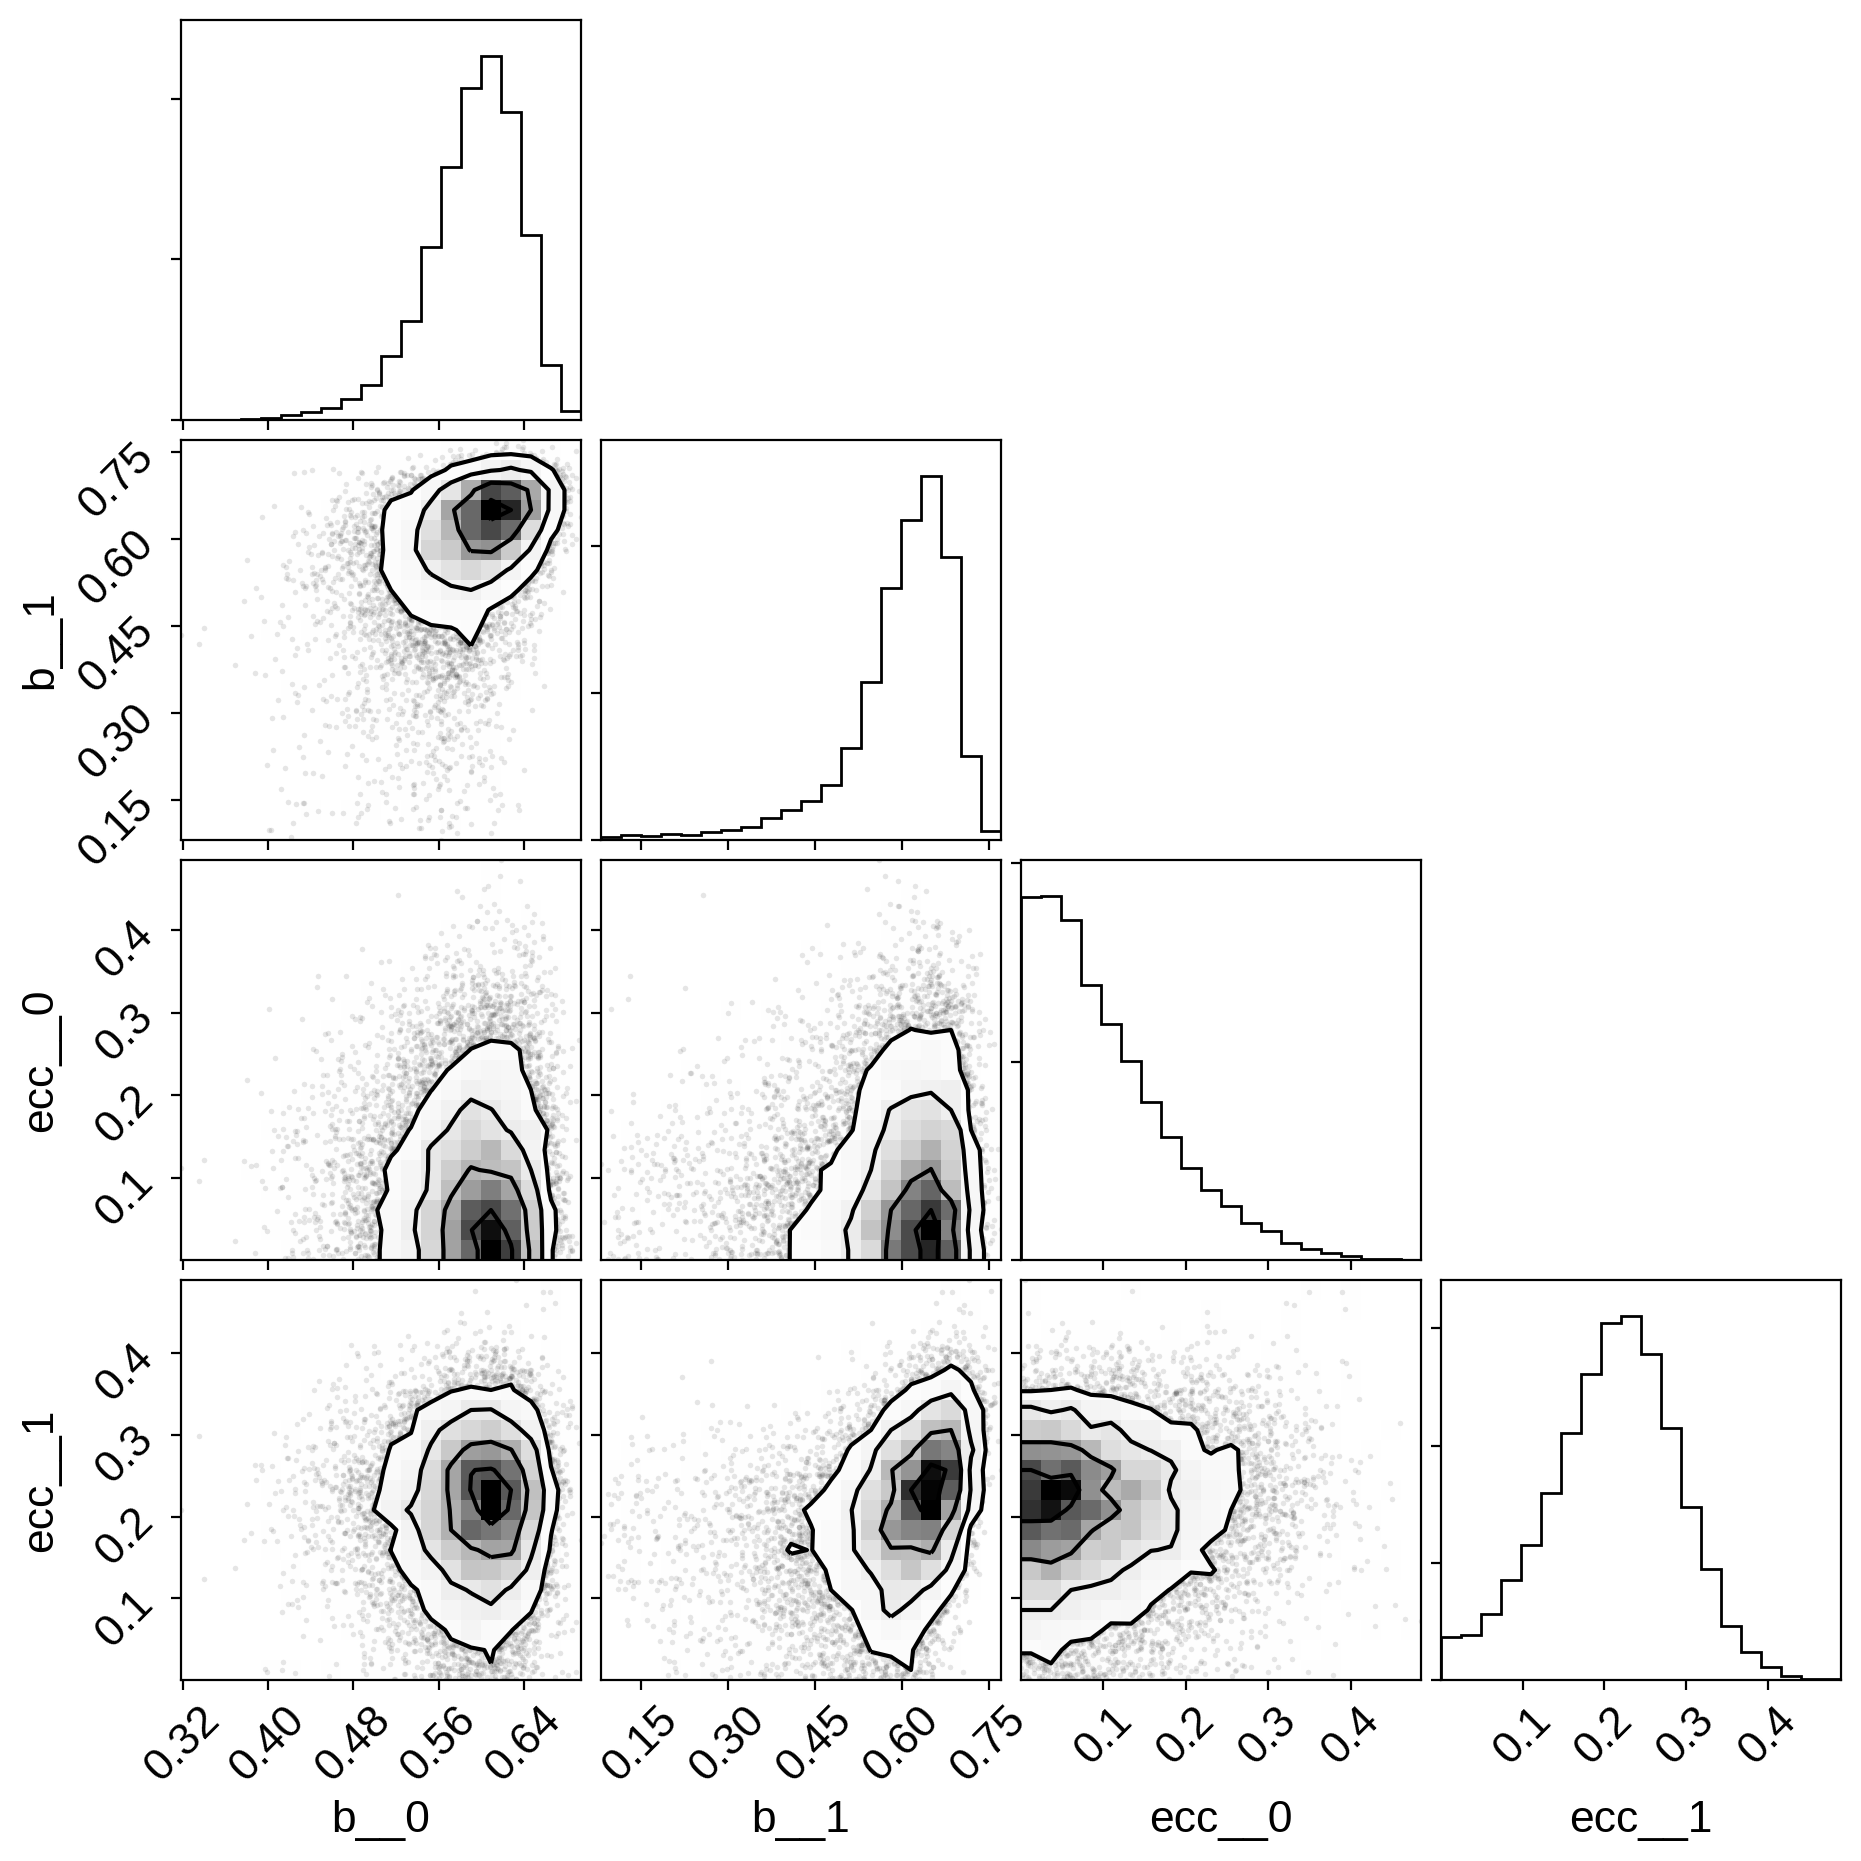

In [16]:
import corner

varnames = ["b", "ecc"]
samples = pm.trace_to_dataframe(trace, varnames=varnames)
fig = corner.corner(samples);

## Phase plots

Finally, as in the :ref:`rv` and :ref:`transit` tutorials, we can make folded plots of the transits and the radial velocities and compare to the posterior model predictions. (Note: planets b and c in this tutorial are swapped compared to the labels from [Petigura et al. (2016)](https://arxiv.org/abs/1511.04497))

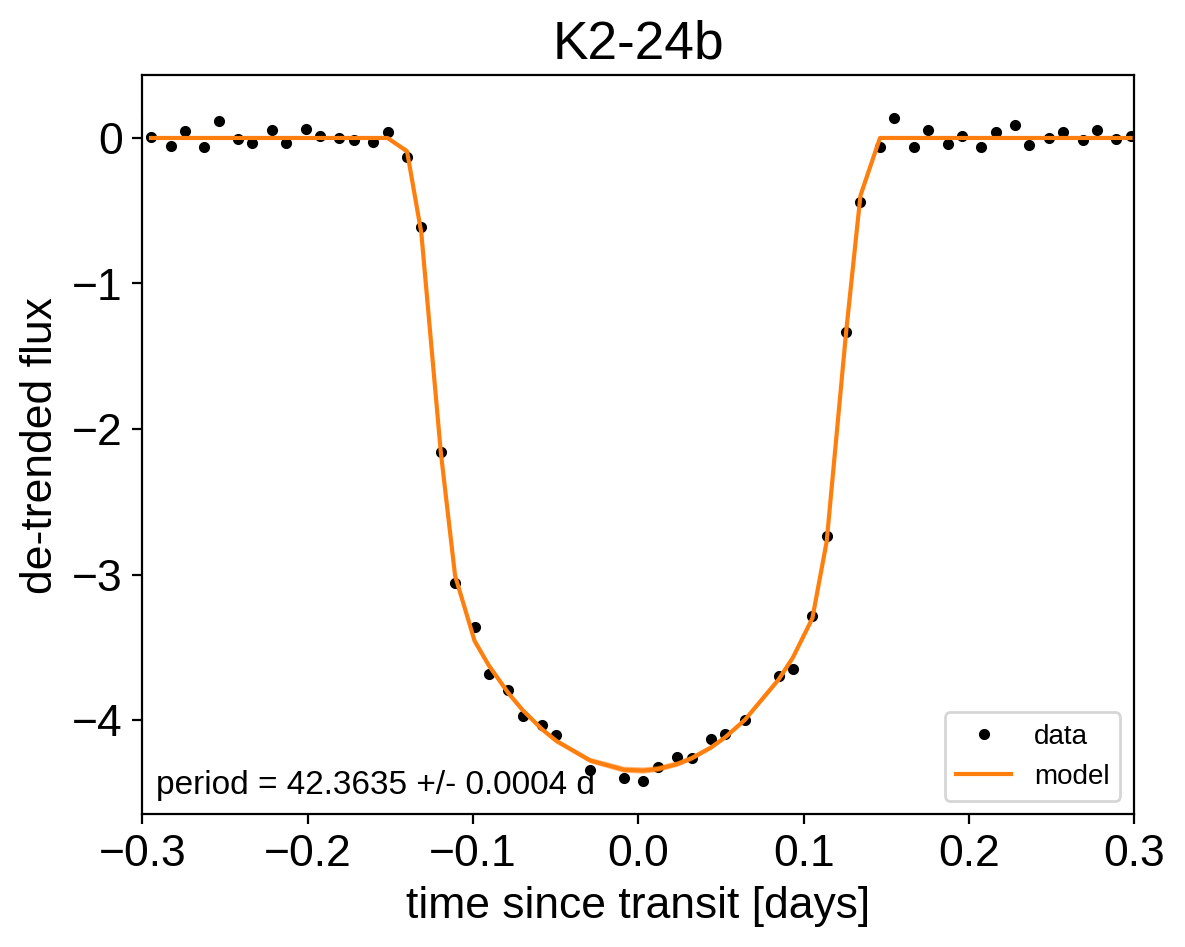

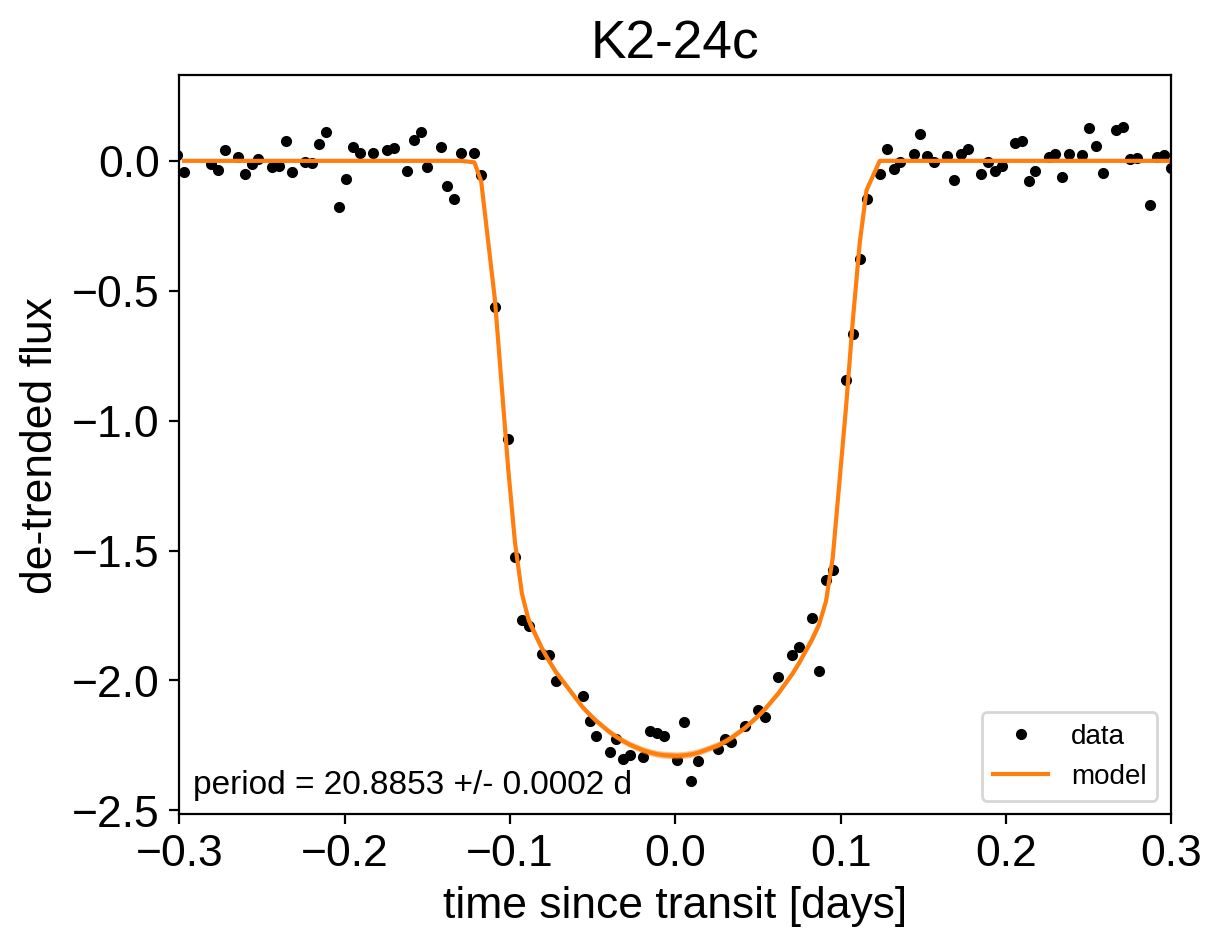

In [17]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Compute the GP prediction
    gp_mod = np.median(trace["gp_pred"] + trace["mean"][:, None], axis=0)

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    other = np.median(trace["light_curves"][:, :, (n + 1) % 2], axis=0)

    # Plot the folded data
    x_fold = (x[mask] - t0 + 0.5 * p) % p - 0.5 * p
    plt.plot(x_fold, y[mask] - gp_mod - other, ".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = trace["light_curves"][:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(
        x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5, zorder=1000
    )
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n])
    )
    plt.annotate(
        txt,
        (0, 0),
        xycoords="axes fraction",
        xytext=(5, 5),
        textcoords="offset points",
        ha="left",
        va="bottom",
        fontsize=12,
    )

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("K2-24{0}".format(letter))
    plt.xlim(-0.3, 0.3)

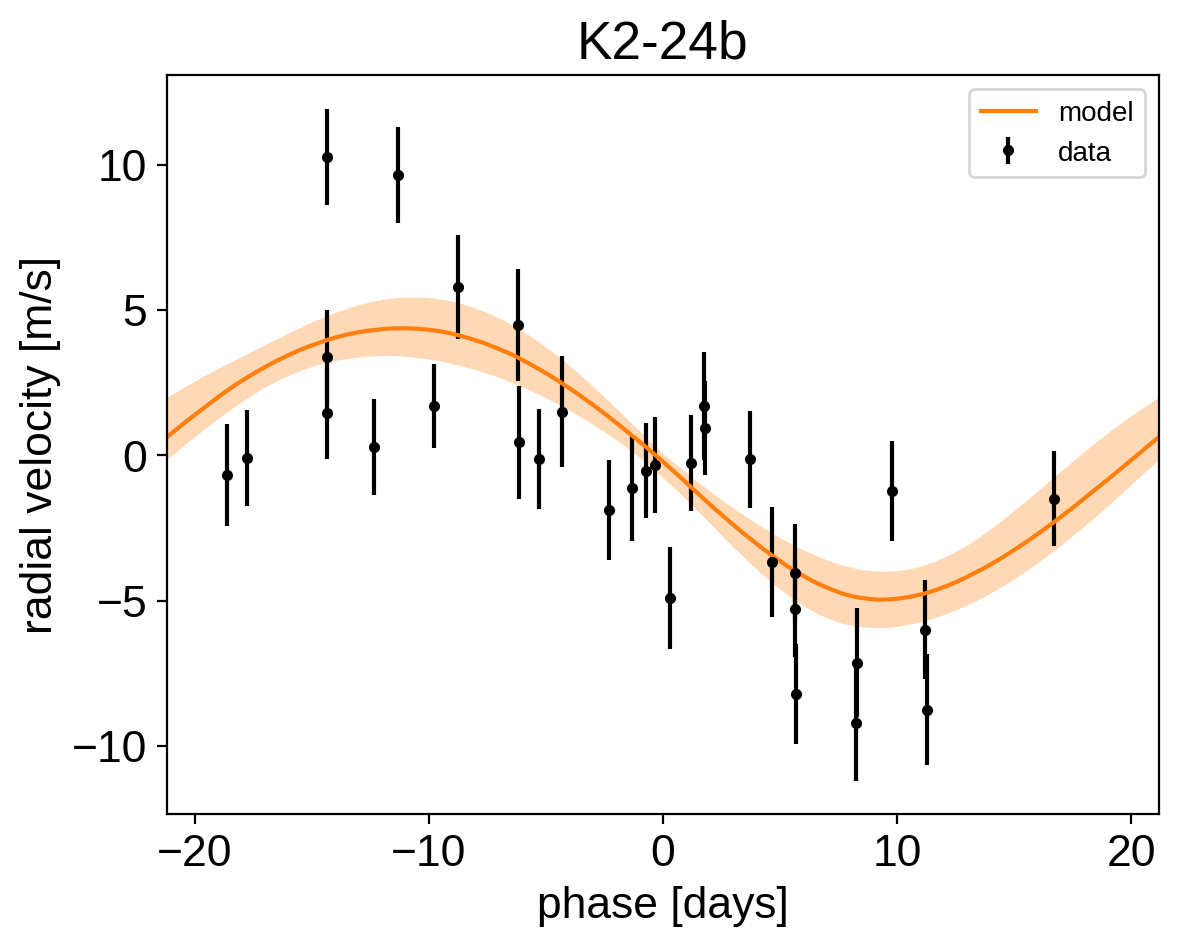

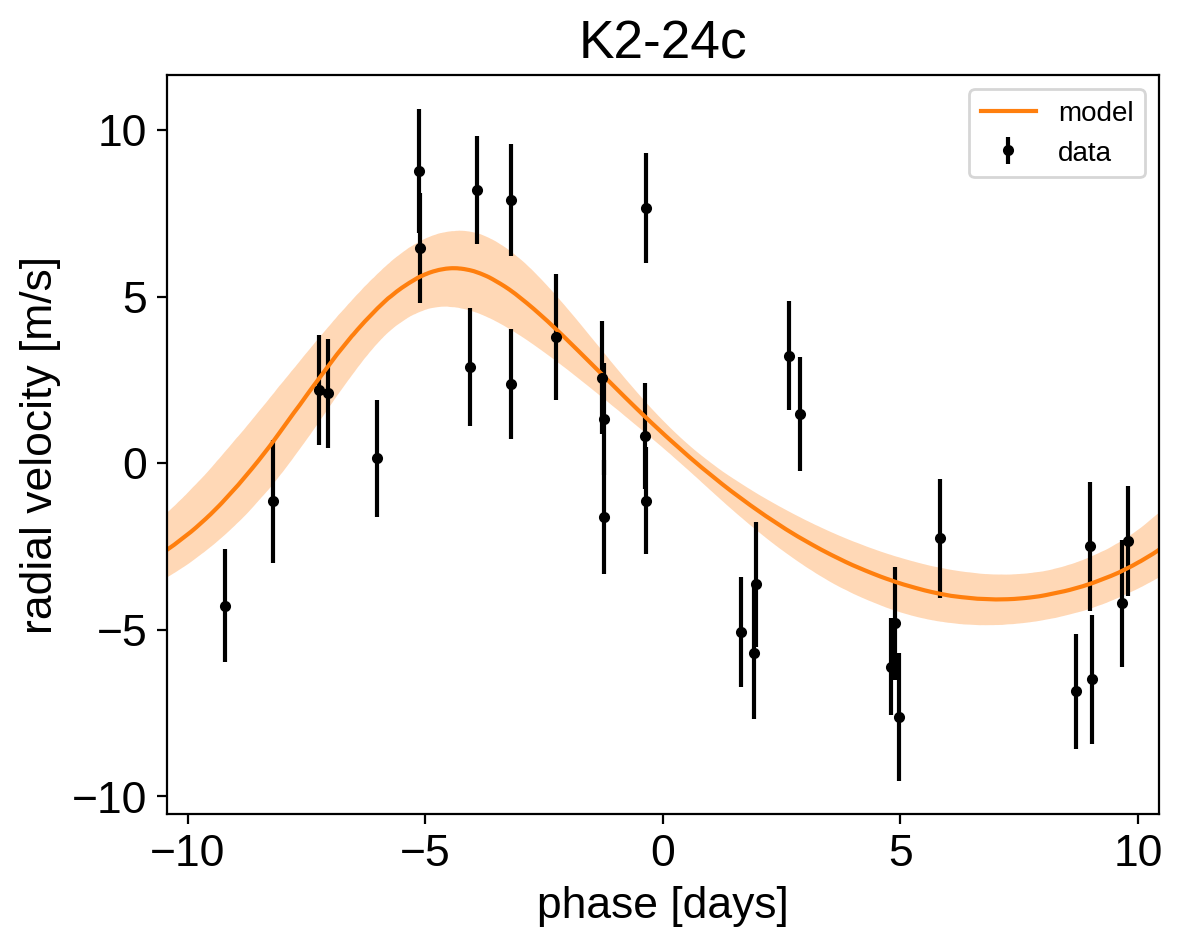

In [18]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the background RV
    # and the contribution from the other planet. Then we can remove
    # this from the data to plot just the planet we care about.
    other = np.median(trace["vrad"][:, :, (n + 1) % 2], axis=0)
    other += np.median(trace["bkg"], axis=0)

    # Plot the folded data
    x_fold = (x_rv - t0 + 0.5 * p) % p - 0.5 * p
    plt.errorbar(x_fold, y_rv - other, yerr=yerr_rv, fmt=".k", label="data")

    # Compute the posterior prediction for the folded RV model for this
    # planet
    t_fold = (t_rv - t0 + 0.5 * p) % p - 0.5 * p
    inds = np.argsort(t_fold)
    pred = np.percentile(trace["vrad_pred"][:, inds, n], [16, 50, 84], axis=0)
    plt.plot(t_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(t_fold[inds], pred[0], pred[2], color="C1", alpha=0.3)
    art.set_edgecolor("none")

    plt.legend(fontsize=10)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("phase [days]")
    plt.ylabel("radial velocity [m/s]")
    plt.title("K2-24{0}".format(letter));

We can also compute the posterior constraints on the planet densities.

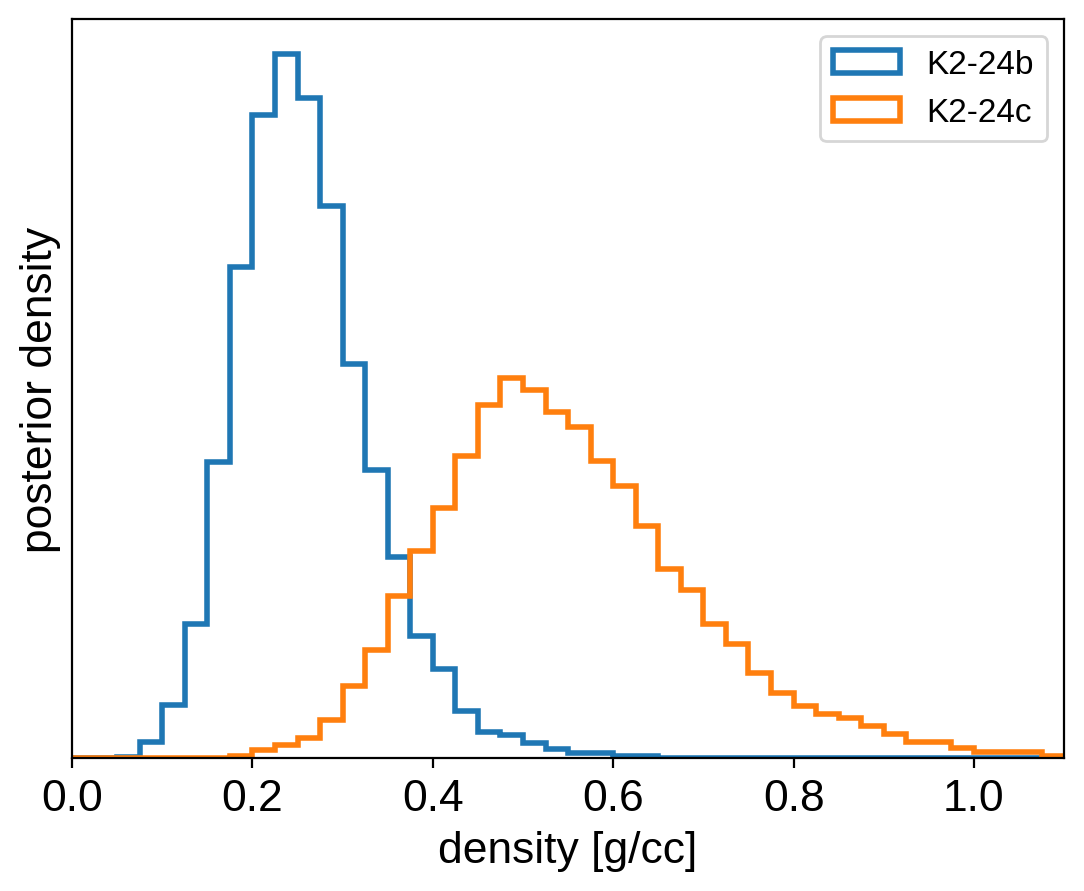

In [19]:
volume = 4 / 3 * np.pi * trace["r_pl"] ** 3
density = u.Quantity(trace["m_pl"] / volume, unit=u.M_earth / u.R_sun ** 3)
density = density.to(u.g / u.cm ** 3).value

bins = np.linspace(0, 1.1, 45)
for n, letter in enumerate("bc"):
    plt.hist(
        density[:, n],
        bins,
        histtype="step",
        lw=2,
        label="K2-24{0}".format(letter),
        density=True,
    )
plt.yticks([])
plt.legend(fontsize=12)
plt.xlim(bins[0], bins[-1])
plt.xlabel("density [g/cc]")
plt.ylabel("posterior density");

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [20]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:agol19, exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:foremanmackey17, exoplanet:foremanmackey18,
exoplanet:kipping13, exoplanet:kipping13b, exoplanet:luger18, exoplanet:pymc3,
exoplanet:theano}.


In [21]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Ian Czekala and Rodrigo Luger and
            Eric Agol and Geert Barentsen and Tom Barclay},
   title = {exoplanet-dev/exoplanet v0.3.0},
   month = apr,
    year = 2020,
     doi = {10.5281/zenodo.1998447},
     url = {https://doi.org/10.5281/zenodo.1998447}
}
...
